In [1]:
import sys
sys.path.append('../')

from generate_bf import *
from computesk import *
import numpy as np
import torch

import copy
import torch.optim as optim
import os

from models.UMNN import MonotonicNN
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
num_test = 10000
num_pairs = 5
num_features = num_pairs * 2
hidden_layers = [64, 64, 64]
nb_steps = 50

lr = 0.01
num_epochs = 100

In [3]:
testing_samples_path = 'BF/BF-samples/bf-testing_samples5p.txt'
validation_samples_path = 'BF/BF-samples/bf-validation_samples5p.txt'
save_path = 'BF/BF-saved_models/BF-5p-64_64_64.es_samples' # Change this!

In [5]:
test_samples = torch.tensor(np.loadtxt(testing_samples_path)).to(torch.float32)
validation_samples = torch.tensor(np.loadtxt(validation_samples_path)).to(torch.float32)

print(test_samples)

tensor([[ 0.8289,  1.3503,  0.3256,  ...,  0.1962, -0.2516, -0.4202],
        [-0.0587,  0.0026, -0.6916,  ..., -0.1389,  0.4334, -0.5928],
        [ 0.5460,  0.4231, -0.8863,  ...,  0.5025,  0.9002, -0.2475],
        ...,
        [ 0.3147,  0.5331,  1.0124,  ...,  0.5237,  0.6708,  0.3994],
        [-0.4309,  1.3082, -1.1901,  ...,  0.2698, -0.3909,  0.1544],
        [ 1.2388,  0.5343, -0.1850,  ...,  2.4728, -0.6737,  1.1008]])


In [6]:
test_samples.shape

torch.Size([10000, 10])

In [7]:
training_sizes = [100, 500, 1000, 2000, 3500, 5000]
random_regs = [1, 0.1, 0.01, 0.001, 0]

In [8]:
kths = list(range(num_features))
fixed_map = generate_non_linear_maps(num_features, hidden_layers, nb_steps, 'cpu')

In [9]:
opt_regs = {}
all_test_losses = {}
all_learnt_maps = {}
all_opt_maps = {}
test_no_reg_losses = {}

## Learn map S_k

In [10]:

for t in range(len(training_sizes)):
    num_train = training_sizes[t]
    X_tr = generate_easy_bf(num_train, num_pairs)

    for i in kths:

        kth = i
        print('kth =', kth)
        best_val_overall = float('inf')
        opt_reg = 0
        opt_Sk = None # should this be moved in?
        each_learnt_map = {}
        non_kth = [idx for idx in range(X_tr.shape[1]) if idx != kth]

        for j in tqdm(range(len(random_regs)), desc='Random Regs', leave=False):
            regLambda = random_regs[j]
            Sk = copy.deepcopy(fixed_map)[kth]
            optimizer = optim.Adam(Sk.parameters(), lr=lr)
            n = X_tr.shape[0]
            early_stop_counter = 0
            best_epoch = 0
            best_valL = float('inf')
            for epoch in range(num_epochs):
                zk = X_tr.detach().requires_grad_(True)
                h = zk[:, non_kth]
                x = zk[:, [kth]]
                # Sk^2
                sk_zi = Sk(x, h)
                # \partial_k S_k (x_i)
                jacobian = torch.autograd.grad(sk_zi, x, torch.ones_like(sk_zi), create_graph=True)[0]
                # 1/2 Sk^2 - log \partial_k Sk(z_i)
                loss = (0.5 * sk_zi**2 - torch.log(jacobian)).sum(axis=0) / n #mapS_losses(sk_zi, jacobian).sum(axis=0) / n#, kth)
                # Regularized loss
                regulariser = torch.sqrt((jacobian**2).sum(axis=0) / n)
                loss += regLambda * regulariser
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Validation
                Sk_zi_val, jacobian_val = test_map(validation_samples, non_kth, kth, Sk)
                val_loss = test_losses(Sk_zi_val, jacobian_val)#, kth)
                print(f'Val {num_train}st λ = {regLambda}, Epoch {epoch}: {val_loss}')

                # Save the smallest validation loss at each loop.
                if val_loss[1] < best_valL:
                    best_valL = val_loss[1]
                    if val_loss[1] < best_val_overall: # overall for all λ and epoch
                        best_val_overall = val_loss[1]
                        opt_reg = regLambda
                        opt_Sk = Sk
                        
                    best_epoch = epoch
                    early_stop_counter = 0
                else:
                    early_stop_counter += 1

                # Check for early stopping
                if early_stop_counter >= 10:
                    print(f'Early stopping at Epoch {epoch} for best epoch {best_epoch}.')
                    break

            each_learnt_map.setdefault(regLambda, []).append(Sk)

        # Test the best model
        Sk_zi_test, jacobian_test = test_map(test_samples, non_kth, kth, opt_Sk)

        all_test_losses.setdefault(num_train, []).append(test_losses(Sk_zi_test, jacobian_test))###, kth))
        print(f'Test {num_train}, λ = {opt_reg}: {all_test_losses[num_train]}')

        all_learnt_maps.setdefault(num_train, []).append(each_learnt_map)
        all_opt_maps.setdefault(num_train, []).append(opt_Sk)
        opt_regs.setdefault(num_train, []).append(opt_reg)
        
    print('Optimal λ ∀ =', opt_regs)


kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.34581610560417175, 1.520215630531311)
Val 100st λ = 1, Epoch 1: (0.28010088205337524, 1.876953125)
Val 100st λ = 1, Epoch 2: (0.26802560687065125, 1.7855421304702759)
Val 100st λ = 1, Epoch 3: (0.27812471985816956, 1.6307419538497925)
Val 100st λ = 1, Epoch 4: (0.32545652985572815, 1.53916597366333)
Val 100st λ = 1, Epoch 5: (0.36579564213752747, 1.5015888214111328)
Val 100st λ = 1, Epoch 6: (0.38326922059059143, 1.493770718574524)
Val 100st λ = 1, Epoch 7: (0.38526681065559387, 1.5039294958114624)
Val 100st λ = 1, Epoch 8: (0.38263970613479614, 1.5286002159118652)
Val 100st λ = 1, Epoch 9: (0.38060200214385986, 1.5626028776168823)
Val 100st λ = 1, Epoch 10: (0.37258705496788025, 1.5912468433380127)
Val 100st λ = 1, Epoch 11: (0.35752901434898376, 1.605156421661377)
Val 100st λ = 1, Epoch 12: (0.3457890450954437, 1.6064388751983643)
Val 100st λ = 1, Epoch 13: (0.3454160690307617, 1.5999321937561035)
Val 100st λ = 1, Epoch 14: (0.36094918847084045, 1.5908911

Random Regs:  20%|██        | 1/5 [00:27<01:49, 27.30s/it]

Val 100st λ = 1, Epoch 16: (0.44397589564323425, 1.5795748233795166)
Early stopping at Epoch 16 for best epoch 6.
Val 100st λ = 0.1, Epoch 0: (0.44267457723617554, 1.4603540897369385)
Val 100st λ = 0.1, Epoch 1: (0.5710688829421997, 1.4672894477844238)
Val 100st λ = 0.1, Epoch 2: (0.8178999423980713, 1.4663838148117065)
Val 100st λ = 0.1, Epoch 3: (1.048041582107544, 1.4826807975769043)
Val 100st λ = 0.1, Epoch 4: (1.1112993955612183, 1.4849330186843872)
Val 100st λ = 0.1, Epoch 5: (1.2177588939666748, 1.513409972190857)
Val 100st λ = 0.1, Epoch 6: (1.808571457862854, 1.6439919471740723)
Val 100st λ = 0.1, Epoch 7: (3.201382875442505, 1.9483559131622314)
Val 100st λ = 0.1, Epoch 8: (3.1389622688293457, 1.937392234802246)
Val 100st λ = 0.1, Epoch 9: (3.696514844894409, 2.0199339389801025)


Random Regs:  40%|████      | 2/5 [00:45<01:04, 21.65s/it]

Val 100st λ = 0.1, Epoch 10: (4.325324058532715, 2.1638758182525635)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.01, Epoch 0: (0.4825305640697479, 1.4452495574951172)
Val 100st λ = 0.01, Epoch 1: (0.694390058517456, 1.4580942392349243)
Val 100st λ = 0.01, Epoch 2: (1.1402850151062012, 1.5157535076141357)
Val 100st λ = 0.01, Epoch 3: (1.3655012845993042, 1.545183777809143)
Val 100st λ = 0.01, Epoch 4: (1.3478610515594482, 1.5319175720214844)
Val 100st λ = 0.01, Epoch 5: (1.7755117416381836, 1.620848298072815)
Val 100st λ = 0.01, Epoch 6: (3.3977248668670654, 1.9658855199813843)
Val 100st λ = 0.01, Epoch 7: (3.958861827850342, 2.126980781555176)
Val 100st λ = 0.01, Epoch 8: (4.664255142211914, 2.2537248134613037)
Val 100st λ = 0.01, Epoch 9: (6.16150426864624, 2.5633413791656494)


Random Regs:  60%|██████    | 3/5 [01:02<00:39, 19.88s/it]

Val 100st λ = 0.01, Epoch 10: (5.089000701904297, 2.4055275917053223)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.001, Epoch 0: (0.4871547520160675, 1.4435526132583618)
Val 100st λ = 0.001, Epoch 1: (0.7089160680770874, 1.4575916528701782)
Val 100st λ = 0.001, Epoch 2: (1.1884292364120483, 1.5262879133224487)
Val 100st λ = 0.001, Epoch 3: (1.4122557640075684, 1.5551085472106934)
Val 100st λ = 0.001, Epoch 4: (1.4103527069091797, 1.5428714752197266)
Val 100st λ = 0.001, Epoch 5: (1.924688696861267, 1.6471614837646484)
Val 100st λ = 0.001, Epoch 6: (3.686528444290161, 2.0294418334960938)
Val 100st λ = 0.001, Epoch 7: (3.8911941051483154, 2.121879816055298)
Val 100st λ = 0.001, Epoch 8: (5.166825771331787, 2.344960927963257)
Val 100st λ = 0.001, Epoch 9: (5.350971698760986, 2.429663896560669)


Random Regs:  80%|████████  | 4/5 [01:20<00:19, 19.03s/it]

Val 100st λ = 0.001, Epoch 10: (6.268885135650635, 2.6601717472076416)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0, Epoch 0: (0.4876127541065216, 1.4434069395065308)
Val 100st λ = 0, Epoch 1: (0.7108244895935059, 1.4576338529586792)
Val 100st λ = 0, Epoch 2: (1.1923447847366333, 1.5271177291870117)
Val 100st λ = 0, Epoch 3: (1.409615159034729, 1.5543360710144043)
Val 100st λ = 0, Epoch 4: (1.4134936332702637, 1.543256402015686)
Val 100st λ = 0, Epoch 5: (1.9534597396850586, 1.6518685817718506)
Val 100st λ = 0, Epoch 6: (3.7917933464050293, 2.0473926067352295)
Val 100st λ = 0, Epoch 7: (3.842562198638916, 2.1110024452209473)
Val 100st λ = 0, Epoch 8: (5.20265007019043, 2.3558366298675537)
Val 100st λ = 0, Epoch 9: (5.340630054473877, 2.4265902042388916)


Val 100st λ = 0, Epoch 10: (6.07911491394043, 2.623553991317749)
Early stopping at Epoch 10 for best epoch 0.


Test 100, λ = 0: [(6.05668830871582, 2.5268425941467285)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.3877679109573364, 1.7392441034317017)
Val 100st λ = 1, Epoch 1: (0.38245078921318054, 1.728579044342041)
Val 100st λ = 1, Epoch 2: (0.4689957797527313, 1.6118923425674438)
Val 100st λ = 1, Epoch 3: (0.5782175660133362, 1.5339596271514893)
Val 100st λ = 1, Epoch 4: (0.6515873670578003, 1.4957042932510376)
Val 100st λ = 1, Epoch 5: (0.6623460054397583, 1.4845318794250488)
Val 100st λ = 1, Epoch 6: (0.6261946558952332, 1.49006187915802)
Val 100st λ = 1, Epoch 7: (0.5780929923057556, 1.5044440031051636)
Val 100st λ = 1, Epoch 8: (0.5425376892089844, 1.520845651626587)
Val 100st λ = 1, Epoch 9: (0.5347515940666199, 1.5275448560714722)
Val 100st λ = 1, Epoch 10: (0.5564097762107849, 1.5159605741500854)
Val 100st λ = 1, Epoch 11: (0.6036282777786255, 1.4916108846664429)
Val 100st λ = 1, Epoch 12: (0.6707155704498291, 1.4685579538345337)
Val 100st λ = 1, Epoch 13: (0.7387878894805908, 1.4582936763763428)
Val 100st λ = 1, Epoch 14: (0.79317307472229, 1.4642968177795

Random Regs:  20%|██        | 1/5 [00:38<02:34, 38.63s/it]

Val 100st λ = 1, Epoch 23: (1.187187671661377, 1.4998540878295898)
Early stopping at Epoch 23 for best epoch 13.
Val 100st λ = 0.1, Epoch 0: (0.8998619318008423, 1.4517107009887695)
Val 100st λ = 0.1, Epoch 1: (1.6577495336532593, 1.4288073778152466)
Val 100st λ = 0.1, Epoch 2: (2.6723532676696777, 1.5229986906051636)
Val 100st λ = 0.1, Epoch 3: (1.8038018941879272, 1.408789873123169)
Val 100st λ = 0.1, Epoch 4: (1.4632031917572021, 1.3735630512237549)
Val 100st λ = 0.1, Epoch 5: (2.100146532058716, 1.4214938879013062)
Val 100st λ = 0.1, Epoch 6: (4.074287414550781, 1.7631083726882935)
Val 100st λ = 0.1, Epoch 7: (2.9278945922851562, 1.5508767366409302)
Val 100st λ = 0.1, Epoch 8: (2.767990827560425, 1.534622311592102)
Val 100st λ = 0.1, Epoch 9: (5.036713123321533, 1.9711871147155762)
Val 100st λ = 0.1, Epoch 10: (6.217265605926514, 2.206437349319458)
Val 100st λ = 0.1, Epoch 11: (4.833127975463867, 1.9027091264724731)
Val 100st λ = 0.1, Epoch 12: (7.431543350219727, 2.392229795455932

Random Regs:  40%|████      | 2/5 [01:03<01:30, 30.25s/it]

Val 100st λ = 0.1, Epoch 14: (8.427255630493164, 2.5071234703063965)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.01, Epoch 0: (1.090932011604309, 1.4364126920700073)
Val 100st λ = 0.01, Epoch 1: (2.1868956089019775, 1.4708319902420044)
Val 100st λ = 0.01, Epoch 2: (2.8018388748168945, 1.5357218980789185)
Val 100st λ = 0.01, Epoch 3: (1.9527052640914917, 1.4223581552505493)
Val 100st λ = 0.01, Epoch 4: (2.150813579559326, 1.4328101873397827)
Val 100st λ = 0.01, Epoch 5: (4.1653828620910645, 1.7547394037246704)
Val 100st λ = 0.01, Epoch 6: (3.8856427669525146, 1.692337155342102)
Val 100st λ = 0.01, Epoch 7: (4.17466926574707, 1.7339928150177002)
Val 100st λ = 0.01, Epoch 8: (8.892505645751953, 2.6400585174560547)
Val 100st λ = 0.01, Epoch 9: (4.461943626403809, 1.795868992805481)
Val 100st λ = 0.01, Epoch 10: (10.62052059173584, 2.9145102500915527)
Val 100st λ = 0.01, Epoch 11: (14.877897262573242, 3.712813377380371)
Val 100st λ = 0.01, Epoch 12: (9.839808464050293, 2.52

Random Regs:  60%|██████    | 3/5 [01:25<00:53, 26.81s/it]

Val 100st λ = 0.01, Epoch 13: (18.83940887451172, 3.9991202354431152)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0.001, Epoch 0: (1.1088287830352783, 1.435914397239685)
Val 100st λ = 0.001, Epoch 1: (2.2357423305511475, 1.4754136800765991)
Val 100st λ = 0.001, Epoch 2: (2.849315643310547, 1.5408380031585693)
Val 100st λ = 0.001, Epoch 3: (2.0466747283935547, 1.433090090751648)
Val 100st λ = 0.001, Epoch 4: (2.2329797744750977, 1.4440120458602905)
Val 100st λ = 0.001, Epoch 5: (4.237082004547119, 1.7650543451309204)
Val 100st λ = 0.001, Epoch 6: (3.9163100719451904, 1.6958420276641846)
Val 100st λ = 0.001, Epoch 7: (4.654579162597656, 1.815073847770691)
Val 100st λ = 0.001, Epoch 8: (9.402732849121094, 2.741726875305176)
Val 100st λ = 0.001, Epoch 9: (4.3649373054504395, 1.7871448993682861)
Val 100st λ = 0.001, Epoch 10: (11.266529083251953, 3.110426664352417)
Val 100st λ = 0.001, Epoch 11: (16.75981903076172, 4.20518159866333)
Val 100st λ = 0.001, Epoch 12: (9.208306312

Random Regs:  80%|████████  | 4/5 [01:48<00:25, 25.16s/it]

Val 100st λ = 0.001, Epoch 13: (15.492074012756348, 3.5609469413757324)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0, Epoch 0: (1.1104053258895874, 1.435843586921692)
Val 100st λ = 0, Epoch 1: (2.235560417175293, 1.475571870803833)
Val 100st λ = 0, Epoch 2: (2.8202316761016846, 1.538663625717163)
Val 100st λ = 0, Epoch 3: (2.007871389389038, 1.4282981157302856)
Val 100st λ = 0, Epoch 4: (2.232619524002075, 1.4438886642456055)
Val 100st λ = 0, Epoch 5: (4.367584705352783, 1.7904433012008667)
Val 100st λ = 0, Epoch 6: (3.8365769386291504, 1.6843059062957764)
Val 100st λ = 0, Epoch 7: (4.605602741241455, 1.8156211376190186)
Val 100st λ = 0, Epoch 8: (9.193085670471191, 2.735908031463623)
Val 100st λ = 0, Epoch 9: (4.547968864440918, 1.8196580410003662)
Val 100st λ = 0, Epoch 10: (11.18006420135498, 3.059385061264038)
Val 100st λ = 0, Epoch 11: (16.331480026245117, 4.058014869689941)
Val 100st λ = 0, Epoch 12: (9.876861572265625, 2.5836093425750732)


Val 100st λ = 0, Epoch 13: (17.78706169128418, 3.9081945419311523)
Early stopping at Epoch 13 for best epoch 3.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.27440011501312256, 1.7742840051651)
Val 100st λ = 1, Epoch 1: (0.2615000903606415, 1.7586164474487305)
Val 100st λ = 1, Epoch 2: (0.272230327129364, 1.615385890007019)
Val 100st λ = 1, Epoch 3: (0.3194144070148468, 1.5267466306686401)
Val 100st λ = 1, Epoch 4: (0.3407262861728668, 1.502890944480896)
Val 100st λ = 1, Epoch 5: (0.32988569140434265, 1.5118722915649414)
Val 100st λ = 1, Epoch 6: (0.30783089995384216, 1.5384222269058228)
Val 100st λ = 1, Epoch 7: (0.28982701897621155, 1.5730341672897339)
Val 100st λ = 1, Epoch 8: (0.28281649947166443, 1.6029611825942993)
Val 100st λ = 1, Epoch 9: (0.28690940141677856, 1.6134209632873535)
Val 100st λ = 1, Epoch 10: (0.29974165558815, 1.5989394187927246)
Val 100st λ = 1, Epoch 11: (0.3214501142501831, 1.56898033618927)
Val 100st λ = 1, Epoch 12: (0.3529924154281616, 1.538999319076538)
Val 100st λ = 1, Epoch 13: (0.3934769630432129, 1.5204583406448364)


Random Regs:  20%|██        | 1/5 [00:24<01:38, 24.71s/it]

Val 100st λ = 1, Epoch 14: (0.43732136487960815, 1.518556833267212)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.1, Epoch 0: (0.3115031123161316, 1.608923316001892)
Val 100st λ = 0.1, Epoch 1: (0.5223157405853271, 1.4184027910232544)
Val 100st λ = 0.1, Epoch 2: (1.0675415992736816, 1.4598009586334229)
Val 100st λ = 0.1, Epoch 3: (0.8818202614784241, 1.416711688041687)
Val 100st λ = 0.1, Epoch 4: (0.7320288419723511, 1.3962010145187378)
Val 100st λ = 0.1, Epoch 5: (0.702222466468811, 1.3990497589111328)
Val 100st λ = 0.1, Epoch 6: (0.8022146821022034, 1.4158732891082764)
Val 100st λ = 0.1, Epoch 7: (1.1772764921188354, 1.4818814992904663)
Val 100st λ = 0.1, Epoch 8: (2.1469671726226807, 1.691151738166809)
Val 100st λ = 0.1, Epoch 9: (2.7740533351898193, 1.7805670499801636)
Val 100st λ = 0.1, Epoch 10: (3.570068836212158, 1.8406988382339478)
Val 100st λ = 0.1, Epoch 11: (5.348442077636719, 2.0609488487243652)
Val 100st λ = 0.1, Epoch 12: (5.878849029541016, 2.249710559844

Random Regs:  40%|████      | 2/5 [00:49<01:14, 24.73s/it]

Val 100st λ = 0.1, Epoch 14: (6.507601261138916, 2.6913180351257324)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.01, Epoch 0: (0.3491484820842743, 1.5449637174606323)
Val 100st λ = 0.01, Epoch 1: (0.7199926972389221, 1.4049676656723022)
Val 100st λ = 0.01, Epoch 2: (1.4002814292907715, 1.5436631441116333)
Val 100st λ = 0.01, Epoch 3: (0.8945661187171936, 1.4156244993209839)
Val 100st λ = 0.01, Epoch 4: (0.7120501399040222, 1.4002196788787842)
Val 100st λ = 0.01, Epoch 5: (0.7346777319908142, 1.4103059768676758)
Val 100st λ = 0.01, Epoch 6: (1.0274529457092285, 1.4473143815994263)
Val 100st λ = 0.01, Epoch 7: (2.3114452362060547, 1.7238408327102661)
Val 100st λ = 0.01, Epoch 8: (3.8470611572265625, 2.0188589096069336)
Val 100st λ = 0.01, Epoch 9: (3.4957690238952637, 1.8997750282287598)
Val 100st λ = 0.01, Epoch 10: (4.852733612060547, 2.0511562824249268)
Val 100st λ = 0.01, Epoch 11: (10.892361640930176, 2.7239975929260254)
Val 100st λ = 0.01, Epoch 12: (10.62272167205

Random Regs:  60%|██████    | 3/5 [01:14<00:49, 24.92s/it]

Val 100st λ = 0.01, Epoch 14: (11.060372352600098, 3.2746944427490234)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.001, Epoch 0: (0.353403776884079, 1.5397168397903442)
Val 100st λ = 0.001, Epoch 1: (0.7497816681861877, 1.4067039489746094)
Val 100st λ = 0.001, Epoch 2: (1.4004175662994385, 1.5432257652282715)
Val 100st λ = 0.001, Epoch 3: (0.8977248668670654, 1.4165923595428467)
Val 100st λ = 0.001, Epoch 4: (0.7314757108688354, 1.4025815725326538)
Val 100st λ = 0.001, Epoch 5: (0.7901524901390076, 1.4142624139785767)
Val 100st λ = 0.001, Epoch 6: (1.2265379428863525, 1.4835125207901)
Val 100st λ = 0.001, Epoch 7: (3.2427661418914795, 1.9348855018615723)
Val 100st λ = 0.001, Epoch 8: (3.1459712982177734, 1.8719359636306763)
Val 100st λ = 0.001, Epoch 9: (3.347923755645752, 1.8701682090759277)
Val 100st λ = 0.001, Epoch 10: (6.535402297973633, 2.2436952590942383)
Val 100st λ = 0.001, Epoch 11: (14.6261568069458, 3.1532070636749268)
Val 100st λ = 0.001, Epoch 12: (7.8174

Random Regs:  80%|████████  | 4/5 [01:39<00:24, 24.90s/it]

Val 100st λ = 0.001, Epoch 14: (11.629679679870605, 3.3962152004241943)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0, Epoch 0: (0.35451582074165344, 1.538011074066162)
Val 100st λ = 0, Epoch 1: (0.7568879127502441, 1.40730619430542)
Val 100st λ = 0, Epoch 2: (1.3891757726669312, 1.539823293685913)
Val 100st λ = 0, Epoch 3: (0.8935962319374084, 1.4160569906234741)
Val 100st λ = 0, Epoch 4: (0.732052206993103, 1.4034377336502075)
Val 100st λ = 0, Epoch 5: (0.7960106730461121, 1.4154640436172485)
Val 100st λ = 0, Epoch 6: (1.2522220611572266, 1.488190770149231)
Val 100st λ = 0, Epoch 7: (3.325176239013672, 1.9573858976364136)
Val 100st λ = 0, Epoch 8: (3.1653316020965576, 1.879577875137329)
Val 100st λ = 0, Epoch 9: (3.356956720352173, 1.87700355052948)
Val 100st λ = 0, Epoch 10: (6.5676069259643555, 2.247465133666992)
Val 100st λ = 0, Epoch 11: (15.208823204040527, 3.175581693649292)
Val 100st λ = 0, Epoch 12: (9.01684284210205, 2.626328229904175)
Val 100st λ = 0, Epoch 1

Val 100st λ = 0, Epoch 14: (12.351285934448242, 3.3380110263824463)
Early stopping at Epoch 14 for best epoch 4.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.5549567937850952, 1.54470694065094)
Val 100st λ = 1, Epoch 1: (0.35339826345443726, 1.9514468908309937)
Val 100st λ = 1, Epoch 2: (0.3521009087562561, 1.7574998140335083)
Val 100st λ = 1, Epoch 3: (0.4994262158870697, 1.5480376482009888)
Val 100st λ = 1, Epoch 4: (0.707070529460907, 1.4530324935913086)
Val 100st λ = 1, Epoch 5: (0.77188640832901, 1.4353219270706177)
Val 100st λ = 1, Epoch 6: (0.7125612497329712, 1.446853518486023)
Val 100st λ = 1, Epoch 7: (0.6144607663154602, 1.4779894351959229)
Val 100st λ = 1, Epoch 8: (0.5284234285354614, 1.5239206552505493)
Val 100st λ = 1, Epoch 9: (0.4745371341705322, 1.568068504333496)
Val 100st λ = 1, Epoch 10: (0.45286276936531067, 1.5868468284606934)
Val 100st λ = 1, Epoch 11: (0.4549287259578705, 1.5730652809143066)
Val 100st λ = 1, Epoch 12: (0.4766387641429901, 1.5400307178497314)
Val 100st λ = 1, Epoch 13: (0.514570415019989, 1.5038502216339111)
Val 100st λ = 1, Epoch 14: (0.5597483515739441, 1.47447276115417

Random Regs:  20%|██        | 1/5 [00:26<01:44, 26.22s/it]

Val 100st λ = 1, Epoch 15: (0.5997422933578491, 1.4548753499984741)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.1, Epoch 0: (0.6782310009002686, 1.482269287109375)
Val 100st λ = 0.1, Epoch 1: (0.800062358379364, 1.430205225944519)
Val 100st λ = 0.1, Epoch 2: (1.195683479309082, 1.381365418434143)
Val 100st λ = 0.1, Epoch 3: (1.5242832899093628, 1.3803040981292725)
Val 100st λ = 0.1, Epoch 4: (1.590673804283142, 1.3710918426513672)
Val 100st λ = 0.1, Epoch 5: (1.7807010412216187, 1.3770123720169067)
Val 100st λ = 0.1, Epoch 6: (2.8059470653533936, 1.447945237159729)
Val 100st λ = 0.1, Epoch 7: (6.211225986480713, 1.7235183715820312)
Val 100st λ = 0.1, Epoch 8: (6.771998405456543, 1.7774076461791992)
Val 100st λ = 0.1, Epoch 9: (4.98471736907959, 1.638584017753601)
Val 100st λ = 0.1, Epoch 10: (4.8667778968811035, 1.675355076789856)
Val 100st λ = 0.1, Epoch 11: (6.364848613739014, 1.906368613243103)
Val 100st λ = 0.1, Epoch 12: (5.851139068603516, 1.8125113248825073)
Val

Random Regs:  40%|████      | 2/5 [00:50<01:15, 25.25s/it]

Val 100st λ = 0.1, Epoch 14: (20.946264266967773, 3.394843816757202)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.01, Epoch 0: (0.7179333567619324, 1.4679811000823975)
Val 100st λ = 0.01, Epoch 1: (0.9322577118873596, 1.4082289934158325)
Val 100st λ = 0.01, Epoch 2: (1.4856390953063965, 1.387184977531433)
Val 100st λ = 0.01, Epoch 3: (1.9175560474395752, 1.4101412296295166)
Val 100st λ = 0.01, Epoch 4: (2.1515843868255615, 1.419217824935913)
Val 100st λ = 0.01, Epoch 5: (2.9899754524230957, 1.4864405393600464)
Val 100st λ = 0.01, Epoch 6: (7.286065101623535, 1.8091509342193604)
Val 100st λ = 0.01, Epoch 7: (14.87903881072998, 2.2344954013824463)
Val 100st λ = 0.01, Epoch 8: (10.37441349029541, 1.9478281736373901)
Val 100st λ = 0.01, Epoch 9: (8.18423843383789, 1.863761305809021)
Val 100st λ = 0.01, Epoch 10: (11.753432273864746, 2.253753900527954)
Val 100st λ = 0.01, Epoch 11: (16.415769577026367, 2.4998176097869873)


Random Regs:  60%|██████    | 3/5 [01:11<00:46, 23.33s/it]

Val 100st λ = 0.01, Epoch 12: (47.79917907714844, 4.009803295135498)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.001, Epoch 0: (0.7228047251701355, 1.466503620147705)
Val 100st λ = 0.001, Epoch 1: (0.9441249966621399, 1.40682852268219)
Val 100st λ = 0.001, Epoch 2: (1.5155365467071533, 1.3884140253067017)
Val 100st λ = 0.001, Epoch 3: (1.9482567310333252, 1.412920355796814)
Val 100st λ = 0.001, Epoch 4: (2.2352278232574463, 1.4266263246536255)
Val 100st λ = 0.001, Epoch 5: (3.398653984069824, 1.5156830549240112)
Val 100st λ = 0.001, Epoch 6: (9.53536319732666, 1.8959976434707642)
Val 100st λ = 0.001, Epoch 7: (17.698850631713867, 2.2647008895874023)
Val 100st λ = 0.001, Epoch 8: (11.714082717895508, 1.97465980052948)
Val 100st λ = 0.001, Epoch 9: (9.230369567871094, 1.9169517755508423)
Val 100st λ = 0.001, Epoch 10: (13.307051658630371, 2.3474276065826416)
Val 100st λ = 0.001, Epoch 11: (20.144763946533203, 2.687329053878784)


Random Regs:  80%|████████  | 4/5 [01:32<00:22, 22.47s/it]

Val 100st λ = 0.001, Epoch 12: (74.37378692626953, 5.042573928833008)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0, Epoch 0: (0.7231181263923645, 1.4664452075958252)
Val 100st λ = 0, Epoch 1: (0.9460132718086243, 1.406691074371338)
Val 100st λ = 0, Epoch 2: (1.520991325378418, 1.3887877464294434)
Val 100st λ = 0, Epoch 3: (1.9543606042861938, 1.4134621620178223)
Val 100st λ = 0, Epoch 4: (2.243924617767334, 1.427316665649414)
Val 100st λ = 0, Epoch 5: (3.423797130584717, 1.5173097848892212)
Val 100st λ = 0, Epoch 6: (9.69412899017334, 1.9068982601165771)
Val 100st λ = 0, Epoch 7: (17.813987731933594, 2.2752861976623535)
Val 100st λ = 0, Epoch 8: (11.913226127624512, 1.9897806644439697)
Val 100st λ = 0, Epoch 9: (9.668882369995117, 1.9475642442703247)
Val 100st λ = 0, Epoch 10: (14.11774730682373, 2.4182441234588623)
Val 100st λ = 0, Epoch 11: (20.557048797607422, 2.722832202911377)


Val 100st λ = 0, Epoch 12: (86.80439758300781, 5.579980373382568)
Early stopping at Epoch 12 for best epoch 2.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.3096035420894623, 1.6027889251708984)
Val 100st λ = 1, Epoch 1: (0.287502646446228, 1.7922720909118652)
Val 100st λ = 1, Epoch 2: (0.2819649577140808, 1.646423101425171)
Val 100st λ = 1, Epoch 3: (0.3348589241504669, 1.524490237236023)
Val 100st λ = 1, Epoch 4: (0.3842690587043762, 1.4780184030532837)
Val 100st λ = 1, Epoch 5: (0.3895755112171173, 1.4773143529891968)
Val 100st λ = 1, Epoch 6: (0.37282049655914307, 1.5032634735107422)
Val 100st λ = 1, Epoch 7: (0.36463499069213867, 1.5505919456481934)
Val 100st λ = 1, Epoch 8: (0.3855186104774475, 1.6011788845062256)
Val 100st λ = 1, Epoch 9: (0.41827917098999023, 1.6180559396743774)
Val 100st λ = 1, Epoch 10: (0.44305410981178284, 1.595624566078186)
Val 100st λ = 1, Epoch 11: (0.4724925756454468, 1.5585440397262573)
Val 100st λ = 1, Epoch 12: (0.518170177936554, 1.5284135341644287)
Val 100st λ = 1, Epoch 13: (0.5781005024909973, 1.5152385234832764)
Val 100st λ = 1, Epoch 14: (0.6434934735298157, 1.522118806

Random Regs:  20%|██        | 1/5 [00:26<01:45, 26.45s/it]

Val 100st λ = 1, Epoch 15: (0.708009660243988, 1.5442990064620972)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.1, Epoch 0: (0.4052235782146454, 1.472750186920166)
Val 100st λ = 0.1, Epoch 1: (0.6200339198112488, 1.4071996212005615)
Val 100st λ = 0.1, Epoch 2: (0.9594646692276001, 1.4389119148254395)
Val 100st λ = 0.1, Epoch 3: (1.0496894121170044, 1.4621402025222778)
Val 100st λ = 0.1, Epoch 4: (1.0160436630249023, 1.4704090356826782)
Val 100st λ = 0.1, Epoch 5: (1.1460541486740112, 1.5101977586746216)
Val 100st λ = 0.1, Epoch 6: (1.5658128261566162, 1.6002604961395264)
Val 100st λ = 0.1, Epoch 7: (2.4241251945495605, 1.8457744121551514)
Val 100st λ = 0.1, Epoch 8: (2.347905158996582, 1.8383710384368896)
Val 100st λ = 0.1, Epoch 9: (2.4014663696289062, 1.873524785041809)
Val 100st λ = 0.1, Epoch 10: (3.128546714782715, 2.086409330368042)


Random Regs:  40%|████      | 2/5 [00:46<01:07, 22.42s/it]

Val 100st λ = 0.1, Epoch 11: (4.194244384765625, 2.3865480422973633)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.01, Epoch 0: (0.4692268967628479, 1.438598394393921)
Val 100st λ = 0.01, Epoch 1: (0.7878007888793945, 1.410402536392212)
Val 100st λ = 0.01, Epoch 2: (1.20768141746521, 1.4977253675460815)
Val 100st λ = 0.01, Epoch 3: (1.0909603834152222, 1.4742228984832764)
Val 100st λ = 0.01, Epoch 4: (1.117783784866333, 1.4983174800872803)
Val 100st λ = 0.01, Epoch 5: (1.5457332134246826, 1.5979055166244507)
Val 100st λ = 0.01, Epoch 6: (2.7114083766937256, 1.930751919746399)
Val 100st λ = 0.01, Epoch 7: (2.9118428230285645, 2.0040676593780518)
Val 100st λ = 0.01, Epoch 8: (2.9377169609069824, 2.0285887718200684)
Val 100st λ = 0.01, Epoch 9: (4.281187534332275, 2.3882908821105957)
Val 100st λ = 0.01, Epoch 10: (5.6122894287109375, 2.711621046066284)


Random Regs:  60%|██████    | 3/5 [01:05<00:42, 21.06s/it]

Val 100st λ = 0.01, Epoch 11: (6.045290470123291, 2.704277753829956)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (0.4787035882472992, 1.435002088546753)
Val 100st λ = 0.001, Epoch 1: (0.8062820434570312, 1.4121758937835693)
Val 100st λ = 0.001, Epoch 2: (1.2266089916229248, 1.5025591850280762)
Val 100st λ = 0.001, Epoch 3: (1.0886706113815308, 1.4746211767196655)
Val 100st λ = 0.001, Epoch 4: (1.137819766998291, 1.50534987449646)
Val 100st λ = 0.001, Epoch 5: (1.637322187423706, 1.6217457056045532)
Val 100st λ = 0.001, Epoch 6: (2.9010958671569824, 1.989209532737732)
Val 100st λ = 0.001, Epoch 7: (2.7380521297454834, 1.952872633934021)
Val 100st λ = 0.001, Epoch 8: (2.977908134460449, 2.0338830947875977)
Val 100st λ = 0.001, Epoch 9: (4.9933037757873535, 2.529172420501709)
Val 100st λ = 0.001, Epoch 10: (5.289976119995117, 2.612016201019287)


Random Regs:  80%|████████  | 4/5 [01:25<00:20, 20.48s/it]

Val 100st λ = 0.001, Epoch 11: (6.872764587402344, 2.8667986392974854)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (0.47929975390434265, 1.434837818145752)
Val 100st λ = 0, Epoch 1: (0.8079372048377991, 1.4124575853347778)
Val 100st λ = 0, Epoch 2: (1.230942964553833, 1.503760814666748)
Val 100st λ = 0, Epoch 3: (1.0887094736099243, 1.4749401807785034)
Val 100st λ = 0, Epoch 4: (1.1367648839950562, 1.5057756900787354)
Val 100st λ = 0, Epoch 5: (1.6360269784927368, 1.6222479343414307)
Val 100st λ = 0, Epoch 6: (2.877152442932129, 1.985547423362732)
Val 100st λ = 0, Epoch 7: (2.7445311546325684, 1.9558451175689697)
Val 100st λ = 0, Epoch 8: (2.9792978763580322, 2.035917282104492)
Val 100st λ = 0, Epoch 9: (5.097752094268799, 2.5561583042144775)
Val 100st λ = 0, Epoch 10: (5.270604610443115, 2.6157329082489014)


Val 100st λ = 0, Epoch 11: (6.83006477355957, 2.8489015102386475)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.35641512274742126, 1.7411350011825562)
Val 100st λ = 1, Epoch 1: (0.4378068447113037, 1.6005865335464478)
Val 100st λ = 1, Epoch 2: (0.6243283152580261, 1.4943180084228516)
Val 100st λ = 1, Epoch 3: (0.7500580549240112, 1.4581550359725952)
Val 100st λ = 1, Epoch 4: (0.7697789072990417, 1.456173300743103)
Val 100st λ = 1, Epoch 5: (0.7270393967628479, 1.47239351272583)
Val 100st λ = 1, Epoch 6: (0.6720068454742432, 1.4982998371124268)
Val 100st λ = 1, Epoch 7: (0.6396012306213379, 1.519408941268921)
Val 100st λ = 1, Epoch 8: (0.6471660137176514, 1.5223056077957153)
Val 100st λ = 1, Epoch 9: (0.6960819363594055, 1.5064762830734253)
Val 100st λ = 1, Epoch 10: (0.7763955593109131, 1.4835633039474487)
Val 100st λ = 1, Epoch 11: (0.8621751666069031, 1.467322826385498)
Val 100st λ = 1, Epoch 12: (0.9018412828445435, 1.46559476852417)
Val 100st λ = 1, Epoch 13: (0.8964362740516663, 1.4783953428268433)


Random Regs:  20%|██        | 1/5 [00:24<01:37, 24.37s/it]

Val 100st λ = 1, Epoch 14: (0.8811827898025513, 1.4994487762451172)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.1, Epoch 0: (3.27721905708313, 1.5547869205474854)
Val 100st λ = 0.1, Epoch 1: (1.7151027917861938, 1.425701379776001)
Val 100st λ = 0.1, Epoch 2: (1.9645754098892212, 1.4312561750411987)
Val 100st λ = 0.1, Epoch 3: (3.317706346511841, 1.5513560771942139)
Val 100st λ = 0.1, Epoch 4: (4.862411975860596, 1.7603824138641357)
Val 100st λ = 0.1, Epoch 5: (4.242884159088135, 1.6819781064987183)
Val 100st λ = 0.1, Epoch 6: (4.1454925537109375, 1.682949185371399)
Val 100st λ = 0.1, Epoch 7: (6.2302069664001465, 2.0110819339752197)
Val 100st λ = 0.1, Epoch 8: (6.96348762512207, 2.0700409412384033)
Val 100st λ = 0.1, Epoch 9: (7.542647361755371, 2.1052331924438477)
Val 100st λ = 0.1, Epoch 10: (12.144001007080078, 2.7665512561798096)


Random Regs:  40%|████      | 2/5 [00:44<01:05, 21.77s/it]

Val 100st λ = 0.1, Epoch 11: (12.731332778930664, 2.8312485218048096)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.01, Epoch 0: (3.8739848136901855, 1.6230636835098267)
Val 100st λ = 0.01, Epoch 1: (2.237459897994995, 1.4512337446212769)
Val 100st λ = 0.01, Epoch 2: (2.1826517581939697, 1.4468902349472046)
Val 100st λ = 0.01, Epoch 3: (3.3178820610046387, 1.5452293157577515)
Val 100st λ = 0.01, Epoch 4: (6.040985584259033, 1.8847609758377075)
Val 100st λ = 0.01, Epoch 5: (6.65556526184082, 2.0116076469421387)
Val 100st λ = 0.01, Epoch 6: (6.052367210388184, 1.9793792963027954)
Val 100st λ = 0.01, Epoch 7: (7.6144256591796875, 2.233095645904541)
Val 100st λ = 0.01, Epoch 8: (11.017730712890625, 2.6504764556884766)
Val 100st λ = 0.01, Epoch 9: (10.280850410461426, 2.41536808013916)
Val 100st λ = 0.01, Epoch 10: (18.79886245727539, 3.492821455001831)
Val 100st λ = 0.01, Epoch 11: (28.222370147705078, 4.576318264007568)


Random Regs:  60%|██████    | 3/5 [01:05<00:43, 21.54s/it]

Val 100st λ = 0.01, Epoch 12: (20.097137451171875, 3.469998836517334)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.001, Epoch 0: (3.925291061401367, 1.6297824382781982)
Val 100st λ = 0.001, Epoch 1: (2.273411512374878, 1.4543951749801636)
Val 100st λ = 0.001, Epoch 2: (2.1997809410095215, 1.4492065906524658)
Val 100st λ = 0.001, Epoch 3: (3.345764398574829, 1.550279140472412)
Val 100st λ = 0.001, Epoch 4: (6.061438083648682, 1.8982967138290405)
Val 100st λ = 0.001, Epoch 5: (6.803768157958984, 2.043452739715576)
Val 100st λ = 0.001, Epoch 6: (6.217072486877441, 2.0095090866088867)
Val 100st λ = 0.001, Epoch 7: (7.991024494171143, 2.2761104106903076)
Val 100st λ = 0.001, Epoch 8: (12.318305015563965, 2.7637016773223877)
Val 100st λ = 0.001, Epoch 9: (11.524608612060547, 2.4846351146698)
Val 100st λ = 0.001, Epoch 10: (23.178171157836914, 3.864955425262451)
Val 100st λ = 0.001, Epoch 11: (29.899782180786133, 4.5411553382873535)


Random Regs:  80%|████████  | 4/5 [01:26<00:21, 21.43s/it]

Val 100st λ = 0.001, Epoch 12: (22.04876136779785, 3.589597702026367)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0, Epoch 0: (3.9263267517089844, 1.6299960613250732)
Val 100st λ = 0, Epoch 1: (2.2788939476013184, 1.4548943042755127)
Val 100st λ = 0, Epoch 2: (2.2142276763916016, 1.4502341747283936)
Val 100st λ = 0, Epoch 3: (3.371530055999756, 1.5530439615249634)
Val 100st λ = 0, Epoch 4: (6.083057880401611, 1.9001550674438477)
Val 100st λ = 0, Epoch 5: (6.782970905303955, 2.040212392807007)
Val 100st λ = 0, Epoch 6: (6.209260940551758, 2.0092051029205322)
Val 100st λ = 0, Epoch 7: (8.037483215332031, 2.285764694213867)
Val 100st λ = 0, Epoch 8: (12.346370697021484, 2.7730813026428223)
Val 100st λ = 0, Epoch 9: (11.572973251342773, 2.497213363647461)
Val 100st λ = 0, Epoch 10: (23.161314010620117, 3.8795218467712402)
Val 100st λ = 0, Epoch 11: (31.155122756958008, 4.687805652618408)


Val 100st λ = 0, Epoch 12: (22.024961471557617, 3.570639133453369)
Early stopping at Epoch 12 for best epoch 2.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492), (22.84642791748047, 2.783859968185425)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.22918641567230225, 1.8406111001968384)
Val 100st λ = 1, Epoch 1: (0.23350761830806732, 1.664743185043335)
Val 100st λ = 1, Epoch 2: (0.30554133653640747, 1.549591302871704)
Val 100st λ = 1, Epoch 3: (0.36320051550865173, 1.508044958114624)
Val 100st λ = 1, Epoch 4: (0.36967232823371887, 1.5093364715576172)
Val 100st λ = 1, Epoch 5: (0.360429584980011, 1.5265872478485107)
Val 100st λ = 1, Epoch 6: (0.3571973145008087, 1.5530903339385986)
Val 100st λ = 1, Epoch 7: (0.36978814005851746, 1.5851670503616333)
Val 100st λ = 1, Epoch 8: (0.39971569180488586, 1.6112079620361328)
Val 100st λ = 1, Epoch 9: (0.43513214588165283, 1.6140474081039429)
Val 100st λ = 1, Epoch 10: (0.47657206654548645, 1.5945931673049927)
Val 100st λ = 1, Epoch 11: (0.5358681082725525, 1.5717729330062866)
Val 100st λ = 1, Epoch 12: (0.6171137690544128, 1.5639554262161255)


Random Regs:  20%|██        | 1/5 [00:22<01:31, 22.76s/it]

Val 100st λ = 1, Epoch 13: (0.7093921899795532, 1.5819170475006104)
Early stopping at Epoch 13 for best epoch 3.
Val 100st λ = 0.1, Epoch 0: (1.6779268980026245, 1.6341590881347656)
Val 100st λ = 0.1, Epoch 1: (0.7182090282440186, 1.4222209453582764)
Val 100st λ = 0.1, Epoch 2: (0.5334479212760925, 1.4395474195480347)
Val 100st λ = 0.1, Epoch 3: (0.525208055973053, 1.4484676122665405)
Val 100st λ = 0.1, Epoch 4: (0.6120384335517883, 1.4393794536590576)
Val 100st λ = 0.1, Epoch 5: (0.8328292369842529, 1.451175332069397)
Val 100st λ = 0.1, Epoch 6: (1.340988278388977, 1.5519065856933594)
Val 100st λ = 0.1, Epoch 7: (1.9766664505004883, 1.7163418531417847)
Val 100st λ = 0.1, Epoch 8: (2.234707832336426, 1.7925761938095093)
Val 100st λ = 0.1, Epoch 9: (2.7159667015075684, 1.9162200689315796)
Val 100st λ = 0.1, Epoch 10: (4.059688568115234, 2.1937904357910156)


Random Regs:  40%|████      | 2/5 [00:42<01:02, 20.86s/it]

Val 100st λ = 0.1, Epoch 11: (6.755832195281982, 2.7000572681427)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.01, Epoch 0: (1.827532172203064, 1.6798734664916992)
Val 100st λ = 0.01, Epoch 1: (0.8037500977516174, 1.4296523332595825)
Val 100st λ = 0.01, Epoch 2: (0.6079187393188477, 1.4270991086959839)
Val 100st λ = 0.01, Epoch 3: (0.5998820066452026, 1.4337198734283447)
Val 100st λ = 0.01, Epoch 4: (0.7228260636329651, 1.4371999502182007)
Val 100st λ = 0.01, Epoch 5: (1.0695768594741821, 1.4880046844482422)
Val 100st λ = 0.01, Epoch 6: (1.82949697971344, 1.6790763139724731)
Val 100st λ = 0.01, Epoch 7: (2.333068370819092, 1.822637677192688)
Val 100st λ = 0.01, Epoch 8: (2.550652503967285, 1.8963183164596558)
Val 100st λ = 0.01, Epoch 9: (3.4683213233947754, 2.1161563396453857)
Val 100st λ = 0.01, Epoch 10: (6.602220058441162, 2.691030740737915)
Val 100st λ = 0.01, Epoch 11: (9.710504531860352, 3.2392735481262207)


Random Regs:  60%|██████    | 3/5 [01:03<00:42, 21.14s/it]

Val 100st λ = 0.01, Epoch 12: (13.296072006225586, 3.7746782302856445)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0.001, Epoch 0: (1.8360859155654907, 1.6827173233032227)
Val 100st λ = 0.001, Epoch 1: (0.8130443692207336, 1.430773138999939)
Val 100st λ = 0.001, Epoch 2: (0.6170389652252197, 1.4268840551376343)
Val 100st λ = 0.001, Epoch 3: (0.6129526495933533, 1.4331599473953247)
Val 100st λ = 0.001, Epoch 4: (0.7505083084106445, 1.439010500907898)
Val 100st λ = 0.001, Epoch 5: (1.1500121355056763, 1.5048787593841553)
Val 100st λ = 0.001, Epoch 6: (2.04693603515625, 1.7342675924301147)
Val 100st λ = 0.001, Epoch 7: (2.428220748901367, 1.8420627117156982)
Val 100st λ = 0.001, Epoch 8: (2.5513174533843994, 1.891034722328186)
Val 100st λ = 0.001, Epoch 9: (3.544339418411255, 2.116502046585083)
Val 100st λ = 0.001, Epoch 10: (7.554500102996826, 2.7948155403137207)
Val 100st λ = 0.001, Epoch 11: (10.881484985351562, 3.331664800643921)


Random Regs:  80%|████████  | 4/5 [01:24<00:21, 21.15s/it]

Val 100st λ = 0.001, Epoch 12: (14.80911922454834, 3.8569774627685547)
Early stopping at Epoch 12 for best epoch 2.
Val 100st λ = 0, Epoch 0: (1.8360114097595215, 1.6827059984207153)
Val 100st λ = 0, Epoch 1: (0.8139166235923767, 1.4308679103851318)
Val 100st λ = 0, Epoch 2: (0.6178151369094849, 1.426836609840393)
Val 100st λ = 0, Epoch 3: (0.6144217252731323, 1.4330824613571167)
Val 100st λ = 0, Epoch 4: (0.7540695667266846, 1.439301609992981)
Val 100st λ = 0, Epoch 5: (1.1602131128311157, 1.5071637630462646)
Val 100st λ = 0, Epoch 6: (2.0585551261901855, 1.737904667854309)
Val 100st λ = 0, Epoch 7: (2.436450481414795, 1.8449627161026)
Val 100st λ = 0, Epoch 8: (2.5642077922821045, 1.8948546648025513)
Val 100st λ = 0, Epoch 9: (3.5670125484466553, 2.121626853942871)
Val 100st λ = 0, Epoch 10: (7.471147060394287, 2.7881624698638916)
Val 100st λ = 0, Epoch 11: (10.76667594909668, 3.3374745845794678)


Val 100st λ = 0, Epoch 12: (15.089488983154297, 3.9038374423980713)
Early stopping at Epoch 12 for best epoch 2.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492), (22.84642791748047, 2.783859968185425), (5.8434929847717285, 2.5408055782318115)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.4047388732433319, 1.6523511409759521)
Val 100st λ = 1, Epoch 1: (0.3603365123271942, 1.7349101305007935)
Val 100st λ = 1, Epoch 2: (0.45133817195892334, 1.6420570611953735)
Val 100st λ = 1, Epoch 3: (0.5929261445999146, 1.5541669130325317)
Val 100st λ = 1, Epoch 4: (0.6871717572212219, 1.5148671865463257)
Val 100st λ = 1, Epoch 5: (0.6870509386062622, 1.5139743089675903)
Val 100st λ = 1, Epoch 6: (0.6444719433784485, 1.5377942323684692)
Val 100st λ = 1, Epoch 7: (0.6153035163879395, 1.5691972970962524)
Val 100st λ = 1, Epoch 8: (0.63242107629776, 1.577439785003662)
Val 100st λ = 1, Epoch 9: (0.6960286498069763, 1.551148772239685)
Val 100st λ = 1, Epoch 10: (0.7885001301765442, 1.5153017044067383)
Val 100st λ = 1, Epoch 11: (0.8602198362350464, 1.4999046325683594)
Val 100st λ = 1, Epoch 12: (0.8719848990440369, 1.5125739574432373)
Val 100st λ = 1, Epoch 13: (0.86833655834198, 1.5441604852676392)
Val 100st λ = 1, Epoch 14: (0.8980076909065247, 1.5701258182525

Random Regs:  20%|██        | 1/5 [00:36<02:24, 36.11s/it]

Val 100st λ = 1, Epoch 21: (1.611670970916748, 1.6658365726470947)
Early stopping at Epoch 21 for best epoch 11.
Val 100st λ = 0.1, Epoch 0: (0.8510878682136536, 1.4818034172058105)
Val 100st λ = 0.1, Epoch 1: (2.216160535812378, 1.4883382320404053)
Val 100st λ = 0.1, Epoch 2: (3.578852653503418, 1.6231611967086792)
Val 100st λ = 0.1, Epoch 3: (2.657011032104492, 1.5426383018493652)
Val 100st λ = 0.1, Epoch 4: (3.905604362487793, 1.6891275644302368)
Val 100st λ = 0.1, Epoch 5: (11.977839469909668, 2.383206844329834)
Val 100st λ = 0.1, Epoch 6: (5.256633281707764, 1.804359793663025)
Val 100st λ = 0.1, Epoch 7: (5.49802827835083, 1.8102387189865112)
Val 100st λ = 0.1, Epoch 8: (10.829099655151367, 2.3095340728759766)
Val 100st λ = 0.1, Epoch 9: (9.088631629943848, 2.2857613563537598)


Random Regs:  40%|████      | 2/5 [00:53<01:15, 25.26s/it]

Val 100st λ = 0.1, Epoch 10: (7.4270710945129395, 2.196068525314331)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.01, Epoch 0: (1.1390269994735718, 1.4548126459121704)
Val 100st λ = 0.01, Epoch 1: (3.356217861175537, 1.5937600135803223)
Val 100st λ = 0.01, Epoch 2: (3.16141414642334, 1.5768954753875732)
Val 100st λ = 0.01, Epoch 3: (4.603492259979248, 1.7421321868896484)
Val 100st λ = 0.01, Epoch 4: (15.317336082458496, 2.625244379043579)
Val 100st λ = 0.01, Epoch 5: (7.6177215576171875, 1.954535961151123)
Val 100st λ = 0.01, Epoch 6: (22.639039993286133, 2.6775286197662354)
Val 100st λ = 0.01, Epoch 7: (77.44023132324219, 4.988162994384766)
Val 100st λ = 0.01, Epoch 8: (13.184377670288086, 2.4133918285369873)
Val 100st λ = 0.01, Epoch 9: (9.762430191040039, 2.2933578491210938)


Random Regs:  60%|██████    | 3/5 [01:11<00:43, 21.90s/it]

Val 100st λ = 0.01, Epoch 10: (23.7669620513916, 3.5821094512939453)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.001, Epoch 0: (1.1771528720855713, 1.452681303024292)
Val 100st λ = 0.001, Epoch 1: (3.5027034282684326, 1.60916268825531)
Val 100st λ = 0.001, Epoch 2: (3.0907483100891113, 1.5697898864746094)
Val 100st λ = 0.001, Epoch 3: (4.770051956176758, 1.7584824562072754)
Val 100st λ = 0.001, Epoch 4: (17.377037048339844, 2.746260166168213)
Val 100st λ = 0.001, Epoch 5: (7.170369625091553, 1.931132197380066)
Val 100st λ = 0.001, Epoch 6: (17.633155822753906, 2.4927306175231934)
Val 100st λ = 0.001, Epoch 7: (86.42939758300781, 5.38020133972168)
Val 100st λ = 0.001, Epoch 8: (18.02231788635254, 2.731600284576416)
Val 100st λ = 0.001, Epoch 9: (12.259255409240723, 2.4854836463928223)


Random Regs:  80%|████████  | 4/5 [01:29<00:20, 20.38s/it]

Val 100st λ = 0.001, Epoch 10: (29.56963539123535, 3.8604886531829834)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0, Epoch 0: (1.1776556968688965, 1.4526877403259277)
Val 100st λ = 0, Epoch 1: (3.5149543285369873, 1.6105009317398071)
Val 100st λ = 0, Epoch 2: (3.0813815593719482, 1.5686215162277222)
Val 100st λ = 0, Epoch 3: (4.741109848022461, 1.7563449144363403)
Val 100st λ = 0, Epoch 4: (16.58976936340332, 2.699681282043457)
Val 100st λ = 0, Epoch 5: (7.510739326477051, 1.9561063051223755)
Val 100st λ = 0, Epoch 6: (20.669492721557617, 2.635549306869507)
Val 100st λ = 0, Epoch 7: (101.02314758300781, 5.811151027679443)
Val 100st λ = 0, Epoch 8: (17.934322357177734, 2.704298973083496)
Val 100st λ = 0, Epoch 9: (12.37065315246582, 2.4803993701934814)


Val 100st λ = 0, Epoch 10: (32.51362228393555, 4.002092361450195)
Early stopping at Epoch 10 for best epoch 0.


Test 100, λ = 0.001: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492), (22.84642791748047, 2.783859968185425), (5.8434929847717285, 2.5408055782318115), (38.78046798706055, 3.960134744644165)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.33874499797821045, 1.5354281663894653)
Val 100st λ = 1, Epoch 1: (0.2974567711353302, 1.9034996032714844)
Val 100st λ = 1, Epoch 2: (0.2612653076648712, 1.696462869644165)
Val 100st λ = 1, Epoch 3: (0.30883926153182983, 1.5465916395187378)
Val 100st λ = 1, Epoch 4: (0.36144810914993286, 1.4933096170425415)
Val 100st λ = 1, Epoch 5: (0.3722381293773651, 1.4865388870239258)
Val 100st λ = 1, Epoch 6: (0.3524862825870514, 1.5037331581115723)
Val 100st λ = 1, Epoch 7: (0.3199746310710907, 1.5414713621139526)
Val 100st λ = 1, Epoch 8: (0.2918105721473694, 1.5966947078704834)
Val 100st λ = 1, Epoch 9: (0.2817676365375519, 1.648433804512024)
Val 100st λ = 1, Epoch 10: (0.28798216581344604, 1.6664317846298218)
Val 100st λ = 1, Epoch 11: (0.30239737033843994, 1.6489288806915283)
Val 100st λ = 1, Epoch 12: (0.322959840297699, 1.6140440702438354)
Val 100st λ = 1, Epoch 13: (0.34872883558273315, 1.5788917541503906)
Val 100st λ = 1, Epoch 14: (0.37727153301239014, 1.5539

Random Regs:  20%|██        | 1/5 [00:25<01:43, 25.99s/it]

Val 100st λ = 1, Epoch 15: (0.40687811374664307, 1.54252290725708)
Early stopping at Epoch 15 for best epoch 5.
Val 100st λ = 0.1, Epoch 0: (0.4840882122516632, 1.4320577383041382)
Val 100st λ = 0.1, Epoch 1: (0.678546667098999, 1.4208784103393555)
Val 100st λ = 0.1, Epoch 2: (1.0920275449752808, 1.4769415855407715)
Val 100st λ = 0.1, Epoch 3: (0.8682430982589722, 1.4416117668151855)
Val 100st λ = 0.1, Epoch 4: (0.9180543422698975, 1.4586610794067383)
Val 100st λ = 0.1, Epoch 5: (1.8177257776260376, 1.6071316003799438)
Val 100st λ = 0.1, Epoch 6: (2.5754401683807373, 1.8040080070495605)
Val 100st λ = 0.1, Epoch 7: (2.7230679988861084, 1.8936105966567993)
Val 100st λ = 0.1, Epoch 8: (8.028263092041016, 2.8133740425109863)
Val 100st λ = 0.1, Epoch 9: (3.578108072280884, 2.1183505058288574)
Val 100st λ = 0.1, Epoch 10: (5.083460330963135, 2.342142105102539)


Random Regs:  40%|████      | 2/5 [00:45<01:06, 22.30s/it]

Val 100st λ = 0.1, Epoch 11: (10.725552558898926, 3.262249708175659)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.01, Epoch 0: (0.5485696792602539, 1.4184330701828003)
Val 100st λ = 0.01, Epoch 1: (0.8853893876075745, 1.4400421380996704)
Val 100st λ = 0.01, Epoch 2: (1.3344147205352783, 1.5159991979599)
Val 100st λ = 0.01, Epoch 3: (0.9949513673782349, 1.4572279453277588)
Val 100st λ = 0.01, Epoch 4: (1.4767318964004517, 1.5292774438858032)
Val 100st λ = 0.01, Epoch 5: (4.287540912628174, 1.9894572496414185)
Val 100st λ = 0.01, Epoch 6: (2.2777328491210938, 1.755079746246338)
Val 100st λ = 0.01, Epoch 7: (4.276281356811523, 2.1754162311553955)
Val 100st λ = 0.01, Epoch 8: (13.726400375366211, 3.7944202423095703)
Val 100st λ = 0.01, Epoch 9: (5.215605735778809, 2.417564868927002)


Random Regs:  60%|██████    | 3/5 [01:03<00:40, 20.46s/it]

Val 100st λ = 0.01, Epoch 10: (7.1158976554870605, 2.636429786682129)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0.001, Epoch 0: (0.5597679018974304, 1.4166879653930664)
Val 100st λ = 0.001, Epoch 1: (0.9084437489509583, 1.4430744647979736)
Val 100st λ = 0.001, Epoch 2: (1.3554761409759521, 1.5192803144454956)
Val 100st λ = 0.001, Epoch 3: (1.007507085800171, 1.4586799144744873)
Val 100st λ = 0.001, Epoch 4: (1.621826171875, 1.5529052019119263)
Val 100st λ = 0.001, Epoch 5: (4.6735124588012695, 2.0774450302124023)
Val 100st λ = 0.001, Epoch 6: (2.1806018352508545, 1.7510724067687988)
Val 100st λ = 0.001, Epoch 7: (4.350120544433594, 2.183438539505005)
Val 100st λ = 0.001, Epoch 8: (16.05097770690918, 4.139880657196045)
Val 100st λ = 0.001, Epoch 9: (5.51344633102417, 2.4410245418548584)


Random Regs:  80%|████████  | 4/5 [01:22<00:19, 19.53s/it]

Val 100st λ = 0.001, Epoch 10: (5.62451171875, 2.4149348735809326)
Early stopping at Epoch 10 for best epoch 0.
Val 100st λ = 0, Epoch 0: (0.5607147216796875, 1.416612148284912)
Val 100st λ = 0, Epoch 1: (0.9129915833473206, 1.443922996520996)
Val 100st λ = 0, Epoch 2: (1.360081434249878, 1.5201499462127686)
Val 100st λ = 0, Epoch 3: (1.0184673070907593, 1.4598536491394043)
Val 100st λ = 0, Epoch 4: (1.6621594429016113, 1.5581408739089966)
Val 100st λ = 0, Epoch 5: (4.699463367462158, 2.078357219696045)
Val 100st λ = 0, Epoch 6: (2.1643316745758057, 1.7482690811157227)
Val 100st λ = 0, Epoch 7: (4.366800308227539, 2.1838717460632324)
Val 100st λ = 0, Epoch 8: (16.61737060546875, 4.20988655090332)
Val 100st λ = 0, Epoch 9: (5.558089256286621, 2.4280354976654053)


Val 100st λ = 0, Epoch 10: (5.5063066482543945, 2.3843042850494385)
Early stopping at Epoch 10 for best epoch 0.


Test 100, λ = 0: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492), (22.84642791748047, 2.783859968185425), (5.8434929847717285, 2.5408055782318115), (38.78046798706055, 3.960134744644165), (7.048774242401123, 2.4491207599639893)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 100st λ = 1, Epoch 0: (0.3432985842227936, 1.7991585731506348)
Val 100st λ = 1, Epoch 1: (0.39204585552215576, 1.6435917615890503)
Val 100st λ = 1, Epoch 2: (0.531696081161499, 1.5312139987945557)
Val 100st λ = 1, Epoch 3: (0.6361129283905029, 1.4893947839736938)
Val 100st λ = 1, Epoch 4: (0.6580820083618164, 1.4865473508834839)
Val 100st λ = 1, Epoch 5: (0.6286272406578064, 1.5029945373535156)
Val 100st λ = 1, Epoch 6: (0.5876896381378174, 1.5286935567855835)
Val 100st λ = 1, Epoch 7: (0.5665441751480103, 1.552901029586792)
Val 100st λ = 1, Epoch 8: (0.5867711305618286, 1.5656460523605347)
Val 100st λ = 1, Epoch 9: (0.6372588276863098, 1.5594589710235596)
Val 100st λ = 1, Epoch 10: (0.7026368975639343, 1.540339469909668)
Val 100st λ = 1, Epoch 11: (0.7847911715507507, 1.5224469900131226)
Val 100st λ = 1, Epoch 12: (0.8644891977310181, 1.5161634683609009)
Val 100st λ = 1, Epoch 13: (0.9152986407279968, 1.5241310596466064)


Random Regs:  20%|██        | 1/5 [00:24<01:38, 24.71s/it]

Val 100st λ = 1, Epoch 14: (0.9324185252189636, 1.541304349899292)
Early stopping at Epoch 14 for best epoch 4.
Val 100st λ = 0.1, Epoch 0: (2.186020851135254, 1.477247953414917)
Val 100st λ = 0.1, Epoch 1: (1.4385995864868164, 1.4207584857940674)
Val 100st λ = 0.1, Epoch 2: (1.8349370956420898, 1.4595261812210083)
Val 100st λ = 0.1, Epoch 3: (3.965221405029297, 1.7540717124938965)
Val 100st λ = 0.1, Epoch 4: (3.237037420272827, 1.6524574756622314)
Val 100st λ = 0.1, Epoch 5: (3.26393985748291, 1.6675769090652466)
Val 100st λ = 0.1, Epoch 6: (6.266958713531494, 2.1515920162200928)
Val 100st λ = 0.1, Epoch 7: (6.834797382354736, 2.2106499671936035)
Val 100st λ = 0.1, Epoch 8: (9.9967622756958, 2.4904067516326904)
Val 100st λ = 0.1, Epoch 9: (31.207448959350586, 4.029017925262451)
Val 100st λ = 0.1, Epoch 10: (16.120479583740234, 2.8701086044311523)


Random Regs:  40%|████      | 2/5 [00:44<01:05, 21.78s/it]

Val 100st λ = 0.1, Epoch 11: (34.07486343383789, 4.651620388031006)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.01, Epoch 0: (2.586451768875122, 1.5337289571762085)
Val 100st λ = 0.01, Epoch 1: (1.7412841320037842, 1.4333082437515259)
Val 100st λ = 0.01, Epoch 2: (1.8178901672363281, 1.4545150995254517)
Val 100st λ = 0.01, Epoch 3: (3.459191083908081, 1.6719753742218018)
Val 100st λ = 0.01, Epoch 4: (6.95871639251709, 2.217498540878296)
Val 100st λ = 0.01, Epoch 5: (4.109899044036865, 1.7932125329971313)
Val 100st λ = 0.01, Epoch 6: (4.386248588562012, 1.8533546924591064)
Val 100st λ = 0.01, Epoch 7: (9.680268287658691, 2.665220260620117)
Val 100st λ = 0.01, Epoch 8: (12.487641334533691, 2.9719738960266113)
Val 100st λ = 0.01, Epoch 9: (16.419939041137695, 3.1089842319488525)
Val 100st λ = 0.01, Epoch 10: (75.44468688964844, 6.2604851722717285)


Random Regs:  60%|██████    | 3/5 [01:04<00:41, 20.92s/it]

Val 100st λ = 0.01, Epoch 11: (156.7217559814453, 9.266064643859863)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0.001, Epoch 0: (2.6177256107330322, 1.5387697219848633)
Val 100st λ = 0.001, Epoch 1: (1.77227783203125, 1.435524821281433)
Val 100st λ = 0.001, Epoch 2: (1.8195551633834839, 1.4537761211395264)
Val 100st λ = 0.001, Epoch 3: (3.393436908721924, 1.6612664461135864)
Val 100st λ = 0.001, Epoch 4: (7.587718486785889, 2.3042030334472656)
Val 100st λ = 0.001, Epoch 5: (4.104495048522949, 1.788412094116211)
Val 100st λ = 0.001, Epoch 6: (3.907710552215576, 1.7809866666793823)
Val 100st λ = 0.001, Epoch 7: (7.745303153991699, 2.381240129470825)
Val 100st λ = 0.001, Epoch 8: (13.726611137390137, 3.2446322441101074)
Val 100st λ = 0.001, Epoch 9: (12.681392669677734, 2.9168598651885986)
Val 100st λ = 0.001, Epoch 10: (30.338590621948242, 4.041297912597656)


Random Regs:  80%|████████  | 4/5 [01:23<00:20, 20.35s/it]

Val 100st λ = 0.001, Epoch 11: (170.27264404296875, 10.740677833557129)
Early stopping at Epoch 11 for best epoch 1.
Val 100st λ = 0, Epoch 0: (2.6228761672973633, 1.53957200050354)
Val 100st λ = 0, Epoch 1: (1.776454210281372, 1.4358264207839966)
Val 100st λ = 0, Epoch 2: (1.8255270719528198, 1.45414400100708)
Val 100st λ = 0, Epoch 3: (3.403533458709717, 1.6627156734466553)
Val 100st λ = 0, Epoch 4: (7.407876014709473, 2.278980255126953)
Val 100st λ = 0, Epoch 5: (4.156595706939697, 1.795819878578186)
Val 100st λ = 0, Epoch 6: (3.9640753269195557, 1.7897995710372925)
Val 100st λ = 0, Epoch 7: (7.860960960388184, 2.4071857929229736)
Val 100st λ = 0, Epoch 8: (13.727319717407227, 3.2391059398651123)
Val 100st λ = 0, Epoch 9: (13.502326011657715, 2.9749104976654053)
Val 100st λ = 0, Epoch 10: (41.11555480957031, 4.636071681976318)


Val 100st λ = 0, Epoch 11: (236.76295471191406, 12.912972450256348)
Early stopping at Epoch 11 for best epoch 1.


Test 100, λ = 0.1: [(6.05668830871582, 2.5268425941467285), (13.284541130065918, 2.607485771179199), (18.864580154418945, 2.9446027278900146), (484.4654235839844, 8.02674674987793), (4.826086521148682, 2.381132125854492), (22.84642791748047, 2.783859968185425), (5.8434929847717285, 2.5408055782318115), (38.78046798706055, 3.960134744644165), (7.048774242401123, 2.4491207599639893), (25.417560577392578, 4.471508026123047)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.34112656116485596, 1.5347890853881836)
Val 500st λ = 1, Epoch 1: (0.2640596628189087, 1.8844285011291504)
Val 500st λ = 1, Epoch 2: (0.24672773480415344, 1.7691996097564697)
Val 500st λ = 1, Epoch 3: (0.26638004183769226, 1.6183350086212158)
Val 500st λ = 1, Epoch 4: (0.31835877895355225, 1.5330592393875122)
Val 500st λ = 1, Epoch 5: (0.3567608892917633, 1.4982075691223145)
Val 500st λ = 1, Epoch 6: (0.3679928183555603, 1.4897863864898682)
Val 500st λ = 1, Epoch 7: (0.3579188585281372, 1.4962036609649658)
Val 500st λ = 1, Epoch 8: (0.3356779217720032, 1.5136089324951172)
Val 500st λ = 1, Epoch 9: (0.30902570486068726, 1.5405733585357666)
Val 500st λ = 1, Epoch 10: (0.2844076454639435, 1.5735821723937988)
Val 500st λ = 1, Epoch 11: (0.2666320204734802, 1.6038312911987305)
Val 500st λ = 1, Epoch 12: (0.25680309534072876, 1.6231105327606201)
Val 500st λ = 1, Epoch 13: (0.25449874997138977, 1.6274514198303223)
Val 500st λ = 1, Epoch 14: (0.2583085894584656, 1.6

Random Regs:  20%|██        | 1/5 [00:29<01:57, 29.39s/it]

Val 500st λ = 1, Epoch 16: (0.2782710790634155, 1.5811302661895752)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.1, Epoch 0: (0.35668647289276123, 1.505417823791504)
Val 500st λ = 0.1, Epoch 1: (0.486857533454895, 1.433089256286621)
Val 500st λ = 0.1, Epoch 2: (0.6733652353286743, 1.4043407440185547)
Val 500st λ = 0.1, Epoch 3: (0.7632441520690918, 1.401044487953186)
Val 500st λ = 0.1, Epoch 4: (0.7233743667602539, 1.3894037008285522)
Val 500st λ = 0.1, Epoch 5: (0.6509701609611511, 1.3803104162216187)
Val 500st λ = 0.1, Epoch 6: (0.5979219079017639, 1.3784737586975098)
Val 500st λ = 0.1, Epoch 7: (0.5957527756690979, 1.374283790588379)
Val 500st λ = 0.1, Epoch 8: (0.6567496061325073, 1.3618425130844116)
Val 500st λ = 0.1, Epoch 9: (0.7815244197845459, 1.3560233116149902)
Val 500st λ = 0.1, Epoch 10: (0.9203888177871704, 1.3654427528381348)
Val 500st λ = 0.1, Epoch 11: (0.9558214545249939, 1.3712927103042603)
Val 500st λ = 0.1, Epoch 12: (0.9169976711273193, 1.375375390

Random Regs:  40%|████      | 2/5 [01:04<01:37, 32.56s/it]

Val 500st λ = 0.1, Epoch 19: (1.9827474355697632, 1.5630733966827393)
Early stopping at Epoch 19 for best epoch 9.
Val 500st λ = 0.01, Epoch 0: (0.3762224316596985, 1.488337516784668)
Val 500st λ = 0.01, Epoch 1: (0.5633382797241211, 1.4130678176879883)
Val 500st λ = 0.01, Epoch 2: (0.8248268961906433, 1.412537932395935)
Val 500st λ = 0.01, Epoch 3: (0.8600232601165771, 1.4090838432312012)
Val 500st λ = 0.01, Epoch 4: (0.7725856304168701, 1.3878445625305176)
Val 500st λ = 0.01, Epoch 5: (0.6893481612205505, 1.3743313550949097)
Val 500st λ = 0.01, Epoch 6: (0.6594288349151611, 1.36930513381958)
Val 500st λ = 0.01, Epoch 7: (0.7151434421539307, 1.364485263824463)
Val 500st λ = 0.01, Epoch 8: (0.8884767293930054, 1.3669023513793945)
Val 500st λ = 0.01, Epoch 9: (1.1922740936279297, 1.39687180519104)
Val 500st λ = 0.01, Epoch 10: (1.1594732999801636, 1.387758731842041)
Val 500st λ = 0.01, Epoch 11: (1.0820332765579224, 1.3912549018859863)
Val 500st λ = 0.01, Epoch 12: (1.3399696350097656, 

Random Regs:  60%|██████    | 3/5 [01:35<01:03, 31.84s/it]

Val 500st λ = 0.01, Epoch 17: (2.303459405899048, 1.6250529289245605)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.001, Epoch 0: (0.3812676966190338, 1.4844473600387573)
Val 500st λ = 0.001, Epoch 1: (0.5750471353530884, 1.410827875137329)
Val 500st λ = 0.001, Epoch 2: (0.8418821692466736, 1.41375732421875)
Val 500st λ = 0.001, Epoch 3: (0.8697329163551331, 1.4089887142181396)
Val 500st λ = 0.001, Epoch 4: (0.7738710045814514, 1.3858288526535034)
Val 500st λ = 0.001, Epoch 5: (0.6884517073631287, 1.3721823692321777)
Val 500st λ = 0.001, Epoch 6: (0.6637101769447327, 1.3673537969589233)
Val 500st λ = 0.001, Epoch 7: (0.7329819202423096, 1.3635505437850952)
Val 500st λ = 0.001, Epoch 8: (0.9344799518585205, 1.3715442419052124)
Val 500st λ = 0.001, Epoch 9: (1.2539489269256592, 1.4044121503829956)
Val 500st λ = 0.001, Epoch 10: (1.1821506023406982, 1.3896405696868896)
Val 500st λ = 0.001, Epoch 11: (1.1226282119750977, 1.3928556442260742)
Val 500st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [02:05<00:31, 31.42s/it]

Val 500st λ = 0.001, Epoch 17: (2.4111452102661133, 1.6398344039916992)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0, Epoch 0: (0.38164022564888, 1.484141230583191)
Val 500st λ = 0, Epoch 1: (0.5761833190917969, 1.4106189012527466)
Val 500st λ = 0, Epoch 2: (0.844506025314331, 1.4140578508377075)
Val 500st λ = 0, Epoch 3: (0.8706884980201721, 1.4090389013290405)
Val 500st λ = 0, Epoch 4: (0.7740874886512756, 1.3857048749923706)
Val 500st λ = 0, Epoch 5: (0.6895999312400818, 1.372030258178711)
Val 500st λ = 0, Epoch 6: (0.6656937599182129, 1.3671904802322388)
Val 500st λ = 0, Epoch 7: (0.735283613204956, 1.3635095357894897)
Val 500st λ = 0, Epoch 8: (0.9380111694335938, 1.3718816041946411)
Val 500st λ = 0, Epoch 9: (1.2460726499557495, 1.4036295413970947)
Val 500st λ = 0, Epoch 10: (1.1620433330535889, 1.3888360261917114)
Val 500st λ = 0, Epoch 11: (1.0905622243881226, 1.392052173614502)
Val 500st λ = 0, Epoch 12: (1.4409693479537964, 1.4362728595733643)
Val 500st λ = 0,

Val 500st λ = 0, Epoch 17: (2.4384310245513916, 1.6369329690933228)
Early stopping at Epoch 17 for best epoch 7.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3790874481201172, 1.755273461341858)
Val 500st λ = 1, Epoch 1: (0.3653258979320526, 1.7112880945205688)
Val 500st λ = 1, Epoch 2: (0.4641531705856323, 1.5842658281326294)
Val 500st λ = 1, Epoch 3: (0.5692969560623169, 1.5190643072128296)
Val 500st λ = 1, Epoch 4: (0.5932523608207703, 1.500635027885437)
Val 500st λ = 1, Epoch 5: (0.5536851286888123, 1.5060940980911255)
Val 500st λ = 1, Epoch 6: (0.49551334977149963, 1.5258408784866333)
Val 500st λ = 1, Epoch 7: (0.45175546407699585, 1.547274112701416)
Val 500st λ = 1, Epoch 8: (0.43187251687049866, 1.5540554523468018)
Val 500st λ = 1, Epoch 9: (0.43259304761886597, 1.5434668064117432)
Val 500st λ = 1, Epoch 10: (0.44905826449394226, 1.524365782737732)
Val 500st λ = 1, Epoch 11: (0.47286543250083923, 1.5048683881759644)
Val 500st λ = 1, Epoch 12: (0.4925899803638458, 1.4885153770446777)
Val 500st λ = 1, Epoch 13: (0.4997958242893219, 1.4767630100250244)
Val 500st λ = 1, Epoch 14: (0.49421659111976624, 1.47021

Random Regs:  20%|██        | 1/5 [01:10<04:41, 70.33s/it]

Val 500st λ = 1, Epoch 40: (0.8228890299797058, 1.45578134059906)
Early stopping at Epoch 40 for best epoch 30.
Val 500st λ = 0.1, Epoch 0: (0.5361462831497192, 1.5268079042434692)
Val 500st λ = 0.1, Epoch 1: (1.0112085342407227, 1.4029535055160522)
Val 500st λ = 0.1, Epoch 2: (1.6259714365005493, 1.409075140953064)
Val 500st λ = 0.1, Epoch 3: (1.5760185718536377, 1.38706636428833)
Val 500st λ = 0.1, Epoch 4: (1.2148900032043457, 1.3370521068572998)
Val 500st λ = 0.1, Epoch 5: (0.9669373631477356, 1.3094525337219238)
Val 500st λ = 0.1, Epoch 6: (0.9879823327064514, 1.2812848091125488)
Val 500st λ = 0.1, Epoch 7: (1.3461567163467407, 1.2615501880645752)
Val 500st λ = 0.1, Epoch 8: (1.8410085439682007, 1.285512089729309)
Val 500st λ = 0.1, Epoch 9: (1.5013363361358643, 1.2202423810958862)
Val 500st λ = 0.1, Epoch 10: (1.299767255783081, 1.1839888095855713)
Val 500st λ = 0.1, Epoch 11: (1.8275748491287231, 1.2066231966018677)
Val 500st λ = 0.1, Epoch 12: (3.330778121948242, 1.353350162506

Random Regs:  40%|████      | 2/5 [01:46<02:31, 50.42s/it]

Val 500st λ = 0.1, Epoch 20: (3.236691474914551, 1.3522138595581055)
Early stopping at Epoch 20 for best epoch 10.
Val 500st λ = 0.01, Epoch 0: (0.642550528049469, 1.4716732501983643)
Val 500st λ = 0.01, Epoch 1: (1.324051022529602, 1.3953455686569214)
Val 500st λ = 0.01, Epoch 2: (1.971505045890808, 1.4335148334503174)
Val 500st λ = 0.01, Epoch 3: (1.4659233093261719, 1.3553167581558228)
Val 500st λ = 0.01, Epoch 4: (1.071138858795166, 1.3082947731018066)
Val 500st λ = 0.01, Epoch 5: (1.1067110300064087, 1.2737233638763428)
Val 500st λ = 0.01, Epoch 6: (1.6459319591522217, 1.2793256044387817)
Val 500st λ = 0.01, Epoch 7: (2.1737253665924072, 1.3178203105926514)
Val 500st λ = 0.01, Epoch 8: (1.6419398784637451, 1.2194207906723022)
Val 500st λ = 0.01, Epoch 9: (1.703330636024475, 1.2017742395401)
Val 500st λ = 0.01, Epoch 10: (3.279707670211792, 1.349763035774231)
Val 500st λ = 0.01, Epoch 11: (3.956380844116211, 1.3861362934112549)
Val 500st λ = 0.01, Epoch 12: (4.200096130371094, 1.39

Random Regs:  60%|██████    | 3/5 [02:21<01:26, 43.29s/it]

Val 500st λ = 0.01, Epoch 19: (9.509020805358887, 1.739482045173645)
Early stopping at Epoch 19 for best epoch 9.
Val 500st λ = 0.001, Epoch 0: (0.6548610329627991, 1.4671179056167603)
Val 500st λ = 0.001, Epoch 1: (1.3598779439926147, 1.3958611488342285)
Val 500st λ = 0.001, Epoch 2: (2.003692388534546, 1.4354325532913208)
Val 500st λ = 0.001, Epoch 3: (1.464906096458435, 1.3529298305511475)
Val 500st λ = 0.001, Epoch 4: (1.0728250741958618, 1.3047508001327515)
Val 500st λ = 0.001, Epoch 5: (1.137795090675354, 1.269381046295166)
Val 500st λ = 0.001, Epoch 6: (1.7651787996292114, 1.2885518074035645)
Val 500st λ = 0.001, Epoch 7: (2.1377930641174316, 1.306182861328125)
Val 500st λ = 0.001, Epoch 8: (1.6602649688720703, 1.2149995565414429)
Val 500st λ = 0.001, Epoch 9: (2.0792839527130127, 1.2282344102859497)
Val 500st λ = 0.001, Epoch 10: (4.645139694213867, 1.4469566345214844)
Val 500st λ = 0.001, Epoch 11: (4.096836566925049, 1.349758505821228)
Val 500st λ = 0.001, Epoch 12: (5.515605

Random Regs:  80%|████████  | 4/5 [02:54<00:39, 39.17s/it]

Val 500st λ = 0.001, Epoch 18: (13.810023307800293, 2.0163445472717285)
Early stopping at Epoch 18 for best epoch 8.
Val 500st λ = 0, Epoch 0: (0.6566294431686401, 1.4665147066116333)
Val 500st λ = 0, Epoch 1: (1.3658030033111572, 1.3962069749832153)
Val 500st λ = 0, Epoch 2: (2.0018630027770996, 1.43526029586792)
Val 500st λ = 0, Epoch 3: (1.4616633653640747, 1.3524367809295654)
Val 500st λ = 0, Epoch 4: (1.076459527015686, 1.3044992685317993)
Val 500st λ = 0, Epoch 5: (1.144104242324829, 1.26889967918396)
Val 500st λ = 0, Epoch 6: (1.781917929649353, 1.2883754968643188)
Val 500st λ = 0, Epoch 7: (2.135526657104492, 1.3026756048202515)
Val 500st λ = 0, Epoch 8: (1.6280543804168701, 1.2096869945526123)
Val 500st λ = 0, Epoch 9: (2.126838445663452, 1.229760766029358)
Val 500st λ = 0, Epoch 10: (5.080394744873047, 1.4843796491622925)
Val 500st λ = 0, Epoch 11: (3.6799936294555664, 1.3112715482711792)
Val 500st λ = 0, Epoch 12: (5.190958023071289, 1.4941736459732056)
Val 500st λ = 0, Epoc

Val 500st λ = 0, Epoch 18: (5.247272491455078, 1.450217366218567)
Early stopping at Epoch 18 for best epoch 8.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.27327245473861694, 1.785366177558899)
Val 500st λ = 1, Epoch 1: (0.2548399865627289, 1.7392722368240356)
Val 500st λ = 1, Epoch 2: (0.27389663457870483, 1.6006965637207031)
Val 500st λ = 1, Epoch 3: (0.32031384110450745, 1.5249511003494263)
Val 500st λ = 1, Epoch 4: (0.3410361409187317, 1.5030980110168457)
Val 500st λ = 1, Epoch 5: (0.3321268558502197, 1.5090323686599731)
Val 500st λ = 1, Epoch 6: (0.3080861270427704, 1.53205406665802)
Val 500st λ = 1, Epoch 7: (0.2816411852836609, 1.5671288967132568)
Val 500st λ = 1, Epoch 8: (0.26257675886154175, 1.6038967370986938)
Val 500st λ = 1, Epoch 9: (0.25499385595321655, 1.6242780685424805)
Val 500st λ = 1, Epoch 10: (0.2571275532245636, 1.6205202341079712)
Val 500st λ = 1, Epoch 11: (0.26739951968193054, 1.5993049144744873)
Val 500st λ = 1, Epoch 12: (0.2839900553226471, 1.5721049308776855)
Val 500st λ = 1, Epoch 13: (0.3033052086830139, 1.5479859113693237)


Random Regs:  20%|██        | 1/5 [00:25<01:43, 25.93s/it]

Val 500st λ = 1, Epoch 14: (0.31939491629600525, 1.534176230430603)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.1, Epoch 0: (0.2842826843261719, 1.6345123052597046)
Val 500st λ = 0.1, Epoch 1: (0.49222835898399353, 1.4147697687149048)
Val 500st λ = 0.1, Epoch 2: (0.917769193649292, 1.4210790395736694)
Val 500st λ = 0.1, Epoch 3: (0.822969913482666, 1.40160071849823)
Val 500st λ = 0.1, Epoch 4: (0.7077027559280396, 1.3874894380569458)
Val 500st λ = 0.1, Epoch 5: (0.6382679343223572, 1.3837419748306274)
Val 500st λ = 0.1, Epoch 6: (0.5953314304351807, 1.3821150064468384)
Val 500st λ = 0.1, Epoch 7: (0.5713951587677002, 1.3800904750823975)
Val 500st λ = 0.1, Epoch 8: (0.5672641396522522, 1.3772196769714355)
Val 500st λ = 0.1, Epoch 9: (0.5896114706993103, 1.3724712133407593)
Val 500st λ = 0.1, Epoch 10: (0.6472217440605164, 1.3666436672210693)
Val 500st λ = 0.1, Epoch 11: (0.7524750828742981, 1.3655297756195068)
Val 500st λ = 0.1, Epoch 12: (0.9077455401420593, 1.37966597

Random Regs:  40%|████      | 2/5 [01:03<01:38, 32.74s/it]

Val 500st λ = 0.1, Epoch 21: (1.9135916233062744, 1.6358273029327393)
Early stopping at Epoch 21 for best epoch 11.
Val 500st λ = 0.01, Epoch 0: (0.34718239307403564, 1.514265775680542)
Val 500st λ = 0.01, Epoch 1: (0.7697500586509705, 1.3910921812057495)
Val 500st λ = 0.01, Epoch 2: (1.0607861280441284, 1.438692331314087)
Val 500st λ = 0.01, Epoch 3: (0.786338746547699, 1.3824114799499512)
Val 500st λ = 0.01, Epoch 4: (0.6410291790962219, 1.3705344200134277)
Val 500st λ = 0.01, Epoch 5: (0.5862053632736206, 1.3709642887115479)
Val 500st λ = 0.01, Epoch 6: (0.59917151927948, 1.3686343431472778)
Val 500st λ = 0.01, Epoch 7: (0.6950523853302002, 1.364500880241394)
Val 500st λ = 0.01, Epoch 8: (0.9255599975585938, 1.3856533765792847)
Val 500st λ = 0.01, Epoch 9: (1.2125293016433716, 1.4403750896453857)
Val 500st λ = 0.01, Epoch 10: (1.13074791431427, 1.4207289218902588)
Val 500st λ = 0.01, Epoch 11: (1.006516933441162, 1.400326132774353)
Val 500st λ = 0.01, Epoch 12: (1.073891520500183, 1

Random Regs:  60%|██████    | 3/5 [01:34<01:04, 32.00s/it]

Val 500st λ = 0.01, Epoch 17: (2.1790709495544434, 1.6431695222854614)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0.001, Epoch 0: (0.36116448044776917, 1.497875690460205)
Val 500st λ = 0.001, Epoch 1: (0.829545259475708, 1.3970253467559814)
Val 500st λ = 0.001, Epoch 2: (0.9956391453742981, 1.4224257469177246)
Val 500st λ = 0.001, Epoch 3: (0.7604895830154419, 1.3779919147491455)
Val 500st λ = 0.001, Epoch 4: (0.6401153206825256, 1.3683571815490723)
Val 500st λ = 0.001, Epoch 5: (0.6065146327018738, 1.3668657541275024)
Val 500st λ = 0.001, Epoch 6: (0.6571828722953796, 1.363048791885376)
Val 500st λ = 0.001, Epoch 7: (0.8459625244140625, 1.373110294342041)
Val 500st λ = 0.001, Epoch 8: (1.2116937637329102, 1.4375890493392944)
Val 500st λ = 0.001, Epoch 9: (1.1660900115966797, 1.4264014959335327)
Val 500st λ = 0.001, Epoch 10: (1.0276163816452026, 1.4009888172149658)
Val 500st λ = 0.001, Epoch 11: (1.1183891296386719, 1.4115478992462158)
Val 500st λ = 0.001, Epoch 12: (1

Random Regs:  80%|████████  | 4/5 [02:03<00:30, 30.99s/it]

Val 500st λ = 0.001, Epoch 16: (2.8823437690734863, 1.7435494661331177)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (0.36220747232437134, 1.496899962425232)
Val 500st λ = 0, Epoch 1: (0.8355371952056885, 1.3976988792419434)
Val 500st λ = 0, Epoch 2: (0.9932145476341248, 1.4217984676361084)
Val 500st λ = 0, Epoch 3: (0.759718120098114, 1.3778061866760254)
Val 500st λ = 0, Epoch 4: (0.6398284435272217, 1.3683593273162842)
Val 500st λ = 0, Epoch 5: (0.6073871850967407, 1.367103934288025)
Val 500st λ = 0, Epoch 6: (0.6620422005653381, 1.3637545108795166)
Val 500st λ = 0, Epoch 7: (0.861368715763092, 1.3761569261550903)
Val 500st λ = 0, Epoch 8: (1.2419968843460083, 1.4453524351119995)
Val 500st λ = 0, Epoch 9: (1.1639654636383057, 1.427701473236084)
Val 500st λ = 0, Epoch 10: (1.016728162765503, 1.4018803834915161)
Val 500st λ = 0, Epoch 11: (1.1189342737197876, 1.4131628274917603)
Val 500st λ = 0, Epoch 12: (1.5521585941314697, 1.485594391822815)
Val 500st λ = 0

Val 500st λ = 0, Epoch 16: (2.8178508281707764, 1.7325568199157715)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.001: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.5271041393280029, 1.5510168075561523)
Val 500st λ = 1, Epoch 1: (0.3813852071762085, 2.060614824295044)
Val 500st λ = 1, Epoch 2: (0.3433619439601898, 1.8104612827301025)
Val 500st λ = 1, Epoch 3: (0.4624041020870209, 1.5695158243179321)
Val 500st λ = 1, Epoch 4: (0.6532617211341858, 1.4673041105270386)
Val 500st λ = 1, Epoch 5: (0.7392333149909973, 1.4426909685134888)
Val 500st λ = 1, Epoch 6: (0.7100237011909485, 1.4480640888214111)
Val 500st λ = 1, Epoch 7: (0.620415985584259, 1.4728342294692993)
Val 500st λ = 1, Epoch 8: (0.5184006094932556, 1.5162081718444824)
Val 500st λ = 1, Epoch 9: (0.4365258514881134, 1.5725160837173462)
Val 500st λ = 1, Epoch 10: (0.3894924521446228, 1.6235240697860718)
Val 500st λ = 1, Epoch 11: (0.3718520998954773, 1.648727297782898)
Val 500st λ = 1, Epoch 12: (0.3726130723953247, 1.6418582201004028)
Val 500st λ = 1, Epoch 13: (0.3868265748023987, 1.6105287075042725)
Val 500st λ = 1, Epoch 14: (0.4126737713813782, 1.56881034374

Random Regs:  20%|██        | 1/5 [00:28<01:52, 28.16s/it]

Val 500st λ = 1, Epoch 15: (0.4458496570587158, 1.5288461446762085)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.1, Epoch 0: (0.5545995235443115, 1.5272787809371948)
Val 500st λ = 0.1, Epoch 1: (0.7137140035629272, 1.4455840587615967)
Val 500st λ = 0.1, Epoch 2: (1.0257445573806763, 1.3891485929489136)
Val 500st λ = 0.1, Epoch 3: (1.2030208110809326, 1.3739397525787354)
Val 500st λ = 0.1, Epoch 4: (1.1495648622512817, 1.3587679862976074)
Val 500st λ = 0.1, Epoch 5: (0.9825087785720825, 1.3445273637771606)
Val 500st λ = 0.1, Epoch 6: (0.8351220488548279, 1.332683801651001)
Val 500st λ = 0.1, Epoch 7: (0.7780395746231079, 1.3109521865844727)
Val 500st λ = 0.1, Epoch 8: (0.8204642534255981, 1.2825111150741577)
Val 500st λ = 0.1, Epoch 9: (0.9438997507095337, 1.25637686252594)
Val 500st λ = 0.1, Epoch 10: (1.0911191701889038, 1.2360577583312988)
Val 500st λ = 0.1, Epoch 11: (1.2099143266677856, 1.2191736698150635)
Val 500st λ = 0.1, Epoch 12: (1.3141690492630005, 1.20595204

Random Regs:  40%|████      | 2/5 [01:09<01:48, 36.13s/it]

Val 500st λ = 0.1, Epoch 23: (3.611637830734253, 1.3684289455413818)
Early stopping at Epoch 23 for best epoch 13.
Val 500st λ = 0.01, Epoch 0: (0.5683552026748657, 1.5176218748092651)
Val 500st λ = 0.01, Epoch 1: (0.7859019637107849, 1.4259225130081177)
Val 500st λ = 0.01, Epoch 2: (1.1381257772445679, 1.3829231262207031)
Val 500st λ = 0.01, Epoch 3: (1.318880319595337, 1.3735313415527344)
Val 500st λ = 0.01, Epoch 4: (1.2561278343200684, 1.3556039333343506)
Val 500st λ = 0.01, Epoch 5: (1.0794931650161743, 1.3340131044387817)
Val 500st λ = 0.01, Epoch 6: (0.9197645783424377, 1.3152647018432617)
Val 500st λ = 0.01, Epoch 7: (0.8580690026283264, 1.2910916805267334)
Val 500st λ = 0.01, Epoch 8: (0.931395411491394, 1.263428807258606)
Val 500st λ = 0.01, Epoch 9: (1.1627792119979858, 1.2463234663009644)
Val 500st λ = 0.01, Epoch 10: (1.4981238842010498, 1.2412103414535522)
Val 500st λ = 0.01, Epoch 11: (1.8024629354476929, 1.2276411056518555)
Val 500st λ = 0.01, Epoch 12: (2.2162299156188

Random Regs:  60%|██████    | 3/5 [01:49<01:15, 37.61s/it]

Val 500st λ = 0.01, Epoch 22: (5.094605922698975, 1.4734996557235718)
Early stopping at Epoch 22 for best epoch 12.
Val 500st λ = 0.001, Epoch 0: (0.5701301693916321, 1.5163607597351074)
Val 500st λ = 0.001, Epoch 1: (0.7932205200195312, 1.4241819381713867)
Val 500st λ = 0.001, Epoch 2: (1.1492936611175537, 1.3825197219848633)
Val 500st λ = 0.001, Epoch 3: (1.331683874130249, 1.3737765550613403)
Val 500st λ = 0.001, Epoch 4: (1.2679921388626099, 1.3557487726211548)
Val 500st λ = 0.001, Epoch 5: (1.0916874408721924, 1.3338096141815186)
Val 500st λ = 0.001, Epoch 6: (0.9328427910804749, 1.3146798610687256)
Val 500st λ = 0.001, Epoch 7: (0.871576189994812, 1.2902859449386597)
Val 500st λ = 0.001, Epoch 8: (0.9475304484367371, 1.2633707523345947)
Val 500st λ = 0.001, Epoch 9: (1.1807591915130615, 1.2477939128875732)
Val 500st λ = 0.001, Epoch 10: (1.5216493606567383, 1.2439161539077759)
Val 500st λ = 0.001, Epoch 11: (1.8445813655853271, 1.2313963174819946)
Val 500st λ = 0.001, Epoch 12: (

Random Regs:  80%|████████  | 4/5 [02:28<00:38, 38.16s/it]

Val 500st λ = 0.001, Epoch 22: (5.360432147979736, 1.5260788202285767)
Early stopping at Epoch 22 for best epoch 12.
Val 500st λ = 0, Epoch 0: (0.5705811381340027, 1.5160408020019531)
Val 500st λ = 0, Epoch 1: (0.7944674491882324, 1.4239929914474487)
Val 500st λ = 0, Epoch 2: (1.151175856590271, 1.3825708627700806)
Val 500st λ = 0, Epoch 3: (1.3341268301010132, 1.373947262763977)
Val 500st λ = 0, Epoch 4: (1.2711700201034546, 1.3560901880264282)
Val 500st λ = 0, Epoch 5: (1.0975325107574463, 1.3346384763717651)
Val 500st λ = 0, Epoch 6: (0.941399097442627, 1.3151646852493286)
Val 500st λ = 0, Epoch 7: (0.8768966197967529, 1.2906216382980347)
Val 500st λ = 0, Epoch 8: (0.9484957456588745, 1.2641414403915405)
Val 500st λ = 0, Epoch 9: (1.1812903881072998, 1.248878002166748)
Val 500st λ = 0, Epoch 10: (1.5271170139312744, 1.2448842525482178)
Val 500st λ = 0, Epoch 11: (1.8922865390777588, 1.2341923713684082)
Val 500st λ = 0, Epoch 12: (2.4404866695404053, 1.225783348083496)
Val 500st λ = 

Val 500st λ = 0, Epoch 22: (4.498223781585693, 1.4506851434707642)
Early stopping at Epoch 22 for best epoch 12.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3043670356273651, 1.6297518014907837)
Val 500st λ = 1, Epoch 1: (0.2816137671470642, 1.7333966493606567)
Val 500st λ = 1, Epoch 2: (0.2871650159358978, 1.6169146299362183)
Val 500st λ = 1, Epoch 3: (0.33110687136650085, 1.525529146194458)
Val 500st λ = 1, Epoch 4: (0.3649356961250305, 1.4897021055221558)
Val 500st λ = 1, Epoch 5: (0.3634732663631439, 1.4894078969955444)
Val 500st λ = 1, Epoch 6: (0.33806112408638, 1.511428952217102)
Val 500st λ = 1, Epoch 7: (0.30821698904037476, 1.5493626594543457)
Val 500st λ = 1, Epoch 8: (0.2881292700767517, 1.590349555015564)
Val 500st λ = 1, Epoch 9: (0.28224143385887146, 1.6100409030914307)
Val 500st λ = 1, Epoch 10: (0.2881646752357483, 1.5984737873077393)
Val 500st λ = 1, Epoch 11: (0.30461642146110535, 1.5689865350723267)
Val 500st λ = 1, Epoch 12: (0.32732516527175903, 1.5384314060211182)
Val 500st λ = 1, Epoch 13: (0.3471297025680542, 1.5177536010742188)
Val 500st λ = 1, Epoch 14: (0.35559600591659546, 1.5117127

Random Regs:  20%|██        | 1/5 [00:27<01:51, 27.86s/it]

Val 500st λ = 1, Epoch 15: (0.3544538617134094, 1.5174516439437866)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.1, Epoch 0: (0.33088380098342896, 1.563003420829773)
Val 500st λ = 0.1, Epoch 1: (0.5433364510536194, 1.416344404220581)
Val 500st λ = 0.1, Epoch 2: (0.8040354251861572, 1.410955786705017)
Val 500st λ = 0.1, Epoch 3: (0.9166535139083862, 1.428324818611145)
Val 500st λ = 0.1, Epoch 4: (0.8989692330360413, 1.4251837730407715)
Val 500st λ = 0.1, Epoch 5: (0.8456153869628906, 1.4168024063110352)
Val 500st λ = 0.1, Epoch 6: (0.7892767190933228, 1.4105443954467773)
Val 500st λ = 0.1, Epoch 7: (0.744888961315155, 1.4076299667358398)
Val 500st λ = 0.1, Epoch 8: (0.719208836555481, 1.4043819904327393)
Val 500st λ = 0.1, Epoch 9: (0.719255268573761, 1.3973311185836792)
Val 500st λ = 0.1, Epoch 10: (0.7648870348930359, 1.3918651342391968)
Val 500st λ = 0.1, Epoch 11: (0.8835634589195251, 1.4009701013565063)
Val 500st λ = 0.1, Epoch 12: (1.0227634906768799, 1.42329633235

Random Regs:  40%|████      | 2/5 [01:03<01:37, 32.55s/it]

Val 500st λ = 0.1, Epoch 20: (1.5186212062835693, 1.5354307889938354)
Early stopping at Epoch 20 for best epoch 10.
Val 500st λ = 0.01, Epoch 0: (0.37018993496894836, 1.510996699333191)
Val 500st λ = 0.01, Epoch 1: (0.6714866161346436, 1.4010080099105835)
Val 500st λ = 0.01, Epoch 2: (1.0468049049377441, 1.4554710388183594)
Val 500st λ = 0.01, Epoch 3: (1.0170795917510986, 1.4467047452926636)
Val 500st λ = 0.01, Epoch 4: (0.8989817500114441, 1.4193450212478638)
Val 500st λ = 0.01, Epoch 5: (0.806058943271637, 1.4038361310958862)
Val 500st λ = 0.01, Epoch 6: (0.7596084475517273, 1.39972984790802)
Val 500st λ = 0.01, Epoch 7: (0.7615426778793335, 1.4002370834350586)
Val 500st λ = 0.01, Epoch 8: (0.813729465007782, 1.4008798599243164)
Val 500st λ = 0.01, Epoch 9: (0.9282596707344055, 1.4087307453155518)
Val 500st λ = 0.01, Epoch 10: (1.099010705947876, 1.4346048831939697)
Val 500st λ = 0.01, Epoch 11: (1.1963481903076172, 1.4506875276565552)
Val 500st λ = 0.01, Epoch 12: (1.19730222225189

Random Regs:  60%|██████    | 3/5 [01:32<01:01, 30.83s/it]

Val 500st λ = 0.01, Epoch 16: (1.426190972328186, 1.4842349290847778)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0.001, Epoch 0: (0.37721315026283264, 1.5041297674179077)
Val 500st λ = 0.001, Epoch 1: (0.6926901936531067, 1.4008291959762573)
Val 500st λ = 0.001, Epoch 2: (1.083250880241394, 1.464572787284851)
Val 500st λ = 0.001, Epoch 3: (1.0238515138626099, 1.4479970932006836)
Val 500st λ = 0.001, Epoch 4: (0.8928318619728088, 1.4176303148269653)
Val 500st λ = 0.001, Epoch 5: (0.7971895337104797, 1.4021565914154053)
Val 500st λ = 0.001, Epoch 6: (0.7541990280151367, 1.399055004119873)
Val 500st λ = 0.001, Epoch 7: (0.7659845948219299, 1.4001439809799194)
Val 500st λ = 0.001, Epoch 8: (0.8326890468597412, 1.4015686511993408)
Val 500st λ = 0.001, Epoch 9: (0.9671163558959961, 1.4135215282440186)
Val 500st λ = 0.001, Epoch 10: (1.146343469619751, 1.4430499076843262)
Val 500st λ = 0.001, Epoch 11: (1.2295249700546265, 1.4576491117477417)
Val 500st λ = 0.001, Epoch 12: (1.

Random Regs:  80%|████████  | 4/5 [02:01<00:30, 30.06s/it]

Val 500st λ = 0.001, Epoch 16: (1.4602761268615723, 1.4889726638793945)
Early stopping at Epoch 16 for best epoch 6.
Val 500st λ = 0, Epoch 0: (0.3774532973766327, 1.5039459466934204)
Val 500st λ = 0, Epoch 1: (0.6943640112876892, 1.4009099006652832)
Val 500st λ = 0, Epoch 2: (1.0881128311157227, 1.465828537940979)
Val 500st λ = 0, Epoch 3: (1.0234675407409668, 1.4477152824401855)
Val 500st λ = 0, Epoch 4: (0.8916856646537781, 1.4172605276107788)
Val 500st λ = 0, Epoch 5: (0.7972488403320312, 1.4018853902816772)
Val 500st λ = 0, Epoch 6: (0.7541601657867432, 1.398428201675415)
Val 500st λ = 0, Epoch 7: (0.7649604082107544, 1.3992730379104614)
Val 500st λ = 0, Epoch 8: (0.8316624164581299, 1.400907039642334)
Val 500st λ = 0, Epoch 9: (0.9689586162567139, 1.4138330221176147)
Val 500st λ = 0, Epoch 10: (1.15115487575531, 1.4445581436157227)
Val 500st λ = 0, Epoch 11: (1.223994255065918, 1.4571136236190796)
Val 500st λ = 0, Epoch 12: (1.2218748331069946, 1.4579609632492065)
Val 500st λ = 0

Val 500st λ = 0, Epoch 16: (1.4524343013763428, 1.4883198738098145)
Early stopping at Epoch 16 for best epoch 6.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3545204699039459, 1.7401082515716553)
Val 500st λ = 1, Epoch 1: (0.39340314269065857, 1.634335994720459)
Val 500st λ = 1, Epoch 2: (0.5222941637039185, 1.5220954418182373)
Val 500st λ = 1, Epoch 3: (0.6182911396026611, 1.4769428968429565)
Val 500st λ = 1, Epoch 4: (0.637498140335083, 1.4666262865066528)
Val 500st λ = 1, Epoch 5: (0.5986966490745544, 1.475728988647461)
Val 500st λ = 1, Epoch 6: (0.5334981679916382, 1.4997531175613403)
Val 500st λ = 1, Epoch 7: (0.4737655818462372, 1.532925009727478)
Val 500st λ = 1, Epoch 8: (0.4450676739215851, 1.5570461750030518)
Val 500st λ = 1, Epoch 9: (0.4504614770412445, 1.5541397333145142)
Val 500st λ = 1, Epoch 10: (0.4783961772918701, 1.5281833410263062)
Val 500st λ = 1, Epoch 11: (0.5181459188461304, 1.4962646961212158)
Val 500st λ = 1, Epoch 12: (0.5561116337776184, 1.4704608917236328)
Val 500st λ = 1, Epoch 13: (0.5800450444221497, 1.4546101093292236)
Val 500st λ = 1, Epoch 14: (0.5838271975517273, 1.44900822639

Random Regs:  20%|██        | 1/5 [00:54<03:37, 54.42s/it]

Val 500st λ = 1, Epoch 31: (0.7790676951408386, 1.4611676931381226)
Early stopping at Epoch 31 for best epoch 21.
Val 500st λ = 0.1, Epoch 0: (2.183457136154175, 1.4556177854537964)
Val 500st λ = 0.1, Epoch 1: (0.8975613117218018, 1.3717154264450073)
Val 500st λ = 0.1, Epoch 2: (0.9665215611457825, 1.348312258720398)
Val 500st λ = 0.1, Epoch 3: (1.3595024347305298, 1.3365881443023682)
Val 500st λ = 0.1, Epoch 4: (1.9652974605560303, 1.3746669292449951)
Val 500st λ = 0.1, Epoch 5: (2.0714359283447266, 1.36600661277771)
Val 500st λ = 0.1, Epoch 6: (1.6344395875930786, 1.3121188879013062)
Val 500st λ = 0.1, Epoch 7: (1.6190942525863647, 1.3006983995437622)
Val 500st λ = 0.1, Epoch 8: (2.5651323795318604, 1.3776817321777344)
Val 500st λ = 0.1, Epoch 9: (2.6544981002807617, 1.37494957447052)
Val 500st λ = 0.1, Epoch 10: (1.73820960521698, 1.2371296882629395)
Val 500st λ = 0.1, Epoch 11: (1.9874509572982788, 1.2390170097351074)
Val 500st λ = 0.1, Epoch 12: (2.7510974407196045, 1.322453260421

Random Regs:  40%|████      | 2/5 [01:29<02:09, 43.23s/it]

Val 500st λ = 0.1, Epoch 20: (8.218293190002441, 1.6691958904266357)
Early stopping at Epoch 20 for best epoch 10.
Val 500st λ = 0.01, Epoch 0: (2.873131513595581, 1.5480788946151733)
Val 500st λ = 0.01, Epoch 1: (1.2678430080413818, 1.3650695085525513)
Val 500st λ = 0.01, Epoch 2: (0.9879488945007324, 1.356732964515686)
Val 500st λ = 0.01, Epoch 3: (1.179335117340088, 1.3373736143112183)
Val 500st λ = 0.01, Epoch 4: (1.6540546417236328, 1.3553739786148071)
Val 500st λ = 0.01, Epoch 5: (2.3729350566864014, 1.4150919914245605)
Val 500st λ = 0.01, Epoch 6: (2.570138454437256, 1.4144881963729858)
Val 500st λ = 0.01, Epoch 7: (2.10931658744812, 1.3572193384170532)
Val 500st λ = 0.01, Epoch 8: (2.20998215675354, 1.3632954359054565)
Val 500st λ = 0.01, Epoch 9: (3.525132417678833, 1.5111020803451538)
Val 500st λ = 0.01, Epoch 10: (3.11503005027771, 1.4472357034683228)
Val 500st λ = 0.01, Epoch 11: (2.278723955154419, 1.295746088027954)
Val 500st λ = 0.01, Epoch 12: (3.305687665939331, 1.3854

Random Regs:  60%|██████    | 3/5 [02:07<01:21, 40.67s/it]

Val 500st λ = 0.01, Epoch 21: (319.01080322265625, 6.684974193572998)
Early stopping at Epoch 21 for best epoch 11.
Val 500st λ = 0.001, Epoch 0: (2.9525537490844727, 1.5593010187149048)
Val 500st λ = 0.001, Epoch 1: (1.3037079572677612, 1.3669015169143677)
Val 500st λ = 0.001, Epoch 2: (0.9928500056266785, 1.3572027683258057)
Val 500st λ = 0.001, Epoch 3: (1.1699705123901367, 1.3380423784255981)
Val 500st λ = 0.001, Epoch 4: (1.618699312210083, 1.353065848350525)
Val 500st λ = 0.001, Epoch 5: (2.306143283843994, 1.4105398654937744)
Val 500st λ = 0.001, Epoch 6: (2.60744047164917, 1.4232993125915527)
Val 500st λ = 0.001, Epoch 7: (2.193635940551758, 1.3682199716567993)
Val 500st λ = 0.001, Epoch 8: (2.222510814666748, 1.3673609495162964)
Val 500st λ = 0.001, Epoch 9: (3.492898464202881, 1.5091267824172974)
Val 500st λ = 0.001, Epoch 10: (3.4053666591644287, 1.4926106929779053)
Val 500st λ = 0.001, Epoch 11: (2.29811692237854, 1.3037354946136475)
Val 500st λ = 0.001, Epoch 12: (3.233523

Random Regs:  80%|████████  | 4/5 [02:45<00:39, 39.55s/it]

Val 500st λ = 0.001, Epoch 21: (71.6171875, 2.951547384262085)
Early stopping at Epoch 21 for best epoch 11.
Val 500st λ = 0, Epoch 0: (2.9547924995422363, 1.5596859455108643)
Val 500st λ = 0, Epoch 1: (1.307631254196167, 1.367093563079834)
Val 500st λ = 0, Epoch 2: (0.9935680031776428, 1.3570858240127563)
Val 500st λ = 0, Epoch 3: (1.1691410541534424, 1.3379935026168823)
Val 500st λ = 0, Epoch 4: (1.6183741092681885, 1.3529208898544312)
Val 500st λ = 0, Epoch 5: (2.314995288848877, 1.4109174013137817)
Val 500st λ = 0, Epoch 6: (2.642209529876709, 1.4271396398544312)
Val 500st λ = 0, Epoch 7: (2.2073307037353516, 1.3694658279418945)
Val 500st λ = 0, Epoch 8: (2.1995468139648438, 1.3649663925170898)
Val 500st λ = 0, Epoch 9: (3.468560218811035, 1.5046244859695435)
Val 500st λ = 0, Epoch 10: (3.4974632263183594, 1.5068033933639526)
Val 500st λ = 0, Epoch 11: (2.287348747253418, 1.3050024509429932)
Val 500st λ = 0, Epoch 12: (3.0681755542755127, 1.3751105070114136)
Val 500st λ = 0, Epoch 

Val 500st λ = 0, Epoch 21: (9.354728698730469, 1.5936747789382935)
Early stopping at Epoch 21 for best epoch 11.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747), (3.6102712154388428, 1.5474746227264404)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.23907209932804108, 1.8638439178466797)
Val 500st λ = 1, Epoch 1: (0.23662534356117249, 1.667120337486267)
Val 500st λ = 1, Epoch 2: (0.30303844809532166, 1.5510802268981934)
Val 500st λ = 1, Epoch 3: (0.35484981536865234, 1.508773684501648)
Val 500st λ = 1, Epoch 4: (0.3689684271812439, 1.499637246131897)
Val 500st λ = 1, Epoch 5: (0.36172372102737427, 1.503670334815979)
Val 500st λ = 1, Epoch 6: (0.34515175223350525, 1.5153264999389648)
Val 500st λ = 1, Epoch 7: (0.32480886578559875, 1.5341275930404663)
Val 500st λ = 1, Epoch 8: (0.30518805980682373, 1.5590277910232544)
Val 500st λ = 1, Epoch 9: (0.29168760776519775, 1.5823887586593628)
Val 500st λ = 1, Epoch 10: (0.28720125555992126, 1.5936232805252075)
Val 500st λ = 1, Epoch 11: (0.2901719808578491, 1.590328574180603)
Val 500st λ = 1, Epoch 12: (0.29947882890701294, 1.5771557092666626)
Val 500st λ = 1, Epoch 13: (0.3147568702697754, 1.5600073337554932)


Random Regs:  20%|██        | 1/5 [00:25<01:41, 25.34s/it]

Val 500st λ = 1, Epoch 14: (0.33519411087036133, 1.543639898300171)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.1, Epoch 0: (1.8203219175338745, 1.6874017715454102)
Val 500st λ = 0.1, Epoch 1: (0.685570240020752, 1.4144529104232788)
Val 500st λ = 0.1, Epoch 2: (0.46969082951545715, 1.4340814352035522)
Val 500st λ = 0.1, Epoch 3: (0.42402929067611694, 1.4471081495285034)
Val 500st λ = 0.1, Epoch 4: (0.43340161442756653, 1.4382586479187012)
Val 500st λ = 0.1, Epoch 5: (0.46518078446388245, 1.4229992628097534)
Val 500st λ = 0.1, Epoch 6: (0.5094382762908936, 1.4087316989898682)
Val 500st λ = 0.1, Epoch 7: (0.5649661421775818, 1.3971350193023682)
Val 500st λ = 0.1, Epoch 8: (0.6362755298614502, 1.3891392946243286)
Val 500st λ = 0.1, Epoch 9: (0.730484127998352, 1.3869540691375732)
Val 500st λ = 0.1, Epoch 10: (0.8491153120994568, 1.3934423923492432)
Val 500st λ = 0.1, Epoch 11: (0.9730458855628967, 1.406574010848999)
Val 500st λ = 0.1, Epoch 12: (1.0432121753692627, 1.4142

Random Regs:  40%|████      | 2/5 [01:09<01:49, 36.51s/it]

Val 500st λ = 0.1, Epoch 25: (2.1686489582061768, 1.6685839891433716)
Early stopping at Epoch 25 for best epoch 15.
Val 500st λ = 0.01, Epoch 0: (1.957309365272522, 1.7286827564239502)
Val 500st λ = 0.01, Epoch 1: (0.7489569783210754, 1.420569658279419)
Val 500st λ = 0.01, Epoch 2: (0.5188687443733215, 1.423548698425293)
Val 500st λ = 0.01, Epoch 3: (0.46591120958328247, 1.4324300289154053)
Val 500st λ = 0.01, Epoch 4: (0.471192330121994, 1.4257394075393677)
Val 500st λ = 0.01, Epoch 5: (0.5042811632156372, 1.4120322465896606)
Val 500st λ = 0.01, Epoch 6: (0.5590758919715881, 1.3981386423110962)
Val 500st λ = 0.01, Epoch 7: (0.6404926180839539, 1.3885468244552612)
Val 500st λ = 0.01, Epoch 8: (0.759143054485321, 1.3882873058319092)
Val 500st λ = 0.01, Epoch 9: (0.9297432899475098, 1.4057916402816772)
Val 500st λ = 0.01, Epoch 10: (1.1292293071746826, 1.4414998292922974)
Val 500st λ = 0.01, Epoch 11: (1.2185817956924438, 1.456802487373352)
Val 500st λ = 0.01, Epoch 12: (1.16463196277618

Random Regs:  60%|██████    | 3/5 [01:41<01:09, 34.53s/it]

Val 500st λ = 0.01, Epoch 18: (1.4287209510803223, 1.4691661596298218)
Early stopping at Epoch 18 for best epoch 8.
Val 500st λ = 0.001, Epoch 0: (1.967672348022461, 1.7318898439407349)
Val 500st λ = 0.001, Epoch 1: (0.7537228465080261, 1.4210978746414185)
Val 500st λ = 0.001, Epoch 2: (0.5229188203811646, 1.4228615760803223)
Val 500st λ = 0.001, Epoch 3: (0.47014105319976807, 1.4310222864151)
Val 500st λ = 0.001, Epoch 4: (0.4762992262840271, 1.4239747524261475)
Val 500st λ = 0.001, Epoch 5: (0.510844886302948, 1.4101159572601318)
Val 500st λ = 0.001, Epoch 6: (0.5684687495231628, 1.3962291479110718)
Val 500st λ = 0.001, Epoch 7: (0.6546580791473389, 1.3872807025909424)
Val 500st λ = 0.001, Epoch 8: (0.7810896635055542, 1.388993263244629)
Val 500st λ = 0.001, Epoch 9: (0.961847722530365, 1.4101133346557617)
Val 500st λ = 0.001, Epoch 10: (1.1606100797653198, 1.446594476699829)
Val 500st λ = 0.001, Epoch 11: (1.2282005548477173, 1.4562736749649048)
Val 500st λ = 0.001, Epoch 12: (1.155

Random Regs:  80%|████████  | 4/5 [02:12<00:33, 33.10s/it]

Val 500st λ = 0.001, Epoch 17: (1.3325363397598267, 1.4536120891571045)
Early stopping at Epoch 17 for best epoch 7.
Val 500st λ = 0, Epoch 0: (1.968066692352295, 1.7320164442062378)
Val 500st λ = 0, Epoch 1: (0.754600465297699, 1.4211978912353516)
Val 500st λ = 0, Epoch 2: (0.524080216884613, 1.4226754903793335)
Val 500st λ = 0, Epoch 3: (0.47098711133003235, 1.4307206869125366)
Val 500st λ = 0, Epoch 4: (0.47680991888046265, 1.4237306118011475)
Val 500st λ = 0, Epoch 5: (0.5111711621284485, 1.4099085330963135)
Val 500st λ = 0, Epoch 6: (0.5688065886497498, 1.3959356546401978)
Val 500st λ = 0, Epoch 7: (0.6556885242462158, 1.3870517015457153)
Val 500st λ = 0, Epoch 8: (0.783717155456543, 1.3891172409057617)
Val 500st λ = 0, Epoch 9: (0.9671922922134399, 1.4110814332962036)
Val 500st λ = 0, Epoch 10: (1.1673425436019897, 1.448203682899475)
Val 500st λ = 0, Epoch 11: (1.2314759492874146, 1.45684015750885)
Val 500st λ = 0, Epoch 12: (1.1560242176055908, 1.4332706928253174)
Val 500st λ = 

Val 500st λ = 0, Epoch 17: (1.3620052337646484, 1.4590426683425903)
Early stopping at Epoch 17 for best epoch 7.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747), (3.6102712154388428, 1.5474746227264404), (2.1697170734405518, 1.6839336156845093)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.39769062399864197, 1.664669156074524)
Val 500st λ = 1, Epoch 1: (0.32859209179878235, 1.7491543292999268)
Val 500st λ = 1, Epoch 2: (0.39102602005004883, 1.6376781463623047)
Val 500st λ = 1, Epoch 3: (0.5009933710098267, 1.5480537414550781)
Val 500st λ = 1, Epoch 4: (0.5533071756362915, 1.512531042098999)
Val 500st λ = 1, Epoch 5: (0.5271015763282776, 1.5108178853988647)
Val 500st λ = 1, Epoch 6: (0.4717825949192047, 1.5297794342041016)
Val 500st λ = 1, Epoch 7: (0.43355420231819153, 1.556260347366333)
Val 500st λ = 1, Epoch 8: (0.4275437891483307, 1.562169075012207)
Val 500st λ = 1, Epoch 9: (0.4437667429447174, 1.533530831336975)
Val 500st λ = 1, Epoch 10: (0.47687894105911255, 1.4894193410873413)
Val 500st λ = 1, Epoch 11: (0.5162087678909302, 1.4524427652359009)
Val 500st λ = 1, Epoch 12: (0.531690239906311, 1.4362250566482544)
Val 500st λ = 1, Epoch 13: (0.5159030556678772, 1.4403215646743774)
Val 500st λ = 1, Epoch 14: (0.4937857389450073, 1.457511663

Random Regs:  20%|██        | 1/5 [00:51<03:27, 51.93s/it]

Val 500st λ = 1, Epoch 29: (0.7307007908821106, 1.4690529108047485)
Early stopping at Epoch 29 for best epoch 19.
Val 500st λ = 0.1, Epoch 0: (0.6027594208717346, 1.492903470993042)
Val 500st λ = 0.1, Epoch 1: (1.114991545677185, 1.3922176361083984)
Val 500st λ = 0.1, Epoch 2: (1.7214280366897583, 1.3966737985610962)
Val 500st λ = 0.1, Epoch 3: (1.220650315284729, 1.3326358795166016)
Val 500st λ = 0.1, Epoch 4: (0.9643356800079346, 1.302524447441101)
Val 500st λ = 0.1, Epoch 5: (1.1688039302825928, 1.269979476928711)
Val 500st λ = 0.1, Epoch 6: (2.334533452987671, 1.3552329540252686)
Val 500st λ = 0.1, Epoch 7: (1.4664520025253296, 1.2315661907196045)
Val 500st λ = 0.1, Epoch 8: (1.232667088508606, 1.196370005607605)
Val 500st λ = 0.1, Epoch 9: (1.9757715463638306, 1.2471771240234375)
Val 500st λ = 0.1, Epoch 10: (1.9745655059814453, 1.238550066947937)
Val 500st λ = 0.1, Epoch 11: (1.4676815271377563, 1.1849881410598755)
Val 500st λ = 0.1, Epoch 12: (1.7327215671539307, 1.2188169956207

Random Regs:  40%|████      | 2/5 [01:29<02:10, 43.55s/it]

Val 500st λ = 0.1, Epoch 21: (2.912435293197632, 1.4540293216705322)
Early stopping at Epoch 21 for best epoch 11.
Val 500st λ = 0.01, Epoch 0: (0.740980863571167, 1.4416688680648804)
Val 500st λ = 0.01, Epoch 1: (1.5773781538009644, 1.3969054222106934)
Val 500st λ = 0.01, Epoch 2: (1.5911458730697632, 1.3686381578445435)
Val 500st λ = 0.01, Epoch 3: (1.198492407798767, 1.3072453737258911)
Val 500st λ = 0.01, Epoch 4: (1.5465127229690552, 1.2962768077850342)
Val 500st λ = 0.01, Epoch 5: (3.4570727348327637, 1.4931161403656006)
Val 500st λ = 0.01, Epoch 6: (1.07902991771698, 1.2303286790847778)
Val 500st λ = 0.01, Epoch 7: (1.5396137237548828, 1.2202383279800415)
Val 500st λ = 0.01, Epoch 8: (4.674320220947266, 1.6476353406906128)
Val 500st λ = 0.01, Epoch 9: (1.886765718460083, 1.228960394859314)
Val 500st λ = 0.01, Epoch 10: (1.2433992624282837, 1.1697438955307007)
Val 500st λ = 0.01, Epoch 11: (1.5055204629898071, 1.1851074695587158)
Val 500st λ = 0.01, Epoch 12: (2.74155330657959, 1

Random Regs:  60%|██████    | 3/5 [02:05<01:20, 40.12s/it]

Val 500st λ = 0.01, Epoch 20: (3.237420082092285, 1.4645907878875732)
Early stopping at Epoch 20 for best epoch 10.
Val 500st λ = 0.001, Epoch 0: (0.7599295377731323, 1.4367775917053223)
Val 500st λ = 0.001, Epoch 1: (1.6344561576843262, 1.4007025957107544)
Val 500st λ = 0.001, Epoch 2: (1.5506962537765503, 1.363832712173462)
Val 500st λ = 0.001, Epoch 3: (1.2144018411636353, 1.304884433746338)
Val 500st λ = 0.001, Epoch 4: (1.6753590106964111, 1.3035341501235962)
Val 500st λ = 0.001, Epoch 5: (3.255507469177246, 1.462666392326355)
Val 500st λ = 0.001, Epoch 6: (1.0517206192016602, 1.2306212186813354)
Val 500st λ = 0.001, Epoch 7: (1.9549517631530762, 1.261628270149231)
Val 500st λ = 0.001, Epoch 8: (5.92161226272583, 1.8208513259887695)
Val 500st λ = 0.001, Epoch 9: (1.570855975151062, 1.1947100162506104)
Val 500st λ = 0.001, Epoch 10: (1.0797017812728882, 1.1713680028915405)
Val 500st λ = 0.001, Epoch 11: (1.3633134365081787, 1.1670160293579102)
Val 500st λ = 0.001, Epoch 12: (2.7119

Random Regs:  80%|████████  | 4/5 [02:43<00:39, 39.29s/it]

Val 500st λ = 0.001, Epoch 21: (3.260187864303589, 1.4628386497497559)
Early stopping at Epoch 21 for best epoch 11.
Val 500st λ = 0, Epoch 0: (0.7627258896827698, 1.4359395503997803)
Val 500st λ = 0, Epoch 1: (1.6379477977752686, 1.400770664215088)
Val 500st λ = 0, Epoch 2: (1.5455524921417236, 1.3629390001296997)
Val 500st λ = 0, Epoch 3: (1.2154910564422607, 1.3043872117996216)
Val 500st λ = 0, Epoch 4: (1.702429175376892, 1.305721640586853)
Val 500st λ = 0, Epoch 5: (3.2025763988494873, 1.4552040100097656)
Val 500st λ = 0, Epoch 6: (1.0524511337280273, 1.2295141220092773)
Val 500st λ = 0, Epoch 7: (2.07784366607666, 1.2750773429870605)
Val 500st λ = 0, Epoch 8: (5.901878356933594, 1.8164972066879272)
Val 500st λ = 0, Epoch 9: (1.5107614994049072, 1.1898342370986938)
Val 500st λ = 0, Epoch 10: (1.0737634897232056, 1.1721312999725342)
Val 500st λ = 0, Epoch 11: (1.4116257429122925, 1.1709506511688232)
Val 500st λ = 0, Epoch 12: (2.91743803024292, 1.4287781715393066)
Val 500st λ = 0, 

Val 500st λ = 0, Epoch 21: (3.266876459121704, 1.4657169580459595)
Early stopping at Epoch 21 for best epoch 11.


Test 500, λ = 0.001: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747), (3.6102712154388428, 1.5474746227264404), (2.1697170734405518, 1.6839336156845093), (10.318267822265625, 1.689609169960022)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.33358141779899597, 1.5510891675949097)
Val 500st λ = 1, Epoch 1: (0.26845279335975647, 1.7802914381027222)
Val 500st λ = 1, Epoch 2: (0.27600619196891785, 1.6019344329833984)
Val 500st λ = 1, Epoch 3: (0.34814754128456116, 1.499225378036499)
Val 500st λ = 1, Epoch 4: (0.3840043544769287, 1.472127914428711)
Val 500st λ = 1, Epoch 5: (0.3718126714229584, 1.4774222373962402)
Val 500st λ = 1, Epoch 6: (0.33661317825317383, 1.5010602474212646)
Val 500st λ = 1, Epoch 7: (0.2972027063369751, 1.5401771068572998)
Val 500st λ = 1, Epoch 8: (0.2684764862060547, 1.5840224027633667)
Val 500st λ = 1, Epoch 9: (0.2571676969528198, 1.609453558921814)
Val 500st λ = 1, Epoch 10: (0.26042091846466064, 1.6040998697280884)
Val 500st λ = 1, Epoch 11: (0.2748391032218933, 1.577330231666565)
Val 500st λ = 1, Epoch 12: (0.29712387919425964, 1.5451804399490356)
Val 500st λ = 1, Epoch 13: (0.3196198046207428, 1.519901990890503)


Random Regs:  20%|██        | 1/5 [00:25<01:42, 25.73s/it]

Val 500st λ = 1, Epoch 14: (0.33237138390541077, 1.5080708265304565)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.1, Epoch 0: (0.47758451104164124, 1.4236981868743896)
Val 500st λ = 0.1, Epoch 1: (0.7958288788795471, 1.4029929637908936)
Val 500st λ = 0.1, Epoch 2: (0.929429829120636, 1.4169498682022095)
Val 500st λ = 0.1, Epoch 3: (0.7428007125854492, 1.379301905632019)
Val 500st λ = 0.1, Epoch 4: (0.6561230421066284, 1.3705283403396606)
Val 500st λ = 0.1, Epoch 5: (0.7277817726135254, 1.3700138330459595)
Val 500st λ = 0.1, Epoch 6: (1.0908875465393066, 1.4029804468154907)
Val 500st λ = 0.1, Epoch 7: (1.3211004734039307, 1.430757761001587)
Val 500st λ = 0.1, Epoch 8: (0.9834541082382202, 1.394570231437683)
Val 500st λ = 0.1, Epoch 9: (0.9960860013961792, 1.399078130722046)
Val 500st λ = 0.1, Epoch 10: (1.273413062095642, 1.4457480907440186)
Val 500st λ = 0.1, Epoch 11: (1.2312097549438477, 1.4470508098602295)
Val 500st λ = 0.1, Epoch 12: (1.2627654075622559, 1.463973879

Random Regs:  40%|████      | 2/5 [00:53<01:20, 26.84s/it]

Val 500st λ = 0.1, Epoch 15: (1.9715527296066284, 1.623714804649353)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.01, Epoch 0: (0.7730750441551208, 1.397135853767395)
Val 500st λ = 0.01, Epoch 1: (0.9278817772865295, 1.4051398038864136)
Val 500st λ = 0.01, Epoch 2: (0.6504829525947571, 1.3813927173614502)
Val 500st λ = 0.01, Epoch 3: (1.4900976419448853, 1.4944276809692383)
Val 500st λ = 0.01, Epoch 4: (0.9485976696014404, 1.3815641403198242)
Val 500st λ = 0.01, Epoch 5: (0.7944557666778564, 1.3663908243179321)
Val 500st λ = 0.01, Epoch 6: (0.9585959315299988, 1.3779656887054443)
Val 500st λ = 0.01, Epoch 7: (1.3883264064788818, 1.4520201683044434)
Val 500st λ = 0.01, Epoch 8: (1.3564445972442627, 1.441563367843628)
Val 500st λ = 0.01, Epoch 9: (1.2089911699295044, 1.4268343448638916)
Val 500st λ = 0.01, Epoch 10: (1.5444319248199463, 1.482285976409912)
Val 500st λ = 0.01, Epoch 11: (2.429764747619629, 1.6348795890808105)
Val 500st λ = 0.01, Epoch 12: (1.779682636260986

Random Regs:  60%|██████    | 3/5 [01:20<00:54, 27.20s/it]

Val 500st λ = 0.01, Epoch 15: (2.321180582046509, 1.689176321029663)
Early stopping at Epoch 15 for best epoch 5.
Val 500st λ = 0.001, Epoch 0: (0.7995797395706177, 1.400192379951477)
Val 500st λ = 0.001, Epoch 1: (0.8536495566368103, 1.3930094242095947)
Val 500st λ = 0.001, Epoch 2: (1.0301977396011353, 1.4060763120651245)
Val 500st λ = 0.001, Epoch 3: (0.773442804813385, 1.3767914772033691)
Val 500st λ = 0.001, Epoch 4: (2.9012043476104736, 1.7701326608657837)
Val 500st λ = 0.001, Epoch 5: (0.8850719928741455, 1.3798604011535645)
Val 500st λ = 0.001, Epoch 6: (0.6348341107368469, 1.4063156843185425)
Val 500st λ = 0.001, Epoch 7: (0.6573508381843567, 1.3850106000900269)
Val 500st λ = 0.001, Epoch 8: (0.8005079030990601, 1.3604856729507446)
Val 500st λ = 0.001, Epoch 9: (1.0391653776168823, 1.38705313205719)
Val 500st λ = 0.001, Epoch 10: (1.2871202230453491, 1.446140170097351)
Val 500st λ = 0.001, Epoch 11: (1.3978832960128784, 1.4756758213043213)
Val 500st λ = 0.001, Epoch 12: (1.344

Random Regs:  80%|████████  | 4/5 [01:53<00:29, 29.47s/it]

Val 500st λ = 0.001, Epoch 18: (2.5067381858825684, 1.6961121559143066)
Early stopping at Epoch 18 for best epoch 8.
Val 500st λ = 0, Epoch 0: (0.805794894695282, 1.400930643081665)
Val 500st λ = 0, Epoch 1: (0.8324421048164368, 1.3902833461761475)
Val 500st λ = 0, Epoch 2: (1.18546724319458, 1.4370204210281372)
Val 500st λ = 0, Epoch 3: (0.5933674573898315, 1.4042537212371826)
Val 500st λ = 0, Epoch 4: (1.0997906923294067, 1.4022011756896973)
Val 500st λ = 0, Epoch 5: (2.1055004596710205, 1.6238138675689697)
Val 500st λ = 0, Epoch 6: (1.0446659326553345, 1.3902117013931274)
Val 500st λ = 0, Epoch 7: (0.7498385906219482, 1.3701082468032837)
Val 500st λ = 0, Epoch 8: (0.7296861410140991, 1.3720632791519165)
Val 500st λ = 0, Epoch 9: (0.8538885712623596, 1.3700429201126099)
Val 500st λ = 0, Epoch 10: (1.1465790271759033, 1.409055233001709)
Val 500st λ = 0, Epoch 11: (1.5768554210662842, 1.5023752450942993)
Val 500st λ = 0, Epoch 12: (1.7433654069900513, 1.5367730855941772)
Val 500st λ = 

Val 500st λ = 0, Epoch 19: (3.187741756439209, 1.815699815750122)
Early stopping at Epoch 19 for best epoch 9.


Test 500, λ = 0.001: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747), (3.6102712154388428, 1.5474746227264404), (2.1697170734405518, 1.6839336156845093), (10.318267822265625, 1.689609169960022), (2.168217658996582, 1.6614696979522705)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 500st λ = 1, Epoch 0: (0.3422693908214569, 1.8141484260559082)
Val 500st λ = 1, Epoch 1: (0.4470139145851135, 1.5884194374084473)
Val 500st λ = 1, Epoch 2: (0.6421904563903809, 1.4766265153884888)
Val 500st λ = 1, Epoch 3: (0.7518117427825928, 1.4459799528121948)
Val 500st λ = 1, Epoch 4: (0.764399528503418, 1.4431174993515015)
Val 500st λ = 1, Epoch 5: (0.72895348072052, 1.4503974914550781)
Val 500st λ = 1, Epoch 6: (0.6697617173194885, 1.4644569158554077)
Val 500st λ = 1, Epoch 7: (0.5982527136802673, 1.4855401515960693)
Val 500st λ = 1, Epoch 8: (0.5281625390052795, 1.512493371963501)
Val 500st λ = 1, Epoch 9: (0.47796282172203064, 1.5361428260803223)
Val 500st λ = 1, Epoch 10: (0.45869237184524536, 1.5429222583770752)
Val 500st λ = 1, Epoch 11: (0.46604329347610474, 1.5314689874649048)
Val 500st λ = 1, Epoch 12: (0.4932045638561249, 1.509177803993225)
Val 500st λ = 1, Epoch 13: (0.5309609770774841, 1.4849638938903809)


Random Regs:  20%|██        | 1/5 [00:25<01:43, 25.89s/it]

Val 500st λ = 1, Epoch 14: (0.5645347237586975, 1.4650969505310059)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.1, Epoch 0: (3.0765655040740967, 1.6242343187332153)
Val 500st λ = 0.1, Epoch 1: (1.7751108407974243, 1.4241924285888672)
Val 500st λ = 0.1, Epoch 2: (1.306160807609558, 1.3845773935317993)
Val 500st λ = 0.1, Epoch 3: (1.1900821924209595, 1.3731980323791504)
Val 500st λ = 0.1, Epoch 4: (1.258345127105713, 1.3642219305038452)
Val 500st λ = 0.1, Epoch 5: (1.4269845485687256, 1.3624519109725952)
Val 500st λ = 0.1, Epoch 6: (1.6502952575683594, 1.3699190616607666)
Val 500st λ = 0.1, Epoch 7: (1.8602498769760132, 1.3766065835952759)
Val 500st λ = 0.1, Epoch 8: (1.9988317489624023, 1.367957353591919)
Val 500st λ = 0.1, Epoch 9: (2.1663899421691895, 1.360551357269287)
Val 500st λ = 0.1, Epoch 10: (2.608088493347168, 1.393575668334961)
Val 500st λ = 0.1, Epoch 11: (2.974275827407837, 1.4356474876403809)
Val 500st λ = 0.1, Epoch 12: (2.6337738037109375, 1.356295347213

Random Regs:  40%|████      | 2/5 [01:20<02:08, 42.84s/it]

Val 500st λ = 0.1, Epoch 31: (9.365474700927734, 2.5521578788757324)
Early stopping at Epoch 31 for best epoch 21.
Val 500st λ = 0.01, Epoch 0: (3.37569522857666, 1.6802570819854736)
Val 500st λ = 0.01, Epoch 1: (2.018298625946045, 1.4529730081558228)
Val 500st λ = 0.01, Epoch 2: (1.551941156387329, 1.3998669385910034)
Val 500st λ = 0.01, Epoch 3: (1.419536828994751, 1.3851114511489868)
Val 500st λ = 0.01, Epoch 4: (1.4740748405456543, 1.3808413743972778)
Val 500st λ = 0.01, Epoch 5: (1.6832058429718018, 1.3911899328231812)
Val 500st λ = 0.01, Epoch 6: (2.0343129634857178, 1.426086187362671)
Val 500st λ = 0.01, Epoch 7: (2.4369595050811768, 1.4708788394927979)
Val 500st λ = 0.01, Epoch 8: (2.6498308181762695, 1.4671279191970825)
Val 500st λ = 0.01, Epoch 9: (2.6947989463806152, 1.4302507638931274)
Val 500st λ = 0.01, Epoch 10: (3.395507574081421, 1.496096134185791)
Val 500st λ = 0.01, Epoch 11: (4.7738165855407715, 1.689184546470642)
Val 500st λ = 0.01, Epoch 12: (3.5683276653289795, 1

Random Regs:  60%|██████    | 3/5 [01:46<01:10, 35.04s/it]

Val 500st λ = 0.01, Epoch 14: (5.929976463317871, 1.7068769931793213)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0.001, Epoch 0: (3.4000372886657715, 1.6850374937057495)
Val 500st λ = 0.001, Epoch 1: (2.039134979248047, 1.4557437896728516)
Val 500st λ = 0.001, Epoch 2: (1.5767009258270264, 1.4017536640167236)
Val 500st λ = 0.001, Epoch 3: (1.4524844884872437, 1.3869240283966064)
Val 500st λ = 0.001, Epoch 4: (1.5178337097167969, 1.3838934898376465)
Val 500st λ = 0.001, Epoch 5: (1.742830753326416, 1.3975849151611328)
Val 500st λ = 0.001, Epoch 6: (2.1169850826263428, 1.4383190870285034)
Val 500st λ = 0.001, Epoch 7: (2.5462875366210938, 1.487835168838501)
Val 500st λ = 0.001, Epoch 8: (2.7597103118896484, 1.4828587770462036)
Val 500st λ = 0.001, Epoch 9: (2.844548463821411, 1.44910728931427)
Val 500st λ = 0.001, Epoch 10: (3.831500768661499, 1.5503212213516235)
Val 500st λ = 0.001, Epoch 11: (4.9649481773376465, 1.6967359781265259)
Val 500st λ = 0.001, Epoch 12: (3.6360

Random Regs:  80%|████████  | 4/5 [02:12<00:31, 31.40s/it]

Val 500st λ = 0.001, Epoch 14: (5.20497989654541, 1.5698857307434082)
Early stopping at Epoch 14 for best epoch 4.
Val 500st λ = 0, Epoch 0: (3.4008195400238037, 1.6852372884750366)
Val 500st λ = 0, Epoch 1: (2.055208921432495, 1.4579228162765503)
Val 500st λ = 0, Epoch 2: (1.5784257650375366, 1.4020042419433594)
Val 500st λ = 0, Epoch 3: (1.4517276287078857, 1.3869872093200684)
Val 500st λ = 0, Epoch 4: (1.518654704093933, 1.3837721347808838)
Val 500st λ = 0, Epoch 5: (1.7501581907272339, 1.3979442119598389)
Val 500st λ = 0, Epoch 6: (2.1380491256713867, 1.4406698942184448)
Val 500st λ = 0, Epoch 7: (2.5684902667999268, 1.4891209602355957)
Val 500st λ = 0, Epoch 8: (2.7723186016082764, 1.4791851043701172)
Val 500st λ = 0, Epoch 9: (2.862399101257324, 1.444765567779541)
Val 500st λ = 0, Epoch 10: (3.895301103591919, 1.5540645122528076)
Val 500st λ = 0, Epoch 11: (4.87150764465332, 1.6921199560165405)
Val 500st λ = 0, Epoch 12: (3.557274103164673, 1.4653525352478027)
Val 500st λ = 0, Ep

Val 500st λ = 0, Epoch 14: (5.645777702331543, 1.639015793800354)
Early stopping at Epoch 14 for best epoch 4.


Test 500, λ = 0.1: [(1.615625023841858, 1.5356578826904297), (2.4176673889160156, 1.2962450981140137), (2.7168500423431396, 1.7519339323043823), (3.300936698913574, 1.4050474166870117), (1.593974232673645, 1.537287950515747), (3.6102712154388428, 1.5474746227264404), (2.1697170734405518, 1.6839336156845093), (10.318267822265625, 1.689609169960022), (2.168217658996582, 1.6614696979522705), (12.131211280822754, 2.599628210067749)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1], 500: [0.1, 0.1, 0.001, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.34247785806655884, 1.5356812477111816)
Val 1000st λ = 1, Epoch 1: (0.2583942413330078, 1.8614892959594727)
Val 1000st λ = 1, Epoch 2: (0.2447790950536728, 1.725823998451233)
Val 1000st λ = 1, Epoch 3: (0.2802925705909729, 1.5852415561676025)
Val 1000st λ = 1, Epoch 4: (0.33870574831962585, 1.5136024951934814)
Val 1000st λ = 1, Epoch 5: (0.37294769287109375, 1.4879738092422485)
Val 1000st λ = 1, Epoch 6: (0.3773418366909027, 1.484559178352356)
Val 1000st λ = 1, Epoch 7: (0.3619552552700043, 1.4935721158981323)
Val 1000st λ = 1, Epoch 8: (0.3362036645412445, 1.5124082565307617)
Val 1000st λ = 1, Epoch 9: (0.3076876699924469, 1.539560317993164)
Val 1000st λ = 1, Epoch 10: (0.28260481357574463, 1.5709999799728394)
Val 1000st λ = 1, Epoch 11: (0.2652643918991089, 1.5984318256378174)
Val 1000st λ = 1, Epoch 12: (0.25694891810417175, 1.6140146255493164)
Val 1000st λ = 1, Epoch 13: (0.2565251290798187, 1.6150668859481812)
Val 1000st λ = 1, Epoch 14: (0.26183521747

Random Regs:  20%|██        | 1/5 [00:31<02:04, 31.19s/it]

Val 1000st λ = 1, Epoch 16: (0.2814576029777527, 1.568392038345337)
Early stopping at Epoch 16 for best epoch 6.
Val 1000st λ = 0.1, Epoch 0: (0.3590327203273773, 1.5041497945785522)
Val 1000st λ = 0.1, Epoch 1: (0.5109137296676636, 1.4256267547607422)
Val 1000st λ = 0.1, Epoch 2: (0.6822785139083862, 1.405125379562378)
Val 1000st λ = 0.1, Epoch 3: (0.78761225938797, 1.4062707424163818)
Val 1000st λ = 0.1, Epoch 4: (0.7775224447250366, 1.3989441394805908)
Val 1000st λ = 0.1, Epoch 5: (0.7202538847923279, 1.3886719942092896)
Val 1000st λ = 0.1, Epoch 6: (0.6684550642967224, 1.3826863765716553)
Val 1000st λ = 0.1, Epoch 7: (0.6701058149337769, 1.382891058921814)
Val 1000st λ = 0.1, Epoch 8: (0.7283663749694824, 1.3786996603012085)
Val 1000st λ = 0.1, Epoch 9: (0.8046073913574219, 1.3656878471374512)
Val 1000st λ = 0.1, Epoch 10: (0.8842673897743225, 1.3569376468658447)
Val 1000st λ = 0.1, Epoch 11: (0.9108521342277527, 1.3518093824386597)
Val 1000st λ = 0.1, Epoch 12: (0.882698118686676,

Random Regs:  40%|████      | 2/5 [01:13<01:52, 37.58s/it]

Val 1000st λ = 0.1, Epoch 22: (1.8609541654586792, 1.4665924310684204)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0.01, Epoch 0: (0.38819029927253723, 1.479291558265686)
Val 1000st λ = 0.01, Epoch 1: (0.5963223576545715, 1.4078463315963745)
Val 1000st λ = 0.01, Epoch 2: (0.8518689870834351, 1.4156756401062012)
Val 1000st λ = 0.01, Epoch 3: (0.9195773601531982, 1.4192230701446533)
Val 1000st λ = 0.01, Epoch 4: (0.824524462223053, 1.3956183195114136)
Val 1000st λ = 0.01, Epoch 5: (0.7333874702453613, 1.3801062107086182)
Val 1000st λ = 0.01, Epoch 6: (0.7254512906074524, 1.3754686117172241)
Val 1000st λ = 0.01, Epoch 7: (0.8711233139038086, 1.385970115661621)
Val 1000st λ = 0.01, Epoch 8: (1.0710724592208862, 1.3923662900924683)
Val 1000st λ = 0.01, Epoch 9: (1.0717116594314575, 1.3777036666870117)
Val 1000st λ = 0.01, Epoch 10: (1.0085809230804443, 1.3649803400039673)
Val 1000st λ = 0.01, Epoch 11: (1.0723950862884521, 1.3698843717575073)
Val 1000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [01:51<01:15, 37.88s/it]

Val 1000st λ = 0.01, Epoch 20: (2.411501884460449, 1.562701940536499)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0.001, Epoch 0: (0.39373403787612915, 1.4752938747406006)
Val 1000st λ = 0.001, Epoch 1: (0.6119294762611389, 1.4061936140060425)
Val 1000st λ = 0.001, Epoch 2: (0.8819689750671387, 1.4196648597717285)
Val 1000st λ = 0.001, Epoch 3: (0.9261165261268616, 1.4190654754638672)
Val 1000st λ = 0.001, Epoch 4: (0.8214225769042969, 1.3940694332122803)
Val 1000st λ = 0.001, Epoch 5: (0.7383489012718201, 1.3788235187530518)
Val 1000st λ = 0.001, Epoch 6: (0.742597758769989, 1.3732163906097412)
Val 1000st λ = 0.001, Epoch 7: (0.9189913272857666, 1.3858051300048828)
Val 1000st λ = 0.001, Epoch 8: (1.153948426246643, 1.3998113870620728)
Val 1000st λ = 0.001, Epoch 9: (1.0415421724319458, 1.3746638298034668)
Val 1000st λ = 0.001, Epoch 10: (0.9729355573654175, 1.3610612154006958)
Val 1000st λ = 0.001, Epoch 11: (1.0968319177627563, 1.3746081590652466)
Val 1000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [02:30<00:38, 38.23s/it]

Val 1000st λ = 0.001, Epoch 20: (2.2099123001098633, 1.5572876930236816)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0, Epoch 0: (0.3946804702281952, 1.4745770692825317)
Val 1000st λ = 0, Epoch 1: (0.6141666769981384, 1.4058626890182495)
Val 1000st λ = 0, Epoch 2: (0.8865601420402527, 1.4202024936676025)
Val 1000st λ = 0, Epoch 3: (0.9255703091621399, 1.418539047241211)
Val 1000st λ = 0, Epoch 4: (0.8189921975135803, 1.3930811882019043)
Val 1000st λ = 0, Epoch 5: (0.736064076423645, 1.3777154684066772)
Val 1000st λ = 0, Epoch 6: (0.7407957315444946, 1.37184476852417)
Val 1000st λ = 0, Epoch 7: (0.9246270060539246, 1.3847752809524536)
Val 1000st λ = 0, Epoch 8: (1.177877426147461, 1.401153564453125)
Val 1000st λ = 0, Epoch 9: (1.0464284420013428, 1.374178171157837)
Val 1000st λ = 0, Epoch 10: (0.9745774865150452, 1.3606135845184326)
Val 1000st λ = 0, Epoch 11: (1.108859658241272, 1.375639796257019)
Val 1000st λ = 0, Epoch 12: (1.2018837928771973, 1.3931814432144165)
Val

Val 1000st λ = 0, Epoch 20: (2.232882261276245, 1.5625921487808228)
Early stopping at Epoch 20 for best epoch 10.


Test 1000, λ = 0.1: [(1.3347481489181519, 1.4325652122497559)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.38354063034057617, 1.7607734203338623)
Val 1000st λ = 1, Epoch 1: (0.39613497257232666, 1.6786750555038452)
Val 1000st λ = 1, Epoch 2: (0.517662525177002, 1.5582828521728516)
Val 1000st λ = 1, Epoch 3: (0.6202276349067688, 1.5069955587387085)
Val 1000st λ = 1, Epoch 4: (0.6328067183494568, 1.4977689981460571)
Val 1000st λ = 1, Epoch 5: (0.5800926089286804, 1.5102810859680176)
Val 1000st λ = 1, Epoch 6: (0.5055930614471436, 1.537574291229248)
Val 1000st λ = 1, Epoch 7: (0.4418855607509613, 1.570914626121521)
Val 1000st λ = 1, Epoch 8: (0.4080977737903595, 1.5908535718917847)
Val 1000st λ = 1, Epoch 9: (0.4034121334552765, 1.5838338136672974)
Val 1000st λ = 1, Epoch 10: (0.41789618134498596, 1.5567864179611206)
Val 1000st λ = 1, Epoch 11: (0.44130009412765503, 1.5250240564346313)
Val 1000st λ = 1, Epoch 12: (0.46305882930755615, 1.4987876415252686)
Val 1000st λ = 1, Epoch 13: (0.474286824464798, 1.4815962314605713)
Val 1000st λ = 1, Epoch 14: (0.471927821636

Random Regs:  20%|██        | 1/5 [01:00<04:01, 60.45s/it]

Val 1000st λ = 1, Epoch 32: (0.4975248873233795, 1.4493902921676636)
Early stopping at Epoch 32 for best epoch 22.
Val 1000st λ = 0.1, Epoch 0: (0.5221757292747498, 1.568097710609436)
Val 1000st λ = 0.1, Epoch 1: (1.062811017036438, 1.4044913053512573)
Val 1000st λ = 0.1, Epoch 2: (1.7717043161392212, 1.4229499101638794)
Val 1000st λ = 0.1, Epoch 3: (1.7786412239074707, 1.416795253753662)
Val 1000st λ = 0.1, Epoch 4: (1.4977418184280396, 1.382496953010559)
Val 1000st λ = 0.1, Epoch 5: (1.223948359489441, 1.3560950756072998)
Val 1000st λ = 0.1, Epoch 6: (1.02534019947052, 1.3377147912979126)
Val 1000st λ = 0.1, Epoch 7: (0.9304565191268921, 1.3153858184814453)
Val 1000st λ = 0.1, Epoch 8: (0.9516758918762207, 1.2793681621551514)
Val 1000st λ = 0.1, Epoch 9: (1.0877522230148315, 1.2405396699905396)
Val 1000st λ = 0.1, Epoch 10: (1.230568289756775, 1.2107274532318115)
Val 1000st λ = 0.1, Epoch 11: (1.1006059646606445, 1.1645618677139282)
Val 1000st λ = 0.1, Epoch 12: (1.0155949592590332, 

Random Regs:  40%|████      | 2/5 [02:02<03:03, 61.16s/it]

Val 1000st λ = 0.1, Epoch 33: (2.0293118953704834, 1.156203269958496)
Early stopping at Epoch 33 for best epoch 23.
Val 1000st λ = 0.01, Epoch 0: (0.7917523384094238, 1.4494378566741943)
Val 1000st λ = 0.01, Epoch 1: (1.7274458408355713, 1.4104293584823608)
Val 1000st λ = 0.01, Epoch 2: (1.8439921140670776, 1.40786612033844)
Val 1000st λ = 0.01, Epoch 3: (1.2860443592071533, 1.3315564393997192)
Val 1000st λ = 0.01, Epoch 4: (0.9193463325500488, 1.296687364578247)
Val 1000st λ = 0.01, Epoch 5: (0.8734718561172485, 1.261264681816101)
Val 1000st λ = 0.01, Epoch 6: (1.114332914352417, 1.2207152843475342)
Val 1000st λ = 0.01, Epoch 7: (1.5523817539215088, 1.2339388132095337)
Val 1000st λ = 0.01, Epoch 8: (1.1880695819854736, 1.150986671447754)
Val 1000st λ = 0.01, Epoch 9: (1.0385613441467285, 1.1269049644470215)
Val 1000st λ = 0.01, Epoch 10: (1.4876950979232788, 1.1395925283432007)
Val 1000st λ = 0.01, Epoch 11: (2.0552573204040527, 1.2154139280319214)
Val 1000st λ = 0.01, Epoch 12: (1.30

Random Regs:  60%|██████    | 3/5 [02:58<01:57, 58.80s/it]

Val 1000st λ = 0.01, Epoch 30: (3.9070470333099365, 1.5058014392852783)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0.001, Epoch 0: (0.8298215866088867, 1.4411100149154663)
Val 1000st λ = 0.001, Epoch 1: (1.8005049228668213, 1.4164597988128662)
Val 1000st λ = 0.001, Epoch 2: (1.7754340171813965, 1.3967053890228271)
Val 1000st λ = 0.001, Epoch 3: (1.221927285194397, 1.3224542140960693)
Val 1000st λ = 0.001, Epoch 4: (0.9080937504768372, 1.2888597249984741)
Val 1000st λ = 0.001, Epoch 5: (0.9316721558570862, 1.2474076747894287)
Val 1000st λ = 0.001, Epoch 6: (1.2739027738571167, 1.2217789888381958)
Val 1000st λ = 0.001, Epoch 7: (1.53110933303833, 1.2171186208724976)
Val 1000st λ = 0.001, Epoch 8: (1.0850268602371216, 1.1359151601791382)
Val 1000st λ = 0.001, Epoch 9: (1.1449174880981445, 1.1209877729415894)
Val 1000st λ = 0.001, Epoch 10: (2.022390842437744, 1.2227752208709717)
Val 1000st λ = 0.001, Epoch 11: (1.4570010900497437, 1.128078579902649)
Val 1000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [03:50<00:56, 56.39s/it]

Val 1000st λ = 0.001, Epoch 28: (4.343670845031738, 1.502014398574829)
Early stopping at Epoch 28 for best epoch 18.
Val 1000st λ = 0, Epoch 0: (0.8341841101646423, 1.4400250911712646)
Val 1000st λ = 0, Epoch 1: (1.809236764907837, 1.4173721075057983)
Val 1000st λ = 0, Epoch 2: (1.764533519744873, 1.3952277898788452)
Val 1000st λ = 0, Epoch 3: (1.2141075134277344, 1.3214794397354126)
Val 1000st λ = 0, Epoch 4: (0.906184732913971, 1.287935495376587)
Val 1000st λ = 0, Epoch 5: (0.9371398687362671, 1.2461683750152588)
Val 1000st λ = 0, Epoch 6: (1.2891241312026978, 1.2225511074066162)
Val 1000st λ = 0, Epoch 7: (1.5354149341583252, 1.2166199684143066)
Val 1000st λ = 0, Epoch 8: (1.0923800468444824, 1.136286735534668)
Val 1000st λ = 0, Epoch 9: (1.1880468130111694, 1.121138095855713)
Val 1000st λ = 0, Epoch 10: (2.170464515686035, 1.2460969686508179)
Val 1000st λ = 0, Epoch 11: (1.3749566078186035, 1.1272311210632324)
Val 1000st λ = 0, Epoch 12: (1.5254108905792236, 1.1282923221588135)
Val

Val 1000st λ = 0, Epoch 29: (4.172717571258545, 1.4708046913146973)
Early stopping at Epoch 29 for best epoch 19.


Test 1000, λ = 0.1: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.2694494426250458, 1.7751893997192383)
Val 1000st λ = 1, Epoch 1: (0.25574830174446106, 1.7051503658294678)
Val 1000st λ = 1, Epoch 2: (0.2874569594860077, 1.5749017000198364)
Val 1000st λ = 1, Epoch 3: (0.3349153697490692, 1.511164665222168)
Val 1000st λ = 1, Epoch 4: (0.3550146222114563, 1.4930111169815063)
Val 1000st λ = 1, Epoch 5: (0.3470523953437805, 1.4982141256332397)
Val 1000st λ = 1, Epoch 6: (0.32363417744636536, 1.5178873538970947)
Val 1000st λ = 1, Epoch 7: (0.2961958348751068, 1.5483368635177612)
Val 1000st λ = 1, Epoch 8: (0.2739497125148773, 1.5833683013916016)
Val 1000st λ = 1, Epoch 9: (0.26301446557044983, 1.6094099283218384)
Val 1000st λ = 1, Epoch 10: (0.26382383704185486, 1.6150823831558228)
Val 1000st λ = 1, Epoch 11: (0.2737009823322296, 1.60249662399292)
Val 1000st λ = 1, Epoch 12: (0.289741188287735, 1.5808632373809814)
Val 1000st λ = 1, Epoch 13: (0.30839720368385315, 1.558408260345459)


Random Regs:  20%|██        | 1/5 [00:27<01:51, 27.81s/it]

Val 1000st λ = 1, Epoch 14: (0.3265846371650696, 1.5400739908218384)
Early stopping at Epoch 14 for best epoch 4.
Val 1000st λ = 0.1, Epoch 0: (0.3827042281627655, 1.4792616367340088)
Val 1000st λ = 0.1, Epoch 1: (1.0048513412475586, 1.439150333404541)
Val 1000st λ = 0.1, Epoch 2: (0.7946650385856628, 1.3906290531158447)
Val 1000st λ = 0.1, Epoch 3: (0.635046660900116, 1.3752609491348267)
Val 1000st λ = 0.1, Epoch 4: (0.563379168510437, 1.3767212629318237)
Val 1000st λ = 0.1, Epoch 5: (0.5436367988586426, 1.3749991655349731)
Val 1000st λ = 0.1, Epoch 6: (0.5642796754837036, 1.3661255836486816)
Val 1000st λ = 0.1, Epoch 7: (0.6216026544570923, 1.3538843393325806)
Val 1000st λ = 0.1, Epoch 8: (0.7051166296005249, 1.3463456630706787)
Val 1000st λ = 0.1, Epoch 9: (0.7691437602043152, 1.3450512886047363)
Val 1000st λ = 0.1, Epoch 10: (0.7723432779312134, 1.3446455001831055)
Val 1000st λ = 0.1, Epoch 11: (0.7608797550201416, 1.346727967262268)
Val 1000st λ = 0.1, Epoch 12: (0.799962043762207

Random Regs:  40%|████      | 2/5 [01:05<01:40, 33.54s/it]

Val 1000st λ = 0.1, Epoch 20: (1.628078579902649, 1.4834321737289429)
Early stopping at Epoch 20 for best epoch 10.
Val 1000st λ = 0.01, Epoch 0: (1.1528074741363525, 1.4736955165863037)
Val 1000st λ = 0.01, Epoch 1: (0.4282728433609009, 1.4349713325500488)
Val 1000st λ = 0.01, Epoch 2: (0.4745958745479584, 1.3992408514022827)
Val 1000st λ = 0.01, Epoch 3: (0.6050975918769836, 1.3683619499206543)
Val 1000st λ = 0.01, Epoch 4: (0.7276681065559387, 1.369217038154602)
Val 1000st λ = 0.01, Epoch 5: (0.7984645366668701, 1.3736841678619385)
Val 1000st λ = 0.01, Epoch 6: (0.8075677156448364, 1.3684313297271729)
Val 1000st λ = 0.01, Epoch 7: (0.7747340798377991, 1.3554883003234863)
Val 1000st λ = 0.01, Epoch 8: (0.7280049920082092, 1.3432315587997437)
Val 1000st λ = 0.01, Epoch 9: (0.6999862790107727, 1.33967924118042)
Val 1000st λ = 0.01, Epoch 10: (0.7278305292129517, 1.3444995880126953)
Val 1000st λ = 0.01, Epoch 11: (0.8286601305007935, 1.3535832166671753)
Val 1000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [01:41<01:09, 34.66s/it]

Val 1000st λ = 0.01, Epoch 19: (1.341739296913147, 1.4193085432052612)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0.001, Epoch 0: (1.245020866394043, 1.5007801055908203)
Val 1000st λ = 0.001, Epoch 1: (0.4599626958370209, 1.417203664779663)
Val 1000st λ = 0.001, Epoch 2: (0.4672873914241791, 1.4028236865997314)
Val 1000st λ = 0.001, Epoch 3: (0.5704846382141113, 1.3727532625198364)
Val 1000st λ = 0.001, Epoch 4: (0.6753644347190857, 1.3671854734420776)
Val 1000st λ = 0.001, Epoch 5: (0.7471728324890137, 1.368194580078125)
Val 1000st λ = 0.001, Epoch 6: (0.7731741666793823, 1.3640216588974)
Val 1000st λ = 0.001, Epoch 7: (0.7613519430160522, 1.3531838655471802)
Val 1000st λ = 0.001, Epoch 8: (0.731365442276001, 1.3407843112945557)
Val 1000st λ = 0.001, Epoch 9: (0.7085063457489014, 1.334890365600586)
Val 1000st λ = 0.001, Epoch 10: (0.7277190685272217, 1.3389315605163574)
Val 1000st λ = 0.001, Epoch 11: (0.8156230449676514, 1.3486087322235107)
Val 1000st λ = 0.001, Epoc

Random Regs:  80%|████████  | 4/5 [02:17<00:35, 35.39s/it]

Val 1000st λ = 0.001, Epoch 19: (1.157752275466919, 1.3818299770355225)
Early stopping at Epoch 19 for best epoch 9.
Val 1000st λ = 0, Epoch 0: (1.257962942123413, 1.5047205686569214)
Val 1000st λ = 0, Epoch 1: (0.4642564654350281, 1.4151475429534912)
Val 1000st λ = 0, Epoch 2: (0.46617013216018677, 1.4032411575317383)
Val 1000st λ = 0, Epoch 3: (0.5657660961151123, 1.3733510971069336)
Val 1000st λ = 0, Epoch 4: (0.6684301495552063, 1.3671432733535767)
Val 1000st λ = 0, Epoch 5: (0.7388489246368408, 1.3676366806030273)
Val 1000st λ = 0, Epoch 6: (0.7648798823356628, 1.3633776903152466)
Val 1000st λ = 0, Epoch 7: (0.7558674812316895, 1.3529489040374756)
Val 1000st λ = 0, Epoch 8: (0.7290785908699036, 1.3408622741699219)
Val 1000st λ = 0, Epoch 9: (0.7075708508491516, 1.3348180055618286)
Val 1000st λ = 0, Epoch 10: (0.7250075936317444, 1.3385542631149292)
Val 1000st λ = 0, Epoch 11: (0.8092931509017944, 1.3473901748657227)
Val 1000st λ = 0, Epoch 12: (0.9277442097663879, 1.35814964771270

Val 1000st λ = 0, Epoch 19: (1.1472737789154053, 1.3779218196868896)
Early stopping at Epoch 19 for best epoch 9.


Test 1000, λ = 0: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.5286226868629456, 1.5524299144744873)
Val 1000st λ = 1, Epoch 1: (0.35878053307533264, 1.8921339511871338)
Val 1000st λ = 1, Epoch 2: (0.3875560462474823, 1.6796748638153076)
Val 1000st λ = 1, Epoch 3: (0.5799763202667236, 1.5017211437225342)
Val 1000st λ = 1, Epoch 4: (0.759181797504425, 1.4396904706954956)
Val 1000st λ = 1, Epoch 5: (0.7773832678794861, 1.43326997756958)
Val 1000st λ = 1, Epoch 6: (0.6886578798294067, 1.4509116411209106)
Val 1000st λ = 1, Epoch 7: (0.5683274269104004, 1.4899243116378784)
Val 1000st λ = 1, Epoch 8: (0.46807199716567993, 1.544396162033081)
Val 1000st λ = 1, Epoch 9: (0.4134919047355652, 1.5880341529846191)
Val 1000st λ = 1, Epoch 10: (0.39714086055755615, 1.5994765758514404)
Val 1000st λ = 1, Epoch 11: (0.4058021605014801, 1.5797927379608154)
Val 1000st λ = 1, Epoch 12: (0.43179455399513245, 1.5438085794448853)
Val 1000st λ = 1, Epoch 13: (0.4676935374736786, 1.5063565969467163)
Val 1000st λ = 1, Epoch 14: (0.5037178993225

Random Regs:  20%|██        | 1/5 [00:29<01:56, 29.20s/it]

Val 1000st λ = 1, Epoch 15: (0.5297806859016418, 1.4549351930618286)
Early stopping at Epoch 15 for best epoch 5.
Val 1000st λ = 0.1, Epoch 0: (0.5682780146598816, 1.5211937427520752)
Val 1000st λ = 0.1, Epoch 1: (0.9396407604217529, 1.4036062955856323)
Val 1000st λ = 0.1, Epoch 2: (1.4290194511413574, 1.3871053457260132)
Val 1000st λ = 0.1, Epoch 3: (1.581404209136963, 1.3886899948120117)
Val 1000st λ = 0.1, Epoch 4: (1.4323691129684448, 1.3662441968917847)
Val 1000st λ = 0.1, Epoch 5: (1.210775375366211, 1.3408434391021729)
Val 1000st λ = 0.1, Epoch 6: (1.0314507484436035, 1.3271044492721558)
Val 1000st λ = 0.1, Epoch 7: (0.9354039430618286, 1.313051462173462)
Val 1000st λ = 0.1, Epoch 8: (0.9240217804908752, 1.2827142477035522)
Val 1000st λ = 0.1, Epoch 9: (0.9876796007156372, 1.2489577531814575)
Val 1000st λ = 0.1, Epoch 10: (1.0979382991790771, 1.2260030508041382)
Val 1000st λ = 0.1, Epoch 11: (1.1569525003433228, 1.2015069723129272)
Val 1000st λ = 0.1, Epoch 12: (1.09181153774261

Random Regs:  40%|████      | 2/5 [01:25<02:16, 45.37s/it]

Val 1000st λ = 0.1, Epoch 30: (1.7520617246627808, 1.0915640592575073)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0.01, Epoch 0: (0.6014482378959656, 1.4988551139831543)
Val 1000st λ = 0.01, Epoch 1: (1.0765403509140015, 1.3882083892822266)
Val 1000st λ = 0.01, Epoch 2: (1.6591891050338745, 1.398203730583191)
Val 1000st λ = 0.01, Epoch 3: (1.7628720998764038, 1.3998557329177856)
Val 1000st λ = 0.01, Epoch 4: (1.5450255870819092, 1.3670214414596558)
Val 1000st λ = 0.01, Epoch 5: (1.2927287817001343, 1.3350820541381836)
Val 1000st λ = 0.01, Epoch 6: (1.1214256286621094, 1.316251516342163)
Val 1000st λ = 0.01, Epoch 7: (1.0611313581466675, 1.2939237356185913)
Val 1000st λ = 0.01, Epoch 8: (1.1068931818008423, 1.2587040662765503)
Val 1000st λ = 0.01, Epoch 9: (1.259962558746338, 1.2329763174057007)
Val 1000st λ = 0.01, Epoch 10: (1.4337749481201172, 1.2223373651504517)
Val 1000st λ = 0.01, Epoch 11: (1.3380639553070068, 1.177733063697815)
Val 1000st λ = 0.01, Epoch 12: (1

Random Regs:  60%|██████    | 3/5 [02:22<01:40, 50.48s/it]

Val 1000st λ = 0.01, Epoch 30: (2.7119107246398926, 1.2014917135238647)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0.001, Epoch 0: (0.6064231395721436, 1.4958884716033936)
Val 1000st λ = 0.001, Epoch 1: (1.0915346145629883, 1.3869414329528809)
Val 1000st λ = 0.001, Epoch 2: (1.685134768486023, 1.3998594284057617)
Val 1000st λ = 0.001, Epoch 3: (1.785277247428894, 1.4015003442764282)
Val 1000st λ = 0.001, Epoch 4: (1.5610740184783936, 1.367229700088501)
Val 1000st λ = 0.001, Epoch 5: (1.3017593622207642, 1.3332151174545288)
Val 1000st λ = 0.001, Epoch 6: (1.1289057731628418, 1.3122676610946655)
Val 1000st λ = 0.001, Epoch 7: (1.0773507356643677, 1.2882287502288818)
Val 1000st λ = 0.001, Epoch 8: (1.1444181203842163, 1.2532283067703247)
Val 1000st λ = 0.001, Epoch 9: (1.328539490699768, 1.2317397594451904)
Val 1000st λ = 0.001, Epoch 10: (1.4811623096466064, 1.2191267013549805)
Val 1000st λ = 0.001, Epoch 11: (1.2829704284667969, 1.1626698970794678)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [03:16<00:51, 51.99s/it]

Val 1000st λ = 0.001, Epoch 29: (2.440446615219116, 1.1576366424560547)
Early stopping at Epoch 29 for best epoch 19.
Val 1000st λ = 0, Epoch 0: (0.6066773533821106, 1.4957302808761597)
Val 1000st λ = 0, Epoch 1: (1.0925188064575195, 1.3868767023086548)
Val 1000st λ = 0, Epoch 2: (1.686733365058899, 1.3999829292297363)
Val 1000st λ = 0, Epoch 3: (1.7876251935958862, 1.4017186164855957)
Val 1000st λ = 0, Epoch 4: (1.5644162893295288, 1.3674027919769287)
Val 1000st λ = 0, Epoch 5: (1.307502269744873, 1.3333748579025269)
Val 1000st λ = 0, Epoch 6: (1.1352382898330688, 1.3123209476470947)
Val 1000st λ = 0, Epoch 7: (1.0822124481201172, 1.2880635261535645)
Val 1000st λ = 0, Epoch 8: (1.1481285095214844, 1.2528395652770996)
Val 1000st λ = 0, Epoch 9: (1.3332735300064087, 1.2316359281539917)
Val 1000st λ = 0, Epoch 10: (1.4846361875534058, 1.219025731086731)
Val 1000st λ = 0, Epoch 11: (1.287355661392212, 1.1624195575714111)
Val 1000st λ = 0, Epoch 12: (1.1081286668777466, 1.1201090812683105)

Val 1000st λ = 0, Epoch 29: (2.6147964000701904, 1.1759697198867798)
Early stopping at Epoch 29 for best epoch 19.


Test 1000, λ = 0.01: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.30442848801612854, 1.6301302909851074)
Val 1000st λ = 1, Epoch 1: (0.2816225588321686, 1.8034812211990356)
Val 1000st λ = 1, Epoch 2: (0.26829400658607483, 1.667544960975647)
Val 1000st λ = 1, Epoch 3: (0.3045736253261566, 1.5526686906814575)
Val 1000st λ = 1, Epoch 4: (0.3461659848690033, 1.5008306503295898)
Val 1000st λ = 1, Epoch 5: (0.3517620265483856, 1.4946707487106323)
Val 1000st λ = 1, Epoch 6: (0.330700546503067, 1.5129361152648926)
Val 1000st λ = 1, Epoch 7: (0.3006598651409149, 1.5475802421569824)
Val 1000st λ = 1, Epoch 8: (0.2747715711593628, 1.589491605758667)
Val 1000st λ = 1, Epoch 9: (0.2599096894264221, 1.6226024627685547)
Val 1000st λ = 1, Epoch 10: (0.25603705644607544, 1.6322047710418701)
Val 1000st λ = 1, Epoch 11: (0.26065051555633545, 1.6181010007858276)
Val 1000st λ = 1, Epoch 12: (0.2717387080192566, 1.5911227464675903)
Val 1000st λ = 1, Epoch 13: (0.28671178221702576, 1.5630555152893066)
Val 1000st λ = 1, Epoch 14: (0.30211699008

Random Regs:  20%|██        | 1/5 [00:29<01:58, 29.62s/it]

Val 1000st λ = 1, Epoch 15: (0.31436753273010254, 1.5282517671585083)
Early stopping at Epoch 15 for best epoch 5.
Val 1000st λ = 0.1, Epoch 0: (0.3137381970882416, 1.5919862985610962)
Val 1000st λ = 0.1, Epoch 1: (0.46564367413520813, 1.435879111289978)
Val 1000st λ = 0.1, Epoch 2: (0.6510262489318848, 1.3988975286483765)
Val 1000st λ = 0.1, Epoch 3: (0.737633228302002, 1.3987348079681396)
Val 1000st λ = 0.1, Epoch 4: (0.7377344965934753, 1.3958630561828613)
Val 1000st λ = 0.1, Epoch 5: (0.6982436776161194, 1.3900635242462158)
Val 1000st λ = 0.1, Epoch 6: (0.6466631889343262, 1.3865691423416138)
Val 1000st λ = 0.1, Epoch 7: (0.6043533682823181, 1.3861280679702759)
Val 1000st λ = 0.1, Epoch 8: (0.5865020155906677, 1.3823068141937256)
Val 1000st λ = 0.1, Epoch 9: (0.6019359827041626, 1.3763164281845093)
Val 1000st λ = 0.1, Epoch 10: (0.6484611630439758, 1.3718321323394775)
Val 1000st λ = 0.1, Epoch 11: (0.6902915239334106, 1.364109992980957)
Val 1000st λ = 0.1, Epoch 12: (0.718233764171

Random Regs:  40%|████      | 2/5 [01:15<01:57, 39.04s/it]

Val 1000st λ = 0.1, Epoch 24: (1.4757533073425293, 1.4626604318618774)
Early stopping at Epoch 24 for best epoch 14.
Val 1000st λ = 0.01, Epoch 0: (0.3220898509025574, 1.5710941553115845)
Val 1000st λ = 0.01, Epoch 1: (0.5139340162277222, 1.4172035455703735)
Val 1000st λ = 0.01, Epoch 2: (0.7450616955757141, 1.3986177444458008)
Val 1000st λ = 0.01, Epoch 3: (0.8317804932594299, 1.4058412313461304)
Val 1000st λ = 0.01, Epoch 4: (0.8013560771942139, 1.3983830213546753)
Val 1000st λ = 0.01, Epoch 5: (0.7411799430847168, 1.3884164094924927)
Val 1000st λ = 0.01, Epoch 6: (0.6844891905784607, 1.3826074600219727)
Val 1000st λ = 0.01, Epoch 7: (0.6506258845329285, 1.3791756629943848)
Val 1000st λ = 0.01, Epoch 8: (0.6513014435768127, 1.3718342781066895)
Val 1000st λ = 0.01, Epoch 9: (0.6989309787750244, 1.366337776184082)
Val 1000st λ = 0.01, Epoch 10: (0.7872405648231506, 1.3679533004760742)
Val 1000st λ = 0.01, Epoch 11: (0.8471361994743347, 1.365207314491272)
Val 1000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [01:58<01:22, 41.00s/it]

Val 1000st λ = 0.01, Epoch 23: (2.057521104812622, 1.5640790462493896)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0.001, Epoch 0: (0.32287463545799255, 1.5690569877624512)
Val 1000st λ = 0.001, Epoch 1: (0.5203235745429993, 1.4152899980545044)
Val 1000st λ = 0.001, Epoch 2: (0.758317232131958, 1.3994582891464233)
Val 1000st λ = 0.001, Epoch 3: (0.8398466110229492, 1.4068127870559692)
Val 1000st λ = 0.001, Epoch 4: (0.8051212430000305, 1.3987115621566772)
Val 1000st λ = 0.001, Epoch 5: (0.7435689568519592, 1.3884207010269165)
Val 1000st λ = 0.001, Epoch 6: (0.6855260729789734, 1.3821362257003784)
Val 1000st λ = 0.001, Epoch 7: (0.6507364511489868, 1.3780403137207031)
Val 1000st λ = 0.001, Epoch 8: (0.6538484692573547, 1.3709865808486938)
Val 1000st λ = 0.001, Epoch 9: (0.7079519629478455, 1.366395354270935)
Val 1000st λ = 0.001, Epoch 10: (0.8018645644187927, 1.3679231405258179)
Val 1000st λ = 0.001, Epoch 11: (0.8681210279464722, 1.3659101724624634)
Val 1000st λ = 0.0

Random Regs:  80%|████████  | 4/5 [02:41<00:41, 41.94s/it]

Val 1000st λ = 0.001, Epoch 23: (2.1963582038879395, 1.5975861549377441)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0, Epoch 0: (0.3231651186943054, 1.568437099456787)
Val 1000st λ = 0, Epoch 1: (0.5212641358375549, 1.414980173110962)
Val 1000st λ = 0, Epoch 2: (0.7597638964653015, 1.3995347023010254)
Val 1000st λ = 0, Epoch 3: (0.8413594961166382, 1.4070230722427368)
Val 1000st λ = 0, Epoch 4: (0.8060464859008789, 1.3987988233566284)
Val 1000st λ = 0, Epoch 5: (0.744085431098938, 1.388488531112671)
Val 1000st λ = 0, Epoch 6: (0.6869634985923767, 1.3823578357696533)
Val 1000st λ = 0, Epoch 7: (0.653558075428009, 1.3783183097839355)
Val 1000st λ = 0, Epoch 8: (0.6579644083976746, 1.3710275888442993)
Val 1000st λ = 0, Epoch 9: (0.7124314308166504, 1.3666423559188843)
Val 1000st λ = 0, Epoch 10: (0.8060942888259888, 1.3686591386795044)
Val 1000st λ = 0, Epoch 11: (0.8653061985969543, 1.3657605648040771)
Val 1000st λ = 0, Epoch 12: (0.8826179504394531, 1.3597322702407837)

Val 1000st λ = 0, Epoch 23: (2.260322093963623, 1.6087652444839478)
Early stopping at Epoch 23 for best epoch 13.


Test 1000, λ = 0.1: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.35322800278663635, 1.7499715089797974)
Val 1000st λ = 1, Epoch 1: (0.35761967301368713, 1.6998260021209717)
Val 1000st λ = 1, Epoch 2: (0.45051419734954834, 1.5689889192581177)
Val 1000st λ = 1, Epoch 3: (0.5510661602020264, 1.501954197883606)
Val 1000st λ = 1, Epoch 4: (0.5874710083007812, 1.4803569316864014)
Val 1000st λ = 1, Epoch 5: (0.5604056715965271, 1.48357355594635)
Val 1000st λ = 1, Epoch 6: (0.5000993609428406, 1.5038578510284424)
Val 1000st λ = 1, Epoch 7: (0.43814024329185486, 1.5364927053451538)
Val 1000st λ = 1, Epoch 8: (0.39791199564933777, 1.5681756734848022)
Val 1000st λ = 1, Epoch 9: (0.3861258327960968, 1.5781360864639282)
Val 1000st λ = 1, Epoch 10: (0.3962240517139435, 1.559056282043457)
Val 1000st λ = 1, Epoch 11: (0.4220843017101288, 1.522890567779541)
Val 1000st λ = 1, Epoch 12: (0.4561995565891266, 1.4862594604492188)
Val 1000st λ = 1, Epoch 13: (0.4858795404434204, 1.4592784643173218)
Val 1000st λ = 1, Epoch 14: (0.4979382753372

Random Regs:  20%|██        | 1/5 [01:01<04:06, 61.73s/it]

Val 1000st λ = 1, Epoch 33: (0.5273640751838684, 1.4496312141418457)
Early stopping at Epoch 33 for best epoch 23.
Val 1000st λ = 0.1, Epoch 0: (0.5344776511192322, 1.5004405975341797)
Val 1000st λ = 0.1, Epoch 1: (1.1102362871170044, 1.368635892868042)
Val 1000st λ = 0.1, Epoch 2: (1.6556215286254883, 1.3816068172454834)
Val 1000st λ = 0.1, Epoch 3: (1.3945151567459106, 1.3416340351104736)
Val 1000st λ = 0.1, Epoch 4: (1.0625498294830322, 1.3062909841537476)
Val 1000st λ = 0.1, Epoch 5: (0.8527746796607971, 1.293818712234497)
Val 1000st λ = 0.1, Epoch 6: (0.8311064839363098, 1.2719593048095703)
Val 1000st λ = 0.1, Epoch 7: (1.0600944757461548, 1.2340819835662842)
Val 1000st λ = 0.1, Epoch 8: (1.6795732975006104, 1.2592929601669312)
Val 1000st λ = 0.1, Epoch 9: (1.5686864852905273, 1.2234008312225342)
Val 1000st λ = 0.1, Epoch 10: (1.1465541124343872, 1.1686145067214966)
Val 1000st λ = 0.1, Epoch 11: (1.114048957824707, 1.1460586786270142)
Val 1000st λ = 0.1, Epoch 12: (1.4560670852661

Random Regs:  40%|████      | 2/5 [01:56<02:52, 57.48s/it]

Val 1000st λ = 0.1, Epoch 29: (2.7579612731933594, 1.3327547311782837)
Early stopping at Epoch 29 for best epoch 19.
Val 1000st λ = 0.01, Epoch 0: (0.8105048537254333, 1.3943473100662231)
Val 1000st λ = 0.01, Epoch 1: (1.6711751222610474, 1.3791632652282715)
Val 1000st λ = 0.01, Epoch 2: (1.2848066091537476, 1.3185385465621948)
Val 1000st λ = 0.01, Epoch 3: (0.9183715581893921, 1.2841887474060059)
Val 1000st λ = 0.01, Epoch 4: (1.0012562274932861, 1.245819330215454)
Val 1000st λ = 0.01, Epoch 5: (1.6433812379837036, 1.264691710472107)
Val 1000st λ = 0.01, Epoch 6: (1.5427017211914062, 1.2219938039779663)
Val 1000st λ = 0.01, Epoch 7: (1.1846108436584473, 1.159785509109497)
Val 1000st λ = 0.01, Epoch 8: (1.8180383443832397, 1.216675043106079)
Val 1000st λ = 0.01, Epoch 9: (1.7411054372787476, 1.1885837316513062)
Val 1000st λ = 0.01, Epoch 10: (1.5046941041946411, 1.1499011516571045)
Val 1000st λ = 0.01, Epoch 11: (2.274477481842041, 1.2661770582199097)
Val 1000st λ = 0.01, Epoch 12: (1.

Random Regs:  60%|██████    | 3/5 [02:38<01:40, 50.48s/it]

Val 1000st λ = 0.01, Epoch 22: (3.526243209838867, 1.3190947771072388)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0.001, Epoch 0: (0.843460738658905, 1.388169765472412)
Val 1000st λ = 0.001, Epoch 1: (1.735267162322998, 1.3846535682678223)
Val 1000st λ = 0.001, Epoch 2: (1.232325553894043, 1.3136658668518066)
Val 1000st λ = 0.001, Epoch 3: (0.8889879584312439, 1.2846449613571167)
Val 1000st λ = 0.001, Epoch 4: (1.0372228622436523, 1.243528127670288)
Val 1000st λ = 0.001, Epoch 5: (1.7465418577194214, 1.2781866788864136)
Val 1000st λ = 0.001, Epoch 6: (1.455838680267334, 1.2105978727340698)
Val 1000st λ = 0.001, Epoch 7: (1.1833065748214722, 1.1593246459960938)
Val 1000st λ = 0.001, Epoch 8: (1.8928377628326416, 1.2306064367294312)
Val 1000st λ = 0.001, Epoch 9: (1.7516260147094727, 1.191851019859314)
Val 1000st λ = 0.001, Epoch 10: (1.5533462762832642, 1.156417965888977)
Val 1000st λ = 0.001, Epoch 11: (2.4203195571899414, 1.290822148323059)
Val 1000st λ = 0.001, Epoc

Random Regs:  80%|████████  | 4/5 [03:25<00:49, 49.15s/it]

Val 1000st λ = 0.001, Epoch 25: (6.758486270904541, 1.631259560585022)
Early stopping at Epoch 25 for best epoch 15.
Val 1000st λ = 0, Epoch 0: (0.8472491502761841, 1.38759183883667)
Val 1000st λ = 0, Epoch 1: (1.7409577369689941, 1.3850384950637817)
Val 1000st λ = 0, Epoch 2: (1.2252554893493652, 1.3126763105392456)
Val 1000st λ = 0, Epoch 3: (0.8826584219932556, 1.2841169834136963)
Val 1000st λ = 0, Epoch 4: (1.0433424711227417, 1.2426847219467163)
Val 1000st λ = 0, Epoch 5: (1.761486291885376, 1.2805675268173218)
Val 1000st λ = 0, Epoch 6: (1.4474267959594727, 1.2097676992416382)
Val 1000st λ = 0, Epoch 7: (1.1711335182189941, 1.1586382389068604)
Val 1000st λ = 0, Epoch 8: (1.864546537399292, 1.2259949445724487)
Val 1000st λ = 0, Epoch 9: (1.8360296487808228, 1.2066168785095215)
Val 1000st λ = 0, Epoch 10: (1.4840754270553589, 1.150001883506775)
Val 1000st λ = 0, Epoch 11: (2.3693299293518066, 1.283610224723816)
Val 1000st λ = 0, Epoch 12: (1.7126617431640625, 1.1672704219818115)
Va

Val 1000st λ = 0, Epoch 20: (4.46251106262207, 1.5549166202545166)
Early stopping at Epoch 20 for best epoch 10.


Test 1000, λ = 0.1: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617), (2.2203164100646973, 1.234032392501831)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.24041995406150818, 1.8749476671218872)
Val 1000st λ = 1, Epoch 1: (0.23354537785053253, 1.6690884828567505)
Val 1000st λ = 1, Epoch 2: (0.2987758219242096, 1.5546269416809082)
Val 1000st λ = 1, Epoch 3: (0.347998708486557, 1.5136812925338745)
Val 1000st λ = 1, Epoch 4: (0.3624652624130249, 1.5046806335449219)
Val 1000st λ = 1, Epoch 5: (0.3572353422641754, 1.5080974102020264)
Val 1000st λ = 1, Epoch 6: (0.3424336314201355, 1.5181849002838135)
Val 1000st λ = 1, Epoch 7: (0.32231709361076355, 1.5337055921554565)
Val 1000st λ = 1, Epoch 8: (0.2994089126586914, 1.5544356107711792)
Val 1000st λ = 1, Epoch 9: (0.27694806456565857, 1.5792008638381958)
Val 1000st λ = 1, Epoch 10: (0.25946512818336487, 1.6028690338134766)
Val 1000st λ = 1, Epoch 11: (0.25045672059059143, 1.6159034967422485)
Val 1000st λ = 1, Epoch 12: (0.2488463968038559, 1.6164039373397827)
Val 1000st λ = 1, Epoch 13: (0.2526669502258301, 1.6085067987442017)


Random Regs:  20%|██        | 1/5 [00:27<01:49, 27.45s/it]

Val 1000st λ = 1, Epoch 14: (0.2600054144859314, 1.5968483686447144)
Early stopping at Epoch 14 for best epoch 4.
Val 1000st λ = 0.1, Epoch 0: (2.048250913619995, 1.7583669424057007)
Val 1000st λ = 0.1, Epoch 1: (0.7337238788604736, 1.4235188961029053)
Val 1000st λ = 0.1, Epoch 2: (0.5019121766090393, 1.4369125366210938)
Val 1000st λ = 0.1, Epoch 3: (0.44558635354042053, 1.4534008502960205)
Val 1000st λ = 0.1, Epoch 4: (0.43871206045150757, 1.4544955492019653)
Val 1000st λ = 0.1, Epoch 5: (0.4530849754810333, 1.4474366903305054)
Val 1000st λ = 0.1, Epoch 6: (0.4790278375148773, 1.4375101327896118)
Val 1000st λ = 0.1, Epoch 7: (0.5132863521575928, 1.4269949197769165)
Val 1000st λ = 0.1, Epoch 8: (0.5549534559249878, 1.4167953729629517)
Val 1000st λ = 0.1, Epoch 9: (0.6007919311523438, 1.4070825576782227)
Val 1000st λ = 0.1, Epoch 10: (0.6411508917808533, 1.397167444229126)
Val 1000st λ = 0.1, Epoch 11: (0.6619166135787964, 1.385719656944275)
Val 1000st λ = 0.1, Epoch 12: (0.651689887046

Random Regs:  40%|████      | 2/5 [01:15<01:59, 39.72s/it]

Val 1000st λ = 0.1, Epoch 26: (1.0319931507110596, 1.3661469221115112)
Early stopping at Epoch 26 for best epoch 16.
Val 1000st λ = 0.01, Epoch 0: (2.1370794773101807, 1.7838283777236938)
Val 1000st λ = 0.01, Epoch 1: (0.7749209403991699, 1.4278252124786377)
Val 1000st λ = 0.01, Epoch 2: (0.5391156077384949, 1.4300850629806519)
Val 1000st λ = 0.01, Epoch 3: (0.48385268449783325, 1.441617488861084)
Val 1000st λ = 0.01, Epoch 4: (0.47891780734062195, 1.4417734146118164)
Val 1000st λ = 0.01, Epoch 5: (0.496916800737381, 1.4354758262634277)
Val 1000st λ = 0.01, Epoch 6: (0.530936598777771, 1.4266479015350342)
Val 1000st λ = 0.01, Epoch 7: (0.5797533988952637, 1.4177219867706299)
Val 1000st λ = 0.01, Epoch 8: (0.6437854170799255, 1.410885214805603)
Val 1000st λ = 0.01, Epoch 9: (0.7183324098587036, 1.4075028896331787)
Val 1000st λ = 0.01, Epoch 10: (0.7792028188705444, 1.4050403833389282)
Val 1000st λ = 0.01, Epoch 11: (0.7878057956695557, 1.3958876132965088)
Val 1000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [02:04<01:27, 43.85s/it]

Val 1000st λ = 0.01, Epoch 26: (1.2741726636886597, 1.3927247524261475)
Early stopping at Epoch 26 for best epoch 16.
Val 1000st λ = 0.001, Epoch 0: (2.145942449569702, 1.7863916158676147)
Val 1000st λ = 0.001, Epoch 1: (0.7797905802726746, 1.428504228591919)
Val 1000st λ = 0.001, Epoch 2: (0.5431817770004272, 1.4296046495437622)
Val 1000st λ = 0.001, Epoch 3: (0.48749932646751404, 1.4406458139419556)
Val 1000st λ = 0.001, Epoch 4: (0.48270368576049805, 1.4406065940856934)
Val 1000st λ = 0.001, Epoch 5: (0.5011914968490601, 1.4343147277832031)
Val 1000st λ = 0.001, Epoch 6: (0.535840630531311, 1.4255273342132568)
Val 1000st λ = 0.001, Epoch 7: (0.5855427384376526, 1.4167386293411255)
Val 1000st λ = 0.001, Epoch 8: (0.6503772139549255, 1.4101566076278687)
Val 1000st λ = 0.001, Epoch 9: (0.7243661284446716, 1.4070072174072266)
Val 1000st λ = 0.001, Epoch 10: (0.783656656742096, 1.4045723676681519)
Val 1000st λ = 0.001, Epoch 11: (0.7914453148841858, 1.3952683210372925)
Val 1000st λ = 0.0

Random Regs:  80%|████████  | 4/5 [02:53<00:45, 45.95s/it]

Val 1000st λ = 0.001, Epoch 26: (1.3219478130340576, 1.4054374694824219)
Early stopping at Epoch 26 for best epoch 16.
Val 1000st λ = 0, Epoch 0: (2.146378755569458, 1.786508560180664)
Val 1000st λ = 0, Epoch 1: (0.7801451086997986, 1.428550362586975)
Val 1000st λ = 0, Epoch 2: (0.5436370372772217, 1.4295363426208496)
Val 1000st λ = 0, Epoch 3: (0.4878848195075989, 1.4404953718185425)
Val 1000st λ = 0, Epoch 4: (0.4830489456653595, 1.4404250383377075)
Val 1000st λ = 0, Epoch 5: (0.501720666885376, 1.434092402458191)
Val 1000st λ = 0, Epoch 6: (0.5367347002029419, 1.425307273864746)
Val 1000st λ = 0, Epoch 7: (0.586988627910614, 1.4165781736373901)
Val 1000st λ = 0, Epoch 8: (0.6528023481369019, 1.4101746082305908)
Val 1000st λ = 0, Epoch 9: (0.7277346253395081, 1.4073559045791626)
Val 1000st λ = 0, Epoch 10: (0.7874616980552673, 1.4053236246109009)
Val 1000st λ = 0, Epoch 11: (0.7944616675376892, 1.396242380142212)
Val 1000st λ = 0, Epoch 12: (0.7456324100494385, 1.379658579826355)
Val

Val 1000st λ = 0, Epoch 26: (1.3278571367263794, 1.4070603847503662)
Early stopping at Epoch 26 for best epoch 16.


Test 1000, λ = 0.01: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617), (2.2203164100646973, 1.234032392501831), (1.2878230810165405, 1.389319896697998)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.3922569453716278, 1.6698867082595825)
Val 1000st λ = 1, Epoch 1: (0.4259249269962311, 1.6213332414627075)
Val 1000st λ = 1, Epoch 2: (0.5532394051551819, 1.5389026403427124)
Val 1000st λ = 1, Epoch 3: (0.6392422914505005, 1.5017420053482056)
Val 1000st λ = 1, Epoch 4: (0.618868887424469, 1.5004159212112427)
Val 1000st λ = 1, Epoch 5: (0.553677499294281, 1.5186518430709839)
Val 1000st λ = 1, Epoch 6: (0.4997054636478424, 1.540087103843689)
Val 1000st λ = 1, Epoch 7: (0.4786522388458252, 1.539733648300171)
Val 1000st λ = 1, Epoch 8: (0.47958147525787354, 1.5231174230575562)
Val 1000st λ = 1, Epoch 9: (0.4915352761745453, 1.5048907995224)
Val 1000st λ = 1, Epoch 10: (0.4989762604236603, 1.4920700788497925)
Val 1000st λ = 1, Epoch 11: (0.4941648542881012, 1.485880970954895)
Val 1000st λ = 1, Epoch 12: (0.48656269907951355, 1.4853463172912598)
Val 1000st λ = 1, Epoch 13: (0.48845160007476807, 1.4818230867385864)
Val 1000st λ = 1, Epoch 14: (0.49779024720191956,

Random Regs:  20%|██        | 1/5 [01:00<04:00, 60.07s/it]

Val 1000st λ = 1, Epoch 32: (0.5744609832763672, 1.443817377090454)
Early stopping at Epoch 32 for best epoch 22.
Val 1000st λ = 0.1, Epoch 0: (2.23833966255188, 1.4819457530975342)
Val 1000st λ = 0.1, Epoch 1: (0.9744817614555359, 1.3909417390823364)
Val 1000st λ = 0.1, Epoch 2: (0.9199517369270325, 1.376688003540039)
Val 1000st λ = 0.1, Epoch 3: (1.1481000185012817, 1.3468952178955078)
Val 1000st λ = 0.1, Epoch 4: (1.4069852828979492, 1.3380800485610962)
Val 1000st λ = 0.1, Epoch 5: (1.430932641029358, 1.307193398475647)
Val 1000st λ = 0.1, Epoch 6: (1.1707003116607666, 1.2429815530776978)
Val 1000st λ = 0.1, Epoch 7: (0.996133029460907, 1.1950864791870117)
Val 1000st λ = 0.1, Epoch 8: (1.258084774017334, 1.163528323173523)
Val 1000st λ = 0.1, Epoch 9: (1.4433367252349854, 1.1506904363632202)
Val 1000st λ = 0.1, Epoch 10: (0.9879437685012817, 1.1129039525985718)
Val 1000st λ = 0.1, Epoch 11: (1.2406188249588013, 1.0948883295059204)
Val 1000st λ = 0.1, Epoch 12: (1.553511142730713, 1.

Random Regs:  40%|████      | 2/5 [02:00<03:00, 60.00s/it]

Val 1000st λ = 0.1, Epoch 32: (1.9931424856185913, 1.2210636138916016)
Early stopping at Epoch 32 for best epoch 22.
Val 1000st λ = 0.01, Epoch 0: (2.921121597290039, 1.5845121145248413)
Val 1000st λ = 0.01, Epoch 1: (1.3392870426177979, 1.3927415609359741)
Val 1000st λ = 0.01, Epoch 2: (0.9932106137275696, 1.3858370780944824)
Val 1000st λ = 0.01, Epoch 3: (1.045393466949463, 1.3667086362838745)
Val 1000st λ = 0.01, Epoch 4: (1.2213847637176514, 1.350563406944275)
Val 1000st λ = 0.01, Epoch 5: (1.386374592781067, 1.341067910194397)
Val 1000st λ = 0.01, Epoch 6: (1.4418290853500366, 1.3173549175262451)
Val 1000st λ = 0.01, Epoch 7: (1.3515909910202026, 1.2686349153518677)
Val 1000st λ = 0.01, Epoch 8: (1.2023335695266724, 1.2131738662719727)
Val 1000st λ = 0.01, Epoch 9: (1.2791186571121216, 1.1736984252929688)
Val 1000st λ = 0.01, Epoch 10: (1.7483712434768677, 1.1830880641937256)
Val 1000st λ = 0.01, Epoch 11: (1.3276660442352295, 1.120054841041565)
Val 1000st λ = 0.01, Epoch 12: (1.5

Random Regs:  60%|██████    | 3/5 [02:56<01:56, 58.31s/it]

Val 1000st λ = 0.01, Epoch 30: (3.377526044845581, 1.3061379194259644)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0.001, Epoch 0: (2.9730234146118164, 1.593051552772522)
Val 1000st λ = 0.001, Epoch 1: (1.3649370670318604, 1.3941221237182617)
Val 1000st λ = 0.001, Epoch 2: (1.00444757938385, 1.3855081796646118)
Val 1000st λ = 0.001, Epoch 3: (1.0503965616226196, 1.3673460483551025)
Val 1000st λ = 0.001, Epoch 4: (1.2262051105499268, 1.351913332939148)
Val 1000st λ = 0.001, Epoch 5: (1.395203709602356, 1.3434736728668213)
Val 1000st λ = 0.001, Epoch 6: (1.4611698389053345, 1.3219194412231445)
Val 1000st λ = 0.001, Epoch 7: (1.3792208433151245, 1.2750614881515503)
Val 1000st λ = 0.001, Epoch 8: (1.222321629524231, 1.2181097269058228)
Val 1000st λ = 0.001, Epoch 9: (1.2412911653518677, 1.1739721298217773)
Val 1000st λ = 0.001, Epoch 10: (1.6431975364685059, 1.1777137517929077)
Val 1000st λ = 0.001, Epoch 11: (1.4123483896255493, 1.1230891942977905)
Val 1000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [03:52<00:57, 57.54s/it]

Val 1000st λ = 0.001, Epoch 30: (4.0698957443237305, 1.3781265020370483)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0, Epoch 0: (2.9809463024139404, 1.5943564176559448)
Val 1000st λ = 0, Epoch 1: (1.3700207471847534, 1.3943736553192139)
Val 1000st λ = 0, Epoch 2: (1.0056852102279663, 1.3854684829711914)
Val 1000st λ = 0, Epoch 3: (1.0494247674942017, 1.3674323558807373)
Val 1000st λ = 0, Epoch 4: (1.225947380065918, 1.3520432710647583)
Val 1000st λ = 0, Epoch 5: (1.3967945575714111, 1.343888521194458)
Val 1000st λ = 0, Epoch 6: (1.4652959108352661, 1.3227956295013428)
Val 1000st λ = 0, Epoch 7: (1.385858416557312, 1.2762949466705322)
Val 1000st λ = 0, Epoch 8: (1.227147102355957, 1.2191723585128784)
Val 1000st λ = 0, Epoch 9: (1.2409049272537231, 1.1747294664382935)
Val 1000st λ = 0, Epoch 10: (1.6281269788742065, 1.176896333694458)
Val 1000st λ = 0, Epoch 11: (1.424291968345642, 1.1241333484649658)
Val 1000st λ = 0, Epoch 12: (1.5379430055618286, 1.119887351989746)
V

Val 1000st λ = 0, Epoch 31: (4.422598361968994, 1.4356456995010376)
Early stopping at Epoch 31 for best epoch 21.


Test 1000, λ = 0.01: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617), (2.2203164100646973, 1.234032392501831), (1.2878230810165405, 1.389319896697998), (5.034248352050781, 1.3320021629333496)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.33336368203163147, 1.5473694801330566)
Val 1000st λ = 1, Epoch 1: (0.3242705166339874, 2.0036067962646484)
Val 1000st λ = 1, Epoch 2: (0.26096534729003906, 1.7157773971557617)
Val 1000st λ = 1, Epoch 3: (0.31580623984336853, 1.535690188407898)
Val 1000st λ = 1, Epoch 4: (0.3773835003376007, 1.477902889251709)
Val 1000st λ = 1, Epoch 5: (0.3884630799293518, 1.4697895050048828)
Val 1000st λ = 1, Epoch 6: (0.3672013282775879, 1.4815641641616821)
Val 1000st λ = 1, Epoch 7: (0.3309114873409271, 1.508746862411499)
Val 1000st λ = 1, Epoch 8: (0.29259222745895386, 1.5517221689224243)
Val 1000st λ = 1, Epoch 9: (0.2634521424770355, 1.6055116653442383)
Val 1000st λ = 1, Epoch 10: (0.2486894428730011, 1.650342345237732)
Val 1000st λ = 1, Epoch 11: (0.2437373250722885, 1.6669340133666992)
Val 1000st λ = 1, Epoch 12: (0.24442757666110992, 1.65486478805542)
Val 1000st λ = 1, Epoch 13: (0.25080299377441406, 1.626015067100525)
Val 1000st λ = 1, Epoch 14: (0.26257908344268

Random Regs:  20%|██        | 1/5 [00:29<01:56, 29.19s/it]

Val 1000st λ = 1, Epoch 15: (0.2770594358444214, 1.565096139907837)
Early stopping at Epoch 15 for best epoch 5.
Val 1000st λ = 0.1, Epoch 0: (0.3651239275932312, 1.4989248514175415)
Val 1000st λ = 0.1, Epoch 1: (0.48482388257980347, 1.418267846107483)
Val 1000st λ = 0.1, Epoch 2: (0.5990716218948364, 1.396011233329773)
Val 1000st λ = 0.1, Epoch 3: (0.6551412343978882, 1.387637972831726)
Val 1000st λ = 0.1, Epoch 4: (0.6438354253768921, 1.3781312704086304)
Val 1000st λ = 0.1, Epoch 5: (0.6112918853759766, 1.3693907260894775)
Val 1000st λ = 0.1, Epoch 6: (0.5988065004348755, 1.3623926639556885)
Val 1000st λ = 0.1, Epoch 7: (0.6359032392501831, 1.3531664609909058)
Val 1000st λ = 0.1, Epoch 8: (0.7343522310256958, 1.3476072549819946)
Val 1000st λ = 0.1, Epoch 9: (0.743910551071167, 1.3455840349197388)
Val 1000st λ = 0.1, Epoch 10: (0.7462021708488464, 1.3425966501235962)
Val 1000st λ = 0.1, Epoch 11: (0.8203144073486328, 1.3358476161956787)
Val 1000st λ = 0.1, Epoch 12: (0.822863459587097

Random Regs:  40%|████      | 2/5 [01:11<01:50, 36.68s/it]

Val 1000st λ = 0.1, Epoch 22: (1.7909224033355713, 1.5163017511367798)
Early stopping at Epoch 22 for best epoch 12.
Val 1000st λ = 0.01, Epoch 0: (0.3912256956100464, 1.4732587337493896)
Val 1000st λ = 0.01, Epoch 1: (0.5564001202583313, 1.4000073671340942)
Val 1000st λ = 0.01, Epoch 2: (0.7359440326690674, 1.3927927017211914)
Val 1000st λ = 0.01, Epoch 3: (0.7369111776351929, 1.3818572759628296)
Val 1000st λ = 0.01, Epoch 4: (0.6685276031494141, 1.367114543914795)
Val 1000st λ = 0.01, Epoch 5: (0.6240894794464111, 1.3591201305389404)
Val 1000st λ = 0.01, Epoch 6: (0.6403815150260925, 1.3505773544311523)
Val 1000st λ = 0.01, Epoch 7: (0.7635076642036438, 1.346134066581726)
Val 1000st λ = 0.01, Epoch 8: (0.9199896454811096, 1.3575164079666138)
Val 1000st λ = 0.01, Epoch 9: (0.8058591485023499, 1.3456695079803467)
Val 1000st λ = 0.01, Epoch 10: (0.8175813555717468, 1.3412179946899414)
Val 1000st λ = 0.01, Epoch 11: (0.96021568775177, 1.3463280200958252)
Val 1000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [01:54<01:19, 39.68s/it]

Val 1000st λ = 0.01, Epoch 23: (3.255505084991455, 1.8039863109588623)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0.001, Epoch 0: (0.3953550457954407, 1.4695634841918945)
Val 1000st λ = 0.001, Epoch 1: (0.5668764114379883, 1.398091197013855)
Val 1000st λ = 0.001, Epoch 2: (0.7549971342086792, 1.393680214881897)
Val 1000st λ = 0.001, Epoch 3: (0.7459039092063904, 1.3815345764160156)
Val 1000st λ = 0.001, Epoch 4: (0.6701831221580505, 1.3660534620285034)
Val 1000st λ = 0.001, Epoch 5: (0.6248039603233337, 1.3581178188323975)
Val 1000st λ = 0.001, Epoch 6: (0.6428726315498352, 1.349770188331604)
Val 1000st λ = 0.001, Epoch 7: (0.7701751589775085, 1.3458677530288696)
Val 1000st λ = 0.001, Epoch 8: (0.9457905888557434, 1.3607779741287231)
Val 1000st λ = 0.001, Epoch 9: (0.8188740611076355, 1.3467820882797241)
Val 1000st λ = 0.001, Epoch 10: (0.8114864826202393, 1.3427623510360718)
Val 1000st λ = 0.001, Epoch 11: (0.9436646699905396, 1.3450983762741089)
Val 1000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [02:37<00:41, 41.21s/it]

Val 1000st λ = 0.001, Epoch 23: (2.0470774173736572, 1.5766315460205078)
Early stopping at Epoch 23 for best epoch 13.
Val 1000st λ = 0, Epoch 0: (0.395503968000412, 1.4694050550460815)
Val 1000st λ = 0, Epoch 1: (0.5676790475845337, 1.398042917251587)
Val 1000st λ = 0, Epoch 2: (0.7556174397468567, 1.3937370777130127)
Val 1000st λ = 0, Epoch 3: (0.7466394305229187, 1.3818025588989258)
Val 1000st λ = 0, Epoch 4: (0.672224760055542, 1.3664791584014893)
Val 1000st λ = 0, Epoch 5: (0.6273767352104187, 1.3584812879562378)
Val 1000st λ = 0, Epoch 6: (0.643930196762085, 1.3503317832946777)
Val 1000st λ = 0, Epoch 7: (0.7700993418693542, 1.3466064929962158)
Val 1000st λ = 0, Epoch 8: (0.9448448419570923, 1.3613684177398682)
Val 1000st λ = 0, Epoch 9: (0.8186330199241638, 1.3467552661895752)
Val 1000st λ = 0, Epoch 10: (0.8085991740226746, 1.3426306247711182)
Val 1000st λ = 0, Epoch 11: (0.9410503506660461, 1.3454663753509521)
Val 1000st λ = 0, Epoch 12: (1.0231703519821167, 1.3538748025894165

Val 1000st λ = 0, Epoch 23: (2.6834208965301514, 1.6908925771713257)
Early stopping at Epoch 23 for best epoch 13.


Test 1000, λ = 0.1: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617), (2.2203164100646973, 1.234032392501831), (1.2878230810165405, 1.389319896697998), (5.034248352050781, 1.3320021629333496), (2.272745370864868, 1.5643672943115234)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 1000st λ = 1, Epoch 0: (0.3432324230670929, 1.8255220651626587)
Val 1000st λ = 1, Epoch 1: (0.3719947338104248, 1.6867687702178955)
Val 1000st λ = 1, Epoch 2: (0.4897259473800659, 1.551335096359253)
Val 1000st λ = 1, Epoch 3: (0.5848621726036072, 1.4957070350646973)
Val 1000st λ = 1, Epoch 4: (0.6067348122596741, 1.4839214086532593)
Val 1000st λ = 1, Epoch 5: (0.5781034231185913, 1.4916659593582153)
Val 1000st λ = 1, Epoch 6: (0.524093508720398, 1.511735439300537)
Val 1000st λ = 1, Epoch 7: (0.4640471637248993, 1.541177749633789)
Val 1000st λ = 1, Epoch 8: (0.41433149576187134, 1.573754072189331)
Val 1000st λ = 1, Epoch 9: (0.38588425517082214, 1.5961353778839111)
Val 1000st λ = 1, Epoch 10: (0.3799855411052704, 1.5961869955062866)
Val 1000st λ = 1, Epoch 11: (0.3918065130710602, 1.5753577947616577)
Val 1000st λ = 1, Epoch 12: (0.4155369997024536, 1.544960618019104)
Val 1000st λ = 1, Epoch 13: (0.443185031414032, 1.515739917755127)


Random Regs:  20%|██        | 1/5 [00:27<01:49, 27.44s/it]

Val 1000st λ = 1, Epoch 14: (0.46436282992362976, 1.4939664602279663)
Early stopping at Epoch 14 for best epoch 4.
Val 1000st λ = 0.1, Epoch 0: (0.6750230193138123, 1.4594922065734863)
Val 1000st λ = 0.1, Epoch 1: (1.5097178220748901, 1.3848230838775635)
Val 1000st λ = 0.1, Epoch 2: (1.381366491317749, 1.3617513179779053)
Val 1000st λ = 0.1, Epoch 3: (1.0244009494781494, 1.3379660844802856)
Val 1000st λ = 0.1, Epoch 4: (0.8380609154701233, 1.3317064046859741)
Val 1000st λ = 0.1, Epoch 5: (0.8518405556678772, 1.299941897392273)
Val 1000st λ = 0.1, Epoch 6: (1.0396572351455688, 1.2577685117721558)
Val 1000st λ = 0.1, Epoch 7: (1.2737410068511963, 1.2356436252593994)
Val 1000st λ = 0.1, Epoch 8: (1.0941816568374634, 1.1812657117843628)
Val 1000st λ = 0.1, Epoch 9: (0.8917955160140991, 1.1435695886611938)
Val 1000st λ = 0.1, Epoch 10: (1.031952142715454, 1.1046894788742065)
Val 1000st λ = 0.1, Epoch 11: (1.3343391418457031, 1.110873818397522)
Val 1000st λ = 0.1, Epoch 12: (0.99610346555709

Random Regs:  40%|████      | 2/5 [01:16<02:00, 40.19s/it]

Val 1000st λ = 0.1, Epoch 26: (1.7529373168945312, 1.1375834941864014)
Early stopping at Epoch 26 for best epoch 16.
Val 1000st λ = 0.01, Epoch 0: (0.9686558842658997, 1.385144591331482)
Val 1000st λ = 0.01, Epoch 1: (2.1175003051757812, 1.4613852500915527)
Val 1000st λ = 0.01, Epoch 2: (1.0386958122253418, 1.3414477109909058)
Val 1000st λ = 0.01, Epoch 3: (0.7294666767120361, 1.3682358264923096)
Val 1000st λ = 0.01, Epoch 4: (0.7983356714248657, 1.3254404067993164)
Val 1000st λ = 0.01, Epoch 5: (1.02058744430542, 1.2870007753372192)
Val 1000st λ = 0.01, Epoch 6: (1.2663471698760986, 1.2817142009735107)
Val 1000st λ = 0.01, Epoch 7: (1.3578828573226929, 1.266299843788147)
Val 1000st λ = 0.01, Epoch 8: (1.2020645141601562, 1.2145771980285645)
Val 1000st λ = 0.01, Epoch 9: (0.9963721036911011, 1.1676698923110962)
Val 1000st λ = 0.01, Epoch 10: (0.9974851608276367, 1.1366257667541504)
Val 1000st λ = 0.01, Epoch 11: (1.3577762842178345, 1.1323717832565308)
Val 1000st λ = 0.01, Epoch 12: (1

Random Regs:  60%|██████    | 3/5 [02:14<01:36, 48.34s/it]

Val 1000st λ = 0.01, Epoch 31: (2.165297269821167, 1.1869029998779297)
Early stopping at Epoch 31 for best epoch 21.
Val 1000st λ = 0.001, Epoch 0: (1.005353569984436, 1.3810466527938843)
Val 1000st λ = 0.001, Epoch 1: (2.138617753982544, 1.4645212888717651)
Val 1000st λ = 0.001, Epoch 2: (0.9984173774719238, 1.3425507545471191)
Val 1000st λ = 0.001, Epoch 3: (0.726858913898468, 1.3683319091796875)
Val 1000st λ = 0.001, Epoch 4: (0.8188683986663818, 1.319818377494812)
Val 1000st λ = 0.001, Epoch 5: (1.0624628067016602, 1.2859206199645996)
Val 1000st λ = 0.001, Epoch 6: (1.318259358406067, 1.2865285873413086)
Val 1000st λ = 0.001, Epoch 7: (1.3891924619674683, 1.2701008319854736)
Val 1000st λ = 0.001, Epoch 8: (1.1930357217788696, 1.2136482000350952)
Val 1000st λ = 0.001, Epoch 9: (0.9777084589004517, 1.170114278793335)
Val 1000st λ = 0.001, Epoch 10: (0.9984769225120544, 1.1410828828811646)
Val 1000st λ = 0.001, Epoch 11: (1.4114055633544922, 1.1456011533737183)
Val 1000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [03:11<00:51, 51.68s/it]

Val 1000st λ = 0.001, Epoch 30: (1.9536786079406738, 1.1462020874023438)
Early stopping at Epoch 30 for best epoch 20.
Val 1000st λ = 0, Epoch 0: (1.0095694065093994, 1.3805850744247437)
Val 1000st λ = 0, Epoch 1: (2.1308579444885254, 1.4630950689315796)
Val 1000st λ = 0, Epoch 2: (0.9895390868186951, 1.342736840248108)
Val 1000st λ = 0, Epoch 3: (0.728692352771759, 1.3671965599060059)
Val 1000st λ = 0, Epoch 4: (0.8263908624649048, 1.317687749862671)
Val 1000st λ = 0, Epoch 5: (1.0751391649246216, 1.2849867343902588)
Val 1000st λ = 0, Epoch 6: (1.3307970762252808, 1.2861257791519165)
Val 1000st λ = 0, Epoch 7: (1.3884509801864624, 1.2673176527023315)
Val 1000st λ = 0, Epoch 8: (1.180216670036316, 1.2093958854675293)
Val 1000st λ = 0, Epoch 9: (0.9726844429969788, 1.1675115823745728)
Val 1000st λ = 0, Epoch 10: (1.014974594116211, 1.1379990577697754)
Val 1000st λ = 0, Epoch 11: (1.4700490236282349, 1.1519900560379028)
Val 1000st λ = 0, Epoch 12: (1.509386420249939, 1.1359717845916748)


Val 1000st λ = 0, Epoch 30: (1.9492288827896118, 1.1399743556976318)
Early stopping at Epoch 30 for best epoch 20.


Test 1000, λ = 0.01: [(1.3347481489181519, 1.4325652122497559), (1.9963210821151733, 1.1412266492843628), (1.2143993377685547, 1.4068095684051514), (2.830617904663086, 1.237000584602356), (1.42429518699646, 1.4319639205932617), (2.2203164100646973, 1.234032392501831), (1.2878230810165405, 1.389319896697998), (5.034248352050781, 1.3320021629333496), (2.272745370864868, 1.5643672943115234), (2.3208281993865967, 1.1826083660125732)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1], 500: [0.1, 0.1, 0.001, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1], 1000: [0.1, 0.1, 0, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.01]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.3418349027633667, 1.5381247997283936)
Val 2000st λ = 1, Epoch 1: (0.2660656273365021, 1.8884289264678955)
Val 2000st λ = 1, Epoch 2: (0.24538689851760864, 1.7529281377792358)
Val 2000st λ = 1, Epoch 3: (0.2725103497505188, 1.6008379459381104)
Val 2000st λ = 1, Epoch 4: (0.3293073773384094, 1.5206183195114136)
Val 2000st λ = 1, Epoch 5: (0.3636400103569031, 1.4923771619796753)
Val 2000st λ = 1, Epoch 6: (0.36878275871276855, 1.4882450103759766)
Val 2000st λ = 1, Epoch 7: (0.3542850911617279, 1.4969043731689453)
Val 2000st λ = 1, Epoch 8: (0.3290698230266571, 1.5155178308486938)
Val 2000st λ = 1, Epoch 9: (0.30044904351234436, 1.5435200929641724)
Val 2000st λ = 1, Epoch 10: (0.2750893831253052, 1.5778471231460571)
Val 2000st λ = 1, Epoch 11: (0.2580510973930359, 1.6089102029800415)
Val 2000st λ = 1, Epoch 12: (0.2502414584159851, 1.6266517639160156)
Val 2000st λ = 1, Epoch 13: (0.2502632141113281, 1.6276575326919556)
Val 2000st λ = 1, Epoch 14: (0.2560119032

Random Regs:  20%|██        | 1/5 [00:34<02:16, 34.07s/it]

Val 2000st λ = 1, Epoch 16: (0.2766980230808258, 1.5727823972702026)
Early stopping at Epoch 16 for best epoch 6.
Val 2000st λ = 0.1, Epoch 0: (0.34820836782455444, 1.5184028148651123)
Val 2000st λ = 0.1, Epoch 1: (0.4650689959526062, 1.4403754472732544)
Val 2000st λ = 0.1, Epoch 2: (0.5979085564613342, 1.4099222421646118)
Val 2000st λ = 0.1, Epoch 3: (0.6750268936157227, 1.4010955095291138)
Val 2000st λ = 0.1, Epoch 4: (0.6929712295532227, 1.3943077325820923)
Val 2000st λ = 0.1, Epoch 5: (0.6695945858955383, 1.3865081071853638)
Val 2000st λ = 0.1, Epoch 6: (0.6242910027503967, 1.3790314197540283)
Val 2000st λ = 0.1, Epoch 7: (0.5864526629447937, 1.3719615936279297)
Val 2000st λ = 0.1, Epoch 8: (0.583635687828064, 1.3613349199295044)
Val 2000st λ = 0.1, Epoch 9: (0.6271060109138489, 1.3463306427001953)
Val 2000st λ = 0.1, Epoch 10: (0.7086387872695923, 1.3335542678833008)
Val 2000st λ = 0.1, Epoch 11: (0.7597553133964539, 1.3277876377105713)
Val 2000st λ = 0.1, Epoch 12: (0.73975354433

Random Regs:  40%|████      | 2/5 [01:27<02:16, 45.41s/it]

Val 2000st λ = 0.1, Epoch 26: (1.0114712715148926, 1.3510699272155762)
Early stopping at Epoch 26 for best epoch 16.
Val 2000st λ = 0.01, Epoch 0: (0.3588860034942627, 1.5051137208938599)
Val 2000st λ = 0.01, Epoch 1: (0.5110062956809998, 1.424207329750061)
Val 2000st λ = 0.01, Epoch 2: (0.6809613704681396, 1.4025204181671143)
Val 2000st λ = 0.01, Epoch 3: (0.7812071442604065, 1.402459979057312)
Val 2000st λ = 0.01, Epoch 4: (0.7778766751289368, 1.3947474956512451)
Val 2000st λ = 0.01, Epoch 5: (0.7180503606796265, 1.3810914754867554)
Val 2000st λ = 0.01, Epoch 6: (0.6531994938850403, 1.3692476749420166)
Val 2000st λ = 0.01, Epoch 7: (0.6229376792907715, 1.3592591285705566)
Val 2000st λ = 0.01, Epoch 8: (0.6572549939155579, 1.3465967178344727)
Val 2000st λ = 0.01, Epoch 9: (0.7632234692573547, 1.3367550373077393)
Val 2000st λ = 0.01, Epoch 10: (0.8680987358093262, 1.3358625173568726)
Val 2000st λ = 0.01, Epoch 11: (0.8385810852050781, 1.3308600187301636)
Val 2000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [02:20<01:37, 48.87s/it]

Val 2000st λ = 0.01, Epoch 26: (1.3145711421966553, 1.3973379135131836)
Early stopping at Epoch 26 for best epoch 16.
Val 2000st λ = 0.001, Epoch 0: (0.36007875204086304, 1.503633737564087)
Val 2000st λ = 0.001, Epoch 1: (0.5163143277168274, 1.422589659690857)
Val 2000st λ = 0.001, Epoch 2: (0.6912125945091248, 1.402299404144287)
Val 2000st λ = 0.001, Epoch 3: (0.7934181690216064, 1.4033825397491455)
Val 2000st λ = 0.001, Epoch 4: (0.7871218919754028, 1.3953264951705933)
Val 2000st λ = 0.001, Epoch 5: (0.7242966890335083, 1.3809152841567993)
Val 2000st λ = 0.001, Epoch 6: (0.6590331792831421, 1.3684524297714233)
Val 2000st λ = 0.001, Epoch 7: (0.6299192309379578, 1.3578256368637085)
Val 2000st λ = 0.001, Epoch 8: (0.6655048727989197, 1.3451579809188843)
Val 2000st λ = 0.001, Epoch 9: (0.7741057872772217, 1.336273431777954)
Val 2000st λ = 0.001, Epoch 10: (0.8803843855857849, 1.3359650373458862)
Val 2000st λ = 0.001, Epoch 11: (0.8419780731201172, 1.3302477598190308)
Val 2000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [03:13<00:50, 50.48s/it]

Val 2000st λ = 0.001, Epoch 26: (1.3975473642349243, 1.4143201112747192)
Early stopping at Epoch 26 for best epoch 16.
Val 2000st λ = 0, Epoch 0: (0.36017462611198425, 1.5035361051559448)
Val 2000st λ = 0, Epoch 1: (0.5168094038963318, 1.422465205192566)
Val 2000st λ = 0, Epoch 2: (0.6921977996826172, 1.402305245399475)
Val 2000st λ = 0, Epoch 3: (0.7947837710380554, 1.4035226106643677)
Val 2000st λ = 0, Epoch 4: (0.7879699468612671, 1.3953747749328613)
Val 2000st λ = 0, Epoch 5: (0.7253158688545227, 1.3809083700180054)
Val 2000st λ = 0, Epoch 6: (0.6602030396461487, 1.3683404922485352)
Val 2000st λ = 0, Epoch 7: (0.631173312664032, 1.3576171398162842)
Val 2000st λ = 0, Epoch 8: (0.6677885055541992, 1.345117449760437)
Val 2000st λ = 0, Epoch 9: (0.7771062850952148, 1.3365222215652466)
Val 2000st λ = 0, Epoch 10: (0.8816972970962524, 1.336094617843628)
Val 2000st λ = 0, Epoch 11: (0.8444269895553589, 1.3304786682128906)
Val 2000st λ = 0, Epoch 12: (0.8347707986831665, 1.3300368785858154

Val 2000st λ = 0, Epoch 26: (1.405268907546997, 1.413045048713684)
Early stopping at Epoch 26 for best epoch 16.


Test 2000, λ = 0.1: [(0.9746940732002258, 1.3399428129196167)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.38360223174095154, 1.7611273527145386)
Val 2000st λ = 1, Epoch 1: (0.3716227114200592, 1.712175726890564)
Val 2000st λ = 1, Epoch 2: (0.46763044595718384, 1.5864397287368774)
Val 2000st λ = 1, Epoch 3: (0.5685417652130127, 1.5237140655517578)
Val 2000st λ = 1, Epoch 4: (0.5889715552330017, 1.5094715356826782)
Val 2000st λ = 1, Epoch 5: (0.544251024723053, 1.5202810764312744)
Val 2000st λ = 1, Epoch 6: (0.47660550475120544, 1.5467844009399414)
Val 2000st λ = 1, Epoch 7: (0.42020970582962036, 1.578528881072998)
Val 2000st λ = 1, Epoch 8: (0.3912990689277649, 1.598201870918274)
Val 2000st λ = 1, Epoch 9: (0.38855481147766113, 1.5928903818130493)
Val 2000st λ = 1, Epoch 10: (0.4035286009311676, 1.5660607814788818)
Val 2000st λ = 1, Epoch 11: (0.42872652411460876, 1.5308688879013062)
Val 2000st λ = 1, Epoch 12: (0.4558534622192383, 1.4985735416412354)
Val 2000st λ = 1, Epoch 13: (0.4713423550128937, 1.4775162935256958)
Val 2000st λ = 1, Epoch 14: (0.46796059608

Random Regs:  20%|██        | 1/5 [01:04<04:18, 64.72s/it]

Val 2000st λ = 1, Epoch 32: (0.45373138785362244, 1.4544048309326172)
Early stopping at Epoch 32 for best epoch 22.
Val 2000st λ = 0.1, Epoch 0: (0.44211146235466003, 1.6254571676254272)
Val 2000st λ = 0.1, Epoch 1: (0.836846113204956, 1.4324578046798706)
Val 2000st λ = 0.1, Epoch 2: (1.3679524660110474, 1.4021048545837402)
Val 2000st λ = 0.1, Epoch 3: (1.564732551574707, 1.4072283506393433)
Val 2000st λ = 0.1, Epoch 4: (1.4759581089019775, 1.3940589427947998)
Val 2000st λ = 0.1, Epoch 5: (1.2899411916732788, 1.373947024345398)
Val 2000st λ = 0.1, Epoch 6: (1.087408185005188, 1.354444146156311)
Val 2000st λ = 0.1, Epoch 7: (0.914818525314331, 1.3379255533218384)
Val 2000st λ = 0.1, Epoch 8: (0.8116592764854431, 1.3187158107757568)
Val 2000st λ = 0.1, Epoch 9: (0.8152019381523132, 1.2878087759017944)
Val 2000st λ = 0.1, Epoch 10: (0.9717292785644531, 1.2519636154174805)
Val 2000st λ = 0.1, Epoch 11: (1.2020633220672607, 1.2278435230255127)
Val 2000st λ = 0.1, Epoch 12: (1.13263094425201

Random Regs:  40%|████      | 2/5 [02:33<03:56, 78.86s/it]

Val 2000st λ = 0.1, Epoch 43: (1.647503137588501, 1.0457837581634521)
Early stopping at Epoch 43 for best epoch 33.
Val 2000st λ = 0.01, Epoch 0: (0.5174471139907837, 1.5564403533935547)
Val 2000st λ = 0.01, Epoch 1: (1.0334856510162354, 1.4023141860961914)
Val 2000st λ = 0.01, Epoch 2: (1.698612928390503, 1.4152512550354004)
Val 2000st λ = 0.01, Epoch 3: (1.6507527828216553, 1.4013457298278809)
Val 2000st λ = 0.01, Epoch 4: (1.361628770828247, 1.3658099174499512)
Val 2000st λ = 0.01, Epoch 5: (1.1022109985351562, 1.336157202720642)
Val 2000st λ = 0.01, Epoch 6: (0.9268159866333008, 1.310651421546936)
Val 2000st λ = 0.01, Epoch 7: (0.8631048202514648, 1.284246563911438)
Val 2000st λ = 0.01, Epoch 8: (0.9551604390144348, 1.254758358001709)
Val 2000st λ = 0.01, Epoch 9: (1.2635551691055298, 1.2386877536773682)
Val 2000st λ = 0.01, Epoch 10: (1.4968857765197754, 1.219213843345642)
Val 2000st λ = 0.01, Epoch 11: (1.356436848640442, 1.1675679683685303)
Val 2000st λ = 0.01, Epoch 12: (1.4434

Random Regs:  60%|██████    | 3/5 [04:09<02:53, 86.51s/it]

Val 2000st λ = 0.01, Epoch 42: (2.35680890083313, 1.0523639917373657)
Early stopping at Epoch 42 for best epoch 32.
Val 2000st λ = 0.001, Epoch 0: (0.5270960330963135, 1.5490326881408691)
Val 2000st λ = 0.001, Epoch 1: (1.0686804056167603, 1.3993003368377686)
Val 2000st λ = 0.001, Epoch 2: (1.7611759901046753, 1.4203708171844482)
Val 2000st λ = 0.001, Epoch 3: (1.6596583127975464, 1.4010218381881714)
Val 2000st λ = 0.001, Epoch 4: (1.3413846492767334, 1.3629660606384277)
Val 2000st λ = 0.001, Epoch 5: (1.0776560306549072, 1.3349618911743164)
Val 2000st λ = 0.001, Epoch 6: (0.909398078918457, 1.311684489250183)
Val 2000st λ = 0.001, Epoch 7: (0.8593644499778748, 1.286169171333313)
Val 2000st λ = 0.001, Epoch 8: (0.974625825881958, 1.2575385570526123)
Val 2000st λ = 0.001, Epoch 9: (1.3296846151351929, 1.2471871376037598)
Val 2000st λ = 0.001, Epoch 10: (1.5511016845703125, 1.2289661169052124)
Val 2000st λ = 0.001, Epoch 11: (1.366952896118164, 1.172744870185852)
Val 2000st λ = 0.001, Ep

Random Regs:  80%|████████  | 4/5 [05:39<01:28, 88.08s/it]

Val 2000st λ = 0.001, Epoch 42: (1.2692900896072388, 0.9579647183418274)
Early stopping at Epoch 42 for best epoch 32.
Val 2000st λ = 0, Epoch 0: (0.5283350944519043, 1.5481574535369873)
Val 2000st λ = 0, Epoch 1: (1.0706961154937744, 1.398930311203003)
Val 2000st λ = 0, Epoch 2: (1.761603832244873, 1.420191764831543)
Val 2000st λ = 0, Epoch 3: (1.6588108539581299, 1.4005852937698364)
Val 2000st λ = 0, Epoch 4: (1.3393052816390991, 1.3621885776519775)
Val 2000st λ = 0, Epoch 5: (1.0727927684783936, 1.3338371515274048)
Val 2000st λ = 0, Epoch 6: (0.9010680913925171, 1.3102267980575562)
Val 2000st λ = 0, Epoch 7: (0.8504645228385925, 1.2845085859298706)
Val 2000st λ = 0, Epoch 8: (0.9699692130088806, 1.255715012550354)
Val 2000st λ = 0, Epoch 9: (1.3406449556350708, 1.2464659214019775)
Val 2000st λ = 0, Epoch 10: (1.576102614402771, 1.2290740013122559)
Val 2000st λ = 0, Epoch 11: (1.377920150756836, 1.1723122596740723)
Val 2000st λ = 0, Epoch 12: (1.4305427074432373, 1.139298677444458)
V

Val 2000st λ = 0, Epoch 46: (2.0506432056427, 1.019380807876587)
Early stopping at Epoch 46 for best epoch 36.


Test 2000, λ = 0: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.27670446038246155, 1.7911386489868164)
Val 2000st λ = 1, Epoch 1: (0.2563316524028778, 1.7236970663070679)
Val 2000st λ = 1, Epoch 2: (0.2802751362323761, 1.58632493019104)
Val 2000st λ = 1, Epoch 3: (0.3262289762496948, 1.517223834991455)
Val 2000st λ = 1, Epoch 4: (0.3470255136489868, 1.497098445892334)
Val 2000st λ = 1, Epoch 5: (0.33986225724220276, 1.5017695426940918)
Val 2000st λ = 1, Epoch 6: (0.3169665038585663, 1.5214194059371948)
Val 2000st λ = 1, Epoch 7: (0.2895509600639343, 1.5517810583114624)
Val 2000st λ = 1, Epoch 8: (0.2660876512527466, 1.586753249168396)
Val 2000st λ = 1, Epoch 9: (0.2516722083091736, 1.615200400352478)
Val 2000st λ = 1, Epoch 10: (0.2466883510351181, 1.626139521598816)
Val 2000st λ = 1, Epoch 11: (0.24913740158081055, 1.617802381515503)
Val 2000st λ = 1, Epoch 12: (0.2570750415325165, 1.5971498489379883)
Val 2000st λ = 1, Epoch 13: (0.2682631015777588, 1.5731987953186035)


Random Regs:  20%|██        | 1/5 [00:27<01:48, 27.01s/it]

Val 2000st λ = 1, Epoch 14: (0.2798527777194977, 1.5522921085357666)
Early stopping at Epoch 14 for best epoch 4.
Val 2000st λ = 0.1, Epoch 0: (0.2877245247364044, 1.7021055221557617)
Val 2000st λ = 0.1, Epoch 1: (0.4415319859981537, 1.4337174892425537)
Val 2000st λ = 0.1, Epoch 2: (0.7493990063667297, 1.3946194648742676)
Val 2000st λ = 0.1, Epoch 3: (0.827403724193573, 1.4025821685791016)
Val 2000st λ = 0.1, Epoch 4: (0.7580737471580505, 1.3950905799865723)
Val 2000st λ = 0.1, Epoch 5: (0.6866611242294312, 1.3912075757980347)
Val 2000st λ = 0.1, Epoch 6: (0.6299115419387817, 1.3901060819625854)
Val 2000st λ = 0.1, Epoch 7: (0.58516526222229, 1.3893673419952393)
Val 2000st λ = 0.1, Epoch 8: (0.5516312718391418, 1.3874551057815552)
Val 2000st λ = 0.1, Epoch 9: (0.5307871699333191, 1.3832217454910278)
Val 2000st λ = 0.1, Epoch 10: (0.5255280137062073, 1.3758635520935059)
Val 2000st λ = 0.1, Epoch 11: (0.5395095348358154, 1.365153431892395)
Val 2000st λ = 0.1, Epoch 12: (0.576250553131103

Random Regs:  40%|████      | 2/5 [01:36<02:35, 51.80s/it]

Val 2000st λ = 0.1, Epoch 34: (1.137295126914978, 1.3328521251678467)
Early stopping at Epoch 34 for best epoch 24.
Val 2000st λ = 0.01, Epoch 0: (0.3550846576690674, 1.5360801219940186)
Val 2000st λ = 0.01, Epoch 1: (0.7260512113571167, 1.382344126701355)
Val 2000st λ = 0.01, Epoch 2: (1.0084013938903809, 1.4256744384765625)
Val 2000st λ = 0.01, Epoch 3: (0.7761552333831787, 1.3823587894439697)
Val 2000st λ = 0.01, Epoch 4: (0.6360418200492859, 1.3747977018356323)
Val 2000st λ = 0.01, Epoch 5: (0.5655195116996765, 1.3767881393432617)
Val 2000st λ = 0.01, Epoch 6: (0.5338897705078125, 1.3759690523147583)
Val 2000st λ = 0.01, Epoch 7: (0.5288373827934265, 1.36982262134552)
Val 2000st λ = 0.01, Epoch 8: (0.544475257396698, 1.3588448762893677)
Val 2000st λ = 0.01, Epoch 9: (0.5784565806388855, 1.3449735641479492)
Val 2000st λ = 0.01, Epoch 10: (0.6297788619995117, 1.3311644792556763)
Val 2000st λ = 0.01, Epoch 11: (0.6976026296615601, 1.320999264717102)
Val 2000st λ = 0.01, Epoch 12: (0.7

Random Regs:  60%|██████    | 3/5 [02:40<01:55, 57.54s/it]

Val 2000st λ = 0.01, Epoch 29: (3.7361204624176025, 1.3984867334365845)
Early stopping at Epoch 29 for best epoch 19.
Val 2000st λ = 0.001, Epoch 0: (0.3741215467453003, 1.5114816427230835)
Val 2000st λ = 0.001, Epoch 1: (0.7967482209205627, 1.3876352310180664)
Val 2000st λ = 0.001, Epoch 2: (0.9167503714561462, 1.404881477355957)
Val 2000st λ = 0.001, Epoch 3: (0.7362843751907349, 1.3770630359649658)
Val 2000st λ = 0.001, Epoch 4: (0.6225084662437439, 1.3717925548553467)
Val 2000st λ = 0.001, Epoch 5: (0.5670644044876099, 1.3707126379013062)
Val 2000st λ = 0.001, Epoch 6: (0.5512539744377136, 1.3648120164871216)
Val 2000st λ = 0.001, Epoch 7: (0.5683606863021851, 1.352400541305542)
Val 2000st λ = 0.001, Epoch 8: (0.619364321231842, 1.336178183555603)
Val 2000st λ = 0.001, Epoch 9: (0.7073571085929871, 1.3233543634414673)
Val 2000st λ = 0.001, Epoch 10: (0.8064191341400146, 1.319993495941162)
Val 2000st λ = 0.001, Epoch 11: (0.805678129196167, 1.3147203922271729)
Val 2000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [04:02<01:07, 67.20s/it]

Val 2000st λ = 0.001, Epoch 27: (1.7435810565948486, 1.3732019662857056)
Early stopping at Epoch 27 for best epoch 17.
Val 2000st λ = 0, Epoch 0: (0.37591469287872314, 1.5093328952789307)
Val 2000st λ = 0, Epoch 1: (0.8041916489601135, 1.3883609771728516)
Val 2000st λ = 0, Epoch 2: (0.9090878367424011, 1.4032734632492065)
Val 2000st λ = 0, Epoch 3: (0.7324932217597961, 1.3765897750854492)
Val 2000st λ = 0, Epoch 4: (0.6216374039649963, 1.3714181184768677)
Val 2000st λ = 0, Epoch 5: (0.5680390000343323, 1.3698899745941162)
Val 2000st λ = 0, Epoch 6: (0.5540650486946106, 1.3634005784988403)
Val 2000st λ = 0, Epoch 7: (0.5739522576332092, 1.3504317998886108)
Val 2000st λ = 0, Epoch 8: (0.6298749446868896, 1.3340626955032349)
Val 2000st λ = 0, Epoch 9: (0.7245239019393921, 1.3225914239883423)
Val 2000st λ = 0, Epoch 10: (0.8188214302062988, 1.320621132850647)
Val 2000st λ = 0, Epoch 11: (0.7969879508018494, 1.3145291805267334)
Val 2000st λ = 0, Epoch 12: (0.7353418469429016, 1.315096974372

Val 2000st λ = 0, Epoch 27: (1.8776086568832397, 1.3680073022842407)
Early stopping at Epoch 27 for best epoch 17.


Test 2000, λ = 0.01: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.5292691588401794, 1.5499083995819092)
Val 2000st λ = 1, Epoch 1: (0.3601285219192505, 1.9585460424423218)
Val 2000st λ = 1, Epoch 2: (0.3580200672149658, 1.7292808294296265)
Val 2000st λ = 1, Epoch 3: (0.5219007730484009, 1.525711178779602)
Val 2000st λ = 1, Epoch 4: (0.7112274765968323, 1.4485560655593872)
Val 2000st λ = 1, Epoch 5: (0.7650743126869202, 1.4347809553146362)
Val 2000st λ = 1, Epoch 6: (0.7046669125556946, 1.445899248123169)
Val 2000st λ = 1, Epoch 7: (0.5951220393180847, 1.4765342473983765)
Val 2000st λ = 1, Epoch 8: (0.488626092672348, 1.5253366231918335)
Val 2000st λ = 1, Epoch 9: (0.41519322991371155, 1.5812431573867798)
Val 2000st λ = 1, Epoch 10: (0.38206908106803894, 1.6181325912475586)
Val 2000st λ = 1, Epoch 11: (0.3770340085029602, 1.620386004447937)
Val 2000st λ = 1, Epoch 12: (0.3901975154876709, 1.5939799547195435)
Val 2000st λ = 1, Epoch 13: (0.417247474193573, 1.5546947717666626)
Val 2000st λ = 1, Epoch 14: (0.4526989758014679

Random Regs:  20%|██        | 1/5 [00:50<03:21, 50.28s/it]

Val 2000st λ = 1, Epoch 15: (0.48722949624061584, 1.484965443611145)
Early stopping at Epoch 15 for best epoch 5.
Val 2000st λ = 0.1, Epoch 0: (0.5541189908981323, 1.5281908512115479)
Val 2000st λ = 0.1, Epoch 1: (0.8116249442100525, 1.423156499862671)
Val 2000st λ = 0.1, Epoch 2: (1.1818829774856567, 1.383407473564148)
Val 2000st λ = 0.1, Epoch 3: (1.3510632514953613, 1.3770877122879028)
Val 2000st λ = 0.1, Epoch 4: (1.2842999696731567, 1.3614728450775146)
Val 2000st λ = 0.1, Epoch 5: (1.0881989002227783, 1.3383543491363525)
Val 2000st λ = 0.1, Epoch 6: (0.882405161857605, 1.320368766784668)
Val 2000st λ = 0.1, Epoch 7: (0.7655488848686218, 1.306549310684204)
Val 2000st λ = 0.1, Epoch 8: (0.7563109993934631, 1.2833439111709595)
Val 2000st λ = 0.1, Epoch 9: (0.8312117457389832, 1.2495683431625366)
Val 2000st λ = 0.1, Epoch 10: (0.9593203067779541, 1.218607783317566)
Val 2000st λ = 0.1, Epoch 11: (1.0604509115219116, 1.1931664943695068)
Val 2000st λ = 0.1, Epoch 12: (1.018760323524475, 

Random Regs:  40%|████      | 2/5 [02:50<04:33, 91.19s/it]

Val 2000st λ = 0.1, Epoch 41: (1.4147173166275024, 0.9897592067718506)
Early stopping at Epoch 41 for best epoch 31.
Val 2000st λ = 0.01, Epoch 0: (0.5676007270812988, 1.5175632238388062)
Val 2000st λ = 0.01, Epoch 1: (0.8894401788711548, 1.4082751274108887)
Val 2000st λ = 0.01, Epoch 2: (1.3014731407165527, 1.3820494413375854)
Val 2000st λ = 0.01, Epoch 3: (1.4792360067367554, 1.3807945251464844)
Val 2000st λ = 0.01, Epoch 4: (1.3967792987823486, 1.361862063407898)
Val 2000st λ = 0.01, Epoch 5: (1.1739587783813477, 1.3307288885116577)
Val 2000st λ = 0.01, Epoch 6: (0.9476092457771301, 1.302772879600525)
Val 2000st λ = 0.01, Epoch 7: (0.8222939968109131, 1.279268503189087)
Val 2000st λ = 0.01, Epoch 8: (0.8291221857070923, 1.2490566968917847)
Val 2000st λ = 0.01, Epoch 9: (0.9513758420944214, 1.21474027633667)
Val 2000st λ = 0.01, Epoch 10: (1.1549111604690552, 1.1918764114379883)
Val 2000st λ = 0.01, Epoch 11: (1.2415801286697388, 1.1642179489135742)
Val 2000st λ = 0.01, Epoch 12: (1.

Random Regs:  60%|██████    | 3/5 [04:44<03:23, 101.80s/it]

Val 2000st λ = 0.01, Epoch 41: (1.5544737577438354, 0.9611557722091675)
Early stopping at Epoch 41 for best epoch 31.
Val 2000st λ = 0.001, Epoch 0: (0.5680184960365295, 1.5170518159866333)
Val 2000st λ = 0.001, Epoch 1: (0.8967130184173584, 1.4070405960083008)
Val 2000st λ = 0.001, Epoch 2: (1.3139113187789917, 1.3821349143981934)
Val 2000st λ = 0.001, Epoch 3: (1.493849754333496, 1.3815793991088867)
Val 2000st λ = 0.001, Epoch 4: (1.4122835397720337, 1.3626880645751953)
Val 2000st λ = 0.001, Epoch 5: (1.1883848905563354, 1.3311105966567993)
Val 2000st λ = 0.001, Epoch 6: (0.9607362151145935, 1.302072525024414)
Val 2000st λ = 0.001, Epoch 7: (0.832430899143219, 1.2772464752197266)
Val 2000st λ = 0.001, Epoch 8: (0.8368574380874634, 1.2467992305755615)
Val 2000st λ = 0.001, Epoch 9: (0.9617701768875122, 1.213155746459961)
Val 2000st λ = 0.001, Epoch 10: (1.169015884399414, 1.1908397674560547)
Val 2000st λ = 0.001, Epoch 11: (1.2549256086349487, 1.162907600402832)
Val 2000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [06:40<01:47, 107.49s/it]

Val 2000st λ = 0.001, Epoch 45: (1.1793497800827026, 0.9916563630104065)
Early stopping at Epoch 45 for best epoch 35.
Val 2000st λ = 0, Epoch 0: (0.5683899521827698, 1.516758918762207)
Val 2000st λ = 0, Epoch 1: (0.8976501226425171, 1.406860589981079)
Val 2000st λ = 0, Epoch 2: (1.3148630857467651, 1.3821355104446411)
Val 2000st λ = 0, Epoch 3: (1.4946486949920654, 1.3816165924072266)
Val 2000st λ = 0, Epoch 4: (1.4127047061920166, 1.362715482711792)
Val 2000st λ = 0, Epoch 5: (1.1888099908828735, 1.3311165571212769)
Val 2000st λ = 0, Epoch 6: (0.9621397852897644, 1.3018264770507812)
Val 2000st λ = 0, Epoch 7: (0.8335873484611511, 1.276733160018921)
Val 2000st λ = 0, Epoch 8: (0.8367629647254944, 1.2462431192398071)
Val 2000st λ = 0, Epoch 9: (0.9618866443634033, 1.212580680847168)
Val 2000st λ = 0, Epoch 10: (1.1700422763824463, 1.1901806592941284)
Val 2000st λ = 0, Epoch 11: (1.2549675703048706, 1.1620733737945557)
Val 2000st λ = 0, Epoch 12: (1.093342661857605, 1.1150054931640625)


Val 2000st λ = 0, Epoch 45: (3.1163511276245117, 1.1490262746810913)
Early stopping at Epoch 45 for best epoch 35.


Test 2000, λ = 0.01: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.30423933267593384, 1.6302417516708374)
Val 2000st λ = 1, Epoch 1: (0.28016728162765503, 1.7436790466308594)
Val 2000st λ = 1, Epoch 2: (0.28074875473976135, 1.625292420387268)
Val 2000st λ = 1, Epoch 3: (0.32409489154815674, 1.528617024421692)
Val 2000st λ = 1, Epoch 4: (0.35958218574523926, 1.4899159669876099)
Val 2000st λ = 1, Epoch 5: (0.35481077432632446, 1.4914666414260864)
Val 2000st λ = 1, Epoch 6: (0.32652580738067627, 1.5155962705612183)
Val 2000st λ = 1, Epoch 7: (0.29500964283943176, 1.5539382696151733)
Val 2000st λ = 1, Epoch 8: (0.27264392375946045, 1.5931721925735474)
Val 2000st λ = 1, Epoch 9: (0.2628844678401947, 1.6136658191680908)
Val 2000st λ = 1, Epoch 10: (0.26361337304115295, 1.6068233251571655)
Val 2000st λ = 1, Epoch 11: (0.2731132209300995, 1.5814954042434692)
Val 2000st λ = 1, Epoch 12: (0.2881176173686981, 1.5523719787597656)
Val 2000st λ = 1, Epoch 13: (0.3025762438774109, 1.5300030708312988)


Random Regs:  20%|██        | 1/5 [00:46<03:07, 46.94s/it]

Val 2000st λ = 1, Epoch 14: (0.31002604961395264, 1.5192595720291138)
Early stopping at Epoch 14 for best epoch 4.
Val 2000st λ = 0.1, Epoch 0: (0.31397774815559387, 1.595399260520935)
Val 2000st λ = 0.1, Epoch 1: (0.48353302478790283, 1.4298566579818726)
Val 2000st λ = 0.1, Epoch 2: (0.6867950558662415, 1.4002277851104736)
Val 2000st λ = 0.1, Epoch 3: (0.7884220480918884, 1.406014084815979)
Val 2000st λ = 0.1, Epoch 4: (0.8015459775924683, 1.4065182209014893)
Val 2000st λ = 0.1, Epoch 5: (0.7733601927757263, 1.4019837379455566)
Val 2000st λ = 0.1, Epoch 6: (0.726855456829071, 1.3966758251190186)
Val 2000st λ = 0.1, Epoch 7: (0.6750779151916504, 1.3936195373535156)
Val 2000st λ = 0.1, Epoch 8: (0.6305381059646606, 1.3934475183486938)
Val 2000st λ = 0.1, Epoch 9: (0.6035963892936707, 1.392318606376648)
Val 2000st λ = 0.1, Epoch 10: (0.5973674654960632, 1.3856106996536255)
Val 2000st λ = 0.1, Epoch 11: (0.6089910864830017, 1.3742005825042725)
Val 2000st λ = 0.1, Epoch 12: (0.635796904563

Random Regs:  40%|████      | 2/5 [02:07<03:20, 66.67s/it]

Val 2000st λ = 0.1, Epoch 33: (1.0750082731246948, 1.3535339832305908)
Early stopping at Epoch 33 for best epoch 23.
Val 2000st λ = 0.01, Epoch 0: (0.32672005891799927, 1.565621256828308)
Val 2000st λ = 0.01, Epoch 1: (0.5406302809715271, 1.4113597869873047)
Val 2000st λ = 0.01, Epoch 2: (0.797153890132904, 1.4050862789154053)
Val 2000st λ = 0.01, Epoch 3: (0.8958559036254883, 1.4183050394058228)
Val 2000st λ = 0.01, Epoch 4: (0.8746243119239807, 1.412764072418213)
Val 2000st λ = 0.01, Epoch 5: (0.8184525370597839, 1.4018250703811646)
Val 2000st λ = 0.01, Epoch 6: (0.7564060091972351, 1.3924009799957275)
Val 2000st λ = 0.01, Epoch 7: (0.7028380632400513, 1.3864175081253052)
Val 2000st λ = 0.01, Epoch 8: (0.6718924045562744, 1.382085919380188)
Val 2000st λ = 0.01, Epoch 9: (0.672302782535553, 1.3757152557373047)
Val 2000st λ = 0.01, Epoch 10: (0.7075011730194092, 1.367095947265625)
Val 2000st λ = 0.01, Epoch 11: (0.7736132740974426, 1.3604001998901367)
Val 2000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [03:07<02:07, 63.59s/it]

Val 2000st λ = 0.01, Epoch 30: (1.354400396347046, 1.4123073816299438)
Early stopping at Epoch 30 for best epoch 20.
Val 2000st λ = 0.001, Epoch 0: (0.3284822404384613, 1.5619615316390991)
Val 2000st λ = 0.001, Epoch 1: (0.5487172603607178, 1.4093551635742188)
Val 2000st λ = 0.001, Epoch 2: (0.8122194409370422, 1.4064862728118896)
Val 2000st λ = 0.001, Epoch 3: (0.9082003831863403, 1.4202548265457153)
Val 2000st λ = 0.001, Epoch 4: (0.8824332356452942, 1.4136813879013062)
Val 2000st λ = 0.001, Epoch 5: (0.822634756565094, 1.4018992185592651)
Val 2000st λ = 0.001, Epoch 6: (0.7585799098014832, 1.3921455144882202)
Val 2000st λ = 0.001, Epoch 7: (0.7055044770240784, 1.3861099481582642)
Val 2000st λ = 0.001, Epoch 8: (0.6751680374145508, 1.381705403327942)
Val 2000st λ = 0.001, Epoch 9: (0.6766049861907959, 1.3753145933151245)
Val 2000st λ = 0.001, Epoch 10: (0.7128801941871643, 1.3667664527893066)
Val 2000st λ = 0.001, Epoch 11: (0.7793234586715698, 1.3602045774459839)
Val 2000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [04:14<01:05, 65.09s/it]

Val 2000st λ = 0.001, Epoch 30: (1.257293462753296, 1.3921817541122437)
Early stopping at Epoch 30 for best epoch 20.
Val 2000st λ = 0, Epoch 0: (0.3287944197654724, 1.5611813068389893)
Val 2000st λ = 0, Epoch 1: (0.550007164478302, 1.4089957475662231)
Val 2000st λ = 0, Epoch 2: (0.8140738606452942, 1.406679391860962)
Val 2000st λ = 0, Epoch 3: (0.9092279672622681, 1.420438528060913)
Val 2000st λ = 0, Epoch 4: (0.8829656839370728, 1.4137216806411743)
Val 2000st λ = 0, Epoch 5: (0.8230262398719788, 1.4018443822860718)
Val 2000st λ = 0, Epoch 6: (0.7588233947753906, 1.391987919807434)
Val 2000st λ = 0, Epoch 7: (0.7058465480804443, 1.3858758211135864)
Val 2000st λ = 0, Epoch 8: (0.675466001033783, 1.3813848495483398)
Val 2000st λ = 0, Epoch 9: (0.6759393215179443, 1.3749761581420898)
Val 2000st λ = 0, Epoch 10: (0.7106527090072632, 1.366410732269287)
Val 2000st λ = 0, Epoch 11: (0.7759363055229187, 1.359726905822754)
Val 2000st λ = 0, Epoch 12: (0.8345162868499756, 1.3539584875106812)
Va

Val 2000st λ = 0, Epoch 30: (1.4609438180923462, 1.4273747205734253)
Early stopping at Epoch 30 for best epoch 20.


Test 2000, λ = 0.1: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.3512212038040161, 1.758325219154358)
Val 2000st λ = 1, Epoch 1: (0.36665576696395874, 1.6806221008300781)
Val 2000st λ = 1, Epoch 2: (0.4735108017921448, 1.553491473197937)
Val 2000st λ = 1, Epoch 3: (0.5725293755531311, 1.4956963062286377)
Val 2000st λ = 1, Epoch 4: (0.5984153747558594, 1.4803581237792969)
Val 2000st λ = 1, Epoch 5: (0.5621398091316223, 1.488296627998352)
Val 2000st λ = 1, Epoch 6: (0.49566179513931274, 1.513515830039978)
Val 2000st λ = 1, Epoch 7: (0.4329207241535187, 1.5494109392166138)
Val 2000st λ = 1, Epoch 8: (0.3986220359802246, 1.5760705471038818)
Val 2000st λ = 1, Epoch 9: (0.39268139004707336, 1.5751055479049683)
Val 2000st λ = 1, Epoch 10: (0.4056353271007538, 1.5487786531448364)
Val 2000st λ = 1, Epoch 11: (0.43000391125679016, 1.511875867843628)
Val 2000st λ = 1, Epoch 12: (0.4553004503250122, 1.4790868759155273)
Val 2000st λ = 1, Epoch 13: (0.46826425194740295, 1.4585167169570923)
Val 2000st λ = 1, Epoch 14: (0.4633909165859

Random Regs:  20%|██        | 1/5 [01:11<04:44, 71.10s/it]

Val 2000st λ = 1, Epoch 32: (0.4503962993621826, 1.4409372806549072)
Early stopping at Epoch 32 for best epoch 22.
Val 2000st λ = 0.1, Epoch 0: (0.5403808951377869, 1.4902304410934448)
Val 2000st λ = 0.1, Epoch 1: (1.2803252935409546, 1.367228627204895)
Val 2000st λ = 0.1, Epoch 2: (1.7252285480499268, 1.3898247480392456)
Val 2000st λ = 0.1, Epoch 3: (1.3236417770385742, 1.3424957990646362)
Val 2000st λ = 0.1, Epoch 4: (0.9653192162513733, 1.3191149234771729)
Val 2000st λ = 0.1, Epoch 5: (0.7692439556121826, 1.3139657974243164)
Val 2000st λ = 0.1, Epoch 6: (0.7306119799613953, 1.2924518585205078)
Val 2000st λ = 0.1, Epoch 7: (0.8366114497184753, 1.246710181236267)
Val 2000st λ = 0.1, Epoch 8: (1.1196258068084717, 1.2154937982559204)
Val 2000st λ = 0.1, Epoch 9: (1.4621977806091309, 1.2168382406234741)
Val 2000st λ = 0.1, Epoch 10: (1.271999478340149, 1.1670063734054565)
Val 2000st λ = 0.1, Epoch 11: (1.0008246898651123, 1.1363706588745117)
Val 2000st λ = 0.1, Epoch 12: (1.0046879053115

Random Regs:  40%|████      | 2/5 [02:47<04:17, 85.72s/it]

Val 2000st λ = 0.1, Epoch 40: (2.0748353004455566, 1.1343189477920532)
Early stopping at Epoch 40 for best epoch 30.
Val 2000st λ = 0.01, Epoch 0: (1.0590420961380005, 1.3587379455566406)
Val 2000st λ = 0.01, Epoch 1: (1.83542001247406, 1.3862687349319458)
Val 2000st λ = 0.01, Epoch 2: (0.705237090587616, 1.346314787864685)
Val 2000st λ = 0.01, Epoch 3: (0.7900219559669495, 1.2931888103485107)
Val 2000st λ = 0.01, Epoch 4: (1.1631392240524292, 1.253111720085144)
Val 2000st λ = 0.01, Epoch 5: (1.4549140930175781, 1.2630099058151245)
Val 2000st λ = 0.01, Epoch 6: (1.23232901096344, 1.2009714841842651)
Val 2000st λ = 0.01, Epoch 7: (0.9498528242111206, 1.1553174257278442)
Val 2000st λ = 0.01, Epoch 8: (0.9335379600524902, 1.1382988691329956)
Val 2000st λ = 0.01, Epoch 9: (1.2873941659927368, 1.1270453929901123)
Val 2000st λ = 0.01, Epoch 10: (2.103745460510254, 1.2266020774841309)
Val 2000st λ = 0.01, Epoch 11: (1.4079923629760742, 1.1108413934707642)
Val 2000st λ = 0.01, Epoch 12: (1.176

Random Regs:  60%|██████    | 3/5 [04:05<02:45, 82.55s/it]

Val 2000st λ = 0.01, Epoch 31: (3.190030097961426, 1.1615827083587646)
Early stopping at Epoch 31 for best epoch 21.
Val 2000st λ = 0.001, Epoch 0: (1.108895182609558, 1.3573771715164185)
Val 2000st λ = 0.001, Epoch 1: (1.6850922107696533, 1.3634599447250366)
Val 2000st λ = 0.001, Epoch 2: (0.646264374256134, 1.3728200197219849)
Val 2000st λ = 0.001, Epoch 3: (0.9033456444740295, 1.2720460891723633)
Val 2000st λ = 0.001, Epoch 4: (1.5474003553390503, 1.2923452854156494)
Val 2000st λ = 0.001, Epoch 5: (1.4930975437164307, 1.25979745388031)
Val 2000st λ = 0.001, Epoch 6: (1.039289951324463, 1.1789498329162598)
Val 2000st λ = 0.001, Epoch 7: (0.8455589413642883, 1.162459135055542)
Val 2000st λ = 0.001, Epoch 8: (0.9386048913002014, 1.1310482025146484)
Val 2000st λ = 0.001, Epoch 9: (1.4436936378479004, 1.1442099809646606)
Val 2000st λ = 0.001, Epoch 10: (1.998215675354004, 1.213536024093628)
Val 2000st λ = 0.001, Epoch 11: (1.3215398788452148, 1.0998772382736206)
Val 2000st λ = 0.001, Epo

Random Regs:  80%|████████  | 4/5 [05:25<01:21, 81.54s/it]

Val 2000st λ = 0.001, Epoch 32: (3.286001443862915, 1.1475117206573486)
Early stopping at Epoch 32 for best epoch 22.
Val 2000st λ = 0, Epoch 0: (1.1180682182312012, 1.357240080833435)
Val 2000st λ = 0, Epoch 1: (1.6482398509979248, 1.358147382736206)
Val 2000st λ = 0, Epoch 2: (0.6364851593971252, 1.3782151937484741)
Val 2000st λ = 0, Epoch 3: (0.9384613633155823, 1.2676899433135986)
Val 2000st λ = 0, Epoch 4: (1.6614235639572144, 1.309689998626709)
Val 2000st λ = 0, Epoch 5: (1.4511864185333252, 1.2519173622131348)
Val 2000st λ = 0, Epoch 6: (0.9883326292037964, 1.1785190105438232)
Val 2000st λ = 0, Epoch 7: (0.8258098363876343, 1.1674708127975464)
Val 2000st λ = 0, Epoch 8: (0.9284498691558838, 1.132620930671692)
Val 2000st λ = 0, Epoch 9: (1.411678433418274, 1.1427804231643677)
Val 2000st λ = 0, Epoch 10: (1.9755494594573975, 1.2153717279434204)
Val 2000st λ = 0, Epoch 11: (1.3434537649154663, 1.1024709939956665)
Val 2000st λ = 0, Epoch 12: (1.1258032321929932, 1.0928738117218018)


Val 2000st λ = 0, Epoch 32: (2.860361099243164, 1.1240042448043823)
Early stopping at Epoch 32 for best epoch 22.


Test 2000, λ = 0: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254), (2.3644323348999023, 1.048658847808838)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.2405506670475006, 1.8754152059555054)
Val 2000st λ = 1, Epoch 1: (0.23091179132461548, 1.6787935495376587)
Val 2000st λ = 1, Epoch 2: (0.28946635127067566, 1.5640383958816528)
Val 2000st λ = 1, Epoch 3: (0.3381330370903015, 1.519271731376648)
Val 2000st λ = 1, Epoch 4: (0.35680148005485535, 1.5065795183181763)
Val 2000st λ = 1, Epoch 5: (0.35493358969688416, 1.5076237916946411)
Val 2000st λ = 1, Epoch 6: (0.34133580327033997, 1.516457438468933)
Val 2000st λ = 1, Epoch 7: (0.32082799077033997, 1.532118558883667)
Val 2000st λ = 1, Epoch 8: (0.2966482639312744, 1.5556436777114868)
Val 2000st λ = 1, Epoch 9: (0.27333083748817444, 1.5857409238815308)
Val 2000st λ = 1, Epoch 10: (0.2585364282131195, 1.6099627017974854)
Val 2000st λ = 1, Epoch 11: (0.2540518641471863, 1.6174817085266113)
Val 2000st λ = 1, Epoch 12: (0.25659462809562683, 1.6112498044967651)
Val 2000st λ = 1, Epoch 13: (0.26333722472190857, 1.5979312658309937)


Random Regs:  20%|██        | 1/5 [00:34<02:16, 34.06s/it]

Val 2000st λ = 1, Epoch 14: (0.2720591127872467, 1.5830334424972534)
Early stopping at Epoch 14 for best epoch 4.
Val 2000st λ = 0.1, Epoch 0: (1.82047700881958, 1.6905006170272827)
Val 2000st λ = 0.1, Epoch 1: (0.664862871170044, 1.4114785194396973)
Val 2000st λ = 0.1, Epoch 2: (0.45416468381881714, 1.4409043788909912)
Val 2000st λ = 0.1, Epoch 3: (0.4037459194660187, 1.4607781171798706)
Val 2000st λ = 0.1, Epoch 4: (0.4033524692058563, 1.4565203189849854)
Val 2000st λ = 0.1, Epoch 5: (0.4223405420780182, 1.443558931350708)
Val 2000st λ = 0.1, Epoch 6: (0.44939985871315, 1.4299437999725342)
Val 2000st λ = 0.1, Epoch 7: (0.4807237982749939, 1.4167704582214355)
Val 2000st λ = 0.1, Epoch 8: (0.5163070559501648, 1.4034144878387451)
Val 2000st λ = 0.1, Epoch 9: (0.5572459101676941, 1.389290452003479)
Val 2000st λ = 0.1, Epoch 10: (0.6029059886932373, 1.3748283386230469)
Val 2000st λ = 0.1, Epoch 11: (0.649371862411499, 1.3614661693572998)
Val 2000st λ = 0.1, Epoch 12: (0.6912533044815063, 

Random Regs:  40%|████      | 2/5 [01:56<03:07, 62.38s/it]

Val 2000st λ = 0.1, Epoch 35: (1.235910415649414, 1.3333072662353516)
Early stopping at Epoch 35 for best epoch 25.
Val 2000st λ = 0.01, Epoch 0: (1.9884419441223145, 1.7413419485092163)
Val 2000st λ = 0.01, Epoch 1: (0.7221182584762573, 1.41706383228302)
Val 2000st λ = 0.01, Epoch 2: (0.4977474808692932, 1.43033766746521)
Val 2000st λ = 0.01, Epoch 3: (0.4412126839160919, 1.4453154802322388)
Val 2000st λ = 0.01, Epoch 4: (0.43693071603775024, 1.4422863721847534)
Val 2000st λ = 0.01, Epoch 5: (0.4552452564239502, 1.4306482076644897)
Val 2000st λ = 0.01, Epoch 6: (0.4868323504924774, 1.416430115699768)
Val 2000st λ = 0.01, Epoch 7: (0.5297125577926636, 1.4018570184707642)
Val 2000st λ = 0.01, Epoch 8: (0.5845361948013306, 1.3877145051956177)
Val 2000st λ = 0.01, Epoch 9: (0.6496227383613586, 1.3747243881225586)
Val 2000st λ = 0.01, Epoch 10: (0.7175434827804565, 1.3636369705200195)
Val 2000st λ = 0.01, Epoch 11: (0.7676184177398682, 1.35371732711792)
Val 2000st λ = 0.01, Epoch 12: (0.78

Random Regs:  60%|██████    | 3/5 [03:11<02:16, 68.14s/it]

Val 2000st λ = 0.01, Epoch 32: (1.3019304275512695, 1.3472645282745361)
Early stopping at Epoch 32 for best epoch 22.
Val 2000st λ = 0.001, Epoch 0: (1.9984701871871948, 1.7442467212677002)
Val 2000st λ = 0.001, Epoch 1: (0.7275264859199524, 1.4177899360656738)
Val 2000st λ = 0.001, Epoch 2: (0.5020425319671631, 1.4297027587890625)
Val 2000st λ = 0.001, Epoch 3: (0.4452407658100128, 1.444091558456421)
Val 2000st λ = 0.001, Epoch 4: (0.44107770919799805, 1.4409914016723633)
Val 2000st λ = 0.001, Epoch 5: (0.45936456322669983, 1.4295076131820679)
Val 2000st λ = 0.001, Epoch 6: (0.49090874195098877, 1.415469765663147)
Val 2000st λ = 0.001, Epoch 7: (0.5338320732116699, 1.401052474975586)
Val 2000st λ = 0.001, Epoch 8: (0.588786780834198, 1.3870716094970703)
Val 2000st λ = 0.001, Epoch 9: (0.6539574861526489, 1.3741992712020874)
Val 2000st λ = 0.001, Epoch 10: (0.7221353650093079, 1.3630584478378296)
Val 2000st λ = 0.001, Epoch 11: (0.7718803882598877, 1.3526370525360107)
Val 2000st λ = 0.

Random Regs:  80%|████████  | 4/5 [04:32<01:13, 73.13s/it]

Val 2000st λ = 0.001, Epoch 32: (1.3134534358978271, 1.3489961624145508)
Early stopping at Epoch 32 for best epoch 22.
Val 2000st λ = 0, Epoch 0: (1.9984019994735718, 1.7441999912261963)
Val 2000st λ = 0, Epoch 1: (0.7280692458152771, 1.4178420305252075)
Val 2000st λ = 0, Epoch 2: (0.5024621486663818, 1.4296088218688965)
Val 2000st λ = 0, Epoch 3: (0.4456973075866699, 1.4439373016357422)
Val 2000st λ = 0, Epoch 4: (0.4414255917072296, 1.4408682584762573)
Val 2000st λ = 0, Epoch 5: (0.45954376459121704, 1.4294613599777222)
Val 2000st λ = 0, Epoch 6: (0.4909355640411377, 1.415493369102478)
Val 2000st λ = 0, Epoch 7: (0.533639669418335, 1.4011290073394775)
Val 2000st λ = 0, Epoch 8: (0.5884449481964111, 1.3871874809265137)
Val 2000st λ = 0, Epoch 9: (0.6537529230117798, 1.3744131326675415)
Val 2000st λ = 0, Epoch 10: (0.7221888303756714, 1.363364815711975)
Val 2000st λ = 0, Epoch 11: (0.7727524638175964, 1.3530287742614746)
Val 2000st λ = 0, Epoch 12: (0.7848352193832397, 1.34394085407257

Val 2000st λ = 0, Epoch 32: (1.3244240283966064, 1.3500018119812012)
Early stopping at Epoch 32 for best epoch 22.


Test 2000, λ = 0: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254), (2.3644323348999023, 1.048658847808838), (1.4651734828948975, 1.361211895942688)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.39006051421165466, 1.6725339889526367)
Val 2000st λ = 1, Epoch 1: (0.3540841341018677, 1.7045962810516357)
Val 2000st λ = 1, Epoch 2: (0.434236615896225, 1.6064568758010864)
Val 2000st λ = 1, Epoch 3: (0.5319393277168274, 1.5398999452590942)
Val 2000st λ = 1, Epoch 4: (0.543677031993866, 1.5207295417785645)
Val 2000st λ = 1, Epoch 5: (0.49043020606040955, 1.5287330150604248)
Val 2000st λ = 1, Epoch 6: (0.42922037839889526, 1.5515660047531128)
Val 2000st λ = 1, Epoch 7: (0.3948281705379486, 1.5702571868896484)
Val 2000st λ = 1, Epoch 8: (0.3916533291339874, 1.5616949796676636)
Val 2000st λ = 1, Epoch 9: (0.40924984216690063, 1.5269850492477417)
Val 2000st λ = 1, Epoch 10: (0.4366416037082672, 1.4864914417266846)
Val 2000st λ = 1, Epoch 11: (0.45638132095336914, 1.4578638076782227)
Val 2000st λ = 1, Epoch 12: (0.45580723881721497, 1.4478994607925415)
Val 2000st λ = 1, Epoch 13: (0.44546717405319214, 1.4537653923034668)
Val 2000st λ = 1, Epoch 14: (0.44166219

Random Regs:  20%|██        | 1/5 [00:59<03:59, 59.91s/it]

Val 2000st λ = 1, Epoch 28: (0.44972720742225647, 1.4617611169815063)
Early stopping at Epoch 28 for best epoch 18.
Val 2000st λ = 0.1, Epoch 0: (0.5703882575035095, 1.501768708229065)
Val 2000st λ = 0.1, Epoch 1: (1.1269570589065552, 1.388708233833313)
Val 2000st λ = 0.1, Epoch 2: (1.5901116132736206, 1.3852206468582153)
Val 2000st λ = 0.1, Epoch 3: (1.2067629098892212, 1.337514877319336)
Val 2000st λ = 0.1, Epoch 4: (0.8803572058677673, 1.3141593933105469)
Val 2000st λ = 0.1, Epoch 5: (0.7535123825073242, 1.292816162109375)
Val 2000st λ = 0.1, Epoch 6: (0.8372761607170105, 1.2309596538543701)
Val 2000st λ = 0.1, Epoch 7: (1.2690098285675049, 1.1823232173919678)
Val 2000st λ = 0.1, Epoch 8: (1.4099022150039673, 1.1520799398422241)
Val 2000st λ = 0.1, Epoch 9: (0.9571859836578369, 1.1247438192367554)
Val 2000st λ = 0.1, Epoch 10: (0.9976916313171387, 1.1079424619674683)
Val 2000st λ = 0.1, Epoch 11: (1.4283498525619507, 1.096943736076355)
Val 2000st λ = 0.1, Epoch 12: (1.22891902923583

Random Regs:  40%|████      | 2/5 [02:10<03:19, 66.47s/it]

Val 2000st λ = 0.1, Epoch 35: (1.45440673828125, 1.0340471267700195)
Early stopping at Epoch 35 for best epoch 25.
Val 2000st λ = 0.01, Epoch 0: (0.8410741090774536, 1.4010900259017944)
Val 2000st λ = 0.01, Epoch 1: (1.771148443222046, 1.3930411338806152)
Val 2000st λ = 0.01, Epoch 2: (0.9914365410804749, 1.311155915260315)
Val 2000st λ = 0.01, Epoch 3: (0.732534646987915, 1.3006525039672852)
Val 2000st λ = 0.01, Epoch 4: (0.8986163139343262, 1.228013277053833)
Val 2000st λ = 0.01, Epoch 5: (1.4064356088638306, 1.217268466949463)
Val 2000st λ = 0.01, Epoch 6: (1.265235424041748, 1.1562405824661255)
Val 2000st λ = 0.01, Epoch 7: (0.968120813369751, 1.1231120824813843)
Val 2000st λ = 0.01, Epoch 8: (1.2370939254760742, 1.0981653928756714)
Val 2000st λ = 0.01, Epoch 9: (2.2100300788879395, 1.1983927488327026)
Val 2000st λ = 0.01, Epoch 10: (1.0573601722717285, 1.0992504358291626)
Val 2000st λ = 0.01, Epoch 11: (1.0538887977600098, 1.0810884237289429)
Val 2000st λ = 0.01, Epoch 12: (1.5455

Random Regs:  60%|██████    | 3/5 [03:31<02:25, 72.73s/it]

Val 2000st λ = 0.01, Epoch 39: (1.8334288597106934, 1.0373257398605347)
Early stopping at Epoch 39 for best epoch 29.
Val 2000st λ = 0.001, Epoch 0: (0.8704835772514343, 1.3958443403244019)
Val 2000st λ = 0.001, Epoch 1: (1.80204439163208, 1.3942699432373047)
Val 2000st λ = 0.001, Epoch 2: (0.9495059847831726, 1.3096187114715576)
Val 2000st λ = 0.001, Epoch 3: (0.7257616519927979, 1.2993136644363403)
Val 2000st λ = 0.001, Epoch 4: (0.9186020493507385, 1.2249709367752075)
Val 2000st λ = 0.001, Epoch 5: (1.430343747138977, 1.2219061851501465)
Val 2000st λ = 0.001, Epoch 6: (1.2691278457641602, 1.1578130722045898)
Val 2000st λ = 0.001, Epoch 7: (0.9732147455215454, 1.1225675344467163)
Val 2000st λ = 0.001, Epoch 8: (1.2260311841964722, 1.0985091924667358)
Val 2000st λ = 0.001, Epoch 9: (2.3279192447662354, 1.2153490781784058)
Val 2000st λ = 0.001, Epoch 10: (1.0677895545959473, 1.098769187927246)
Val 2000st λ = 0.001, Epoch 11: (1.0513741970062256, 1.0837064981460571)
Val 2000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [04:51<01:15, 75.70s/it]

Val 2000st λ = 0.001, Epoch 39: (2.463747024536133, 1.0827178955078125)
Early stopping at Epoch 39 for best epoch 29.
Val 2000st λ = 0, Epoch 0: (0.8728470802307129, 1.3955187797546387)
Val 2000st λ = 0, Epoch 1: (1.8056148290634155, 1.3945525884628296)
Val 2000st λ = 0, Epoch 2: (0.9464590549468994, 1.309570550918579)
Val 2000st λ = 0, Epoch 3: (0.7251467108726501, 1.299332857131958)
Val 2000st λ = 0, Epoch 4: (0.9212273955345154, 1.2248929738998413)
Val 2000st λ = 0, Epoch 5: (1.4376579523086548, 1.2229983806610107)
Val 2000st λ = 0, Epoch 6: (1.2763367891311646, 1.1588810682296753)
Val 2000st λ = 0, Epoch 7: (0.9750950932502747, 1.12272310256958)
Val 2000st λ = 0, Epoch 8: (1.2244776487350464, 1.0985256433486938)
Val 2000st λ = 0, Epoch 9: (2.3456881046295166, 1.2180713415145874)
Val 2000st λ = 0, Epoch 10: (1.0698424577713013, 1.0990201234817505)
Val 2000st λ = 0, Epoch 11: (1.0515687465667725, 1.085107684135437)
Val 2000st λ = 0, Epoch 12: (1.5343880653381348, 1.083807349205017)
V

Val 2000st λ = 0, Epoch 39: (2.773547649383545, 1.1289126873016357)
Early stopping at Epoch 39 for best epoch 29.


Test 2000, λ = 0.01: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254), (2.3644323348999023, 1.048658847808838), (1.4651734828948975, 1.361211895942688), (3.1717474460601807, 1.0698552131652832)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.3373977839946747, 1.5573385953903198)
Val 2000st λ = 1, Epoch 1: (0.2792939245700836, 1.847608208656311)
Val 2000st λ = 1, Epoch 2: (0.26720598340034485, 1.636239767074585)
Val 2000st λ = 1, Epoch 3: (0.33417704701423645, 1.5113341808319092)
Val 2000st λ = 1, Epoch 4: (0.3792347311973572, 1.473909616470337)
Val 2000st λ = 1, Epoch 5: (0.37865957617759705, 1.4730653762817383)
Val 2000st λ = 1, Epoch 6: (0.3506835401058197, 1.4915193319320679)
Val 2000st λ = 1, Epoch 7: (0.31289583444595337, 1.5263140201568604)
Val 2000st λ = 1, Epoch 8: (0.27945035696029663, 1.5729763507843018)
Val 2000st λ = 1, Epoch 9: (0.2592971622943878, 1.6141239404678345)
Val 2000st λ = 1, Epoch 10: (0.2523582875728607, 1.6297781467437744)
Val 2000st λ = 1, Epoch 11: (0.2558581233024597, 1.6173797845840454)
Val 2000st λ = 1, Epoch 12: (0.2682768702507019, 1.588171362876892)
Val 2000st λ = 1, Epoch 13: (0.28712713718414307, 1.5561095476150513)
Val 2000st λ = 1, Epoch 14: (0.30652979016

Random Regs:  20%|██        | 1/5 [00:31<02:05, 31.30s/it]

Val 2000st λ = 1, Epoch 15: (0.3177194893360138, 1.5171101093292236)
Early stopping at Epoch 15 for best epoch 5.
Val 2000st λ = 0.1, Epoch 0: (0.3721988797187805, 1.5051451921463013)
Val 2000st λ = 0.1, Epoch 1: (0.530173659324646, 1.4095104932785034)
Val 2000st λ = 0.1, Epoch 2: (0.6709749102592468, 1.3956339359283447)
Val 2000st λ = 0.1, Epoch 3: (0.726868748664856, 1.3933525085449219)
Val 2000st λ = 0.1, Epoch 4: (0.7056562304496765, 1.3843132257461548)
Val 2000st λ = 0.1, Epoch 5: (0.6583216786384583, 1.373077154159546)
Val 2000st λ = 0.1, Epoch 6: (0.6142245531082153, 1.3639219999313354)
Val 2000st λ = 0.1, Epoch 7: (0.5941609144210815, 1.3578462600708008)
Val 2000st λ = 0.1, Epoch 8: (0.6208839416503906, 1.3507018089294434)
Val 2000st λ = 0.1, Epoch 9: (0.7077812552452087, 1.3395439386367798)
Val 2000st λ = 0.1, Epoch 10: (0.7994468808174133, 1.3316901922225952)
Val 2000st λ = 0.1, Epoch 11: (0.749925434589386, 1.322519302368164)
Val 2000st λ = 0.1, Epoch 12: (0.7015479207038879

Random Regs:  40%|████      | 2/5 [01:19<02:04, 41.47s/it]

Val 2000st λ = 0.1, Epoch 24: (0.9630042314529419, 1.3313188552856445)
Early stopping at Epoch 24 for best epoch 14.
Val 2000st λ = 0.01, Epoch 0: (0.4169800281524658, 1.4633392095565796)
Val 2000st λ = 0.01, Epoch 1: (0.6193777918815613, 1.3926537036895752)
Val 2000st λ = 0.01, Epoch 2: (0.8382605314254761, 1.4029972553253174)
Val 2000st λ = 0.01, Epoch 3: (0.808867871761322, 1.3909720182418823)
Val 2000st λ = 0.01, Epoch 4: (0.7187079191207886, 1.3715544939041138)
Val 2000st λ = 0.01, Epoch 5: (0.6492679715156555, 1.3585034608840942)
Val 2000st λ = 0.01, Epoch 6: (0.6221780776977539, 1.3508847951889038)
Val 2000st λ = 0.01, Epoch 7: (0.6634194850921631, 1.3431782722473145)
Val 2000st λ = 0.01, Epoch 8: (0.8029463887214661, 1.3402386903762817)
Val 2000st λ = 0.01, Epoch 9: (0.9216327667236328, 1.3421180248260498)
Val 2000st λ = 0.01, Epoch 10: (0.8303285241127014, 1.325528860092163)
Val 2000st λ = 0.01, Epoch 11: (0.7783432602882385, 1.3210593461990356)
Val 2000st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [02:02<01:23, 41.94s/it]

Val 2000st λ = 0.01, Epoch 22: (1.172572374343872, 1.3625460863113403)
Early stopping at Epoch 22 for best epoch 12.
Val 2000st λ = 0.001, Epoch 0: (0.4230116307735443, 1.4586641788482666)
Val 2000st λ = 0.001, Epoch 1: (0.635456383228302, 1.3913737535476685)
Val 2000st λ = 0.001, Epoch 2: (0.8654714226722717, 1.4064435958862305)
Val 2000st λ = 0.001, Epoch 3: (0.8106599450111389, 1.3899214267730713)
Val 2000st λ = 0.001, Epoch 4: (0.7113276124000549, 1.369764804840088)
Val 2000st λ = 0.001, Epoch 5: (0.6397609710693359, 1.3578802347183228)
Val 2000st λ = 0.001, Epoch 6: (0.614072859287262, 1.3518006801605225)
Val 2000st λ = 0.001, Epoch 7: (0.6560899019241333, 1.3442994356155396)
Val 2000st λ = 0.001, Epoch 8: (0.7899640798568726, 1.3401352167129517)
Val 2000st λ = 0.001, Epoch 9: (0.9405835866928101, 1.3460782766342163)
Val 2000st λ = 0.001, Epoch 10: (0.8635058999061584, 1.3281742334365845)
Val 2000st λ = 0.001, Epoch 11: (0.7861062288284302, 1.321617841720581)
Val 2000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [02:45<00:42, 42.58s/it]

Val 2000st λ = 0.001, Epoch 22: (1.3642040491104126, 1.3946884870529175)
Early stopping at Epoch 22 for best epoch 12.
Val 2000st λ = 0, Epoch 0: (0.423612117767334, 1.4582500457763672)
Val 2000st λ = 0, Epoch 1: (0.6369829773902893, 1.391297459602356)
Val 2000st λ = 0, Epoch 2: (0.8696339130401611, 1.4070632457733154)
Val 2000st λ = 0, Epoch 3: (0.8096964955329895, 1.3897433280944824)
Val 2000st λ = 0, Epoch 4: (0.7084988355636597, 1.3696231842041016)
Val 2000st λ = 0, Epoch 5: (0.6370109915733337, 1.3579822778701782)
Val 2000st λ = 0, Epoch 6: (0.6119610667228699, 1.3519564867019653)
Val 2000st λ = 0, Epoch 7: (0.6549937725067139, 1.3447843790054321)
Val 2000st λ = 0, Epoch 8: (0.7904467582702637, 1.3415400981903076)
Val 2000st λ = 0, Epoch 9: (0.9356818199157715, 1.346325159072876)
Val 2000st λ = 0, Epoch 10: (0.8632231950759888, 1.3287663459777832)
Val 2000st λ = 0, Epoch 11: (0.7854968309402466, 1.3218549489974976)
Val 2000st λ = 0, Epoch 12: (0.8034098148345947, 1.317880153656005

Val 2000st λ = 0, Epoch 22: (1.3348610401153564, 1.3886440992355347)
Early stopping at Epoch 22 for best epoch 12.


Test 2000, λ = 0.1: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254), (2.3644323348999023, 1.048658847808838), (1.4651734828948975, 1.361211895942688), (3.1717474460601807, 1.0698552131652832), (1.0193074941635132, 1.323435664176941)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 2000st λ = 1, Epoch 0: (0.3432595729827881, 1.8314481973648071)
Val 2000st λ = 1, Epoch 1: (0.3676091730594635, 1.690958023071289)
Val 2000st λ = 1, Epoch 2: (0.4807404577732086, 1.555586814880371)
Val 2000st λ = 1, Epoch 3: (0.5712556838989258, 1.5001120567321777)
Val 2000st λ = 1, Epoch 4: (0.5910518169403076, 1.48844313621521)
Val 2000st λ = 1, Epoch 5: (0.5635640025138855, 1.496053695678711)
Val 2000st λ = 1, Epoch 6: (0.5123938322067261, 1.5159183740615845)
Val 2000st λ = 1, Epoch 7: (0.45411285758018494, 1.545577049255371)
Val 2000st λ = 1, Epoch 8: (0.4033152163028717, 1.579990029335022)
Val 2000st λ = 1, Epoch 9: (0.37385448813438416, 1.6045513153076172)
Val 2000st λ = 1, Epoch 10: (0.36634424328804016, 1.6078187227249146)
Val 2000st λ = 1, Epoch 11: (0.373902827501297, 1.5918011665344238)
Val 2000st λ = 1, Epoch 12: (0.3903655707836151, 1.565691351890564)
Val 2000st λ = 1, Epoch 13: (0.41023895144462585, 1.5382131338119507)


Random Regs:  20%|██        | 1/5 [00:27<01:50, 27.74s/it]

Val 2000st λ = 1, Epoch 14: (0.427746057510376, 1.5146327018737793)
Early stopping at Epoch 14 for best epoch 4.
Val 2000st λ = 0.1, Epoch 0: (0.6484622359275818, 1.470520257949829)
Val 2000st λ = 0.1, Epoch 1: (1.500566005706787, 1.3805620670318604)
Val 2000st λ = 0.1, Epoch 2: (1.2880561351776123, 1.3561341762542725)
Val 2000st λ = 0.1, Epoch 3: (0.9669188261032104, 1.3414398431777954)
Val 2000st λ = 0.1, Epoch 4: (0.7749976515769958, 1.3415395021438599)
Val 2000st λ = 0.1, Epoch 5: (0.7202227711677551, 1.324958086013794)
Val 2000st λ = 0.1, Epoch 6: (0.776360273361206, 1.2834197282791138)
Val 2000st λ = 0.1, Epoch 7: (0.9149268865585327, 1.2392271757125854)
Val 2000st λ = 0.1, Epoch 8: (1.046615719795227, 1.2053252458572388)
Val 2000st λ = 0.1, Epoch 9: (1.0023730993270874, 1.1683753728866577)
Val 2000st λ = 0.1, Epoch 10: (0.8963057398796082, 1.147626519203186)
Val 2000st λ = 0.1, Epoch 11: (1.0102447271347046, 1.1178452968597412)
Val 2000st λ = 0.1, Epoch 12: (1.2734073400497437, 

Random Regs:  40%|████      | 2/5 [01:38<02:38, 52.92s/it]

Val 2000st λ = 0.1, Epoch 37: (1.3705886602401733, 1.0380361080169678)
Early stopping at Epoch 37 for best epoch 27.
Val 2000st λ = 0.01, Epoch 0: (1.0494701862335205, 1.380177617073059)
Val 2000st λ = 0.01, Epoch 1: (1.8794492483139038, 1.404513955116272)
Val 2000st λ = 0.01, Epoch 2: (0.7786149382591248, 1.3556119203567505)
Val 2000st λ = 0.01, Epoch 3: (0.6864296793937683, 1.358864665031433)
Val 2000st λ = 0.01, Epoch 4: (0.8523885607719421, 1.2962573766708374)
Val 2000st λ = 0.01, Epoch 5: (1.1143295764923096, 1.2726060152053833)
Val 2000st λ = 0.01, Epoch 6: (1.2419993877410889, 1.2586045265197754)
Val 2000st λ = 0.01, Epoch 7: (1.08119535446167, 1.210431456565857)
Val 2000st λ = 0.01, Epoch 8: (0.8776573538780212, 1.1775054931640625)
Val 2000st λ = 0.01, Epoch 9: (0.9005938172340393, 1.1548899412155151)
Val 2000st λ = 0.01, Epoch 10: (1.3088983297348022, 1.1447497606277466)
Val 2000st λ = 0.01, Epoch 11: (1.4820234775543213, 1.1417587995529175)
Val 2000st λ = 0.01, Epoch 12: (1.0

Random Regs:  60%|██████    | 3/5 [02:52<02:04, 62.43s/it]

Val 2000st λ = 0.01, Epoch 39: (2.4459900856018066, 1.1761701107025146)
Early stopping at Epoch 39 for best epoch 29.
Val 2000st λ = 0.001, Epoch 0: (1.1053335666656494, 1.3765636682510376)
Val 2000st λ = 0.001, Epoch 1: (1.693640112876892, 1.3745759725570679)
Val 2000st λ = 0.001, Epoch 2: (0.6992651224136353, 1.3823329210281372)
Val 2000st λ = 0.001, Epoch 3: (0.7818635702133179, 1.326807975769043)
Val 2000st λ = 0.001, Epoch 4: (1.1288610696792603, 1.2799464464187622)
Val 2000st λ = 0.001, Epoch 5: (1.4181842803955078, 1.2853676080703735)
Val 2000st λ = 0.001, Epoch 6: (1.1538665294647217, 1.2250622510910034)
Val 2000st λ = 0.001, Epoch 7: (0.8581516742706299, 1.1925544738769531)
Val 2000st λ = 0.001, Epoch 8: (0.8356509804725647, 1.1717839241027832)
Val 2000st λ = 0.001, Epoch 9: (1.150962233543396, 1.1344928741455078)
Val 2000st λ = 0.001, Epoch 10: (1.7657309770584106, 1.196489930152893)
Val 2000st λ = 0.001, Epoch 11: (1.0563321113586426, 1.1010822057724)
Val 2000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [04:08<01:08, 68.14s/it]

Val 2000st λ = 0.001, Epoch 40: (2.8751542568206787, 1.2109308242797852)
Early stopping at Epoch 40 for best epoch 30.
Val 2000st λ = 0, Epoch 0: (1.1086280345916748, 1.3765467405319214)
Val 2000st λ = 0, Epoch 1: (1.6890859603881836, 1.373881220817566)
Val 2000st λ = 0, Epoch 2: (0.6965242624282837, 1.3839502334594727)
Val 2000st λ = 0, Epoch 3: (0.7883005738258362, 1.32552969455719)
Val 2000st λ = 0, Epoch 4: (1.1486257314682007, 1.2808271646499634)
Val 2000st λ = 0, Epoch 5: (1.4288609027862549, 1.2865089178085327)
Val 2000st λ = 0, Epoch 6: (1.1439186334609985, 1.2241365909576416)
Val 2000st λ = 0, Epoch 7: (0.8515596985816956, 1.1936304569244385)
Val 2000st λ = 0, Epoch 8: (0.8363795280456543, 1.1715490818023682)
Val 2000st λ = 0, Epoch 9: (1.1652253866195679, 1.1350184679031372)
Val 2000st λ = 0, Epoch 10: (1.758589744567871, 1.1943213939666748)
Val 2000st λ = 0, Epoch 11: (1.0500984191894531, 1.1008615493774414)
Val 2000st λ = 0, Epoch 12: (0.9623062610626221, 1.1123108863830566

Val 2000st λ = 0, Epoch 40: (2.306771993637085, 1.1253150701522827)
Early stopping at Epoch 40 for best epoch 30.


Test 2000, λ = 0.01: [(0.9746940732002258, 1.3399428129196167), (1.848142147064209, 1.0106475353240967), (1.384016752243042, 1.368666172027588), (1.5990893840789795, 0.9841612577438354), (1.0750545263290405, 1.3391098976135254), (2.3644323348999023, 1.048658847808838), (1.4651734828948975, 1.361211895942688), (3.1717474460601807, 1.0698552131652832), (1.0193074941635132, 1.323435664176941), (2.5510759353637695, 1.1269516944885254)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1], 500: [0.1, 0.1, 0.001, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1], 1000: [0.1, 0.1, 0, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.01], 2000: [0.1, 0, 0.01, 0.01, 0.1, 0, 0, 0.01, 0.1, 0.01]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.3426540791988373, 1.538271427154541)
Val 3500st λ = 1, Epoch 1: (0.26712536811828613, 1.88688063621521)
Val 3500st λ = 1, Epoch 2: (0.24588002264499664, 1.7524083852767944)
Val 3500st λ = 1, Epoch 3: (0.27140799164772034, 1.6029947996139526)
Val 3500st λ = 1, Epoch 4: (0.32541322708129883, 1.524345874786377)
Val 3500st λ = 1, Epoch 5: (0.359723836183548, 1.4948455095291138)
Val 3500st λ = 1, Epoch 6: (0.3668619990348816, 1.488869071006775)
Val 3500st λ = 1, Epoch 7: (0.35439160466194153, 1.4963396787643433)
Val 3500st λ = 1, Epoch 8: (0.3305627405643463, 1.5146206617355347)
Val 3500st λ = 1, Epoch 9: (0.30283185839653015, 1.5422428846359253)
Val 3500st λ = 1, Epoch 10: (0.2778836786746979, 1.5746017694473267)
Val 3500st λ = 1, Epoch 11: (0.260610431432724, 1.6033073663711548)
Val 3500st λ = 1, Epoch 12: (0.252846360206604, 1.6199861764907837)
Val 3500st λ = 1, Epoch 13: (0.25266700983047485, 1.6216168403625488)
Val 3500st λ = 1, Epoch 14: (0.25693890452384

Random Regs:  20%|██        | 1/5 [00:40<02:41, 40.39s/it]

Val 3500st λ = 1, Epoch 16: (0.27198147773742676, 1.5756936073303223)
Early stopping at Epoch 16 for best epoch 6.
Val 3500st λ = 0.1, Epoch 0: (0.3498946726322174, 1.5173653364181519)
Val 3500st λ = 0.1, Epoch 1: (0.46019208431243896, 1.440850019454956)
Val 3500st λ = 0.1, Epoch 2: (0.5946616530418396, 1.4082599878311157)
Val 3500st λ = 0.1, Epoch 3: (0.6792277693748474, 1.3984535932540894)
Val 3500st λ = 0.1, Epoch 4: (0.6877985596656799, 1.3901216983795166)
Val 3500st λ = 0.1, Epoch 5: (0.645908534526825, 1.3812776803970337)
Val 3500st λ = 0.1, Epoch 6: (0.5946447253227234, 1.375213623046875)
Val 3500st λ = 0.1, Epoch 7: (0.5669889450073242, 1.368513822555542)
Val 3500st λ = 0.1, Epoch 8: (0.5812590718269348, 1.3556691408157349)
Val 3500st λ = 0.1, Epoch 9: (0.6375062465667725, 1.337341547012329)
Val 3500st λ = 0.1, Epoch 10: (0.7226853370666504, 1.3240224123001099)
Val 3500st λ = 0.1, Epoch 11: (0.7751648426055908, 1.3200886249542236)
Val 3500st λ = 0.1, Epoch 12: (0.75245726108551

Random Regs:  40%|████      | 2/5 [01:56<03:04, 61.38s/it]

Val 3500st λ = 0.1, Epoch 31: (0.9811677932739258, 1.3214255571365356)
Early stopping at Epoch 31 for best epoch 21.
Val 3500st λ = 0.01, Epoch 0: (0.3558100163936615, 1.5078318119049072)
Val 3500st λ = 0.01, Epoch 1: (0.5060739517211914, 1.4247634410858154)
Val 3500st λ = 0.01, Epoch 2: (0.6828436851501465, 1.4011646509170532)
Val 3500st λ = 0.01, Epoch 3: (0.7814977765083313, 1.4006669521331787)
Val 3500st λ = 0.01, Epoch 4: (0.7630401253700256, 1.390690565109253)
Val 3500st λ = 0.01, Epoch 5: (0.6976942420005798, 1.3776895999908447)
Val 3500st λ = 0.01, Epoch 6: (0.6367442011833191, 1.3677278757095337)
Val 3500st λ = 0.01, Epoch 7: (0.6100578308105469, 1.3576326370239258)
Val 3500st λ = 0.01, Epoch 8: (0.6364215612411499, 1.342481255531311)
Val 3500st λ = 0.01, Epoch 9: (0.7223665118217468, 1.3273026943206787)
Val 3500st λ = 0.01, Epoch 10: (0.8529196381568909, 1.3264076709747314)
Val 3500st λ = 0.01, Epoch 11: (0.8908673524856567, 1.3259217739105225)
Val 3500st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [03:05<02:09, 64.99s/it]

Val 3500st λ = 0.01, Epoch 28: (1.2756463289260864, 1.352527379989624)
Early stopping at Epoch 28 for best epoch 18.
Val 3500st λ = 0.001, Epoch 0: (0.3574458658695221, 1.5060502290725708)
Val 3500st λ = 0.001, Epoch 1: (0.5125647783279419, 1.4226744174957275)
Val 3500st λ = 0.001, Epoch 2: (0.6950386166572571, 1.400877833366394)
Val 3500st λ = 0.001, Epoch 3: (0.7920936942100525, 1.4012877941131592)
Val 3500st λ = 0.001, Epoch 4: (0.7683054208755493, 1.390531301498413)
Val 3500st λ = 0.001, Epoch 5: (0.7002014517784119, 1.3770724534988403)
Val 3500st λ = 0.001, Epoch 6: (0.6395283341407776, 1.366634488105774)
Val 3500st λ = 0.001, Epoch 7: (0.6160605549812317, 1.3559062480926514)
Val 3500st λ = 0.001, Epoch 8: (0.6475434303283691, 1.3406786918640137)
Val 3500st λ = 0.001, Epoch 9: (0.7401871085166931, 1.326838731765747)
Val 3500st λ = 0.001, Epoch 10: (0.8715432286262512, 1.327805757522583)
Val 3500st λ = 0.001, Epoch 11: (0.8964405655860901, 1.3262418508529663)
Val 3500st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [04:14<01:06, 66.59s/it]

Val 3500st λ = 0.001, Epoch 28: (1.2882380485534668, 1.353240966796875)
Early stopping at Epoch 28 for best epoch 18.
Val 3500st λ = 0, Epoch 0: (0.3577987253665924, 1.505662202835083)
Val 3500st λ = 0, Epoch 1: (0.5135573744773865, 1.422328233718872)
Val 3500st λ = 0, Epoch 2: (0.6968207359313965, 1.4008392095565796)
Val 3500st λ = 0, Epoch 3: (0.7934219837188721, 1.4013965129852295)
Val 3500st λ = 0, Epoch 4: (0.7683113217353821, 1.3905045986175537)
Val 3500st λ = 0, Epoch 5: (0.6991521716117859, 1.3770959377288818)
Val 3500st λ = 0, Epoch 6: (0.6384995579719543, 1.366569995880127)
Val 3500st λ = 0, Epoch 7: (0.616237998008728, 1.3555078506469727)
Val 3500st λ = 0, Epoch 8: (0.6501156687736511, 1.340192437171936)
Val 3500st λ = 0, Epoch 9: (0.7458160519599915, 1.3269158601760864)
Val 3500st λ = 0, Epoch 10: (0.8779529333114624, 1.328396201133728)
Val 3500st λ = 0, Epoch 11: (0.89674973487854, 1.326209545135498)
Val 3500st λ = 0, Epoch 12: (0.8338800072669983, 1.3250318765640259)
Val 

Val 3500st λ = 0, Epoch 27: (1.268584132194519, 1.3503258228302002)
Early stopping at Epoch 27 for best epoch 17.


Test 3500, λ = 0.01: [(1.2773586511611938, 1.3390368223190308)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.38261866569519043, 1.7672523260116577)
Val 3500st λ = 1, Epoch 1: (0.3792973756790161, 1.6976590156555176)
Val 3500st λ = 1, Epoch 2: (0.48284968733787537, 1.5714508295059204)
Val 3500st λ = 1, Epoch 3: (0.583211362361908, 1.512230634689331)
Val 3500st λ = 1, Epoch 4: (0.6014980673789978, 1.4969667196273804)
Val 3500st λ = 1, Epoch 5: (0.5568780303001404, 1.5037323236465454)
Val 3500st λ = 1, Epoch 6: (0.4880905747413635, 1.5260921716690063)
Val 3500st λ = 1, Epoch 7: (0.42762133479118347, 1.5578871965408325)
Val 3500st λ = 1, Epoch 8: (0.39511796832084656, 1.5814754962921143)
Val 3500st λ = 1, Epoch 9: (0.3894219994544983, 1.5813790559768677)
Val 3500st λ = 1, Epoch 10: (0.40066078305244446, 1.5605226755142212)
Val 3500st λ = 1, Epoch 11: (0.42192959785461426, 1.5313637256622314)
Val 3500st λ = 1, Epoch 12: (0.44563302397727966, 1.504210114479065)
Val 3500st λ = 1, Epoch 13: (0.4628315567970276, 1.4837450981140137)
Val 3500st λ = 1, Epoch 14: (0.467706650

Random Regs:  20%|██        | 1/5 [01:20<05:21, 80.37s/it]

Val 3500st λ = 1, Epoch 33: (0.4511202275753021, 1.4455046653747559)
Early stopping at Epoch 33 for best epoch 23.
Val 3500st λ = 0.1, Epoch 0: (0.42351529002189636, 1.6546597480773926)
Val 3500st λ = 0.1, Epoch 1: (0.7941047549247742, 1.43180513381958)
Val 3500st λ = 0.1, Epoch 2: (1.3109471797943115, 1.3944058418273926)
Val 3500st λ = 0.1, Epoch 3: (1.5759271383285522, 1.4025527238845825)
Val 3500st λ = 0.1, Epoch 4: (1.5157372951507568, 1.390392780303955)
Val 3500st λ = 0.1, Epoch 5: (1.335121512413025, 1.3683395385742188)
Val 3500st λ = 0.1, Epoch 6: (1.1348570585250854, 1.346373200416565)
Val 3500st λ = 0.1, Epoch 7: (0.9508267045021057, 1.3264209032058716)
Val 3500st λ = 0.1, Epoch 8: (0.8268481492996216, 1.303200602531433)
Val 3500st λ = 0.1, Epoch 9: (0.7936678528785706, 1.2659742832183838)
Val 3500st λ = 0.1, Epoch 10: (0.8590766191482544, 1.2152178287506104)
Val 3500st λ = 0.1, Epoch 11: (1.0222104787826538, 1.171633005142212)
Val 3500st λ = 0.1, Epoch 12: (1.1131478548049927

Random Regs:  40%|████      | 2/5 [03:17<05:06, 102.01s/it]

Val 3500st λ = 0.1, Epoch 48: (1.22874116897583, 0.9569470882415771)
Early stopping at Epoch 48 for best epoch 38.
Val 3500st λ = 0.01, Epoch 0: (0.49621638655662537, 1.561479926109314)
Val 3500st λ = 0.01, Epoch 1: (1.0030196905136108, 1.3873188495635986)
Val 3500st λ = 0.01, Epoch 2: (1.6901181936264038, 1.4056051969528198)
Val 3500st λ = 0.01, Epoch 3: (1.700072169303894, 1.3992925882339478)
Val 3500st λ = 0.01, Epoch 4: (1.4217743873596191, 1.3609886169433594)
Val 3500st λ = 0.01, Epoch 5: (1.1431808471679688, 1.328674077987671)
Val 3500st λ = 0.01, Epoch 6: (0.9293631315231323, 1.3065155744552612)
Val 3500st λ = 0.01, Epoch 7: (0.8147662281990051, 1.2826476097106934)
Val 3500st λ = 0.01, Epoch 8: (0.8127040863037109, 1.2412316799163818)
Val 3500st λ = 0.01, Epoch 9: (0.939974844455719, 1.1926212310791016)
Val 3500st λ = 0.01, Epoch 10: (1.230421781539917, 1.1716115474700928)
Val 3500st λ = 0.01, Epoch 11: (1.3375704288482666, 1.1446309089660645)
Val 3500st λ = 0.01, Epoch 12: (1.1

Random Regs:  60%|██████    | 3/5 [05:06<03:30, 105.38s/it]

Val 3500st λ = 0.01, Epoch 45: (1.603300929069519, 0.9421817660331726)
Early stopping at Epoch 45 for best epoch 35.
Val 3500st λ = 0.001, Epoch 0: (0.5083282589912415, 1.5496153831481934)
Val 3500st λ = 0.001, Epoch 1: (1.0375175476074219, 1.3825165033340454)
Val 3500st λ = 0.001, Epoch 2: (1.7601861953735352, 1.4113248586654663)
Val 3500st λ = 0.001, Epoch 3: (1.6829583644866943, 1.395247220993042)
Val 3500st λ = 0.001, Epoch 4: (1.3670459985733032, 1.3533440828323364)
Val 3500st λ = 0.001, Epoch 5: (1.0888574123382568, 1.32284414768219)
Val 3500st λ = 0.001, Epoch 6: (0.8907610177993774, 1.3023735284805298)
Val 3500st λ = 0.001, Epoch 7: (0.7978683710098267, 1.276672601699829)
Val 3500st λ = 0.001, Epoch 8: (0.8138843178749084, 1.2333872318267822)
Val 3500st λ = 0.001, Epoch 9: (0.9547973275184631, 1.187548279762268)
Val 3500st λ = 0.001, Epoch 10: (1.238541841506958, 1.1704654693603516)
Val 3500st λ = 0.001, Epoch 11: (1.3225412368774414, 1.1417375802993774)
Val 3500st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [07:01<01:48, 108.89s/it]

Val 3500st λ = 0.001, Epoch 47: (1.4424843788146973, 0.9164734482765198)
Early stopping at Epoch 47 for best epoch 37.
Val 3500st λ = 0, Epoch 0: (0.5083158612251282, 1.5495489835739136)
Val 3500st λ = 0, Epoch 1: (1.0385932922363281, 1.3823914527893066)
Val 3500st λ = 0, Epoch 2: (1.7637605667114258, 1.411691665649414)
Val 3500st λ = 0, Epoch 3: (1.6846342086791992, 1.395401954650879)
Val 3500st λ = 0, Epoch 4: (1.367519497871399, 1.3533416986465454)
Val 3500st λ = 0, Epoch 5: (1.0889874696731567, 1.3227300643920898)
Val 3500st λ = 0, Epoch 6: (0.8912501931190491, 1.302160382270813)
Val 3500st λ = 0, Epoch 7: (0.798729419708252, 1.2763071060180664)
Val 3500st λ = 0, Epoch 8: (0.8158475160598755, 1.23283851146698)
Val 3500st λ = 0, Epoch 9: (0.9593940377235413, 1.1871745586395264)
Val 3500st λ = 0, Epoch 10: (1.2445260286331177, 1.1705552339553833)
Val 3500st λ = 0, Epoch 11: (1.3192174434661865, 1.1406079530715942)
Val 3500st λ = 0, Epoch 12: (1.112145185470581, 1.0871257781982422)
Va

Val 3500st λ = 0, Epoch 49: (1.5329293012619019, 0.9274964928627014)
Early stopping at Epoch 49 for best epoch 39.


Test 3500, λ = 0: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.273899108171463, 1.7868986129760742)
Val 3500st λ = 1, Epoch 1: (0.256401926279068, 1.7137349843978882)
Val 3500st λ = 1, Epoch 2: (0.28413522243499756, 1.578295111656189)
Val 3500st λ = 1, Epoch 3: (0.3311026990413666, 1.5110371112823486)
Val 3500st λ = 1, Epoch 4: (0.35286933183670044, 1.4906748533248901)
Val 3500st λ = 1, Epoch 5: (0.3463830351829529, 1.4942378997802734)
Val 3500st λ = 1, Epoch 6: (0.3237127661705017, 1.5122982263565063)
Val 3500st λ = 1, Epoch 7: (0.2960513234138489, 1.5409430265426636)
Val 3500st λ = 1, Epoch 8: (0.27195343375205994, 1.5748335123062134)
Val 3500st λ = 1, Epoch 9: (0.25668150186538696, 1.6037973165512085)
Val 3500st λ = 1, Epoch 10: (0.2511703073978424, 1.6163662672042847)
Val 3500st λ = 1, Epoch 11: (0.25361543893814087, 1.6093462705612183)
Val 3500st λ = 1, Epoch 12: (0.26208749413490295, 1.588949203491211)
Val 3500st λ = 1, Epoch 13: (0.2743440866470337, 1.5643951892852783)


Random Regs:  20%|██        | 1/5 [00:35<02:21, 35.30s/it]

Val 3500st λ = 1, Epoch 14: (0.2872024178504944, 1.5425910949707031)
Early stopping at Epoch 14 for best epoch 4.
Val 3500st λ = 0.1, Epoch 0: (0.2976911664009094, 1.629077434539795)
Val 3500st λ = 0.1, Epoch 1: (0.50631183385849, 1.4034591913223267)
Val 3500st λ = 0.1, Epoch 2: (0.8870550394058228, 1.4051220417022705)
Val 3500st λ = 0.1, Epoch 3: (0.8408958911895752, 1.3978122472763062)
Val 3500st λ = 0.1, Epoch 4: (0.7299882173538208, 1.3857342004776)
Val 3500st λ = 0.1, Epoch 5: (0.6528986692428589, 1.3823662996292114)
Val 3500st λ = 0.1, Epoch 6: (0.5994586944580078, 1.381023645401001)
Val 3500st λ = 0.1, Epoch 7: (0.5621289610862732, 1.379025936126709)
Val 3500st λ = 0.1, Epoch 8: (0.5380216836929321, 1.3752686977386475)
Val 3500st λ = 0.1, Epoch 9: (0.5280112028121948, 1.369367241859436)
Val 3500st λ = 0.1, Epoch 10: (0.5359264016151428, 1.3600214719772339)
Val 3500st λ = 0.1, Epoch 11: (0.5658444762229919, 1.3461154699325562)
Val 3500st λ = 0.1, Epoch 12: (0.6205293536186218, 1.

Random Regs:  40%|████      | 2/5 [02:06<03:25, 68.38s/it]

Val 3500st λ = 0.1, Epoch 37: (1.0109399557113647, 1.2958524227142334)
Early stopping at Epoch 37 for best epoch 27.
Val 3500st λ = 0.01, Epoch 0: (0.48045095801353455, 1.418228030204773)
Val 3500st λ = 0.01, Epoch 1: (1.1647638082504272, 1.458022952079773)
Val 3500st λ = 0.01, Epoch 2: (0.7479776740074158, 1.3611118793487549)
Val 3500st λ = 0.01, Epoch 3: (0.5569141507148743, 1.361559510231018)
Val 3500st λ = 0.01, Epoch 4: (0.5004706978797913, 1.3727935552597046)
Val 3500st λ = 0.01, Epoch 5: (0.5178095698356628, 1.3620479106903076)
Val 3500st λ = 0.01, Epoch 6: (0.5692568421363831, 1.3441689014434814)
Val 3500st λ = 0.01, Epoch 7: (0.6300630569458008, 1.3325754404067993)
Val 3500st λ = 0.01, Epoch 8: (0.6849802732467651, 1.3262017965316772)
Val 3500st λ = 0.01, Epoch 9: (0.7254584431648254, 1.32070791721344)
Val 3500st λ = 0.01, Epoch 10: (0.7470704317092896, 1.3146729469299316)
Val 3500st λ = 0.01, Epoch 11: (0.7536556124687195, 1.3102375268936157)
Val 3500st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [04:08<03:05, 92.58s/it]

Val 3500st λ = 0.01, Epoch 50: (1.6069978475570679, 1.2890723943710327)
Early stopping at Epoch 50 for best epoch 40.
Val 3500st λ = 0.001, Epoch 0: (0.5240458250045776, 1.3995521068572998)
Val 3500st λ = 0.001, Epoch 1: (1.3046568632125854, 1.5007370710372925)
Val 3500st λ = 0.001, Epoch 2: (0.7127416133880615, 1.3527324199676514)
Val 3500st λ = 0.001, Epoch 3: (0.502098798751831, 1.3747191429138184)
Val 3500st λ = 0.001, Epoch 4: (0.4748383164405823, 1.3843410015106201)
Val 3500st λ = 0.001, Epoch 5: (0.5166069269180298, 1.3629428148269653)
Val 3500st λ = 0.001, Epoch 6: (0.5798342227935791, 1.34592604637146)
Val 3500st λ = 0.001, Epoch 7: (0.6411728858947754, 1.3391414880752563)
Val 3500st λ = 0.001, Epoch 8: (0.6892915964126587, 1.3356099128723145)
Val 3500st λ = 0.001, Epoch 9: (0.7192309498786926, 1.3303450345993042)
Val 3500st λ = 0.001, Epoch 10: (0.7306047677993774, 1.3225748538970947)
Val 3500st λ = 0.001, Epoch 11: (0.7284205555915833, 1.3152565956115723)
Val 3500st λ = 0.00

Random Regs:  80%|████████  | 4/5 [05:42<01:33, 93.39s/it]

Val 3500st λ = 0.001, Epoch 39: (1.656623363494873, 1.3502964973449707)
Early stopping at Epoch 39 for best epoch 29.
Val 3500st λ = 0, Epoch 0: (0.5277402997016907, 1.3982439041137695)
Val 3500st λ = 0, Epoch 1: (1.3142004013061523, 1.5037622451782227)
Val 3500st λ = 0, Epoch 2: (0.7104877829551697, 1.3522779941558838)
Val 3500st λ = 0, Epoch 3: (0.49936026334762573, 1.3758164644241333)
Val 3500st λ = 0, Epoch 4: (0.4740811288356781, 1.3847993612289429)
Val 3500st λ = 0, Epoch 5: (0.5171704292297363, 1.3626868724822998)
Val 3500st λ = 0, Epoch 6: (0.5811073184013367, 1.3458092212677002)
Val 3500st λ = 0, Epoch 7: (0.6427121758460999, 1.3393168449401855)
Val 3500st λ = 0, Epoch 8: (0.6910488605499268, 1.3360189199447632)
Val 3500st λ = 0, Epoch 9: (0.7210521101951599, 1.3308695554733276)
Val 3500st λ = 0, Epoch 10: (0.7322084903717041, 1.323024034500122)
Val 3500st λ = 0, Epoch 11: (0.72947758436203, 1.3154066801071167)
Val 3500st λ = 0, Epoch 12: (0.7237359285354614, 1.312171339988708

Val 3500st λ = 0, Epoch 40: (1.11610746383667, 1.2908517122268677)
Early stopping at Epoch 40 for best epoch 30.


Test 3500, λ = 0.01: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.5233619213104248, 1.553397536277771)
Val 3500st λ = 1, Epoch 1: (0.3645416796207428, 1.978537678718567)
Val 3500st λ = 1, Epoch 2: (0.35492655634880066, 1.7366772890090942)
Val 3500st λ = 1, Epoch 3: (0.5130527019500732, 1.5265084505081177)
Val 3500st λ = 1, Epoch 4: (0.6962230205535889, 1.447287678718567)
Val 3500st λ = 1, Epoch 5: (0.7460547089576721, 1.4325313568115234)
Val 3500st λ = 1, Epoch 6: (0.6846711039543152, 1.4431655406951904)
Val 3500st λ = 1, Epoch 7: (0.5779173374176025, 1.4734872579574585)
Val 3500st λ = 1, Epoch 8: (0.4777299165725708, 1.5210938453674316)
Val 3500st λ = 1, Epoch 9: (0.40945106744766235, 1.5746724605560303)
Val 3500st λ = 1, Epoch 10: (0.3755602240562439, 1.6150718927383423)
Val 3500st λ = 1, Epoch 11: (0.3666876256465912, 1.6262913942337036)
Val 3500st λ = 1, Epoch 12: (0.37420374155044556, 1.6069804430007935)
Val 3500st λ = 1, Epoch 13: (0.39442935585975647, 1.568784236907959)
Val 3500st λ = 1, Epoch 14: (0.4242690801620

Random Regs:  20%|██        | 1/5 [00:38<02:35, 38.96s/it]

Val 3500st λ = 1, Epoch 15: (0.4571220576763153, 1.4896141290664673)
Early stopping at Epoch 15 for best epoch 5.
Val 3500st λ = 0.1, Epoch 0: (0.5368688702583313, 1.5382393598556519)
Val 3500st λ = 0.1, Epoch 1: (0.7973998785018921, 1.4216711521148682)
Val 3500st λ = 0.1, Epoch 2: (1.1584012508392334, 1.3786394596099854)
Val 3500st λ = 0.1, Epoch 3: (1.2868527173995972, 1.3686052560806274)
Val 3500st λ = 0.1, Epoch 4: (1.1776121854782104, 1.3487730026245117)
Val 3500st λ = 0.1, Epoch 5: (0.9708185791969299, 1.3256114721298218)
Val 3500st λ = 0.1, Epoch 6: (0.7892807722091675, 1.310917854309082)
Val 3500st λ = 0.1, Epoch 7: (0.6996914148330688, 1.2983652353286743)
Val 3500st λ = 0.1, Epoch 8: (0.7021955251693726, 1.2699147462844849)
Val 3500st λ = 0.1, Epoch 9: (0.77518630027771, 1.228989601135254)
Val 3500st λ = 0.1, Epoch 10: (0.9027079939842224, 1.1942108869552612)
Val 3500st λ = 0.1, Epoch 11: (1.008829951286316, 1.1678860187530518)
Val 3500st λ = 0.1, Epoch 12: (0.976063072681427,

Random Regs:  40%|████      | 2/5 [02:38<04:18, 86.21s/it]

Val 3500st λ = 0.1, Epoch 49: (1.0664420127868652, 0.9394077062606812)
Early stopping at Epoch 49 for best epoch 39.
Val 3500st λ = 0.01, Epoch 0: (0.5482404828071594, 1.527866244316101)
Val 3500st λ = 0.01, Epoch 1: (0.877866804599762, 1.4054456949234009)
Val 3500st λ = 0.01, Epoch 2: (1.2959542274475098, 1.3778613805770874)
Val 3500st λ = 0.01, Epoch 3: (1.4383329153060913, 1.373514175415039)
Val 3500st λ = 0.01, Epoch 4: (1.3113009929656982, 1.3495275974273682)
Val 3500st λ = 0.01, Epoch 5: (1.0755250453948975, 1.3173837661743164)
Val 3500st λ = 0.01, Epoch 6: (0.858947217464447, 1.294002890586853)
Val 3500st λ = 0.01, Epoch 7: (0.745833158493042, 1.2762939929962158)
Val 3500st λ = 0.01, Epoch 8: (0.7507672905921936, 1.242908000946045)
Val 3500st λ = 0.01, Epoch 9: (0.8594893217086792, 1.1976394653320312)
Val 3500st λ = 0.01, Epoch 10: (1.0853126049041748, 1.1678205728530884)
Val 3500st λ = 0.01, Epoch 11: (1.2542064189910889, 1.1455485820770264)
Val 3500st λ = 0.01, Epoch 12: (1.09

Random Regs:  60%|██████    | 3/5 [04:44<03:29, 104.53s/it]

Val 3500st λ = 0.01, Epoch 52: (1.304073452949524, 0.8758474588394165)
Early stopping at Epoch 52 for best epoch 42.
Val 3500st λ = 0.001, Epoch 0: (0.5496566891670227, 1.526628017425537)
Val 3500st λ = 0.001, Epoch 1: (0.8870367407798767, 1.403908371925354)
Val 3500st λ = 0.001, Epoch 2: (1.3128430843353271, 1.3781996965408325)
Val 3500st λ = 0.001, Epoch 3: (1.4541786909103394, 1.3742955923080444)
Val 3500st λ = 0.001, Epoch 4: (1.3242546319961548, 1.349822998046875)
Val 3500st λ = 0.001, Epoch 5: (1.085564136505127, 1.3169320821762085)
Val 3500st λ = 0.001, Epoch 6: (0.8668681383132935, 1.292754888534546)
Val 3500st λ = 0.001, Epoch 7: (0.7522012591362, 1.2742512226104736)
Val 3500st λ = 0.001, Epoch 8: (0.7579706311225891, 1.240383267402649)
Val 3500st λ = 0.001, Epoch 9: (0.8700091242790222, 1.1952404975891113)
Val 3500st λ = 0.001, Epoch 10: (1.1054091453552246, 1.1664252281188965)
Val 3500st λ = 0.001, Epoch 11: (1.3008416891098022, 1.1454157829284668)
Val 3500st λ = 0.001, Epoc

Random Regs:  80%|████████  | 4/5 [06:43<01:50, 110.07s/it]

Val 3500st λ = 0.001, Epoch 48: (1.4181878566741943, 0.8837018609046936)
Early stopping at Epoch 48 for best epoch 38.
Val 3500st λ = 0, Epoch 0: (0.5500487089157104, 1.5262806415557861)
Val 3500st λ = 0, Epoch 1: (0.8882966637611389, 1.4036468267440796)
Val 3500st λ = 0, Epoch 2: (1.3164381980895996, 1.3781251907348633)
Val 3500st λ = 0, Epoch 3: (1.4572749137878418, 1.3741800785064697)
Val 3500st λ = 0, Epoch 4: (1.3247795104980469, 1.349565029144287)
Val 3500st λ = 0, Epoch 5: (1.0859310626983643, 1.3166613578796387)
Val 3500st λ = 0, Epoch 6: (0.8679108023643494, 1.2922418117523193)
Val 3500st λ = 0, Epoch 7: (0.7535587549209595, 1.273323655128479)
Val 3500st λ = 0, Epoch 8: (0.7606421709060669, 1.2388800382614136)
Val 3500st λ = 0, Epoch 9: (0.8764650225639343, 1.1935261487960815)
Val 3500st λ = 0, Epoch 10: (1.1218576431274414, 1.1654365062713623)
Val 3500st λ = 0, Epoch 11: (1.3136992454528809, 1.143785834312439)
Val 3500st λ = 0, Epoch 12: (1.1297252178192139, 1.102664589881897

Val 3500st λ = 0, Epoch 53: (1.4682245254516602, 0.892304003238678)
Early stopping at Epoch 53 for best epoch 43.


Test 3500, λ = 0.01: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.3042655289173126, 1.6305292844772339)
Val 3500st λ = 1, Epoch 1: (0.27762654423713684, 1.7483001947402954)
Val 3500st λ = 1, Epoch 2: (0.27566054463386536, 1.6288501024246216)
Val 3500st λ = 1, Epoch 3: (0.31865137815475464, 1.5324056148529053)
Val 3500st λ = 1, Epoch 4: (0.35417112708091736, 1.4938141107559204)
Val 3500st λ = 1, Epoch 5: (0.34975844621658325, 1.4953820705413818)
Val 3500st λ = 1, Epoch 6: (0.321538507938385, 1.5192073583602905)
Val 3500st λ = 1, Epoch 7: (0.2890450656414032, 1.5571691989898682)
Val 3500st λ = 1, Epoch 8: (0.2656412422657013, 1.595900058746338)
Val 3500st λ = 1, Epoch 9: (0.2564946115016937, 1.6152633428573608)
Val 3500st λ = 1, Epoch 10: (0.25855427980422974, 1.609122633934021)
Val 3500st λ = 1, Epoch 11: (0.2681574523448944, 1.5863786935806274)
Val 3500st λ = 1, Epoch 12: (0.28176096081733704, 1.559666633605957)
Val 3500st λ = 1, Epoch 13: (0.2952713072299957, 1.537473201751709)


Random Regs:  20%|██        | 1/5 [00:35<02:22, 35.71s/it]

Val 3500st λ = 1, Epoch 14: (0.3047349750995636, 1.5235532522201538)
Early stopping at Epoch 14 for best epoch 4.
Val 3500st λ = 0.1, Epoch 0: (0.3084661066532135, 1.6088972091674805)
Val 3500st λ = 0.1, Epoch 1: (0.48426568508148193, 1.4286389350891113)
Val 3500st λ = 0.1, Epoch 2: (0.7021480798721313, 1.399896502494812)
Val 3500st λ = 0.1, Epoch 3: (0.7991378903388977, 1.4067069292068481)
Val 3500st λ = 0.1, Epoch 4: (0.7911794781684875, 1.4049447774887085)
Val 3500st λ = 0.1, Epoch 5: (0.7473387718200684, 1.3999112844467163)
Val 3500st λ = 0.1, Epoch 6: (0.692657470703125, 1.396074652671814)
Val 3500st λ = 0.1, Epoch 7: (0.6369970440864563, 1.3944114446640015)
Val 3500st λ = 0.1, Epoch 8: (0.5891222357749939, 1.3941069841384888)
Val 3500st λ = 0.1, Epoch 9: (0.5589447021484375, 1.3925938606262207)
Val 3500st λ = 0.1, Epoch 10: (0.5517554879188538, 1.3866794109344482)
Val 3500st λ = 0.1, Epoch 11: (0.565310001373291, 1.376369833946228)
Val 3500st λ = 0.1, Epoch 12: (0.595332205295562

Random Regs:  40%|████      | 2/5 [02:28<04:02, 80.76s/it]

Val 3500st λ = 0.1, Epoch 46: (0.7512472867965698, 1.312538743019104)
Early stopping at Epoch 46 for best epoch 36.
Val 3500st λ = 0.01, Epoch 0: (0.31990644335746765, 1.578547477722168)
Val 3500st λ = 0.01, Epoch 1: (0.5411757230758667, 1.4099315404891968)
Val 3500st λ = 0.01, Epoch 2: (0.8113176822662354, 1.4069262742996216)
Val 3500st λ = 0.01, Epoch 3: (0.8835005760192871, 1.417098879814148)
Val 3500st λ = 0.01, Epoch 4: (0.8401555418968201, 1.4081616401672363)
Val 3500st λ = 0.01, Epoch 5: (0.7725338339805603, 1.3986825942993164)
Val 3500st λ = 0.01, Epoch 6: (0.7081828117370605, 1.3928331136703491)
Val 3500st λ = 0.01, Epoch 7: (0.6571923494338989, 1.3888481855392456)
Val 3500st λ = 0.01, Epoch 8: (0.6273645758628845, 1.3842511177062988)
Val 3500st λ = 0.01, Epoch 9: (0.6250233054161072, 1.3772268295288086)
Val 3500st λ = 0.01, Epoch 10: (0.6559538841247559, 1.3685404062271118)
Val 3500st λ = 0.01, Epoch 11: (0.7160785794258118, 1.3618007898330688)
Val 3500st λ = 0.01, Epoch 12: 

Random Regs:  60%|██████    | 3/5 [03:59<02:51, 85.54s/it]

Val 3500st λ = 0.01, Epoch 37: (1.1675411462783813, 1.3160067796707153)
Early stopping at Epoch 37 for best epoch 27.
Val 3500st λ = 0.001, Epoch 0: (0.3219536244869232, 1.5737501382827759)
Val 3500st λ = 0.001, Epoch 1: (0.5502018928527832, 1.407632827758789)
Val 3500st λ = 0.001, Epoch 2: (0.8291494250297546, 1.409051537513733)
Val 3500st λ = 0.001, Epoch 3: (0.8953374624252319, 1.4188767671585083)
Val 3500st λ = 0.001, Epoch 4: (0.8459134101867676, 1.408570408821106)
Val 3500st λ = 0.001, Epoch 5: (0.7760643362998962, 1.3984726667404175)
Val 3500st λ = 0.001, Epoch 6: (0.7122295498847961, 1.3924955129623413)
Val 3500st λ = 0.001, Epoch 7: (0.6629894971847534, 1.3882842063903809)
Val 3500st λ = 0.001, Epoch 8: (0.6345137357711792, 1.3833086490631104)
Val 3500st λ = 0.001, Epoch 9: (0.6321378350257874, 1.3759435415267944)
Val 3500st λ = 0.001, Epoch 10: (0.660008430480957, 1.3670657873153687)
Val 3500st λ = 0.001, Epoch 11: (0.7146965861320496, 1.3599742650985718)
Val 3500st λ = 0.001

Random Regs:  80%|████████  | 4/5 [05:54<01:37, 97.41s/it]

Val 3500st λ = 0.001, Epoch 47: (1.2332215309143066, 1.3198939561843872)
Early stopping at Epoch 47 for best epoch 37.
Val 3500st λ = 0, Epoch 0: (0.3224771320819855, 1.5728411674499512)
Val 3500st λ = 0, Epoch 1: (0.5506163835525513, 1.4074779748916626)
Val 3500st λ = 0, Epoch 2: (0.8301575183868408, 1.409153699874878)
Val 3500st λ = 0, Epoch 3: (0.8966560363769531, 1.4190738201141357)
Val 3500st λ = 0, Epoch 4: (0.8470960259437561, 1.4086960554122925)
Val 3500st λ = 0, Epoch 5: (0.7771022319793701, 1.398536205291748)
Val 3500st λ = 0, Epoch 6: (0.7131389379501343, 1.392529845237732)
Val 3500st λ = 0, Epoch 7: (0.6637335419654846, 1.388391137123108)
Val 3500st λ = 0, Epoch 8: (0.6348921060562134, 1.3834688663482666)
Val 3500st λ = 0, Epoch 9: (0.6311195492744446, 1.3760279417037964)
Val 3500st λ = 0, Epoch 10: (0.6561238765716553, 1.3667244911193848)
Val 3500st λ = 0, Epoch 11: (0.7101390361785889, 1.3592350482940674)
Val 3500st λ = 0, Epoch 12: (0.7618263959884644, 1.353349208831787)

Val 3500st λ = 0, Epoch 57: (2.1398766040802, 1.4000959396362305)
Early stopping at Epoch 57 for best epoch 47.


Test 3500, λ = 0.1: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.3524577021598816, 1.7557320594787598)
Val 3500st λ = 1, Epoch 1: (0.37528637051582336, 1.6638137102127075)
Val 3500st λ = 1, Epoch 2: (0.49031203985214233, 1.5418263673782349)
Val 3500st λ = 1, Epoch 3: (0.5883007645606995, 1.488847017288208)
Val 3500st λ = 1, Epoch 4: (0.6107180714607239, 1.4754102230072021)
Val 3500st λ = 1, Epoch 5: (0.5707869529724121, 1.483513593673706)
Val 3500st λ = 1, Epoch 6: (0.5010138154029846, 1.5077593326568604)
Val 3500st λ = 1, Epoch 7: (0.4344272315502167, 1.5427110195159912)
Val 3500st λ = 1, Epoch 8: (0.39429861307144165, 1.571981430053711)
Val 3500st λ = 1, Epoch 9: (0.384372353553772, 1.5754289627075195)
Val 3500st λ = 1, Epoch 10: (0.39527153968811035, 1.5526392459869385)
Val 3500st λ = 1, Epoch 11: (0.418270081281662, 1.5182405710220337)
Val 3500st λ = 1, Epoch 12: (0.44446083903312683, 1.4860674142837524)
Val 3500st λ = 1, Epoch 13: (0.4635394811630249, 1.4629238843917847)
Val 3500st λ = 1, Epoch 14: (0.4668793678283

Random Regs:  20%|██        | 1/5 [01:20<05:23, 80.80s/it]

Val 3500st λ = 1, Epoch 33: (0.44329020380973816, 1.4398738145828247)
Early stopping at Epoch 33 for best epoch 23.
Val 3500st λ = 0.1, Epoch 0: (0.753808856010437, 1.3906755447387695)
Val 3500st λ = 0.1, Epoch 1: (1.846666693687439, 1.3899097442626953)
Val 3500st λ = 0.1, Epoch 2: (1.1481456756591797, 1.3101412057876587)
Val 3500st λ = 0.1, Epoch 3: (0.7351675033569336, 1.3050966262817383)
Val 3500st λ = 0.1, Epoch 4: (0.6814420819282532, 1.2853460311889648)
Val 3500st λ = 0.1, Epoch 5: (0.820766270160675, 1.2280104160308838)
Val 3500st λ = 0.1, Epoch 6: (1.0882019996643066, 1.20089590549469)
Val 3500st λ = 0.1, Epoch 7: (1.1767255067825317, 1.1760669946670532)
Val 3500st λ = 0.1, Epoch 8: (0.9555184841156006, 1.1307545900344849)
Val 3500st λ = 0.1, Epoch 9: (0.8711729645729065, 1.1237707138061523)
Val 3500st λ = 0.1, Epoch 10: (1.042820692062378, 1.0912353992462158)
Val 3500st λ = 0.1, Epoch 11: (1.412225604057312, 1.1016279458999634)
Val 3500st λ = 0.1, Epoch 12: (1.0818262100219727

Random Regs:  40%|████      | 2/5 [03:03<04:41, 93.96s/it]

Val 3500st λ = 0.1, Epoch 42: (1.2909767627716064, 0.9846624732017517)
Early stopping at Epoch 42 for best epoch 32.
Val 3500st λ = 0.01, Epoch 0: (1.6174242496490479, 1.376346230506897)
Val 3500st λ = 0.01, Epoch 1: (0.5991291999816895, 1.4117445945739746)
Val 3500st λ = 0.01, Epoch 2: (0.9398394227027893, 1.3074017763137817)
Val 3500st λ = 0.01, Epoch 3: (1.6400457620620728, 1.331213116645813)
Val 3500st λ = 0.01, Epoch 4: (1.4983091354370117, 1.2908562421798706)
Val 3500st λ = 0.01, Epoch 5: (1.0323203802108765, 1.2184003591537476)
Val 3500st λ = 0.01, Epoch 6: (0.8078638911247253, 1.1894360780715942)
Val 3500st λ = 0.01, Epoch 7: (0.8537440896034241, 1.147454857826233)
Val 3500st λ = 0.01, Epoch 8: (1.250488042831421, 1.1291834115982056)
Val 3500st λ = 0.01, Epoch 9: (1.67547607421875, 1.1629867553710938)
Val 3500st λ = 0.01, Epoch 10: (1.110347032546997, 1.078973412513733)
Val 3500st λ = 0.01, Epoch 11: (1.0313094854354858, 1.0788216590881348)
Val 3500st λ = 0.01, Epoch 12: (1.288

Random Regs:  60%|██████    | 3/5 [04:46<03:16, 98.01s/it]

Val 3500st λ = 0.01, Epoch 42: (1.7699167728424072, 0.9572246074676514)
Early stopping at Epoch 42 for best epoch 32.
Val 3500st λ = 0.001, Epoch 0: (1.7390668392181396, 1.3887419700622559)
Val 3500st λ = 0.001, Epoch 1: (0.6252565979957581, 1.4031503200531006)
Val 3500st λ = 0.001, Epoch 2: (0.8748912215232849, 1.3186273574829102)
Val 3500st λ = 0.001, Epoch 3: (1.3929126262664795, 1.308980941772461)
Val 3500st λ = 0.001, Epoch 4: (1.5822666883468628, 1.305724859237671)
Val 3500st λ = 0.001, Epoch 5: (1.189941644668579, 1.2304317951202393)
Val 3500st λ = 0.001, Epoch 6: (0.8822970390319824, 1.1823368072509766)
Val 3500st λ = 0.001, Epoch 7: (0.8652166128158569, 1.145632266998291)
Val 3500st λ = 0.001, Epoch 8: (1.2131649255752563, 1.1202298402786255)
Val 3500st λ = 0.001, Epoch 9: (1.8159829378128052, 1.1760437488555908)
Val 3500st λ = 0.001, Epoch 10: (1.1112409830093384, 1.08200204372406)
Val 3500st λ = 0.001, Epoch 11: (1.0595351457595825, 1.080342173576355)
Val 3500st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [06:29<01:40, 100.05s/it]

Val 3500st λ = 0.001, Epoch 42: (2.666433811187744, 1.0117236375808716)
Early stopping at Epoch 42 for best epoch 32.
Val 3500st λ = 0, Epoch 0: (1.747328281402588, 1.389614462852478)
Val 3500st λ = 0, Epoch 1: (0.6268075108528137, 1.4027372598648071)
Val 3500st λ = 0, Epoch 2: (0.872896671295166, 1.3191734552383423)
Val 3500st λ = 0, Epoch 3: (1.3833574056625366, 1.308585524559021)
Val 3500st λ = 0, Epoch 4: (1.5765057802200317, 1.3058558702468872)
Val 3500st λ = 0, Epoch 5: (1.1928986310958862, 1.2312383651733398)
Val 3500st λ = 0, Epoch 6: (0.8844461441040039, 1.1827036142349243)
Val 3500st λ = 0, Epoch 7: (0.8644166588783264, 1.1462842226028442)
Val 3500st λ = 0, Epoch 8: (1.201474905014038, 1.11979341506958)
Val 3500st λ = 0, Epoch 9: (1.8272528648376465, 1.177751064300537)
Val 3500st λ = 0, Epoch 10: (1.1260716915130615, 1.0823804140090942)
Val 3500st λ = 0, Epoch 11: (1.0629035234451294, 1.0810213088989258)
Val 3500st λ = 0, Epoch 12: (1.38636314868927, 1.0685147047042847)
Val 3

Val 3500st λ = 0, Epoch 42: (2.0947535037994385, 1.0052071809768677)
Early stopping at Epoch 42 for best epoch 32.


Test 3500, λ = 0.01: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374), (1.7850722074508667, 0.9221987128257751)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.24162085354328156, 1.8783886432647705)
Val 3500st λ = 1, Epoch 1: (0.22923709452152252, 1.680397629737854)
Val 3500st λ = 1, Epoch 2: (0.2903788387775421, 1.5637314319610596)
Val 3500st λ = 1, Epoch 3: (0.3398316502571106, 1.5196832418441772)
Val 3500st λ = 1, Epoch 4: (0.35385221242904663, 1.5102444887161255)
Val 3500st λ = 1, Epoch 5: (0.34637588262557983, 1.5151240825653076)
Val 3500st λ = 1, Epoch 6: (0.32879170775413513, 1.52778959274292)
Val 3500st λ = 1, Epoch 7: (0.30652856826782227, 1.5466676950454712)
Val 3500st λ = 1, Epoch 8: (0.2828218340873718, 1.5713891983032227)
Val 3500st λ = 1, Epoch 9: (0.2613815367221832, 1.599617838859558)
Val 3500st λ = 1, Epoch 10: (0.24715560674667358, 1.6224302053451538)
Val 3500st λ = 1, Epoch 11: (0.24188965559005737, 1.6304919719696045)
Val 3500st λ = 1, Epoch 12: (0.2434718906879425, 1.625016450881958)
Val 3500st λ = 1, Epoch 13: (0.2494412511587143, 1.6119716167449951)


Random Regs:  20%|██        | 1/5 [00:35<02:23, 35.80s/it]

Val 3500st λ = 1, Epoch 14: (0.2574794888496399, 1.5969812870025635)
Early stopping at Epoch 14 for best epoch 4.
Val 3500st λ = 0.1, Epoch 0: (1.8054769039154053, 1.686082363128662)
Val 3500st λ = 0.1, Epoch 1: (0.6636406183242798, 1.4125924110412598)
Val 3500st λ = 0.1, Epoch 2: (0.4522136151790619, 1.4417599439620972)
Val 3500st λ = 0.1, Epoch 3: (0.3992621600627899, 1.4636898040771484)
Val 3500st λ = 0.1, Epoch 4: (0.3967989683151245, 1.4624439477920532)
Val 3500st λ = 0.1, Epoch 5: (0.41339731216430664, 1.451566457748413)
Val 3500st λ = 0.1, Epoch 6: (0.436697393655777, 1.4394944906234741)
Val 3500st λ = 0.1, Epoch 7: (0.46250542998313904, 1.4281646013259888)
Val 3500st λ = 0.1, Epoch 8: (0.4898368716239929, 1.4168781042099)
Val 3500st λ = 0.1, Epoch 9: (0.5188878774642944, 1.4049371480941772)
Val 3500st λ = 0.1, Epoch 10: (0.549728512763977, 1.392259120941162)
Val 3500st λ = 0.1, Epoch 11: (0.5817533135414124, 1.3788836002349854)
Val 3500st λ = 0.1, Epoch 12: (0.6101469397544861,

Random Regs:  40%|████      | 2/5 [02:35<04:16, 85.45s/it]

Val 3500st λ = 0.1, Epoch 50: (1.016703486442566, 1.2848750352859497)
Early stopping at Epoch 50 for best epoch 40.
Val 3500st λ = 0.01, Epoch 0: (1.985094666481018, 1.739245891571045)
Val 3500st λ = 0.01, Epoch 1: (0.7241841554641724, 1.4187544584274292)
Val 3500st λ = 0.01, Epoch 2: (0.5006991624832153, 1.4308149814605713)
Val 3500st λ = 0.01, Epoch 3: (0.44103434681892395, 1.447265625)
Val 3500st λ = 0.01, Epoch 4: (0.4329487383365631, 1.4478092193603516)
Val 3500st λ = 0.01, Epoch 5: (0.44749757647514343, 1.439194679260254)
Val 3500st λ = 0.01, Epoch 6: (0.4742576479911804, 1.4274873733520508)
Val 3500st λ = 0.01, Epoch 7: (0.5098857879638672, 1.4148967266082764)
Val 3500st λ = 0.01, Epoch 8: (0.5548470616340637, 1.4018659591674805)
Val 3500st λ = 0.01, Epoch 9: (0.6089180111885071, 1.3890199661254883)
Val 3500st λ = 0.01, Epoch 10: (0.6650722622871399, 1.3769389390945435)
Val 3500st λ = 0.01, Epoch 11: (0.7010382413864136, 1.3639135360717773)
Val 3500st λ = 0.01, Epoch 12: (0.6933

Random Regs:  60%|██████    | 3/5 [04:28<03:15, 97.75s/it]

Val 3500st λ = 0.01, Epoch 46: (2.013202667236328, 1.4124164581298828)
Early stopping at Epoch 46 for best epoch 36.
Val 3500st λ = 0.001, Epoch 0: (2.007157325744629, 1.745835542678833)
Val 3500st λ = 0.001, Epoch 1: (0.7299816608428955, 1.4195350408554077)
Val 3500st λ = 0.001, Epoch 2: (0.5046216249465942, 1.430237054824829)
Val 3500st λ = 0.001, Epoch 3: (0.4447276294231415, 1.4462028741836548)
Val 3500st λ = 0.001, Epoch 4: (0.43697503209114075, 1.446686029434204)
Val 3500st λ = 0.001, Epoch 5: (0.45199936628341675, 1.4383147954940796)
Val 3500st λ = 0.001, Epoch 6: (0.47902950644493103, 1.427095651626587)
Val 3500st λ = 0.001, Epoch 7: (0.5151250958442688, 1.4149936437606812)
Val 3500st λ = 0.001, Epoch 8: (0.5609683990478516, 1.4023007154464722)
Val 3500st λ = 0.001, Epoch 9: (0.6167934536933899, 1.3897361755371094)
Val 3500st λ = 0.001, Epoch 10: (0.6754871010780334, 1.3780490159988403)
Val 3500st λ = 0.001, Epoch 11: (0.7086672782897949, 1.364957571029663)
Val 3500st λ = 0.001

Random Regs:  80%|████████  | 4/5 [06:00<01:35, 95.59s/it]

Val 3500st λ = 0.001, Epoch 38: (1.0976897478103638, 1.31273353099823)
Early stopping at Epoch 38 for best epoch 28.
Val 3500st λ = 0, Epoch 0: (2.007847547531128, 1.7460777759552002)
Val 3500st λ = 0, Epoch 1: (0.730380654335022, 1.4195729494094849)
Val 3500st λ = 0, Epoch 2: (0.5050534605979919, 1.4301549196243286)
Val 3500st λ = 0, Epoch 3: (0.4451861083507538, 1.4460400342941284)
Val 3500st λ = 0, Epoch 4: (0.43747594952583313, 1.4465034008026123)
Val 3500st λ = 0, Epoch 5: (0.45252227783203125, 1.4381519556045532)
Val 3500st λ = 0, Epoch 6: (0.47959187626838684, 1.426984429359436)
Val 3500st λ = 0, Epoch 7: (0.5157212615013123, 1.41494882106781)
Val 3500st λ = 0, Epoch 8: (0.5616008639335632, 1.4023189544677734)
Val 3500st λ = 0, Epoch 9: (0.6175526976585388, 1.3898407220840454)
Val 3500st λ = 0, Epoch 10: (0.676253616809845, 1.3782380819320679)
Val 3500st λ = 0, Epoch 11: (0.7094548940658569, 1.3651652336120605)
Val 3500st λ = 0, Epoch 12: (0.6965404152870178, 1.3496345281600952)

Val 3500st λ = 0, Epoch 44: (1.439454436302185, 1.3425140380859375)
Early stopping at Epoch 44 for best epoch 34.


Test 3500, λ = 0.1: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374), (1.7850722074508667, 0.9221987128257751), (1.103549838066101, 1.296328067779541)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.3911372721195221, 1.6689698696136475)
Val 3500st λ = 1, Epoch 1: (0.3651612401008606, 1.6828089952468872)
Val 3500st λ = 1, Epoch 2: (0.45665571093559265, 1.587872862815857)
Val 3500st λ = 1, Epoch 3: (0.5544628500938416, 1.5304456949234009)
Val 3500st λ = 1, Epoch 4: (0.5533841848373413, 1.5189605951309204)
Val 3500st λ = 1, Epoch 5: (0.49555885791778564, 1.5328829288482666)
Val 3500st λ = 1, Epoch 6: (0.4391224980354309, 1.5590250492095947)
Val 3500st λ = 1, Epoch 7: (0.41191762685775757, 1.570306658744812)
Val 3500st λ = 1, Epoch 8: (0.40879684686660767, 1.5559054613113403)
Val 3500st λ = 1, Epoch 9: (0.4225503206253052, 1.5299566984176636)
Val 3500st λ = 1, Epoch 10: (0.44221925735473633, 1.505431890487671)
Val 3500st λ = 1, Epoch 11: (0.45115378499031067, 1.4877359867095947)
Val 3500st λ = 1, Epoch 12: (0.4453120529651642, 1.4785014390945435)
Val 3500st λ = 1, Epoch 13: (0.4363706111907959, 1.4781242609024048)
Val 3500st λ = 1, Epoch 14: (0.4360055625

Random Regs:  20%|██        | 1/5 [01:08<04:35, 68.89s/it]

Val 3500st λ = 1, Epoch 28: (0.44286713004112244, 1.4623414278030396)
Early stopping at Epoch 28 for best epoch 18.
Val 3500st λ = 0.1, Epoch 0: (0.7006447315216064, 1.4458287954330444)
Val 3500st λ = 0.1, Epoch 1: (1.4318006038665771, 1.3841257095336914)
Val 3500st λ = 0.1, Epoch 2: (1.2736819982528687, 1.3498154878616333)
Val 3500st λ = 0.1, Epoch 3: (0.9379860758781433, 1.3148988485336304)
Val 3500st λ = 0.1, Epoch 4: (0.7661782503128052, 1.286850929260254)
Val 3500st λ = 0.1, Epoch 5: (0.8599368929862976, 1.221821665763855)
Val 3500st λ = 0.1, Epoch 6: (1.2230722904205322, 1.1747643947601318)
Val 3500st λ = 0.1, Epoch 7: (0.9205719828605652, 1.1233587265014648)
Val 3500st λ = 0.1, Epoch 8: (0.881847620010376, 1.1112748384475708)
Val 3500st λ = 0.1, Epoch 9: (1.1972523927688599, 1.0731916427612305)
Val 3500st λ = 0.1, Epoch 10: (0.965636134147644, 1.0626260042190552)
Val 3500st λ = 0.1, Epoch 11: (0.9673800468444824, 1.0449256896972656)
Val 3500st λ = 0.1, Epoch 12: (1.1250251531600

Random Regs:  40%|████      | 2/5 [02:48<04:20, 87.00s/it]

Val 3500st λ = 0.1, Epoch 41: (1.2619823217391968, 0.9640161991119385)
Early stopping at Epoch 41 for best epoch 31.
Val 3500st λ = 0.01, Epoch 0: (1.1075193881988525, 1.3828952312469482)
Val 3500st λ = 0.01, Epoch 1: (1.4917012453079224, 1.3443214893341064)
Val 3500st λ = 0.01, Epoch 2: (0.6599985361099243, 1.3509644269943237)
Val 3500st λ = 0.01, Epoch 3: (0.9807497262954712, 1.2517812252044678)
Val 3500st λ = 0.01, Epoch 4: (1.6633232831954956, 1.2827318906784058)
Val 3500st λ = 0.01, Epoch 5: (1.021734595298767, 1.1770330667495728)
Val 3500st λ = 0.01, Epoch 6: (0.7565810680389404, 1.17824125289917)
Val 3500st λ = 0.01, Epoch 7: (0.8606029152870178, 1.1299525499343872)
Val 3500st λ = 0.01, Epoch 8: (1.336177110671997, 1.124043345451355)
Val 3500st λ = 0.01, Epoch 9: (1.28504478931427, 1.0881727933883667)
Val 3500st λ = 0.01, Epoch 10: (0.9842565655708313, 1.064386010169983)
Val 3500st λ = 0.01, Epoch 11: (0.9883584380149841, 1.0570087432861328)
Val 3500st λ = 0.01, Epoch 12: (1.224

Random Regs:  60%|██████    | 3/5 [04:18<02:57, 88.55s/it]

Val 3500st λ = 0.01, Epoch 37: (1.493499517440796, 0.9205368161201477)
Early stopping at Epoch 37 for best epoch 27.
Val 3500st λ = 0.001, Epoch 0: (1.1709164381027222, 1.38158118724823)
Val 3500st λ = 0.001, Epoch 1: (1.3107333183288574, 1.3247413635253906)
Val 3500st λ = 0.001, Epoch 2: (0.695601224899292, 1.315187692642212)
Val 3500st λ = 0.001, Epoch 3: (1.6450787782669067, 1.2868962287902832)
Val 3500st λ = 0.001, Epoch 4: (1.0481610298156738, 1.1905328035354614)
Val 3500st λ = 0.001, Epoch 5: (0.8002575635910034, 1.1742852926254272)
Val 3500st λ = 0.001, Epoch 6: (0.9938294887542725, 1.1200991868972778)
Val 3500st λ = 0.001, Epoch 7: (1.480080246925354, 1.144958734512329)
Val 3500st λ = 0.001, Epoch 8: (0.9916295409202576, 1.0721393823623657)
Val 3500st λ = 0.001, Epoch 9: (0.9451876878738403, 1.075912356376648)
Val 3500st λ = 0.001, Epoch 10: (1.2505412101745605, 1.0525866746902466)
Val 3500st λ = 0.001, Epoch 11: (1.4662401676177979, 1.0668120384216309)
Val 3500st λ = 0.001, Ep

Random Regs:  80%|████████  | 4/5 [05:54<01:31, 91.31s/it]

Val 3500st λ = 0.001, Epoch 39: (1.8536471128463745, 0.9834588170051575)
Early stopping at Epoch 39 for best epoch 29.
Val 3500st λ = 0, Epoch 0: (1.1742050647735596, 1.3816088438034058)
Val 3500st λ = 0, Epoch 1: (1.3107976913452148, 1.324862003326416)
Val 3500st λ = 0, Epoch 2: (0.696079432964325, 1.315322995185852)
Val 3500st λ = 0, Epoch 3: (1.649842381477356, 1.2877707481384277)
Val 3500st λ = 0, Epoch 4: (1.0474395751953125, 1.190638780593872)
Val 3500st λ = 0, Epoch 5: (0.7996537089347839, 1.1745092868804932)
Val 3500st λ = 0, Epoch 6: (0.995733380317688, 1.1201345920562744)
Val 3500st λ = 0, Epoch 7: (1.4835147857666016, 1.145532488822937)
Val 3500st λ = 0, Epoch 8: (0.9918586015701294, 1.0718837976455688)
Val 3500st λ = 0, Epoch 9: (0.9442568421363831, 1.0756914615631104)
Val 3500st λ = 0, Epoch 10: (1.2477856874465942, 1.0518628358840942)
Val 3500st λ = 0, Epoch 11: (1.4701045751571655, 1.0672262907028198)
Val 3500st λ = 0, Epoch 12: (1.071621298789978, 1.0262948274612427)
Va

Val 3500st λ = 0, Epoch 39: (1.8713226318359375, 0.9826807379722595)
Early stopping at Epoch 39 for best epoch 29.


Test 3500, λ = 0: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374), (1.7850722074508667, 0.9221987128257751), (1.103549838066101, 1.296328067779541), (1.994671106338501, 0.9963462948799133)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.3385108709335327, 1.558161973953247)
Val 3500st λ = 1, Epoch 1: (0.2903200387954712, 1.891573429107666)
Val 3500st λ = 1, Epoch 2: (0.26179155707359314, 1.6644073724746704)
Val 3500st λ = 1, Epoch 3: (0.3220973312854767, 1.5227221250534058)
Val 3500st λ = 1, Epoch 4: (0.37192896008491516, 1.4775258302688599)
Val 3500st λ = 1, Epoch 5: (0.3760504722595215, 1.4737043380737305)
Val 3500st λ = 1, Epoch 6: (0.35149794816970825, 1.4900572299957275)
Val 3500st λ = 1, Epoch 7: (0.31585559248924255, 1.5232281684875488)
Val 3500st λ = 1, Epoch 8: (0.2834181785583496, 1.570497989654541)
Val 3500st λ = 1, Epoch 9: (0.2628764808177948, 1.6168038845062256)
Val 3500st λ = 1, Epoch 10: (0.2525395154953003, 1.641661286354065)
Val 3500st λ = 1, Epoch 11: (0.24993358552455902, 1.6373995542526245)
Val 3500st λ = 1, Epoch 12: (0.25460878014564514, 1.6137770414352417)
Val 3500st λ = 1, Epoch 13: (0.265411913394928, 1.5840438604354858)
Val 3500st λ = 1, Epoch 14: (0.279307484626

Random Regs:  20%|██        | 1/5 [00:37<02:31, 37.80s/it]

Val 3500st λ = 1, Epoch 15: (0.2925974130630493, 1.5374592542648315)
Early stopping at Epoch 15 for best epoch 5.
Val 3500st λ = 0.1, Epoch 0: (0.3588178753852844, 1.533565640449524)
Val 3500st λ = 0.1, Epoch 1: (0.49979302287101746, 1.4182825088500977)
Val 3500st λ = 0.1, Epoch 2: (0.6297149658203125, 1.393817663192749)
Val 3500st λ = 0.1, Epoch 3: (0.6788313984870911, 1.3881118297576904)
Val 3500st λ = 0.1, Epoch 4: (0.6586211919784546, 1.3806003332138062)
Val 3500st λ = 0.1, Epoch 5: (0.6187779903411865, 1.3721652030944824)
Val 3500st λ = 0.1, Epoch 6: (0.5896494388580322, 1.3623132705688477)
Val 3500st λ = 0.1, Epoch 7: (0.5800482630729675, 1.3503416776657104)
Val 3500st λ = 0.1, Epoch 8: (0.5952587723731995, 1.3402668237686157)
Val 3500st λ = 0.1, Epoch 9: (0.6442068815231323, 1.331244945526123)
Val 3500st λ = 0.1, Epoch 10: (0.7023724913597107, 1.3212132453918457)
Val 3500st λ = 0.1, Epoch 11: (0.7198436260223389, 1.317887306213379)
Val 3500st λ = 0.1, Epoch 12: (0.72997754812240

Random Regs:  40%|████      | 2/5 [03:03<05:03, 101.08s/it]

Val 3500st λ = 0.1, Epoch 60: (1.6323086023330688, 1.2819931507110596)
Early stopping at Epoch 60 for best epoch 50.
Val 3500st λ = 0.01, Epoch 0: (0.38528308272361755, 1.504105567932129)
Val 3500st λ = 0.01, Epoch 1: (0.5578174591064453, 1.4007246494293213)
Val 3500st λ = 0.01, Epoch 2: (0.7367750406265259, 1.3917741775512695)
Val 3500st λ = 0.01, Epoch 3: (0.7594725489616394, 1.3870368003845215)
Val 3500st λ = 0.01, Epoch 4: (0.6987962126731873, 1.3730266094207764)
Val 3500st λ = 0.01, Epoch 5: (0.6376386880874634, 1.3601665496826172)
Val 3500st λ = 0.01, Epoch 6: (0.5983256101608276, 1.3493146896362305)
Val 3500st λ = 0.01, Epoch 7: (0.593424916267395, 1.3392809629440308)
Val 3500st λ = 0.01, Epoch 8: (0.6384095549583435, 1.3276481628417969)
Val 3500st λ = 0.01, Epoch 9: (0.7389711141586304, 1.3198233842849731)
Val 3500st λ = 0.01, Epoch 10: (0.8373051881790161, 1.320108413696289)
Val 3500st λ = 0.01, Epoch 11: (0.81416916847229, 1.316234827041626)
Val 3500st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [04:22<03:01, 90.99s/it] 

Val 3500st λ = 0.01, Epoch 32: (1.07998526096344, 1.3093754053115845)
Early stopping at Epoch 32 for best epoch 22.
Val 3500st λ = 0.001, Epoch 0: (0.389896422624588, 1.4990161657333374)
Val 3500st λ = 0.001, Epoch 1: (0.5665337443351746, 1.3985847234725952)
Val 3500st λ = 0.001, Epoch 2: (0.7507668733596802, 1.3921418190002441)
Val 3500st λ = 0.001, Epoch 3: (0.7641644477844238, 1.3865150213241577)
Val 3500st λ = 0.001, Epoch 4: (0.7005898952484131, 1.3718641996383667)
Val 3500st λ = 0.001, Epoch 5: (0.6411828994750977, 1.3585275411605835)
Val 3500st λ = 0.001, Epoch 6: (0.6044804453849792, 1.346953272819519)
Val 3500st λ = 0.001, Epoch 7: (0.6017201542854309, 1.3369029760360718)
Val 3500st λ = 0.001, Epoch 8: (0.6506922245025635, 1.3256635665893555)
Val 3500st λ = 0.001, Epoch 9: (0.7612528204917908, 1.3192421197891235)
Val 3500st λ = 0.001, Epoch 10: (0.8591383695602417, 1.3209497928619385)
Val 3500st λ = 0.001, Epoch 11: (0.821914792060852, 1.3163179159164429)
Val 3500st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [05:28<01:21, 81.40s/it]

Val 3500st λ = 0.001, Epoch 27: (1.018006443977356, 1.3063819408416748)
Early stopping at Epoch 27 for best epoch 17.
Val 3500st λ = 0, Epoch 0: (0.3902764618396759, 1.4986265897750854)
Val 3500st λ = 0, Epoch 1: (0.5676193237304688, 1.3983474969863892)
Val 3500st λ = 0, Epoch 2: (0.7521972060203552, 1.3922045230865479)
Val 3500st λ = 0, Epoch 3: (0.7646661400794983, 1.3864408731460571)
Val 3500st λ = 0, Epoch 4: (0.7003710269927979, 1.3716069459915161)
Val 3500st λ = 0, Epoch 5: (0.6403785943984985, 1.3582077026367188)
Val 3500st λ = 0, Epoch 6: (0.6038815975189209, 1.3467531204223633)
Val 3500st λ = 0, Epoch 7: (0.6032301187515259, 1.336545705795288)
Val 3500st λ = 0, Epoch 8: (0.6569457650184631, 1.3252055644989014)
Val 3500st λ = 0, Epoch 9: (0.7734355330467224, 1.3200607299804688)
Val 3500st λ = 0, Epoch 10: (0.8573218584060669, 1.3207426071166992)
Val 3500st λ = 0, Epoch 11: (0.8138227462768555, 1.3164280652999878)
Val 3500st λ = 0, Epoch 12: (0.7729474306106567, 1.31410086154937

Val 3500st λ = 0, Epoch 27: (1.0420972108840942, 1.3085931539535522)
Early stopping at Epoch 27 for best epoch 17.


Test 3500, λ = 0.1: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374), (1.7850722074508667, 0.9221987128257751), (1.103549838066101, 1.296328067779541), (1.994671106338501, 0.9963462948799133), (1.3961548805236816, 1.2748907804489136)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 3500st λ = 1, Epoch 0: (0.34286409616470337, 1.832119107246399)
Val 3500st λ = 1, Epoch 1: (0.35768720507621765, 1.7026153802871704)
Val 3500st λ = 1, Epoch 2: (0.4577045440673828, 1.5687251091003418)
Val 3500st λ = 1, Epoch 3: (0.5421674847602844, 1.5116519927978516)
Val 3500st λ = 1, Epoch 4: (0.5646503567695618, 1.4981154203414917)
Val 3500st λ = 1, Epoch 5: (0.5389041304588318, 1.506333351135254)
Val 3500st λ = 1, Epoch 6: (0.4877312183380127, 1.5289130210876465)
Val 3500st λ = 1, Epoch 7: (0.43104931712150574, 1.5620278120040894)
Val 3500st λ = 1, Epoch 8: (0.3863377571105957, 1.5967011451721191)
Val 3500st λ = 1, Epoch 9: (0.3654076159000397, 1.6141616106033325)
Val 3500st λ = 1, Epoch 10: (0.36421459913253784, 1.6074209213256836)
Val 3500st λ = 1, Epoch 11: (0.37561535835266113, 1.5840294361114502)
Val 3500st λ = 1, Epoch 12: (0.3934360444545746, 1.5551844835281372)
Val 3500st λ = 1, Epoch 13: (0.4111673831939697, 1.5291385650634766)


Random Regs:  20%|██        | 1/5 [00:36<02:24, 36.20s/it]

Val 3500st λ = 1, Epoch 14: (0.4228096008300781, 1.5096863508224487)
Early stopping at Epoch 14 for best epoch 4.
Val 3500st λ = 0.1, Epoch 0: (0.49515464901924133, 1.5537418127059937)
Val 3500st λ = 0.1, Epoch 1: (1.0708534717559814, 1.3726764917373657)
Val 3500st λ = 0.1, Epoch 2: (1.4659067392349243, 1.375519037246704)
Val 3500st λ = 0.1, Epoch 3: (1.1751348972320557, 1.3530586957931519)
Val 3500st λ = 0.1, Epoch 4: (0.9281781911849976, 1.349469542503357)
Val 3500st λ = 0.1, Epoch 5: (0.7732276320457458, 1.3504815101623535)
Val 3500st λ = 0.1, Epoch 6: (0.6968545913696289, 1.3387683629989624)
Val 3500st λ = 0.1, Epoch 7: (0.6935880184173584, 1.3052825927734375)
Val 3500st λ = 0.1, Epoch 8: (0.7597998380661011, 1.2541860342025757)
Val 3500st λ = 0.1, Epoch 9: (0.8913834095001221, 1.201512098312378)
Val 3500st λ = 0.1, Epoch 10: (1.011252760887146, 1.156388521194458)
Val 3500st λ = 0.1, Epoch 11: (0.9299386739730835, 1.1105808019638062)
Val 3500st λ = 0.1, Epoch 12: (0.859162092208862

Random Regs:  40%|████      | 2/5 [02:40<04:23, 87.90s/it]

Val 3500st λ = 0.1, Epoch 51: (1.2147570848464966, 0.9776069521903992)
Early stopping at Epoch 51 for best epoch 41.
Val 3500st λ = 0.01, Epoch 0: (0.7845908999443054, 1.4112054109573364)
Val 3500st λ = 0.01, Epoch 1: (1.8032819032669067, 1.4091932773590088)
Val 3500st λ = 0.01, Epoch 2: (1.0586206912994385, 1.3334808349609375)
Val 3500st λ = 0.01, Epoch 3: (0.7148001790046692, 1.350868821144104)
Val 3500st λ = 0.01, Epoch 4: (0.654771625995636, 1.3400444984436035)
Val 3500st λ = 0.01, Epoch 5: (0.7352491021156311, 1.2889673709869385)
Val 3500st λ = 0.01, Epoch 6: (0.8845887780189514, 1.2444297075271606)
Val 3500st λ = 0.01, Epoch 7: (0.997141420841217, 1.2086998224258423)
Val 3500st λ = 0.01, Epoch 8: (0.9597126841545105, 1.1584713459014893)
Val 3500st λ = 0.01, Epoch 9: (0.8674088716506958, 1.113170862197876)
Val 3500st λ = 0.01, Epoch 10: (0.9978166222572327, 1.0800362825393677)
Val 3500st λ = 0.01, Epoch 11: (1.508926510810852, 1.1028380393981934)
Val 3500st λ = 0.01, Epoch 12: (1.

Random Regs:  60%|██████    | 3/5 [04:37<03:22, 101.41s/it]

Val 3500st λ = 0.01, Epoch 48: (1.8249101638793945, 1.0096877813339233)
Early stopping at Epoch 48 for best epoch 38.
Val 3500st λ = 0.001, Epoch 0: (0.8166804909706116, 1.4025152921676636)
Val 3500st λ = 0.001, Epoch 1: (1.861891508102417, 1.4164180755615234)
Val 3500st λ = 0.001, Epoch 2: (1.0288243293762207, 1.330795407295227)
Val 3500st λ = 0.001, Epoch 3: (0.6854398846626282, 1.355980396270752)
Val 3500st λ = 0.001, Epoch 4: (0.6498217582702637, 1.3399851322174072)
Val 3500st λ = 0.001, Epoch 5: (0.7542281746864319, 1.285984992980957)
Val 3500st λ = 0.001, Epoch 6: (0.9245595932006836, 1.2458863258361816)
Val 3500st λ = 0.001, Epoch 7: (1.0385671854019165, 1.212814450263977)
Val 3500st λ = 0.001, Epoch 8: (0.9691541790962219, 1.1602070331573486)
Val 3500st λ = 0.001, Epoch 9: (0.8548673391342163, 1.1160693168640137)
Val 3500st λ = 0.001, Epoch 10: (0.9706284999847412, 1.0816025733947754)
Val 3500st λ = 0.001, Epoch 11: (1.558046579360962, 1.1132676601409912)
Val 3500st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [06:22<01:42, 102.74s/it]

Val 3500st λ = 0.001, Epoch 43: (1.5635050535202026, 0.9579553604125977)
Early stopping at Epoch 43 for best epoch 33.
Val 3500st λ = 0, Epoch 0: (0.8239432573318481, 1.4008244276046753)
Val 3500st λ = 0, Epoch 1: (1.8622559309005737, 1.4160852432250977)
Val 3500st λ = 0, Epoch 2: (1.0215498208999634, 1.3303534984588623)
Val 3500st λ = 0, Epoch 3: (0.6812828779220581, 1.3566263914108276)
Val 3500st λ = 0, Epoch 4: (0.6507427096366882, 1.3391238451004028)
Val 3500st λ = 0, Epoch 5: (0.7575869560241699, 1.285046935081482)
Val 3500st λ = 0, Epoch 6: (0.9257053732872009, 1.245737910270691)
Val 3500st λ = 0, Epoch 7: (1.032806158065796, 1.2125775814056396)
Val 3500st λ = 0, Epoch 8: (0.9633020758628845, 1.160280466079712)
Val 3500st λ = 0, Epoch 9: (0.8539408445358276, 1.115998387336731)
Val 3500st λ = 0, Epoch 10: (0.9699775576591492, 1.0818850994110107)
Val 3500st λ = 0, Epoch 11: (1.5378987789154053, 1.1110399961471558)
Val 3500st λ = 0, Epoch 12: (1.040505051612854, 1.0762346982955933)


Val 3500st λ = 0, Epoch 49: (2.7286300659179688, 1.133848786354065)
Early stopping at Epoch 49 for best epoch 39.


Test 3500, λ = 0: [(1.2773586511611938, 1.3390368223190308), (1.5115638971328735, 0.9308030009269714), (1.6517446041107178, 1.3044087886810303), (1.364190936088562, 0.9026327133178711), (0.7201944589614868, 1.3011401891708374), (1.7850722074508667, 0.9221987128257751), (1.103549838066101, 1.296328067779541), (1.994671106338501, 0.9963462948799133), (1.3961548805236816, 1.2748907804489136), (2.656296491622925, 1.094787836074829)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1], 500: [0.1, 0.1, 0.001, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1], 1000: [0.1, 0.1, 0, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.01], 2000: [0.1, 0, 0.01, 0.01, 0.1, 0, 0, 0.01, 0.1, 0.01], 3500: [0.01, 0, 0.01, 0.01, 0.1, 0.01, 0.1, 0, 0.1, 0]}
kth = 0


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3410528600215912, 1.5389056205749512)
Val 5000st λ = 1, Epoch 1: (0.26565149426460266, 1.8867771625518799)
Val 5000st λ = 1, Epoch 2: (0.24538367986679077, 1.752274990081787)
Val 5000st λ = 1, Epoch 3: (0.27140119671821594, 1.6025316715240479)
Val 5000st λ = 1, Epoch 4: (0.324933260679245, 1.5245277881622314)
Val 5000st λ = 1, Epoch 5: (0.358722448348999, 1.4951928853988647)
Val 5000st λ = 1, Epoch 6: (0.3650495111942291, 1.489412784576416)
Val 5000st λ = 1, Epoch 7: (0.351861834526062, 1.4970148801803589)
Val 5000st λ = 1, Epoch 8: (0.32761263847351074, 1.5154255628585815)
Val 5000st λ = 1, Epoch 9: (0.2997477948665619, 1.5438978672027588)
Val 5000st λ = 1, Epoch 10: (0.2751164436340332, 1.5786374807357788)
Val 5000st λ = 1, Epoch 11: (0.25909021496772766, 1.608860969543457)
Val 5000st λ = 1, Epoch 12: (0.2520609200000763, 1.6242772340774536)
Val 5000st λ = 1, Epoch 13: (0.25182104110717773, 1.6228960752487183)
Val 5000st λ = 1, Epoch 14: (0.2565676867961

Random Regs:  20%|██        | 1/5 [00:47<03:08, 47.06s/it]

Val 5000st λ = 1, Epoch 16: (0.2747581899166107, 1.5696451663970947)
Early stopping at Epoch 16 for best epoch 6.
Val 5000st λ = 0.1, Epoch 0: (0.34462881088256836, 1.5211788415908813)
Val 5000st λ = 0.1, Epoch 1: (0.4652175307273865, 1.4398365020751953)
Val 5000st λ = 0.1, Epoch 2: (0.6005533337593079, 1.4085420370101929)
Val 5000st λ = 0.1, Epoch 3: (0.6778478026390076, 1.3994237184524536)
Val 5000st λ = 0.1, Epoch 4: (0.6862798929214478, 1.3911925554275513)
Val 5000st λ = 0.1, Epoch 5: (0.6490601897239685, 1.382554531097412)
Val 5000st λ = 0.1, Epoch 6: (0.5976372361183167, 1.3766354322433472)
Val 5000st λ = 0.1, Epoch 7: (0.5604847073554993, 1.3710072040557861)
Val 5000st λ = 0.1, Epoch 8: (0.5531297326087952, 1.3605941534042358)
Val 5000st λ = 0.1, Epoch 9: (0.5773640871047974, 1.3452860116958618)
Val 5000st λ = 0.1, Epoch 10: (0.626913845539093, 1.3302429914474487)
Val 5000st λ = 0.1, Epoch 11: (0.6898658275604248, 1.3204319477081299)
Val 5000st λ = 0.1, Epoch 12: (0.741677939891

Random Regs:  40%|████      | 2/5 [04:28<07:29, 149.82s/it]

Val 5000st λ = 0.1, Epoch 79: (1.2114779949188232, 1.2125898599624634)
Early stopping at Epoch 79 for best epoch 69.
Val 5000st λ = 0.01, Epoch 0: (0.35119757056236267, 1.511438012123108)
Val 5000st λ = 0.01, Epoch 1: (0.5077628493309021, 1.4254525899887085)
Val 5000st λ = 0.01, Epoch 2: (0.6780239343643188, 1.4027658700942993)
Val 5000st λ = 0.01, Epoch 3: (0.7737082242965698, 1.4012529850006104)
Val 5000st λ = 0.01, Epoch 4: (0.7684066295623779, 1.3922524452209473)
Val 5000st λ = 0.01, Epoch 5: (0.7119514346122742, 1.3788156509399414)
Val 5000st λ = 0.01, Epoch 6: (0.652279794216156, 1.3676425218582153)
Val 5000st λ = 0.01, Epoch 7: (0.616726815700531, 1.3569666147232056)
Val 5000st λ = 0.01, Epoch 8: (0.6207137703895569, 1.3431364297866821)
Val 5000st λ = 0.01, Epoch 9: (0.6697406768798828, 1.3286232948303223)
Val 5000st λ = 0.01, Epoch 10: (0.7534046173095703, 1.319506287574768)
Val 5000st λ = 0.01, Epoch 11: (0.8270514011383057, 1.3168697357177734)
Val 5000st λ = 0.01, Epoch 12: (

Random Regs:  60%|██████    | 3/5 [06:00<04:06, 123.35s/it]

Val 5000st λ = 0.01, Epoch 32: (1.1801297664642334, 1.3241103887557983)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0.001, Epoch 0: (0.3529306948184967, 1.5096924304962158)
Val 5000st λ = 0.001, Epoch 1: (0.5130870938301086, 1.4237635135650635)
Val 5000st λ = 0.001, Epoch 2: (0.6892248392105103, 1.4023454189300537)
Val 5000st λ = 0.001, Epoch 3: (0.7876167893409729, 1.4019412994384766)
Val 5000st λ = 0.001, Epoch 4: (0.7778780460357666, 1.3922861814498901)
Val 5000st λ = 0.001, Epoch 5: (0.7178317308425903, 1.377915382385254)
Val 5000st λ = 0.001, Epoch 6: (0.6567500829696655, 1.3662420511245728)
Val 5000st λ = 0.001, Epoch 7: (0.6223329305648804, 1.3554340600967407)
Val 5000st λ = 0.001, Epoch 8: (0.629132091999054, 1.341817021369934)
Val 5000st λ = 0.001, Epoch 9: (0.6823925971984863, 1.3280092477798462)
Val 5000st λ = 0.001, Epoch 10: (0.7704905867576599, 1.3201998472213745)
Val 5000st λ = 0.001, Epoch 11: (0.8417122960090637, 1.318230390548706)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [07:31<01:50, 110.71s/it]

Val 5000st λ = 0.001, Epoch 32: (1.1113710403442383, 1.314401388168335)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0, Epoch 0: (0.3530028760433197, 1.5096094608306885)
Val 5000st λ = 0, Epoch 1: (0.5136014819145203, 1.4236167669296265)
Val 5000st λ = 0, Epoch 2: (0.6902810335159302, 1.4023548364639282)
Val 5000st λ = 0, Epoch 3: (0.7886303067207336, 1.4020453691482544)
Val 5000st λ = 0, Epoch 4: (0.7788267731666565, 1.3923866748809814)
Val 5000st λ = 0, Epoch 5: (0.71866375207901, 1.3779772520065308)
Val 5000st λ = 0, Epoch 6: (0.6575053930282593, 1.3662582635879517)
Val 5000st λ = 0, Epoch 7: (0.622955858707428, 1.3554376363754272)
Val 5000st λ = 0, Epoch 8: (0.6294488906860352, 1.3418620824813843)
Val 5000st λ = 0, Epoch 9: (0.6823147535324097, 1.328088402748108)
Val 5000st λ = 0, Epoch 10: (0.7699608206748962, 1.320233941078186)
Val 5000st λ = 0, Epoch 11: (0.8421444296836853, 1.3182685375213623)
Val 5000st λ = 0, Epoch 12: (0.8484266996383667, 1.3187741041183472)


Val 5000st λ = 0, Epoch 31: (1.1188256740570068, 1.3146082162857056)
Early stopping at Epoch 31 for best epoch 21.


Test 5000, λ = 0.1: [(1.185477614402771, 1.1943261623382568)]
kth = 1


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3824441730976105, 1.7672605514526367)
Val 5000st λ = 1, Epoch 1: (0.37767767906188965, 1.6992729902267456)
Val 5000st λ = 1, Epoch 2: (0.4792506992816925, 1.5730628967285156)
Val 5000st λ = 1, Epoch 3: (0.5754952430725098, 1.5143095254898071)
Val 5000st λ = 1, Epoch 4: (0.5912838578224182, 1.5000357627868652)
Val 5000st λ = 1, Epoch 5: (0.5473178029060364, 1.5079364776611328)
Val 5000st λ = 1, Epoch 6: (0.48149317502975464, 1.5309923887252808)
Val 5000st λ = 1, Epoch 7: (0.4247026741504669, 1.562416434288025)
Val 5000st λ = 1, Epoch 8: (0.394437700510025, 1.5853116512298584)
Val 5000st λ = 1, Epoch 9: (0.3897533416748047, 1.5833920240402222)
Val 5000st λ = 1, Epoch 10: (0.4020393192768097, 1.559130072593689)
Val 5000st λ = 1, Epoch 11: (0.4239397346973419, 1.526486873626709)
Val 5000st λ = 1, Epoch 12: (0.4474477171897888, 1.4970483779907227)
Val 5000st λ = 1, Epoch 13: (0.46259188652038574, 1.4764536619186401)
Val 5000st λ = 1, Epoch 14: (0.46306860446929

Random Regs:  20%|██        | 1/5 [01:31<06:05, 91.39s/it]

Val 5000st λ = 1, Epoch 32: (0.4419693350791931, 1.4465123414993286)
Early stopping at Epoch 32 for best epoch 22.
Val 5000st λ = 0.1, Epoch 0: (0.43854156136512756, 1.6325019598007202)
Val 5000st λ = 0.1, Epoch 1: (0.8464844822883606, 1.422054648399353)
Val 5000st λ = 0.1, Epoch 2: (1.385299801826477, 1.3960611820220947)
Val 5000st λ = 0.1, Epoch 3: (1.5730839967727661, 1.4009559154510498)
Val 5000st λ = 0.1, Epoch 4: (1.4508177042007446, 1.3832452297210693)
Val 5000st λ = 0.1, Epoch 5: (1.2366764545440674, 1.360001802444458)
Val 5000st λ = 0.1, Epoch 6: (1.0256028175354004, 1.3406363725662231)
Val 5000st λ = 0.1, Epoch 7: (0.867547333240509, 1.3212040662765503)
Val 5000st λ = 0.1, Epoch 8: (0.7887463569641113, 1.291449785232544)
Val 5000st λ = 0.1, Epoch 9: (0.8030745983123779, 1.2462056875228882)
Val 5000st λ = 0.1, Epoch 10: (0.9240376949310303, 1.1980150938034058)
Val 5000st λ = 0.1, Epoch 11: (1.0759239196777344, 1.1621345281600952)
Val 5000st λ = 0.1, Epoch 12: (0.99685472249984

Random Regs:  40%|████      | 2/5 [03:48<05:54, 118.16s/it]

Val 5000st λ = 0.1, Epoch 48: (1.1011691093444824, 0.9305185675621033)
Early stopping at Epoch 48 for best epoch 38.
Val 5000st λ = 0.01, Epoch 0: (0.5159846544265747, 1.5466614961624146)
Val 5000st λ = 0.01, Epoch 1: (1.0502500534057617, 1.3856322765350342)
Val 5000st λ = 0.01, Epoch 2: (1.7313045263290405, 1.4094384908676147)
Val 5000st λ = 0.01, Epoch 3: (1.6125602722167969, 1.3873080015182495)
Val 5000st λ = 0.01, Epoch 4: (1.2694398164749146, 1.342763900756836)
Val 5000st λ = 0.01, Epoch 5: (0.9822922945022583, 1.31191086769104)
Val 5000st λ = 0.01, Epoch 6: (0.813154935836792, 1.2871348857879639)
Val 5000st λ = 0.01, Epoch 7: (0.7725704312324524, 1.2492878437042236)
Val 5000st λ = 0.01, Epoch 8: (0.8647200465202332, 1.1983054876327515)
Val 5000st λ = 0.01, Epoch 9: (1.105954885482788, 1.1655627489089966)
Val 5000st λ = 0.01, Epoch 10: (1.2617738246917725, 1.1423430442810059)
Val 5000st λ = 0.01, Epoch 11: (1.0380771160125732, 1.0885242223739624)
Val 5000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [06:07<04:15, 127.67s/it]

Val 5000st λ = 0.01, Epoch 49: (1.451534628868103, 0.8980103731155396)
Early stopping at Epoch 49 for best epoch 39.
Val 5000st λ = 0.001, Epoch 0: (0.532071053981781, 1.5348873138427734)
Val 5000st λ = 0.001, Epoch 1: (1.0873059034347534, 1.3829854726791382)
Val 5000st λ = 0.001, Epoch 2: (1.7810790538787842, 1.413357138633728)
Val 5000st λ = 0.001, Epoch 3: (1.5875431299209595, 1.3817918300628662)
Val 5000st λ = 0.001, Epoch 4: (1.2184710502624512, 1.3348596096038818)
Val 5000st λ = 0.001, Epoch 5: (0.9349474310874939, 1.3057867288589478)
Val 5000st λ = 0.001, Epoch 6: (0.782842755317688, 1.2823721170425415)
Val 5000st λ = 0.001, Epoch 7: (0.7647311687469482, 1.2429347038269043)
Val 5000st λ = 0.001, Epoch 8: (0.8788034319877625, 1.1916738748550415)
Val 5000st λ = 0.001, Epoch 9: (1.135669469833374, 1.1648484468460083)
Val 5000st λ = 0.001, Epoch 10: (1.2680929899215698, 1.1424248218536377)
Val 5000st λ = 0.001, Epoch 11: (1.0423108339309692, 1.0884820222854614)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [09:02<02:26, 146.48s/it]

Val 5000st λ = 0.001, Epoch 62: (1.352741003036499, 0.8820489048957825)
Early stopping at Epoch 62 for best epoch 52.
Val 5000st λ = 0, Epoch 0: (0.5339879989624023, 1.5334159135818481)
Val 5000st λ = 0, Epoch 1: (1.0911576747894287, 1.3827581405639648)
Val 5000st λ = 0, Epoch 2: (1.7824857234954834, 1.413390040397644)
Val 5000st λ = 0, Epoch 3: (1.5831795930862427, 1.3810595273971558)
Val 5000st λ = 0, Epoch 4: (1.2121368646621704, 1.3340163230895996)
Val 5000st λ = 0, Epoch 5: (0.9292492866516113, 1.3050395250320435)
Val 5000st λ = 0, Epoch 6: (0.7805923819541931, 1.2812665700912476)
Val 5000st λ = 0, Epoch 7: (0.7674753665924072, 1.2409883737564087)
Val 5000st λ = 0, Epoch 8: (0.8885504603385925, 1.1899158954620361)
Val 5000st λ = 0, Epoch 9: (1.1525988578796387, 1.1650307178497314)
Val 5000st λ = 0, Epoch 10: (1.2614824771881104, 1.1398029327392578)
Val 5000st λ = 0, Epoch 11: (1.0312749147415161, 1.087686538696289)
Val 5000st λ = 0, Epoch 12: (0.9770864248275757, 1.073630332946777

Val 5000st λ = 0, Epoch 49: (1.3767451047897339, 0.8782625198364258)
Early stopping at Epoch 49 for best epoch 39.


Test 5000, λ = 0.001: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367)]
kth = 2


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.27553537487983704, 1.7915246486663818)
Val 5000st λ = 1, Epoch 1: (0.2563549280166626, 1.7080414295196533)
Val 5000st λ = 1, Epoch 2: (0.2872212529182434, 1.5726033449172974)
Val 5000st λ = 1, Epoch 3: (0.3354171812534332, 1.5078636407852173)
Val 5000st λ = 1, Epoch 4: (0.3564276099205017, 1.489197015762329)
Val 5000st λ = 1, Epoch 5: (0.3489542305469513, 1.4936299324035645)
Val 5000st λ = 1, Epoch 6: (0.32524123787879944, 1.5123687982559204)
Val 5000st λ = 1, Epoch 7: (0.296401709318161, 1.541994571685791)
Val 5000st λ = 1, Epoch 8: (0.2711889445781708, 1.5771610736846924)
Val 5000st λ = 1, Epoch 9: (0.25553905963897705, 1.6060417890548706)
Val 5000st λ = 1, Epoch 10: (0.25051042437553406, 1.616247296333313)
Val 5000st λ = 1, Epoch 11: (0.25377392768859863, 1.6065741777420044)
Val 5000st λ = 1, Epoch 12: (0.26289552450180054, 1.5852285623550415)
Val 5000st λ = 1, Epoch 13: (0.275179922580719, 1.5616298913955688)


Random Regs:  20%|██        | 1/5 [00:41<02:47, 41.82s/it]

Val 5000st λ = 1, Epoch 14: (0.2874046564102173, 1.541750431060791)
Early stopping at Epoch 14 for best epoch 4.
Val 5000st λ = 0.1, Epoch 0: (0.29368409514427185, 1.6493483781814575)
Val 5000st λ = 0.1, Epoch 1: (0.5192570090293884, 1.399198293685913)
Val 5000st λ = 0.1, Epoch 2: (0.947560727596283, 1.4176453351974487)
Val 5000st λ = 0.1, Epoch 3: (0.8602397441864014, 1.4027291536331177)
Val 5000st λ = 0.1, Epoch 4: (0.7406743168830872, 1.3902133703231812)
Val 5000st λ = 0.1, Epoch 5: (0.6660507917404175, 1.388487458229065)
Val 5000st λ = 0.1, Epoch 6: (0.6192460060119629, 1.3888052701950073)
Val 5000st λ = 0.1, Epoch 7: (0.5874638557434082, 1.387974739074707)
Val 5000st λ = 0.1, Epoch 8: (0.5652398467063904, 1.3854223489761353)
Val 5000st λ = 0.1, Epoch 9: (0.549820601940155, 1.3811124563217163)
Val 5000st λ = 0.1, Epoch 10: (0.5407112240791321, 1.3751111030578613)
Val 5000st λ = 0.1, Epoch 11: (0.5383563041687012, 1.3673479557037354)
Val 5000st λ = 0.1, Epoch 12: (0.5441049933433533

Random Regs:  40%|████      | 2/5 [05:08<08:43, 174.33s/it]

Val 5000st λ = 0.1, Epoch 96: (1.785342812538147, 1.286970615386963)
Early stopping at Epoch 96 for best epoch 86.
Val 5000st λ = 0.01, Epoch 0: (0.5882322788238525, 1.3871231079101562)
Val 5000st λ = 0.01, Epoch 1: (1.3505806922912598, 1.5144712924957275)
Val 5000st λ = 0.01, Epoch 2: (0.6520117521286011, 1.3483420610427856)
Val 5000st λ = 0.01, Epoch 3: (0.4570489823818207, 1.3972500562667847)
Val 5000st λ = 0.01, Epoch 4: (0.467242568731308, 1.3865630626678467)
Val 5000st λ = 0.01, Epoch 5: (0.5300850868225098, 1.3577847480773926)
Val 5000st λ = 0.01, Epoch 6: (0.597877025604248, 1.3455499410629272)
Val 5000st λ = 0.01, Epoch 7: (0.6517552733421326, 1.3432490825653076)
Val 5000st λ = 0.01, Epoch 8: (0.6878946423530579, 1.3422825336456299)
Val 5000st λ = 0.01, Epoch 9: (0.7068382501602173, 1.3387856483459473)
Val 5000st λ = 0.01, Epoch 10: (0.7106190323829651, 1.3319721221923828)
Val 5000st λ = 0.01, Epoch 11: (0.7026206851005554, 1.3232272863388062)
Val 5000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [08:16<06:00, 180.42s/it]

Val 5000st λ = 0.01, Epoch 67: (2.5373921394348145, 1.2773000001907349)
Early stopping at Epoch 67 for best epoch 57.
Val 5000st λ = 0.001, Epoch 0: (0.6477086544036865, 1.3789616823196411)
Val 5000st λ = 0.001, Epoch 1: (1.272955060005188, 1.4798520803451538)
Val 5000st λ = 0.001, Epoch 2: (0.5369378328323364, 1.3648964166641235)
Val 5000st λ = 0.001, Epoch 3: (0.4486214816570282, 1.405700445175171)
Val 5000st λ = 0.001, Epoch 4: (0.5064283013343811, 1.3663452863693237)
Val 5000st λ = 0.001, Epoch 5: (0.6005457043647766, 1.341225028038025)
Val 5000st λ = 0.001, Epoch 6: (0.6822728514671326, 1.339017629623413)
Val 5000st λ = 0.001, Epoch 7: (0.7358965277671814, 1.3419065475463867)
Val 5000st λ = 0.001, Epoch 8: (0.7614874243736267, 1.34153151512146)
Val 5000st λ = 0.001, Epoch 9: (0.7627308368682861, 1.3360230922698975)
Val 5000st λ = 0.001, Epoch 10: (0.7455751299858093, 1.3268451690673828)
Val 5000st λ = 0.001, Epoch 11: (0.7179341316223145, 1.317422866821289)
Val 5000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [11:08<02:57, 177.26s/it]

Val 5000st λ = 0.001, Epoch 61: (2.342170476913452, 1.3045488595962524)
Early stopping at Epoch 61 for best epoch 51.
Val 5000st λ = 0, Epoch 0: (0.6582093834877014, 1.378281831741333)
Val 5000st λ = 0, Epoch 1: (1.2373536825180054, 1.4657036066055298)
Val 5000st λ = 0, Epoch 2: (0.5124861598014832, 1.3750756978988647)
Val 5000st λ = 0, Epoch 3: (0.45299968123435974, 1.4031836986541748)
Val 5000st λ = 0, Epoch 4: (0.5251863598823547, 1.3590611219406128)
Val 5000st λ = 0, Epoch 5: (0.6287381052970886, 1.3378099203109741)
Val 5000st λ = 0, Epoch 6: (0.7129448056221008, 1.3388960361480713)
Val 5000st λ = 0, Epoch 7: (0.7627660632133484, 1.3424742221832275)
Val 5000st λ = 0, Epoch 8: (0.7797985076904297, 1.340903878211975)
Val 5000st λ = 0, Epoch 9: (0.7703758478164673, 1.3336740732192993)
Val 5000st λ = 0, Epoch 10: (0.7432864904403687, 1.3237100839614868)
Val 5000st λ = 0, Epoch 11: (0.7092383503913879, 1.3152599334716797)
Val 5000st λ = 0, Epoch 12: (0.6816492676734924, 1.31068980693817

Val 5000st λ = 0, Epoch 64: (2.6599974632263184, 1.2663912773132324)
Early stopping at Epoch 64 for best epoch 54.


Test 5000, λ = 0.01: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774)]
kth = 3


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.5254602432250977, 1.5533244609832764)
Val 5000st λ = 1, Epoch 1: (0.35956093668937683, 1.9396859407424927)
Val 5000st λ = 1, Epoch 2: (0.3662526607513428, 1.7099101543426514)
Val 5000st λ = 1, Epoch 3: (0.5362640619277954, 1.517026424407959)
Val 5000st λ = 1, Epoch 4: (0.7154033184051514, 1.4453563690185547)
Val 5000st λ = 1, Epoch 5: (0.7597401142120361, 1.4325177669525146)
Val 5000st λ = 1, Epoch 6: (0.696306049823761, 1.4437566995620728)
Val 5000st λ = 1, Epoch 7: (0.5893411040306091, 1.473786473274231)
Val 5000st λ = 1, Epoch 8: (0.4879412353038788, 1.5200587511062622)
Val 5000st λ = 1, Epoch 9: (0.4178604781627655, 1.5714051723480225)
Val 5000st λ = 1, Epoch 10: (0.3831498622894287, 1.608321189880371)
Val 5000st λ = 1, Epoch 11: (0.3748832046985626, 1.6157320737838745)
Val 5000st λ = 1, Epoch 12: (0.3846099078655243, 1.5942678451538086)
Val 5000st λ = 1, Epoch 13: (0.4080749452114105, 1.556665301322937)
Val 5000st λ = 1, Epoch 14: (0.44066599011421204

Random Regs:  20%|██        | 1/5 [00:45<03:00, 45.19s/it]

Val 5000st λ = 1, Epoch 15: (0.4744541645050049, 1.4843817949295044)
Early stopping at Epoch 15 for best epoch 5.
Val 5000st λ = 0.1, Epoch 0: (0.538442075252533, 1.5380080938339233)
Val 5000st λ = 0.1, Epoch 1: (0.8557021617889404, 1.4163953065872192)
Val 5000st λ = 0.1, Epoch 2: (1.2552326917648315, 1.3835253715515137)
Val 5000st λ = 0.1, Epoch 3: (1.4203288555145264, 1.3810063600540161)
Val 5000st λ = 0.1, Epoch 4: (1.3546406030654907, 1.3669962882995605)
Val 5000st λ = 0.1, Epoch 5: (1.162484049797058, 1.3449167013168335)
Val 5000st λ = 0.1, Epoch 6: (0.946919858455658, 1.327405333518982)
Val 5000st λ = 0.1, Epoch 7: (0.7988573312759399, 1.3151206970214844)
Val 5000st λ = 0.1, Epoch 8: (0.7421870231628418, 1.297020673751831)
Val 5000st λ = 0.1, Epoch 9: (0.7552860379219055, 1.2690746784210205)
Val 5000st λ = 0.1, Epoch 10: (0.8132067322731018, 1.2358731031417847)
Val 5000st λ = 0.1, Epoch 11: (0.8831455707550049, 1.2044658660888672)
Val 5000st λ = 0.1, Epoch 12: (0.9188921451568604

Random Regs:  40%|████      | 2/5 [03:31<05:49, 116.56s/it]

Val 5000st λ = 0.1, Epoch 59: (1.0146549940109253, 0.929836630821228)
Early stopping at Epoch 59 for best epoch 49.
Val 5000st λ = 0.01, Epoch 0: (0.5490990877151489, 1.5281258821487427)
Val 5000st λ = 0.01, Epoch 1: (0.9335502982139587, 1.4033548831939697)
Val 5000st λ = 0.01, Epoch 2: (1.3868317604064941, 1.384482979774475)
Val 5000st λ = 0.01, Epoch 3: (1.581069827079773, 1.388541340827942)
Val 5000st λ = 0.01, Epoch 4: (1.4995390176773071, 1.3730157613754272)
Val 5000st λ = 0.01, Epoch 5: (1.2826611995697021, 1.3457732200622559)
Val 5000st λ = 0.01, Epoch 6: (1.0483371019363403, 1.3203749656677246)
Val 5000st λ = 0.01, Epoch 7: (0.8783153295516968, 1.299351453781128)
Val 5000st λ = 0.01, Epoch 8: (0.8018968105316162, 1.2746857404708862)
Val 5000st λ = 0.01, Epoch 9: (0.8062759637832642, 1.242688775062561)
Val 5000st λ = 0.01, Epoch 10: (0.8683773279190063, 1.2064628601074219)
Val 5000st λ = 0.01, Epoch 11: (0.9474517703056335, 1.1710009574890137)
Val 5000st λ = 0.01, Epoch 12: (0.9

Random Regs:  60%|██████    | 3/5 [06:09<04:30, 135.25s/it]

Val 5000st λ = 0.01, Epoch 56: (1.2839467525482178, 0.8671544194221497)
Early stopping at Epoch 56 for best epoch 46.
Val 5000st λ = 0.001, Epoch 0: (0.5506872534751892, 1.5268291234970093)
Val 5000st λ = 0.001, Epoch 1: (0.9417768120765686, 1.402069091796875)
Val 5000st λ = 0.001, Epoch 2: (1.3993866443634033, 1.3846962451934814)
Val 5000st λ = 0.001, Epoch 3: (1.5948100090026855, 1.3892765045166016)
Val 5000st λ = 0.001, Epoch 4: (1.513327717781067, 1.3735880851745605)
Val 5000st λ = 0.001, Epoch 5: (1.2945436239242554, 1.3457685708999634)
Val 5000st λ = 0.001, Epoch 6: (1.0589343309402466, 1.319546103477478)
Val 5000st λ = 0.001, Epoch 7: (0.8877825736999512, 1.2975190877914429)
Val 5000st λ = 0.001, Epoch 8: (0.8104307651519775, 1.271929383277893)
Val 5000st λ = 0.001, Epoch 9: (0.815652072429657, 1.2391643524169922)
Val 5000st λ = 0.001, Epoch 10: (0.8809108734130859, 1.2021963596343994)
Val 5000st λ = 0.001, Epoch 11: (0.9633034467697144, 1.165914535522461)
Val 5000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [08:17<02:12, 132.35s/it]

Val 5000st λ = 0.001, Epoch 45: (1.358035922050476, 0.8799556493759155)
Early stopping at Epoch 45 for best epoch 35.
Val 5000st λ = 0, Epoch 0: (0.550687849521637, 1.5268359184265137)
Val 5000st λ = 0, Epoch 1: (0.9429884552955627, 1.401938796043396)
Val 5000st λ = 0, Epoch 2: (1.4024546146392822, 1.3847874402999878)
Val 5000st λ = 0, Epoch 3: (1.6000068187713623, 1.3896371126174927)
Val 5000st λ = 0, Epoch 4: (1.5174767971038818, 1.3738341331481934)
Val 5000st λ = 0, Epoch 5: (1.2969833612442017, 1.3458421230316162)
Val 5000st λ = 0, Epoch 6: (1.0603963136672974, 1.3195592164993286)
Val 5000st λ = 0, Epoch 7: (0.8887996077537537, 1.2974941730499268)
Val 5000st λ = 0, Epoch 8: (0.8112006783485413, 1.271896243095398)
Val 5000st λ = 0, Epoch 9: (0.8163288235664368, 1.2391856908798218)
Val 5000st λ = 0, Epoch 10: (0.8815796375274658, 1.2022160291671753)
Val 5000st λ = 0, Epoch 11: (0.9636911749839783, 1.1658967733383179)
Val 5000st λ = 0, Epoch 12: (1.008678913116455, 1.1289533376693726)

Val 5000st λ = 0, Epoch 63: (1.752583384513855, 0.8948612213134766)
Early stopping at Epoch 63 for best epoch 53.


Test 5000, λ = 0.01: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551)]
kth = 4


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3038896322250366, 1.631407380104065)
Val 5000st λ = 1, Epoch 1: (0.27887120842933655, 1.7698328495025635)
Val 5000st λ = 1, Epoch 2: (0.2711726725101471, 1.6439086198806763)
Val 5000st λ = 1, Epoch 3: (0.312025785446167, 1.5408567190170288)
Val 5000st λ = 1, Epoch 4: (0.3494374454021454, 1.4982407093048096)
Val 5000st λ = 1, Epoch 5: (0.3488992750644684, 1.4972299337387085)
Val 5000st λ = 1, Epoch 6: (0.32306432723999023, 1.5197670459747314)
Val 5000st λ = 1, Epoch 7: (0.29091376066207886, 1.5576791763305664)
Val 5000st λ = 1, Epoch 8: (0.26668527722358704, 1.5976688861846924)
Val 5000st λ = 1, Epoch 9: (0.25572124123573303, 1.620439887046814)
Val 5000st λ = 1, Epoch 10: (0.2554742395877838, 1.6178547143936157)
Val 5000st λ = 1, Epoch 11: (0.26289236545562744, 1.5968685150146484)
Val 5000st λ = 1, Epoch 12: (0.2753329873085022, 1.5696204900741577)
Val 5000st λ = 1, Epoch 13: (0.2888838052749634, 1.5457026958465576)
Val 5000st λ = 1, Epoch 14: (0.2992073297

Random Regs:  20%|██        | 1/5 [00:44<02:58, 44.68s/it]

Val 5000st λ = 1, Epoch 15: (0.30364689230918884, 1.5232397317886353)
Early stopping at Epoch 15 for best epoch 5.
Val 5000st λ = 0.1, Epoch 0: (0.3083706796169281, 1.6128607988357544)
Val 5000st λ = 0.1, Epoch 1: (0.46379414200782776, 1.437469720840454)
Val 5000st λ = 0.1, Epoch 2: (0.6495119333267212, 1.4011907577514648)
Val 5000st λ = 0.1, Epoch 3: (0.7406234741210938, 1.4024405479431152)
Val 5000st λ = 0.1, Epoch 4: (0.7529189586639404, 1.4017763137817383)
Val 5000st λ = 0.1, Epoch 5: (0.7276155352592468, 1.3978254795074463)
Val 5000st λ = 0.1, Epoch 6: (0.6854262948036194, 1.393894910812378)
Val 5000st λ = 0.1, Epoch 7: (0.636760413646698, 1.3916972875595093)
Val 5000st λ = 0.1, Epoch 8: (0.5938527584075928, 1.3904244899749756)
Val 5000st λ = 0.1, Epoch 9: (0.5662887692451477, 1.3871606588363647)
Val 5000st λ = 0.1, Epoch 10: (0.5560409426689148, 1.3806962966918945)
Val 5000st λ = 0.1, Epoch 11: (0.5577769875526428, 1.372742772102356)
Val 5000st λ = 0.1, Epoch 12: (0.5687710642814

Random Regs:  40%|████      | 2/5 [02:49<04:35, 91.70s/it]

Val 5000st λ = 0.1, Epoch 44: (0.9135643839836121, 1.2974737882614136)
Early stopping at Epoch 44 for best epoch 34.
Val 5000st λ = 0.01, Epoch 0: (0.31296658515930176, 1.5955188274383545)
Val 5000st λ = 0.01, Epoch 1: (0.5032711029052734, 1.421798586845398)
Val 5000st λ = 0.01, Epoch 2: (0.7228937745094299, 1.4000089168548584)
Val 5000st λ = 0.01, Epoch 3: (0.8226925730705261, 1.408493995666504)
Val 5000st λ = 0.01, Epoch 4: (0.8192840814590454, 1.406051516532898)
Val 5000st λ = 0.01, Epoch 5: (0.7783706784248352, 1.3992812633514404)
Val 5000st λ = 0.01, Epoch 6: (0.7265761494636536, 1.3925517797470093)
Val 5000st λ = 0.01, Epoch 7: (0.6750590801239014, 1.387656807899475)
Val 5000st λ = 0.01, Epoch 8: (0.6376345157623291, 1.3831406831741333)
Val 5000st λ = 0.01, Epoch 9: (0.623955488204956, 1.3751970529556274)
Val 5000st λ = 0.01, Epoch 10: (0.6321187019348145, 1.3643978834152222)
Val 5000st λ = 0.01, Epoch 11: (0.6567889451980591, 1.353960394859314)
Val 5000st λ = 0.01, Epoch 12: (0.

Random Regs:  60%|██████    | 3/5 [06:18<04:50, 145.43s/it]

Val 5000st λ = 0.01, Epoch 74: (1.6369566917419434, 1.2451062202453613)
Early stopping at Epoch 74 for best epoch 64.
Val 5000st λ = 0.001, Epoch 0: (0.31370487809181213, 1.593216061592102)
Val 5000st λ = 0.001, Epoch 1: (0.5079880356788635, 1.4201102256774902)
Val 5000st λ = 0.001, Epoch 2: (0.733462929725647, 1.4002348184585571)
Val 5000st λ = 0.001, Epoch 3: (0.83510422706604, 1.409822702407837)
Val 5000st λ = 0.001, Epoch 4: (0.8273595571517944, 1.4067119359970093)
Val 5000st λ = 0.001, Epoch 5: (0.782818615436554, 1.3993281126022339)
Val 5000st λ = 0.001, Epoch 6: (0.7284836173057556, 1.3922089338302612)
Val 5000st λ = 0.001, Epoch 7: (0.6754398941993713, 1.3870692253112793)
Val 5000st λ = 0.001, Epoch 8: (0.6375482678413391, 1.3823639154434204)
Val 5000st λ = 0.001, Epoch 9: (0.6237264275550842, 1.3741494417190552)
Val 5000st λ = 0.001, Epoch 10: (0.6318244934082031, 1.3630274534225464)
Val 5000st λ = 0.001, Epoch 11: (0.6559383273124695, 1.35239839553833)
Val 5000st λ = 0.001, E

Random Regs:  80%|████████  | 4/5 [09:45<02:49, 169.59s/it]

Val 5000st λ = 0.001, Epoch 73: (1.9559262990951538, 1.2629731893539429)
Early stopping at Epoch 73 for best epoch 63.
Val 5000st λ = 0, Epoch 0: (0.313783198595047, 1.5931376218795776)
Val 5000st λ = 0, Epoch 1: (0.5084432363510132, 1.4199745655059814)
Val 5000st λ = 0, Epoch 2: (0.7344405651092529, 1.4002588987350464)
Val 5000st λ = 0, Epoch 3: (0.836181104183197, 1.4099293947219849)
Val 5000st λ = 0, Epoch 4: (0.8280024528503418, 1.4067554473876953)
Val 5000st λ = 0, Epoch 5: (0.783209502696991, 1.3993382453918457)
Val 5000st λ = 0, Epoch 6: (0.7288695573806763, 1.3921961784362793)
Val 5000st λ = 0, Epoch 7: (0.6758691668510437, 1.3870364427566528)
Val 5000st λ = 0, Epoch 8: (0.6379551887512207, 1.3823505640029907)
Val 5000st λ = 0, Epoch 9: (0.6241112947463989, 1.3741490840911865)
Val 5000st λ = 0, Epoch 10: (0.6318843364715576, 1.3630027770996094)
Val 5000st λ = 0, Epoch 11: (0.6553387641906738, 1.3522862195968628)
Val 5000st λ = 0, Epoch 12: (0.6920098066329956, 1.343536496162414

Val 5000st λ = 0, Epoch 75: (1.756668210029602, 1.247112512588501)
Early stopping at Epoch 75 for best epoch 65.


Test 5000, λ = 0.01: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507)]
kth = 5


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.35204097628593445, 1.7575043439865112)
Val 5000st λ = 1, Epoch 1: (0.3608921766281128, 1.6889753341674805)
Val 5000st λ = 1, Epoch 2: (0.4656863510608673, 1.5600818395614624)
Val 5000st λ = 1, Epoch 3: (0.568323016166687, 1.5005919933319092)
Val 5000st λ = 1, Epoch 4: (0.5889095067977905, 1.4875941276550293)
Val 5000st λ = 1, Epoch 5: (0.5448695421218872, 1.499090552330017)
Val 5000st λ = 1, Epoch 6: (0.47514286637306213, 1.5275083780288696)
Val 5000st λ = 1, Epoch 7: (0.4140350818634033, 1.5640056133270264)
Val 5000st λ = 1, Epoch 8: (0.3810408115386963, 1.5888522863388062)
Val 5000st λ = 1, Epoch 9: (0.3757052421569824, 1.5858303308486938)
Val 5000st λ = 1, Epoch 10: (0.3897247612476349, 1.5588641166687012)
Val 5000st λ = 1, Epoch 11: (0.41523244976997375, 1.5228873491287231)
Val 5000st λ = 1, Epoch 12: (0.44008496403694153, 1.4918309450149536)
Val 5000st λ = 1, Epoch 13: (0.45132333040237427, 1.4729450941085815)
Val 5000st λ = 1, Epoch 14: (0.4454264044

Random Regs:  20%|██        | 1/5 [01:33<06:14, 93.64s/it]

Val 5000st λ = 1, Epoch 33: (0.43426668643951416, 1.447110891342163)
Early stopping at Epoch 33 for best epoch 23.
Val 5000st λ = 0.1, Epoch 0: (0.45530202984809875, 1.559368371963501)
Val 5000st λ = 0.1, Epoch 1: (0.9927137494087219, 1.3738757371902466)
Val 5000st λ = 0.1, Epoch 2: (1.6007730960845947, 1.38474702835083)
Val 5000st λ = 0.1, Epoch 3: (1.4626704454421997, 1.366131067276001)
Val 5000st λ = 0.1, Epoch 4: (1.1870169639587402, 1.3409446477890015)
Val 5000st λ = 0.1, Epoch 5: (0.9419840574264526, 1.3253365755081177)
Val 5000st λ = 0.1, Epoch 6: (0.7619707584381104, 1.3152177333831787)
Val 5000st λ = 0.1, Epoch 7: (0.6702653169631958, 1.3010932207107544)
Val 5000st λ = 0.1, Epoch 8: (0.6710633635520935, 1.2685350179672241)
Val 5000st λ = 0.1, Epoch 9: (0.7611938714981079, 1.2199487686157227)
Val 5000st λ = 0.1, Epoch 10: (0.9454433917999268, 1.1805754899978638)
Val 5000st λ = 0.1, Epoch 11: (1.096283197402954, 1.1557255983352661)
Val 5000st λ = 0.1, Epoch 12: (1.00139164924621

Random Regs:  40%|████      | 2/5 [03:43<05:45, 115.12s/it]

Val 5000st λ = 0.1, Epoch 46: (1.0693795680999756, 0.9358816146850586)
Early stopping at Epoch 46 for best epoch 36.
Val 5000st λ = 0.01, Epoch 0: (0.7465267777442932, 1.3954678773880005)
Val 5000st λ = 0.01, Epoch 1: (1.6874526739120483, 1.3807635307312012)
Val 5000st λ = 0.01, Epoch 2: (1.16342031955719, 1.3132039308547974)
Val 5000st λ = 0.01, Epoch 3: (0.7762935161590576, 1.2969777584075928)
Val 5000st λ = 0.01, Epoch 4: (0.690543532371521, 1.2779159545898438)
Val 5000st λ = 0.01, Epoch 5: (0.7983639240264893, 1.2220569849014282)
Val 5000st λ = 0.01, Epoch 6: (1.0274313688278198, 1.18788480758667)
Val 5000st λ = 0.01, Epoch 7: (1.1461936235427856, 1.1624958515167236)
Val 5000st λ = 0.01, Epoch 8: (0.9861006140708923, 1.113396406173706)
Val 5000st λ = 0.01, Epoch 9: (0.9072880744934082, 1.0978747606277466)
Val 5000st λ = 0.01, Epoch 10: (1.0832237005233765, 1.0662126541137695)
Val 5000st λ = 0.01, Epoch 11: (1.4682775735855103, 1.085237741470337)
Val 5000st λ = 0.01, Epoch 12: (1.09

Random Regs:  60%|██████    | 3/5 [06:14<04:22, 131.17s/it]

Val 5000st λ = 0.01, Epoch 53: (1.8107011318206787, 0.9612094759941101)
Early stopping at Epoch 53 for best epoch 43.
Val 5000st λ = 0.001, Epoch 0: (0.8114355206489563, 1.3806166648864746)
Val 5000st λ = 0.001, Epoch 1: (1.773911476135254, 1.3875072002410889)
Val 5000st λ = 0.001, Epoch 2: (1.0421075820922852, 1.3017289638519287)
Val 5000st λ = 0.001, Epoch 3: (0.6919440627098083, 1.305315375328064)
Val 5000st λ = 0.001, Epoch 4: (0.698520839214325, 1.2697805166244507)
Val 5000st λ = 0.001, Epoch 5: (0.862337589263916, 1.2165985107421875)
Val 5000st λ = 0.001, Epoch 6: (1.074137568473816, 1.1951453685760498)
Val 5000st λ = 0.001, Epoch 7: (1.1135765314102173, 1.1642804145812988)
Val 5000st λ = 0.001, Epoch 8: (0.9606342315673828, 1.1182283163070679)
Val 5000st λ = 0.001, Epoch 9: (0.9001734256744385, 1.1021698713302612)
Val 5000st λ = 0.001, Epoch 10: (1.0664820671081543, 1.0717850923538208)
Val 5000st λ = 0.001, Epoch 11: (1.4478778839111328, 1.0894858837127686)
Val 5000st λ = 0.001,

Random Regs:  80%|████████  | 4/5 [08:27<02:12, 132.06s/it]

Val 5000st λ = 0.001, Epoch 47: (1.4008357524871826, 0.8752637505531311)
Early stopping at Epoch 47 for best epoch 37.
Val 5000st λ = 0, Epoch 0: (0.8182337284088135, 1.3791930675506592)
Val 5000st λ = 0, Epoch 1: (1.7766070365905762, 1.3874773979187012)
Val 5000st λ = 0, Epoch 2: (1.0278033018112183, 1.3007731437683105)
Val 5000st λ = 0, Epoch 3: (0.6848018765449524, 1.3063839673995972)
Val 5000st λ = 0, Epoch 4: (0.7020036578178406, 1.2680597305297852)
Val 5000st λ = 0, Epoch 5: (0.8747352361679077, 1.2158362865447998)
Val 5000st λ = 0, Epoch 6: (1.0868862867355347, 1.1960835456848145)
Val 5000st λ = 0, Epoch 7: (1.1106175184249878, 1.1635199785232544)
Val 5000st λ = 0, Epoch 8: (0.9523872137069702, 1.1180087327957153)
Val 5000st λ = 0, Epoch 9: (0.8997170925140381, 1.1022111177444458)
Val 5000st λ = 0, Epoch 10: (1.0757447481155396, 1.0716674327850342)
Val 5000st λ = 0, Epoch 11: (1.4565730094909668, 1.0904351472854614)
Val 5000st λ = 0, Epoch 12: (1.1300567388534546, 1.045988321304

Val 5000st λ = 0, Epoch 48: (1.5489951372146606, 0.8969041705131531)
Early stopping at Epoch 48 for best epoch 38.


Test 5000, λ = 0: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507), (1.4623016119003296, 0.8603644371032715)]
kth = 6


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.24156159162521362, 1.8754199743270874)
Val 5000st λ = 1, Epoch 1: (0.2329140156507492, 1.6707026958465576)
Val 5000st λ = 1, Epoch 2: (0.29785674810409546, 1.5558205842971802)
Val 5000st λ = 1, Epoch 3: (0.3485453724861145, 1.51369047164917)
Val 5000st λ = 1, Epoch 4: (0.36361294984817505, 1.5043848752975464)
Val 5000st λ = 1, Epoch 5: (0.35789427161216736, 1.5080081224441528)
Val 5000st λ = 1, Epoch 6: (0.34245797991752625, 1.5183089971542358)
Val 5000st λ = 1, Epoch 7: (0.3219364881515503, 1.5338563919067383)
Val 5000st λ = 1, Epoch 8: (0.2989010810852051, 1.5547599792480469)
Val 5000st λ = 1, Epoch 9: (0.27635809779167175, 1.5802502632141113)
Val 5000st λ = 1, Epoch 10: (0.25881266593933105, 1.6050195693969727)
Val 5000st λ = 1, Epoch 11: (0.24988432228565216, 1.6187596321105957)
Val 5000st λ = 1, Epoch 12: (0.248415008187294, 1.6186810731887817)
Val 5000st λ = 1, Epoch 13: (0.2519788146018982, 1.6093636751174927)


Random Regs:  20%|██        | 1/5 [00:41<02:46, 41.55s/it]

Val 5000st λ = 1, Epoch 14: (0.25849759578704834, 1.596191167831421)
Early stopping at Epoch 14 for best epoch 4.
Val 5000st λ = 0.1, Epoch 0: (1.9407968521118164, 1.727469563484192)
Val 5000st λ = 0.1, Epoch 1: (0.6934847831726074, 1.4158605337142944)
Val 5000st λ = 0.1, Epoch 2: (0.47212904691696167, 1.437056303024292)
Val 5000st λ = 0.1, Epoch 3: (0.4144912660121918, 1.455998182296753)
Val 5000st λ = 0.1, Epoch 4: (0.40754130482673645, 1.455355167388916)
Val 5000st λ = 0.1, Epoch 5: (0.41979873180389404, 1.446205735206604)
Val 5000st λ = 0.1, Epoch 6: (0.43930456042289734, 1.435454249382019)
Val 5000st λ = 0.1, Epoch 7: (0.46117931604385376, 1.424500823020935)
Val 5000st λ = 0.1, Epoch 8: (0.48462313413619995, 1.4124531745910645)
Val 5000st λ = 0.1, Epoch 9: (0.5111603736877441, 1.3986821174621582)
Val 5000st λ = 0.1, Epoch 10: (0.543482780456543, 1.383143424987793)
Val 5000st λ = 0.1, Epoch 11: (0.5813982486724854, 1.366713523864746)
Val 5000st λ = 0.1, Epoch 12: (0.620356500148773

Random Regs:  40%|████      | 2/5 [04:17<07:12, 144.22s/it]

Val 5000st λ = 0.1, Epoch 77: (1.590323805809021, 1.2575310468673706)
Early stopping at Epoch 77 for best epoch 67.
Val 5000st λ = 0.01, Epoch 0: (2.093515396118164, 1.772584319114685)
Val 5000st λ = 0.01, Epoch 1: (0.7467326521873474, 1.422337532043457)
Val 5000st λ = 0.01, Epoch 2: (0.5146979689598083, 1.4295430183410645)
Val 5000st λ = 0.01, Epoch 3: (0.4544271230697632, 1.4433119297027588)
Val 5000st λ = 0.01, Epoch 4: (0.4444323480129242, 1.4431792497634888)
Val 5000st λ = 0.01, Epoch 5: (0.455571711063385, 1.4352749586105347)
Val 5000st λ = 0.01, Epoch 6: (0.47826912999153137, 1.4242208003997803)
Val 5000st λ = 0.01, Epoch 7: (0.509100079536438, 1.411723256111145)
Val 5000st λ = 0.01, Epoch 8: (0.5465126037597656, 1.3982832431793213)
Val 5000st λ = 0.01, Epoch 9: (0.5894776582717896, 1.3840006589889526)
Val 5000st λ = 0.01, Epoch 10: (0.6352661848068237, 1.36919367313385)
Val 5000st λ = 0.01, Epoch 11: (0.6763581037521362, 1.3541700839996338)
Val 5000st λ = 0.01, Epoch 12: (0.700

Random Regs:  60%|██████    | 3/5 [07:57<05:57, 178.62s/it]

Val 5000st λ = 0.01, Epoch 78: (2.761949300765991, 1.409363865852356)
Early stopping at Epoch 78 for best epoch 68.
Val 5000st λ = 0.001, Epoch 0: (2.1086318492889404, 1.7769463062286377)
Val 5000st λ = 0.001, Epoch 1: (0.7512122988700867, 1.4229167699813843)
Val 5000st λ = 0.001, Epoch 2: (0.5184661149978638, 1.4289915561676025)
Val 5000st λ = 0.001, Epoch 3: (0.4582881033420563, 1.4421743154525757)
Val 5000st λ = 0.001, Epoch 4: (0.44851183891296387, 1.441832184791565)
Val 5000st λ = 0.001, Epoch 5: (0.4602210819721222, 1.4338719844818115)
Val 5000st λ = 0.001, Epoch 6: (0.48390209674835205, 1.42287278175354)
Val 5000st λ = 0.001, Epoch 7: (0.5160154700279236, 1.4106389284133911)
Val 5000st λ = 0.001, Epoch 8: (0.5549594163894653, 1.3976861238479614)
Val 5000st λ = 0.001, Epoch 9: (0.5991016626358032, 1.3841166496276855)
Val 5000st λ = 0.001, Epoch 10: (0.6446704268455505, 1.3701303005218506)
Val 5000st λ = 0.001, Epoch 11: (0.6836999654769897, 1.3557775020599365)
Val 5000st λ = 0.00

Random Regs:  80%|████████  | 4/5 [10:31<02:49, 169.19s/it]

Val 5000st λ = 0.001, Epoch 55: (1.5970617532730103, 1.2836986780166626)
Early stopping at Epoch 55 for best epoch 45.
Val 5000st λ = 0, Epoch 0: (2.1087820529937744, 1.776989459991455)
Val 5000st λ = 0, Epoch 1: (0.7515012621879578, 1.422939419746399)
Val 5000st λ = 0, Epoch 2: (0.5187893509864807, 1.4289202690124512)
Val 5000st λ = 0, Epoch 3: (0.4586460292339325, 1.4420393705368042)
Val 5000st λ = 0, Epoch 4: (0.4488789439201355, 1.4416782855987549)
Val 5000st λ = 0, Epoch 5: (0.4605933725833893, 1.4337232112884521)
Val 5000st λ = 0, Epoch 6: (0.48427748680114746, 1.422737717628479)
Val 5000st λ = 0, Epoch 7: (0.516444206237793, 1.4105204343795776)
Val 5000st λ = 0, Epoch 8: (0.555521547794342, 1.3975902795791626)
Val 5000st λ = 0, Epoch 9: (0.5998662114143372, 1.3840547800064087)
Val 5000st λ = 0, Epoch 10: (0.645682156085968, 1.3701101541519165)
Val 5000st λ = 0, Epoch 11: (0.6848940849304199, 1.3557921648025513)
Val 5000st λ = 0, Epoch 12: (0.7068234086036682, 1.3418258428573608)

Val 5000st λ = 0, Epoch 52: (1.9493099451065063, 1.304047703742981)
Early stopping at Epoch 52 for best epoch 42.


Test 5000, λ = 0.1: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507), (1.4623016119003296, 0.8603644371032715), (1.8633824586868286, 1.254119873046875)]
kth = 7


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3926306366920471, 1.669015645980835)
Val 5000st λ = 1, Epoch 1: (0.37174299359321594, 1.6766304969787598)
Val 5000st λ = 1, Epoch 2: (0.45998430252075195, 1.5863579511642456)
Val 5000st λ = 1, Epoch 3: (0.5495097041130066, 1.5318610668182373)
Val 5000st λ = 1, Epoch 4: (0.5527003407478333, 1.5185617208480835)
Val 5000st λ = 1, Epoch 5: (0.4986160397529602, 1.528948426246643)
Val 5000st λ = 1, Epoch 6: (0.4385623633861542, 1.5505012273788452)
Val 5000st λ = 1, Epoch 7: (0.40372756123542786, 1.564790964126587)
Val 5000st λ = 1, Epoch 8: (0.39783787727355957, 1.5559073686599731)
Val 5000st λ = 1, Epoch 9: (0.4124758541584015, 1.5271456241607666)
Val 5000st λ = 1, Epoch 10: (0.4360899329185486, 1.4937604665756226)
Val 5000st λ = 1, Epoch 11: (0.4516727328300476, 1.4681217670440674)
Val 5000st λ = 1, Epoch 12: (0.4492664337158203, 1.4560562372207642)
Val 5000st λ = 1, Epoch 13: (0.4378313720226288, 1.4582167863845825)
Val 5000st λ = 1, Epoch 14: (0.432551503181

Random Regs:  20%|██        | 1/5 [01:19<05:19, 79.91s/it]

Val 5000st λ = 1, Epoch 28: (0.4276038706302643, 1.4645756483078003)
Early stopping at Epoch 28 for best epoch 18.
Val 5000st λ = 0.1, Epoch 0: (0.7329577207565308, 1.4272133111953735)
Val 5000st λ = 0.1, Epoch 1: (1.4637118577957153, 1.374753713607788)
Val 5000st λ = 0.1, Epoch 2: (1.1818907260894775, 1.3306411504745483)
Val 5000st λ = 0.1, Epoch 3: (0.8059836626052856, 1.3003730773925781)
Val 5000st λ = 0.1, Epoch 4: (0.7210758924484253, 1.2615962028503418)
Val 5000st λ = 0.1, Epoch 5: (0.9314970374107361, 1.179640293121338)
Val 5000st λ = 0.1, Epoch 6: (1.1989530324935913, 1.1384356021881104)
Val 5000st λ = 0.1, Epoch 7: (0.7957777976989746, 1.1321241855621338)
Val 5000st λ = 0.1, Epoch 8: (0.8407759070396423, 1.111586332321167)
Val 5000st λ = 0.1, Epoch 9: (1.1962896585464478, 1.0651512145996094)
Val 5000st λ = 0.1, Epoch 10: (1.0778683423995972, 1.0462431907653809)
Val 5000st λ = 0.1, Epoch 11: (0.9157207608222961, 1.0643482208251953)
Val 5000st λ = 0.1, Epoch 12: (0.9523731470108

Random Regs:  40%|████      | 2/5 [03:16<05:04, 101.49s/it]

Val 5000st λ = 0.1, Epoch 41: (1.1145204305648804, 0.9350358247756958)
Early stopping at Epoch 41 for best epoch 31.
Val 5000st λ = 0.01, Epoch 0: (1.211492657661438, 1.3722937107086182)
Val 5000st λ = 0.01, Epoch 1: (1.0886670351028442, 1.3011908531188965)
Val 5000st λ = 0.01, Epoch 2: (1.0978810787200928, 1.2127286195755005)
Val 5000st λ = 0.01, Epoch 3: (0.7649892568588257, 1.1799187660217285)
Val 5000st λ = 0.01, Epoch 4: (5.253445625305176, 1.7935210466384888)
Val 5000st λ = 0.01, Epoch 5: (0.7957206964492798, 1.155651569366455)
Val 5000st λ = 0.01, Epoch 6: (0.6982048749923706, 1.5204534530639648)
Val 5000st λ = 0.01, Epoch 7: (0.6787737011909485, 1.5847673416137695)
Val 5000st λ = 0.01, Epoch 8: (0.6450086832046509, 1.4354112148284912)
Val 5000st λ = 0.01, Epoch 9: (0.6589813828468323, 1.2504831552505493)
Val 5000st λ = 0.01, Epoch 10: (0.7967823147773743, 1.142325758934021)
Val 5000st λ = 0.01, Epoch 11: (1.0777226686477661, 1.1377328634262085)
Val 5000st λ = 0.01, Epoch 12: (1

Random Regs:  60%|██████    | 3/5 [07:24<05:36, 168.29s/it]

Val 5000st λ = 0.01, Epoch 88: (1.5346109867095947, 0.869254469871521)
Early stopping at Epoch 88 for best epoch 78.
Val 5000st λ = 0.001, Epoch 0: (1.2974214553833008, 1.3738821744918823)
Val 5000st λ = 0.001, Epoch 1: (0.8521003127098083, 1.3225473165512085)
Val 5000st λ = 0.001, Epoch 2: (1.7579855918884277, 1.3375006914138794)
Val 5000st λ = 0.001, Epoch 3: (0.7599694132804871, 1.2442004680633545)
Val 5000st λ = 0.001, Epoch 4: (0.6778501272201538, 1.2365752458572388)
Val 5000st λ = 0.001, Epoch 5: (0.9413572549819946, 1.1552804708480835)
Val 5000st λ = 0.001, Epoch 6: (1.4287952184677124, 1.1773532629013062)
Val 5000st λ = 0.001, Epoch 7: (1.0937490463256836, 1.1017225980758667)
Val 5000st λ = 0.001, Epoch 8: (0.8431011438369751, 1.1006876230239868)
Val 5000st λ = 0.001, Epoch 9: (0.9055447578430176, 1.0810874700546265)
Val 5000st λ = 0.001, Epoch 10: (1.3279569149017334, 1.0631771087646484)
Val 5000st λ = 0.001, Epoch 11: (1.5078617334365845, 1.0692846775054932)
Val 5000st λ = 0.

Random Regs:  80%|████████  | 4/5 [09:38<02:34, 154.76s/it]

Val 5000st λ = 0.001, Epoch 47: (1.559324860572815, 0.9063118100166321)
Early stopping at Epoch 47 for best epoch 37.
Val 5000st λ = 0, Epoch 0: (1.3007680177688599, 1.3739324808120728)
Val 5000st λ = 0, Epoch 1: (0.8490818738937378, 1.3231035470962524)
Val 5000st λ = 0, Epoch 2: (1.7543351650238037, 1.3372043371200562)
Val 5000st λ = 0, Epoch 3: (0.7657832503318787, 1.2432526350021362)
Val 5000st λ = 0, Epoch 4: (0.6795458197593689, 1.2357045412063599)
Val 5000st λ = 0, Epoch 5: (0.9436440467834473, 1.1552199125289917)
Val 5000st λ = 0, Epoch 6: (1.4240690469741821, 1.1755627393722534)
Val 5000st λ = 0, Epoch 7: (1.0872571468353271, 1.0998398065567017)
Val 5000st λ = 0, Epoch 8: (0.8451531529426575, 1.099881887435913)
Val 5000st λ = 0, Epoch 9: (0.9193407297134399, 1.0768471956253052)
Val 5000st λ = 0, Epoch 10: (1.3875855207443237, 1.068700909614563)
Val 5000st λ = 0, Epoch 11: (1.4324146509170532, 1.0569180250167847)
Val 5000st λ = 0, Epoch 12: (1.0425255298614502, 1.035500168800354

Val 5000st λ = 0, Epoch 50: (1.840645670890808, 0.942250669002533)
Early stopping at Epoch 50 for best epoch 40.


Test 5000, λ = 0.01: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507), (1.4623016119003296, 0.8603644371032715), (1.8633824586868286, 1.254119873046875), (1.436437964439392, 0.8617336750030518)]
kth = 8


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.3385448455810547, 1.5576759576797485)
Val 5000st λ = 1, Epoch 1: (0.28188860416412354, 1.8557630777359009)
Val 5000st λ = 1, Epoch 2: (0.26556721329689026, 1.643142819404602)
Val 5000st λ = 1, Epoch 3: (0.32799628376960754, 1.515610694885254)
Val 5000st λ = 1, Epoch 4: (0.37353894114494324, 1.4754630327224731)
Val 5000st λ = 1, Epoch 5: (0.3750145733356476, 1.472818374633789)
Val 5000st λ = 1, Epoch 6: (0.34893569350242615, 1.4892476797103882)
Val 5000st λ = 1, Epoch 7: (0.3121397793292999, 1.521783471107483)
Val 5000st λ = 1, Epoch 8: (0.27875906229019165, 1.5677849054336548)
Val 5000st λ = 1, Epoch 9: (0.2580028474330902, 1.6131335496902466)
Val 5000st λ = 1, Epoch 10: (0.2497546672821045, 1.6336736679077148)
Val 5000st λ = 1, Epoch 11: (0.25050613284111023, 1.6232761144638062)
Val 5000st λ = 1, Epoch 12: (0.2599314749240875, 1.5942363739013672)
Val 5000st λ = 1, Epoch 13: (0.27627989649772644, 1.5610191822052002)
Val 5000st λ = 1, Epoch 14: (0.294540226

Random Regs:  20%|██        | 1/5 [00:44<02:57, 44.46s/it]

Val 5000st λ = 1, Epoch 15: (0.3079971373081207, 1.5160425901412964)
Early stopping at Epoch 15 for best epoch 5.
Val 5000st λ = 0.1, Epoch 0: (0.36900344491004944, 1.5108643770217896)
Val 5000st λ = 0.1, Epoch 1: (0.5141999125480652, 1.409818172454834)
Val 5000st λ = 0.1, Epoch 2: (0.6467584371566772, 1.3910208940505981)
Val 5000st λ = 0.1, Epoch 3: (0.6991806626319885, 1.3848768472671509)
Val 5000st λ = 0.1, Epoch 4: (0.6776983141899109, 1.3731344938278198)
Val 5000st λ = 0.1, Epoch 5: (0.6328021287918091, 1.3604496717453003)
Val 5000st λ = 0.1, Epoch 6: (0.5994661450386047, 1.3487389087677002)
Val 5000st λ = 0.1, Epoch 7: (0.5965383052825928, 1.3373709917068481)
Val 5000st λ = 0.1, Epoch 8: (0.6430531144142151, 1.3259696960449219)
Val 5000st λ = 0.1, Epoch 9: (0.7221807241439819, 1.3175731897354126)
Val 5000st λ = 0.1, Epoch 10: (0.7298821806907654, 1.3131511211395264)
Val 5000st λ = 0.1, Epoch 11: (0.7039121985435486, 1.3139170408248901)
Val 5000st λ = 0.1, Epoch 12: (0.70722335577

Random Regs:  40%|████      | 2/5 [04:02<06:45, 135.07s/it]

Val 5000st λ = 0.1, Epoch 70: (1.1953561305999756, 1.199534296989441)
Early stopping at Epoch 70 for best epoch 60.
Val 5000st λ = 0.01, Epoch 0: (0.4065217673778534, 1.4703903198242188)
Val 5000st λ = 0.01, Epoch 1: (0.5824595093727112, 1.3925915956497192)
Val 5000st λ = 0.01, Epoch 2: (0.7644593119621277, 1.3893193006515503)
Val 5000st λ = 0.01, Epoch 3: (0.7816462516784668, 1.3795387744903564)
Val 5000st λ = 0.01, Epoch 4: (0.7036879658699036, 1.3566206693649292)
Val 5000st λ = 0.01, Epoch 5: (0.633641242980957, 1.3401038646697998)
Val 5000st λ = 0.01, Epoch 6: (0.6180360913276672, 1.329242467880249)
Val 5000st λ = 0.01, Epoch 7: (0.6830288767814636, 1.3166943788528442)
Val 5000st λ = 0.01, Epoch 8: (0.8302237391471863, 1.3166396617889404)
Val 5000st λ = 0.01, Epoch 9: (0.8594000339508057, 1.3149194717407227)
Val 5000st λ = 0.01, Epoch 10: (0.7797096967697144, 1.3090453147888184)
Val 5000st λ = 0.01, Epoch 11: (0.7489981651306152, 1.306292176246643)
Val 5000st λ = 0.01, Epoch 12: (0

Random Regs:  60%|██████    | 3/5 [06:17<04:29, 134.80s/it]

Val 5000st λ = 0.01, Epoch 48: (1.3067893981933594, 1.248856782913208)
Early stopping at Epoch 48 for best epoch 38.
Val 5000st λ = 0.001, Epoch 0: (0.41306886076927185, 1.4649126529693604)
Val 5000st λ = 0.001, Epoch 1: (0.5960500836372375, 1.390518307685852)
Val 5000st λ = 0.001, Epoch 2: (0.787321150302887, 1.3906962871551514)
Val 5000st λ = 0.001, Epoch 3: (0.7842838764190674, 1.377956509590149)
Val 5000st λ = 0.001, Epoch 4: (0.6984358429908752, 1.3538109064102173)
Val 5000st λ = 0.001, Epoch 5: (0.6292720437049866, 1.3377420902252197)
Val 5000st λ = 0.001, Epoch 6: (0.6223664879798889, 1.3271656036376953)
Val 5000st λ = 0.001, Epoch 7: (0.7013854384422302, 1.314625859260559)
Val 5000st λ = 0.001, Epoch 8: (0.8617504835128784, 1.3186184167861938)
Val 5000st λ = 0.001, Epoch 9: (0.8603291511535645, 1.3143917322158813)
Val 5000st λ = 0.001, Epoch 10: (0.7759470343589783, 1.3090037107467651)
Val 5000st λ = 0.001, Epoch 11: (0.7520890235900879, 1.3053979873657227)
Val 5000st λ = 0.001

Random Regs:  80%|████████  | 4/5 [08:51<02:22, 142.40s/it]

Val 5000st λ = 0.001, Epoch 55: (1.7870374917984009, 1.3025621175765991)
Early stopping at Epoch 55 for best epoch 45.
Val 5000st λ = 0, Epoch 0: (0.4136309325695038, 1.464364767074585)
Val 5000st λ = 0, Epoch 1: (0.5977578163146973, 1.390346646308899)
Val 5000st λ = 0, Epoch 2: (0.7897230982780457, 1.3909599781036377)
Val 5000st λ = 0, Epoch 3: (0.7841894030570984, 1.377895474433899)
Val 5000st λ = 0, Epoch 4: (0.6977412104606628, 1.3536797761917114)
Val 5000st λ = 0, Epoch 5: (0.6287237405776978, 1.3376907110214233)
Val 5000st λ = 0, Epoch 6: (0.6226289868354797, 1.3270636796951294)
Val 5000st λ = 0, Epoch 7: (0.702572226524353, 1.3145467042922974)
Val 5000st λ = 0, Epoch 8: (0.8630075454711914, 1.318935751914978)
Val 5000st λ = 0, Epoch 9: (0.8611952662467957, 1.3145886659622192)
Val 5000st λ = 0, Epoch 10: (0.7761757969856262, 1.3090016841888428)
Val 5000st λ = 0, Epoch 11: (0.751958966255188, 1.3051058053970337)
Val 5000st λ = 0, Epoch 12: (0.8017128705978394, 1.2993987798690796)


Val 5000st λ = 0, Epoch 51: (1.7700457572937012, 1.3045467138290405)
Early stopping at Epoch 51 for best epoch 41.


Test 5000, λ = 0.1: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507), (1.4623016119003296, 0.8603644371032715), (1.8633824586868286, 1.254119873046875), (1.436437964439392, 0.8617336750030518), (1.3735737800598145, 1.2223938703536987)]
kth = 9


Random Regs:   0%|          | 0/5 [00:00<?, ?it/s]

Val 5000st λ = 1, Epoch 0: (0.34289684891700745, 1.835668921470642)
Val 5000st λ = 1, Epoch 1: (0.35302773118019104, 1.7154473066329956)
Val 5000st λ = 1, Epoch 2: (0.44871777296066284, 1.576935887336731)
Val 5000st λ = 1, Epoch 3: (0.5366300940513611, 1.5146260261535645)
Val 5000st λ = 1, Epoch 4: (0.5625000596046448, 1.4985336065292358)
Val 5000st λ = 1, Epoch 5: (0.5404072999954224, 1.5046427249908447)
Val 5000st λ = 1, Epoch 6: (0.49223262071609497, 1.5249940156936646)
Val 5000st λ = 1, Epoch 7: (0.43621182441711426, 1.556217074394226)
Val 5000st λ = 1, Epoch 8: (0.38952475786209106, 1.5907260179519653)
Val 5000st λ = 1, Epoch 9: (0.3639307916164398, 1.6134976148605347)
Val 5000st λ = 1, Epoch 10: (0.35841137170791626, 1.6136276721954346)
Val 5000st λ = 1, Epoch 11: (0.3667682409286499, 1.5931479930877686)
Val 5000st λ = 1, Epoch 12: (0.38317134976387024, 1.5626306533813477)
Val 5000st λ = 1, Epoch 13: (0.4012284576892853, 1.532524824142456)


Random Regs:  20%|██        | 1/5 [00:41<02:44, 41.22s/it]

Val 5000st λ = 1, Epoch 14: (0.41416606307029724, 1.5088937282562256)
Early stopping at Epoch 14 for best epoch 4.
Val 5000st λ = 0.1, Epoch 0: (0.4397256374359131, 1.6186386346817017)
Val 5000st λ = 0.1, Epoch 1: (0.8884677290916443, 1.3915810585021973)
Val 5000st λ = 0.1, Epoch 2: (1.4981670379638672, 1.3844764232635498)
Val 5000st λ = 0.1, Epoch 3: (1.333473563194275, 1.3686397075653076)
Val 5000st λ = 0.1, Epoch 4: (1.0952720642089844, 1.3560279607772827)
Val 5000st λ = 0.1, Epoch 5: (0.9100236296653748, 1.3526716232299805)
Val 5000st λ = 0.1, Epoch 6: (0.7746589779853821, 1.3516669273376465)
Val 5000st λ = 0.1, Epoch 7: (0.6893478035926819, 1.345881462097168)
Val 5000st λ = 0.1, Epoch 8: (0.657602071762085, 1.326898455619812)
Val 5000st λ = 0.1, Epoch 9: (0.6801304221153259, 1.2902169227600098)
Val 5000st λ = 0.1, Epoch 10: (0.7617045640945435, 1.242200255393982)
Val 5000st λ = 0.1, Epoch 11: (0.9119767546653748, 1.1981964111328125)
Val 5000st λ = 0.1, Epoch 12: (1.072324872016906

Random Regs:  40%|████      | 2/5 [03:02<05:00, 100.00s/it]

Val 5000st λ = 0.1, Epoch 50: (1.0845935344696045, 0.9394186735153198)
Early stopping at Epoch 50 for best epoch 40.
Val 5000st λ = 0.01, Epoch 0: (0.6317949295043945, 1.4699370861053467)
Val 5000st λ = 0.01, Epoch 1: (1.400913119316101, 1.3681848049163818)
Val 5000st λ = 0.01, Epoch 2: (1.3471379280090332, 1.3515119552612305)
Val 5000st λ = 0.01, Epoch 3: (1.0189669132232666, 1.3244702816009521)
Val 5000st λ = 0.01, Epoch 4: (0.8079240918159485, 1.314011812210083)
Val 5000st λ = 0.01, Epoch 5: (0.7465640306472778, 1.2875221967697144)
Val 5000st λ = 0.01, Epoch 6: (0.8427334427833557, 1.2301398515701294)
Val 5000st λ = 0.01, Epoch 7: (1.1633692979812622, 1.1918519735336304)
Val 5000st λ = 0.01, Epoch 8: (1.2466495037078857, 1.1536197662353516)
Val 5000st λ = 0.01, Epoch 9: (0.9420490860939026, 1.1048980951309204)
Val 5000st λ = 0.01, Epoch 10: (1.006840705871582, 1.0770347118377686)
Val 5000st λ = 0.01, Epoch 11: (1.5870189666748047, 1.1079968214035034)
Val 5000st λ = 0.01, Epoch 12: (

Random Regs:  60%|██████    | 3/5 [05:36<04:09, 124.81s/it]

Val 5000st λ = 0.01, Epoch 55: (1.4907243251800537, 0.9327161312103271)
Early stopping at Epoch 55 for best epoch 45.
Val 5000st λ = 0.001, Epoch 0: (0.6561572551727295, 1.4567316770553589)
Val 5000st λ = 0.001, Epoch 1: (1.4691237211227417, 1.3721784353256226)
Val 5000st λ = 0.001, Epoch 2: (1.3047175407409668, 1.3465243577957153)
Val 5000st λ = 0.001, Epoch 3: (0.969366192817688, 1.3220829963684082)
Val 5000st λ = 0.001, Epoch 4: (0.7816479206085205, 1.312741756439209)
Val 5000st λ = 0.001, Epoch 5: (0.7521712779998779, 1.280045509338379)
Val 5000st λ = 0.001, Epoch 6: (0.8775582313537598, 1.2207131385803223)
Val 5000st λ = 0.001, Epoch 7: (1.1827906370162964, 1.187373399734497)
Val 5000st λ = 0.001, Epoch 8: (1.1878716945648193, 1.141203761100769)
Val 5000st λ = 0.001, Epoch 9: (0.9573111534118652, 1.0989429950714111)
Val 5000st λ = 0.001, Epoch 10: (1.076177954673767, 1.0717397928237915)
Val 5000st λ = 0.001, Epoch 11: (1.6602256298065186, 1.1180373430252075)
Val 5000st λ = 0.001, 

Random Regs:  80%|████████  | 4/5 [08:14<02:17, 137.76s/it]

Val 5000st λ = 0.001, Epoch 56: (1.663152813911438, 0.9356783032417297)
Early stopping at Epoch 56 for best epoch 46.
Val 5000st λ = 0, Epoch 0: (0.657383382320404, 1.456113338470459)
Val 5000st λ = 0, Epoch 1: (1.4742064476013184, 1.372621774673462)
Val 5000st λ = 0, Epoch 2: (1.3030638694763184, 1.3464218378067017)
Val 5000st λ = 0, Epoch 3: (0.9672877788543701, 1.322189211845398)
Val 5000st λ = 0, Epoch 4: (0.7810865640640259, 1.312943935394287)
Val 5000st λ = 0, Epoch 5: (0.7526561617851257, 1.2801520824432373)
Val 5000st λ = 0, Epoch 6: (0.8776571750640869, 1.220887541770935)
Val 5000st λ = 0, Epoch 7: (1.1792280673980713, 1.1871228218078613)
Val 5000st λ = 0, Epoch 8: (1.1935956478118896, 1.141680121421814)
Val 5000st λ = 0, Epoch 9: (0.9607889652252197, 1.0985153913497925)
Val 5000st λ = 0, Epoch 10: (1.0752947330474854, 1.0716360807418823)
Val 5000st λ = 0, Epoch 11: (1.6610459089279175, 1.1182023286819458)
Val 5000st λ = 0, Epoch 12: (1.009379267692566, 1.088979959487915)
Val 

Val 5000st λ = 0, Epoch 56: (1.859350323677063, 0.965278148651123)
Early stopping at Epoch 56 for best epoch 46.


Test 5000, λ = 0.001: [(1.185477614402771, 1.1943261623382568), (1.3000935316085815, 0.8672361373901367), (1.8964568376541138, 1.2437883615493774), (1.3774652481079102, 0.881691038608551), (1.6306354999542236, 1.2089895009994507), (1.4623016119003296, 0.8603644371032715), (1.8633824586868286, 1.254119873046875), (1.436437964439392, 0.8617336750030518), (1.3735737800598145, 1.2223938703536987), (2.1700046062469482, 0.9210382699966431)]
Optimal λ ∀ = {100: [0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.001, 0, 0.1], 500: [0.1, 0.1, 0.001, 0.1, 0.1, 0.1, 0.1, 0.001, 0.001, 0.1], 1000: [0.1, 0.1, 0, 0.01, 0.1, 0.1, 0.01, 0.01, 0.1, 0.01], 2000: [0.1, 0, 0.01, 0.01, 0.1, 0, 0, 0.01, 0.1, 0.01], 3500: [0.01, 0, 0.01, 0.01, 0.1, 0.01, 0.1, 0, 0.1, 0], 5000: [0.1, 0.001, 0.01, 0.01, 0.01, 0, 0.1, 0.01, 0.1, 0.001]}


In [11]:
data = all_test_losses[num_train]

# Sum of the second value of each tuple
total = sum(t[1] for t in data)
print("Total NLL (computed):", total)


Total NLL (computed): 10.515681326389313


In [12]:
save_directory = save_path + '/optimal_reg'
os.makedirs(save_directory, exist_ok=True)

In [13]:
for model_name, model in all_opt_maps.items():
    save_path_here = os.path.join(save_directory, 'tr' + f'{model_name}.pth')
    state_dicts = {}
    for i in range(len(model)):
        state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
    torch.save(state_dicts, save_path_here)


In [14]:
save_directory_no_reg = save_path + '/all_reg'
os.makedirs(save_directory_no_reg, exist_ok=True)

In [15]:
all_organised_learners = {}

for num_train, learnt_maps_list in all_learnt_maps.items():
    print(num_train)
    all_learnt_maps_org = {}
    for learnt_map_dict in learnt_maps_list:
        for reg_lambda, model_list in learnt_map_dict.items():
            print(reg_lambda)
            print(model_list)
            all_learnt_maps_org.setdefault(reg_lambda, []).append(model_list[0])
    all_organised_learners[num_train] = all_learnt_maps_org

for training_size, regularization_dict in all_organised_learners.items():
    training_size_folder = os.path.join(save_directory_no_reg, 'tr' + str(training_size))
    os.makedirs(training_size_folder, exist_ok=True)

    for regularization, model in regularization_dict.items():
        model_name = f'reg{regularization}.pth'
        model_path = os.path.join(training_size_folder, model_name)
        state_dicts = {}
        for i in range(len(model)):
            state_dicts[f'model{i+1}_state_dict'] = model[i].state_dict()
        torch.save(state_dicts, model_path)


100
1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=1, bias=True)
      (7): ELU(alpha=1.0)
    )
  )
  (net): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)]
0.1
[MonotonicNN(
  (integrand): IntegrandNN(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64

In [16]:
loaded_models = torch.load(save_directory + '/tr5000.pth')


In [17]:

model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]


In [18]:

models = []

for i in range(num_features):
    model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
    model.load_state_dict(model_state_dicts[i])
    models.append(model)


## Output precision matrix

In [19]:


precision_matrix = []


for j in range(num_features):
    Sj = models[j]
    row = []
    Sj.eval()
    kth = j
    non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

    zk = test_samples.detach().requires_grad_(True)
    h = zk[:, non_kth]
    x = zk[:, [kth]]
    
    sk_zi = Sj(x,h)  
    for i in range(num_features):
        print(i, j)
        if i != j:
            first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
            first_derivative = torch.log(torch.abs(first_derivative))
            second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0] # check whether they are columns or row vector. column vector by adding [j]!!! This is currently a row vevotr which isn't right!
            third_derivative= torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

            second = torch.abs(third_derivative[:,[i]]).mean().item()
            first_half = -1/2 * (sk_zi**2)
            first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
            second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

            first = torch.abs(second_half_deriative[:, [i]]).mean().item()
            row.append(first + second)
        else:
            row.append(1) 
    precision_matrix.append(row)
    print(precision_matrix[-1])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.1852264404296875, 0.39623647928237915, 0.39587149024009705, 0.38380640745162964, 0.4209356904029846, 0.3926132023334503, 0.4114128351211548, 0.35708871483802795, 0.4023018181324005]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[23.84498405456543, 1, 0.8326632976531982, 0.7599313259124756, 0.7577110528945923, 0.786707878112793, 0.7627740502357483, 1.0145574808120728, 0.8666698336601257, 0.9271884560585022]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.5587799549102783, 0.6566618084907532, 1, 4.63939094543457, 0.6260502934455872, 0.5642896294593811, 0.5591854453086853, 0.541893720626831, 0.5633779168128967, 0.6029291152954102]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.44265082478523254, 0.3252238631248474, 13.280351638793945, 1, 0.4348626434803009, 0.3970707058906555, 0.39712363481521606, 0.44698354601860046, 0.4450971782207489, 0.36152589321136475]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.5402637124061584, 0.5322832465171814, 0.5207829475402832, 

[[ 1.         13.01510525  0.47750822  0.41926116  0.46203506  0.67907465
   0.40622286  0.49897853  0.38315172  0.67337249]
 [13.01510525  1.          0.74466255  0.54257759  0.64499715  0.74792182
   0.61735429  0.84445539  0.67618263  0.97436467]
 [ 0.47750822  0.74466255  1.          8.95987129  0.57341662  0.79153326
   0.48290417  0.61454734  0.48263642  0.73820034]
 [ 0.41926116  0.54257759  8.95987129  1.          0.49648784  0.70701602
   0.42543513  0.51056324  0.42154665  0.63805601]
 [ 0.46203506  0.64499715  0.57341662  0.49648784  1.         14.60302377
   0.48301658  0.58604407  0.48190126  0.66751549]
 [ 0.67907465  0.74792182  0.79153326  0.70701602 14.60302377  1.
   0.73810999  0.78056049  0.64033464  0.83218056]
 [ 0.40622286  0.61735429  0.48290417  0.42543513  0.48301658  0.73810999
   1.         10.63504159  0.41805324  0.64234111]
 [ 0.49897853  0.84445539  0.61454734  0.51056324  0.58604407  0.78056049
  10.63504159  1.          0.52597135  0.73110905]
 [ 0.383

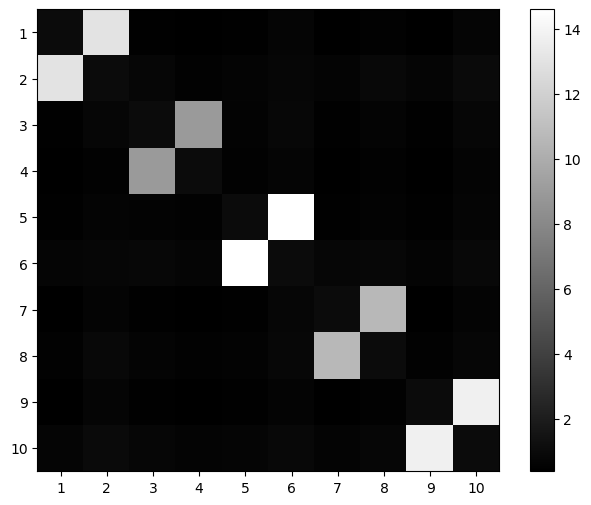

In [20]:
matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2
print(symmetric_matrix)
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

Normalized matrix with diagonals set to 1:
[[1.         0.89126098 0.03269927 0.02871057 0.03163968 0.04650233
  0.02781772 0.03416953 0.02623783 0.04611185]
 [0.89126098 1.         0.05099372 0.03715515 0.04416874 0.05121691
  0.04227578 0.05782743 0.04630429 0.06672349]
 [0.03269927 0.05099372 1.         0.61356274 0.03926698 0.05420338
  0.03306878 0.04208357 0.03305044 0.0505512 ]
 [0.02871057 0.03715515 0.61356274 1.         0.03399898 0.04841573
  0.02913336 0.03496284 0.02886708 0.04369342]
 [0.03163968 0.04416874 0.03926698 0.03399898 1.         1.
  0.03307648 0.04013169 0.0330001  0.04571077]
 [0.04650233 0.05121691 0.05420338 0.04841573 1.         1.
  0.05054501 0.05345198 0.04384946 0.05698687]
 [0.02781772 0.04227578 0.03306878 0.02913336 0.03307648 0.05054501
  1.         0.72827668 0.02862785 0.04398686]
 [0.03416953 0.05782743 0.04208357 0.03496284 0.04013169 0.05345198
  0.72827668 1.         0.03601798 0.05006559]
 [0.02623783 0.04630429 0.03305044 0.02886708 0.03300

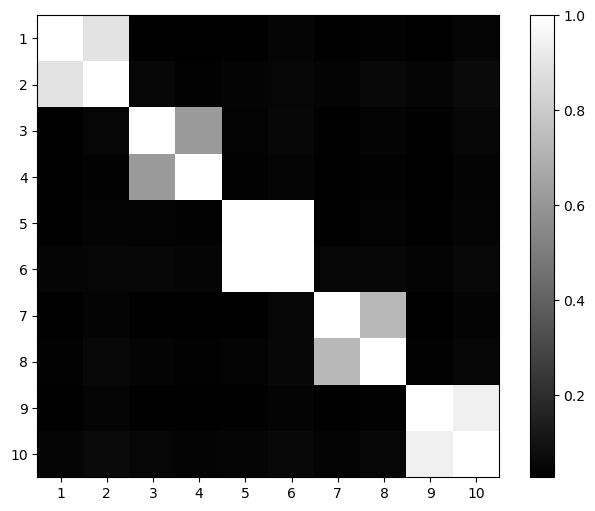

In [21]:

max_value = np.max(symmetric_matrix)

normalized_matrix = symmetric_matrix / max_value

np.fill_diagonal(normalized_matrix, 1)

print("Normalized matrix with diagonals set to 1:")
print(normalized_matrix)


plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

Normalized matrix with diagonals set to 1:
[[1.         0.89126098 0.03269927 0.02871057 0.03163968 0.04650233
  0.02781772 0.03416953 0.02623783 0.04611185]
 [0.89126098 1.         0.05099372 0.03715515 0.04416874 0.05121691
  0.04227578 0.05782743 0.04630429 0.06672349]
 [0.03269927 0.05099372 1.         0.61356274 0.03926698 0.05420338
  0.03306878 0.04208357 0.03305044 0.0505512 ]
 [0.02871057 0.03715515 0.61356274 1.         0.03399898 0.04841573
  0.02913336 0.03496284 0.02886708 0.04369342]
 [0.03163968 0.04416874 0.03926698 0.03399898 1.         1.
  0.03307648 0.04013169 0.0330001  0.04571077]
 [0.04650233 0.05121691 0.05420338 0.04841573 1.         1.
  0.05054501 0.05345198 0.04384946 0.05698687]
 [0.02781772 0.04227578 0.03306878 0.02913336 0.03307648 0.05054501
  1.         0.72827668 0.02862785 0.04398686]
 [0.03416953 0.05782743 0.04208357 0.03496284 0.04013169 0.05345198
  0.72827668 1.         0.03601798 0.05006559]
 [0.02623783 0.04630429 0.03305044 0.02886708 0.03300

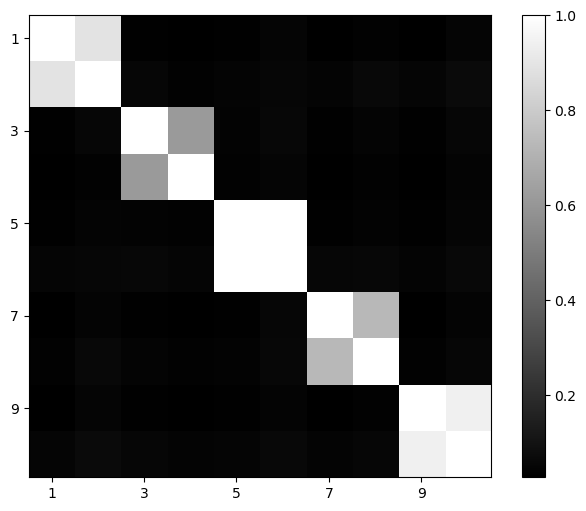

In [22]:

max_value = np.max(symmetric_matrix)

normalized_matrix = symmetric_matrix / max_value

np.fill_diagonal(normalized_matrix, 1)

print("Normalized matrix with diagonals set to 1:")
print(normalized_matrix)

# Create ticks for odd numbers only
ticks = np.arange(1, len(normalized_matrix) + 1, 2)

plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_matrix), 2), ticks)
plt.yticks(np.arange(0, len(normalized_matrix), 2), ticks)
plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()


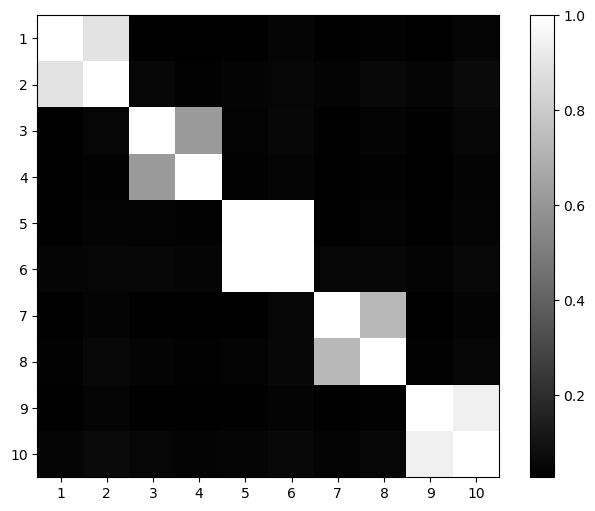

In [23]:


matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2

# Find the largest non-diagonal value
max_value = np.max(np.abs(np.triu(symmetric_matrix, k=1)))

# Divide the matrix by the largest non-diagonal value
if max_value != 0:
    symmetric_matrix /= max_value


np.fill_diagonal(symmetric_matrix, 1)

# Plotting
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

In [24]:
symmetric_matrix

array([[1.        , 0.89126098, 0.03269927, 0.02871057, 0.03163968,
        0.04650233, 0.02781772, 0.03416953, 0.02623783, 0.04611185],
       [0.89126098, 1.        , 0.05099372, 0.03715515, 0.04416874,
        0.05121691, 0.04227578, 0.05782743, 0.04630429, 0.06672349],
       [0.03269927, 0.05099372, 1.        , 0.61356274, 0.03926698,
        0.05420338, 0.03306878, 0.04208357, 0.03305044, 0.0505512 ],
       [0.02871057, 0.03715515, 0.61356274, 1.        , 0.03399898,
        0.04841573, 0.02913336, 0.03496284, 0.02886708, 0.04369342],
       [0.03163968, 0.04416874, 0.03926698, 0.03399898, 1.        ,
        1.        , 0.03307648, 0.04013169, 0.0330001 , 0.04571077],
       [0.04650233, 0.05121691, 0.05420338, 0.04841573, 1.        ,
        1.        , 0.05054501, 0.05345198, 0.04384946, 0.05698687],
       [0.02781772, 0.04227578, 0.03306878, 0.02913336, 0.03307648,
        0.05054501, 1.        , 0.72827668, 0.02862785, 0.04398686],
       [0.03416953, 0.05782743, 0.0420835

[[1.    0.891 0.033 0.029 0.032 0.047 0.028 0.034 0.026 0.046]
 [0.891 1.    0.051 0.037 0.044 0.051 0.042 0.058 0.046 0.067]
 [0.033 0.051 1.    0.614 0.039 0.054 0.033 0.042 0.033 0.051]
 [0.029 0.037 0.614 1.    0.034 0.048 0.029 0.035 0.029 0.044]
 [0.032 0.044 0.039 0.034 1.    1.    0.033 0.04  0.033 0.046]
 [0.047 0.051 0.054 0.048 1.    1.    0.051 0.053 0.044 0.057]
 [0.028 0.042 0.033 0.029 0.033 0.051 1.    0.728 0.029 0.044]
 [0.034 0.058 0.042 0.035 0.04  0.053 0.728 1.    0.036 0.05 ]
 [0.026 0.046 0.033 0.029 0.033 0.044 0.029 0.036 1.    0.94 ]
 [0.046 0.067 0.051 0.044 0.046 0.057 0.044 0.05  0.94  1.   ]]


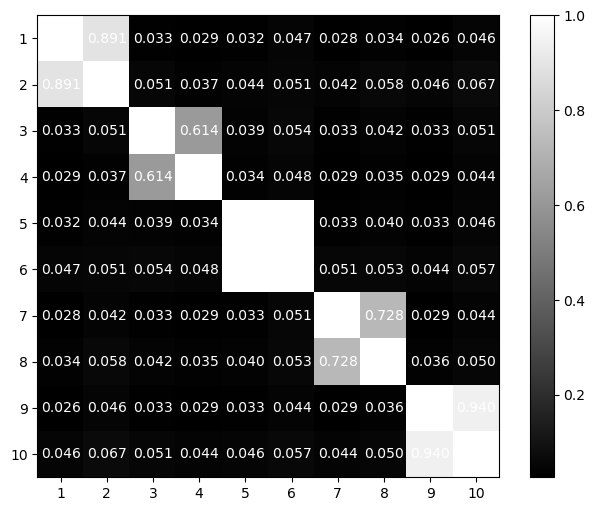

In [25]:

symmetric_matrix_rounded = np.round(symmetric_matrix, decimals=3)

# Print the symmetric matrix with rounded values
print(symmetric_matrix_rounded)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix_rounded, cmap='gray', interpolation='nearest')
plt.colorbar()

# Add text annotations
for i in range(len(symmetric_matrix)):
    for j in range(len(symmetric_matrix[0])):
        plt.text(j, i, f'{symmetric_matrix_rounded[i, j]:.3f}', ha='center', va='center', color='white')

plt.show()


## Generating precision matrix for training size = 100

In [26]:
loaded_models = torch.load(save_directory + '/tr100.pth')


In [27]:

model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]


In [28]:

models = []

for i in range(num_features):
    model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
    model.load_state_dict(model_state_dicts[i])
    models.append(model)


In [29]:


precision_matrix = []


for j in range(num_features):
    Sj = models[j]
    row = []
    Sj.eval()
    kth = j
    non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

    zk = test_samples.detach().requires_grad_(True)
    h = zk[:, non_kth]
    x = zk[:, [kth]]
    
    sk_zi = Sj(x,h)  
    for i in range(num_features):
        print(i, j)
        if i != j:
            first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
            first_derivative = torch.log(torch.abs(first_derivative))
            second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0] # check whether they are columns or row vector. column vector by adding [j]!!! This is currently a row vevotr which isn't right!
            third_derivative= torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

            second = torch.abs(third_derivative[:,[i]]).mean().item()
            first_half = -1/2 * (sk_zi**2)
            first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
            second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

            first = torch.abs(second_half_deriative[:, [i]]).mean().item()
            row.append(first + second)
        else:
            row.append(1) 
    precision_matrix.append(row)
    print(precision_matrix[-1])

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.074312210083008, 1.4397882223129272, 0.7393176555633545, 1.1767299175262451, 1.4417673349380493, 0.7500651478767395, 1.3512324094772339, 0.8731304407119751, 0.8972966074943542]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[3.0704891681671143, 1, 1.0035709142684937, 1.2599691152572632, 1.5486788749694824, 0.9643505811691284, 1.348202109336853, 0.9379931688308716, 1.629826545715332, 1.3197975158691406]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[1.3710312843322754, 1.3380839824676514, 1, 1.5978941917419434, 1.6079357862472534, 0.9349314570426941, 1.5523324012756348, 0.8347978591918945, 1.6085728406906128, 1.1655226945877075]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[2.0713915824890137, 1.8122355937957764, 2.9108729362487793, 1, 2.034829616546631, 1.1064718961715698, 4.131916522979736, 1.474463701248169, 1.4353443384170532, 5.747756481170654]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[1.269636631011963, 0.9530836939811707, 0.6033754944801331, 0.491815328

[[1.         2.57240069 1.40540975 1.40535462 1.22318327 1.06272569
  0.73587224 1.75641888 0.79384363 1.1901308 ]
 [2.57240069 1.         1.17082745 1.53610235 1.25088128 1.19977683
  1.18322581 2.02004808 1.25799847 1.72619188]
 [1.40540975 1.17082745 1.         2.25438356 1.10565564 1.00559691
  1.22303978 1.16948235 1.22922212 1.58386618]
 [1.40535462 1.53610235 2.25438356 1.         1.26332247 1.12362832
  2.47606787 1.48084456 1.11105394 3.72309268]
 [1.22318327 1.25088128 1.10565564 1.26332247 1.         1.55346078
  0.66347572 1.39718729 1.39087921 1.14294618]
 [1.06272569 1.19977683 1.00559691 1.12362832 1.55346078 1.
  0.69443652 1.65472281 1.3889941  2.23123461]
 [0.73587224 1.18322581 1.22303978 2.47606787 0.66347572 0.69443652
  1.         1.62040216 0.84988043 1.04830754]
 [1.75641888 2.02004808 1.16948235 1.48084456 1.39718729 1.65472281
  1.62040216 1.         1.66266564 1.71082675]
 [0.79384363 1.25799847 1.22922212 1.11105394 1.39087921 1.3889941
  0.84988043 1.662665

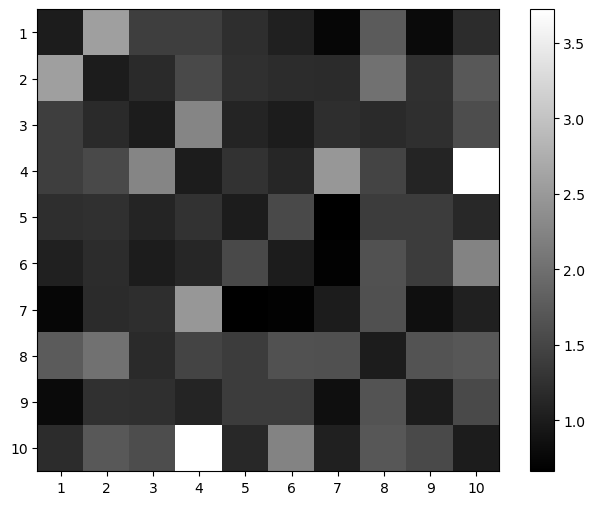

In [30]:
matrix = np.array(precision_matrix)
transpose_matrix = matrix.T 
symmetric_matrix = (transpose_matrix + matrix) / 2
print(symmetric_matrix)
plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

Normalized matrix with diagonals set to 1:
[[1.         0.69093115 0.37748449 0.37746968 0.32853957 0.28544164
  0.1976508  0.47176341 0.21322156 0.31966188]
 [0.69093115 1.         0.31447712 0.41258773 0.33597909 0.32225274
  0.31780724 0.5425726  0.33789072 0.46364462]
 [0.37748449 0.31447712 1.         0.60551368 0.29697237 0.2700972
  0.32850103 0.31411583 0.33016157 0.4254168 ]
 [0.37746968 0.41258773 0.60551368 1.         0.33932072 0.30179972
  0.66505674 0.39774582 0.29842232 1.        ]
 [0.32853957 0.33597909 0.29697237 0.33932072 1.         0.4172501
  0.17820554 0.37527599 0.37358168 0.30698838]
 [0.28544164 0.32225274 0.2700972  0.30179972 0.4172501  1.
  0.18652142 0.44444846 0.37307535 0.59929602]
 [0.1976508  0.31780724 0.32850103 0.66505674 0.17820554 0.18652142
  1.         0.43523014 0.2282727  0.28156902]
 [0.47176341 0.5425726  0.31411583 0.39774582 0.37527599 0.44444846
  0.43523014 1.         0.44658186 0.45951764]
 [0.21322156 0.33789072 0.33016157 0.29842232 0

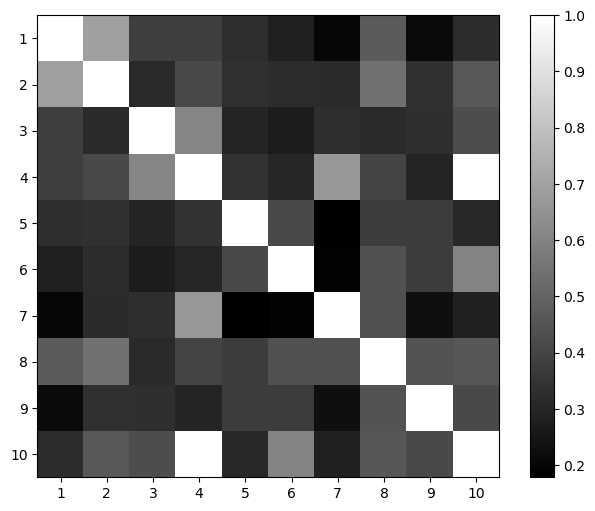

In [31]:
# Normalise with maximum value of the matrix.
max_value = np.max(symmetric_matrix)

normalized_matrix = symmetric_matrix / max_value

np.fill_diagonal(normalized_matrix, 1)

print("Normalized matrix with diagonals set to 1:")
print(normalized_matrix)


plt.figure(figsize=(8, 6))
plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
plt.colorbar()
plt.show()

# Generate precision matrix for all training sizes

100


0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.074312210083008, 1.4397882223129272, 0.7393176555633545, 1.1767299175262451, 1.4417673349380493, 0.7500651478767395, 1.3512324094772339, 0.8731304407119751, 0.8972966074943542]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[3.0704891681671143, 1, 1.0035709142684937, 1.2599691152572632, 1.5486788749694824, 0.9643505811691284, 1.348202109336853, 0.9379931688308716, 1.629826545715332, 1.3197975158691406]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[1.3710312843322754, 1.3380839824676514, 1, 1.5978941917419434, 1.6079357862472534, 0.9349314570426941, 1.5523324012756348, 0.8347978591918945, 1.6085728406906128, 1.1655226945877075]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[2.0713915824890137, 1.8122355937957764, 2.9108729362487793, 1, 2.034829616546631, 1.1064718961715698, 4.131916522979736, 1.474463701248169, 1.4353443384170532, 5.747756481170654]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[1.269636631011963, 0.9530836939811707, 0.6033754944801331, 0.491815328

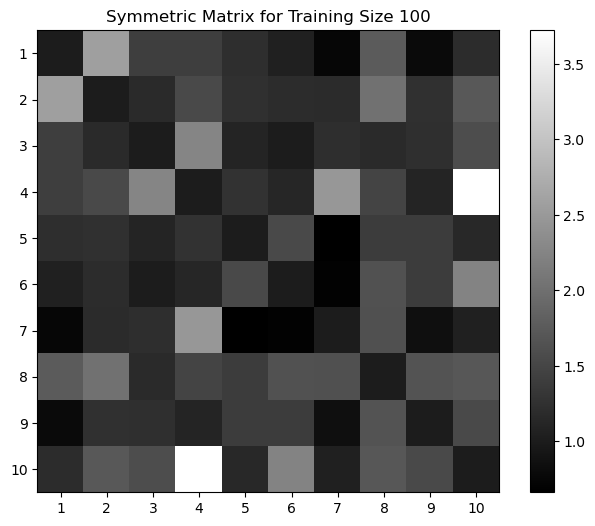

500
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 1.0871914625167847, 0.49456894397735596, 0.3309459686279297, 0.4395570456981659, 0.366802841424942, 0.3346917927265167, 0.5043849349021912, 0.39944350719451904, 0.43526434898376465]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[2.7494704723358154, 1, 0.5134550929069519, 0.4830958843231201, 0.4054563045501709, 0.3852631747722626, 0.5899553894996643, 0.7096027135848999, 0.6300911903381348, 0.7078573107719421]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.636786699295044, 0.6202386021614075, 1, 1.3547420501708984, 0.4843226671218872, 0.4289979934692383, 0.7851992249488831, 0.4802195429801941, 0.80233234167099, 0.527151346206665]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.6050021648406982, 0.6240435838699341, 4.037688255310059, 1, 0.9536728262901306, 0.5225496888160706, 0.7238706946372986, 0.6036497354507446, 0.5013309717178345, 0.6958996653556824]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.40186893939971924, 0.29675090312957764, 0.41601240634918213,

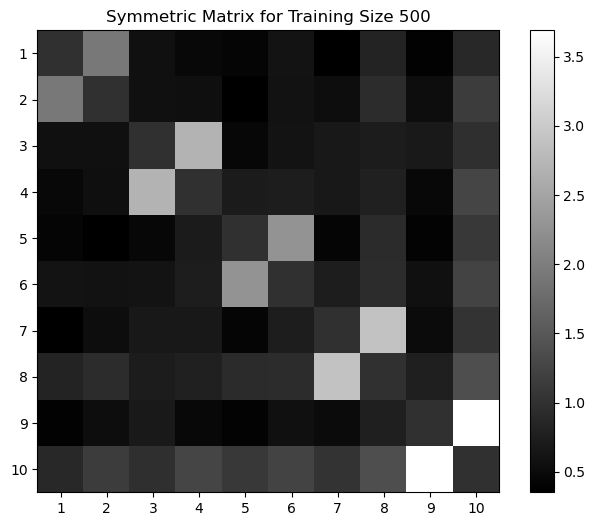

1000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 1.518682599067688, 0.33438819646835327, 0.2698850929737091, 0.3359435796737671, 0.3568533957004547, 0.38888177275657654, 0.26737895607948303, 0.29891738295555115, 0.33899879455566406]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[4.767191410064697, 1, 0.5828784704208374, 0.66965252161026, 0.5699031949043274, 0.4880303740501404, 0.5596187710762024, 0.6372374296188354, 0.6013970971107483, 0.6517427563667297]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.32025450468063354, 0.3017144203186035, 1, 0.906562089920044, 0.19437547028064728, 0.19743983447551727, 0.21833784878253937, 0.27010592818260193, 0.1979726105928421, 0.21152131259441376]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.722161054611206, 0.8960005640983582, 7.0301947593688965, 1, 0.8502686619758606, 0.6848673820495605, 0.8069688677787781, 1.0333153009414673, 0.9413723349571228, 0.8977212905883789]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.28762778639793396, 0.28452906012535095, 0.329217046

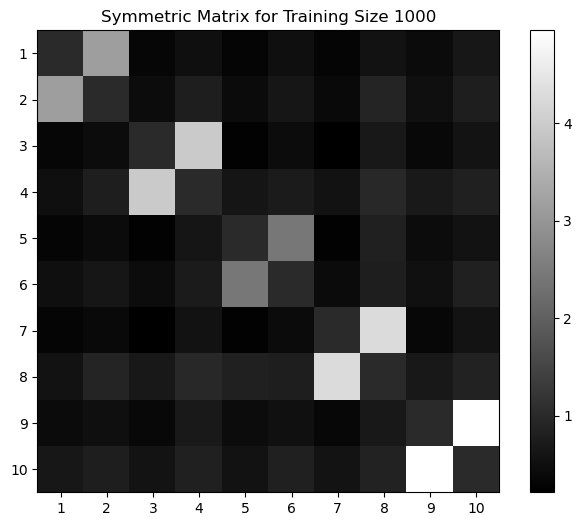

2000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 1.123143196105957, 0.2406122088432312, 0.20929624140262604, 0.21101494133472443, 0.25719863176345825, 0.22815239429473877, 0.2595853805541992, 0.18751771748065948, 0.21765205264091492]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[21.136810302734375, 1, 1.1913704872131348, 1.3704910278320312, 1.358629822731018, 1.2565844058990479, 1.1898483037948608, 1.4418939352035522, 1.2760103940963745, 1.3184319734573364]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.46583300828933716, 0.3183247148990631, 1, 2.081681728363037, 0.31506213545799255, 0.40757107734680176, 0.31983205676078796, 0.36253607273101807, 0.35957321524620056, 0.3251768946647644]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.5331292152404785, 0.5259877443313599, 9.999589920043945, 1, 0.7032866477966309, 0.6568922996520996, 0.6435624957084656, 0.5424579381942749, 0.6601723432540894, 0.6133056282997131]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.21142074465751648, 0.1945681869983673, 0.2420837

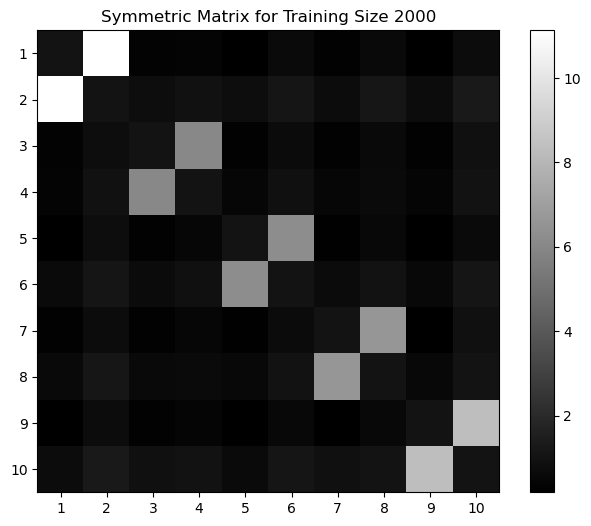

3500
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.5185093879699707, 0.16172833740711212, 0.23200668394565582, 0.25418776273727417, 0.2412533462047577, 0.20717068016529083, 0.22847145795822144, 0.2068859189748764, 0.21998217701911926]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[20.428855895996094, 1, 0.8799896240234375, 1.0517017841339111, 0.9377048015594482, 1.0763607025146484, 0.8739517331123352, 1.0020999908447266, 1.0986210107803345, 1.0978119373321533]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.4860324263572693, 0.5934852361679077, 1, 3.5999698638916016, 0.46901190280914307, 0.4835793972015381, 0.4662211835384369, 0.4845450818538666, 0.49145761132240295, 0.4000897705554962]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.5697200894355774, 0.7184112071990967, 15.313040733337402, 1, 0.48180755972862244, 0.5919508934020996, 0.603445827960968, 0.548072099685669, 0.5116848349571228, 0.4861662685871124]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.17151738703250885, 0.1776958703994751, 0.17129018

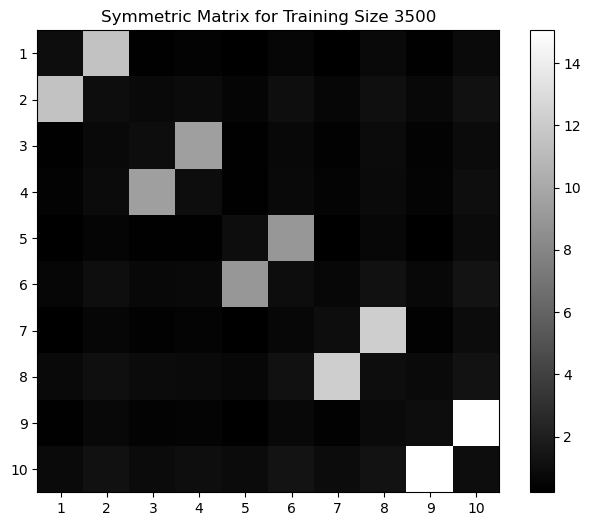

5000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.1852264404296875, 0.39623647928237915, 0.39587149024009705, 0.38380640745162964, 0.4209356904029846, 0.3926132023334503, 0.4114128351211548, 0.35708871483802795, 0.4023018181324005]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[23.84498405456543, 1, 0.8326632976531982, 0.7599313259124756, 0.7577110528945923, 0.786707878112793, 0.7627740502357483, 1.0145574808120728, 0.8666698336601257, 0.9271884560585022]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.5587799549102783, 0.6566618084907532, 1, 4.63939094543457, 0.6260502934455872, 0.5642896294593811, 0.5591854453086853, 0.541893720626831, 0.5633779168128967, 0.6029291152954102]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.44265082478523254, 0.3252238631248474, 13.280351638793945, 1, 0.4348626434803009, 0.3970707058906555, 0.39712363481521606, 0.44698354601860046, 0.4450971782207489, 0.36152589321136475]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.5402637124061584, 0.5322832465171814, 0.5207829475402

KeyboardInterrupt: 

In [33]:

matrices = []
for training_size in training_sizes:
    # Load the models for the current training size
    print(training_size)
    loaded_models = torch.load(f'{save_directory}/tr{training_size}.pth')
    
    model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]

    models = []
    for i in range(num_features):
        model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
        model.load_state_dict(model_state_dicts[i])
        models.append(model)

    precision_matrix = []

    for j in range(num_features):
        Sj = models[j]
        row = []
        Sj.eval()
        kth = j
        non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

        zk = test_samples.detach().requires_grad_(True)
        h = zk[:, non_kth]
        x = zk[:, [kth]]

        sk_zi = Sj(x, h)  
        for i in range(num_features):
            print(i, j)
            if i != j:
                first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
                first_derivative = torch.log(torch.abs(first_derivative))
                second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0]
                third_derivative = torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

                second = torch.abs(third_derivative[:, [i]]).mean().item()
                first_half = -1 / 2 * (sk_zi ** 2)
                first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
                second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

                first = torch.abs(second_half_deriative[:, [i]]).mean().item()
                row.append(first + second)
            else:
                row.append(1)
        precision_matrix.append(row)
        print(precision_matrix[-1])

    matrix = np.array(precision_matrix)
    transpose_matrix = matrix.T 
    symmetric_matrix = (transpose_matrix + matrix) / 2

    print(f"Symmetric matrix for training size {training_size}:")
    print(symmetric_matrix)
    matrices.append(symmetric_matrix)
    
    # Save the symmetric matrix
    np.save(f'{save_directory}/symmetric_matrix_{training_size}.npy', symmetric_matrix)
    
    # Plot the symmetric matrix
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Symmetric Matrix for Training Size {training_size}')
    plt.savefig(f'{save_directory}/symmetric_matrix_{training_size}.png')
    plt.show()


5000
0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
[1, 2.1852264404296875, 0.39623647928237915, 0.39587149024009705, 0.38380640745162964, 0.4209356904029846, 0.3926132023334503, 0.4114128351211548, 0.35708871483802795, 0.4023018181324005]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
[23.84498405456543, 1, 0.8326632976531982, 0.7599313259124756, 0.7577110528945923, 0.786707878112793, 0.7627740502357483, 1.0145574808120728, 0.8666698336601257, 0.9271884560585022]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
[0.5587799549102783, 0.6566618084907532, 1, 4.63939094543457, 0.6260502934455872, 0.5642896294593811, 0.5591854453086853, 0.541893720626831, 0.5633779168128967, 0.6029291152954102]
0 3
1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
[0.44265082478523254, 0.3252238631248474, 13.280351638793945, 1, 0.4348626434803009, 0.3970707058906555, 0.39712363481521606, 0.44698354601860046, 0.4450971782207489, 0.36152589321136475]
0 4
1 4
2 4
3 4
4 4
5 4
6 4
7 4
8 4
9 4
[0.5402637124061584, 0.5322832465171814, 0.5207829475402

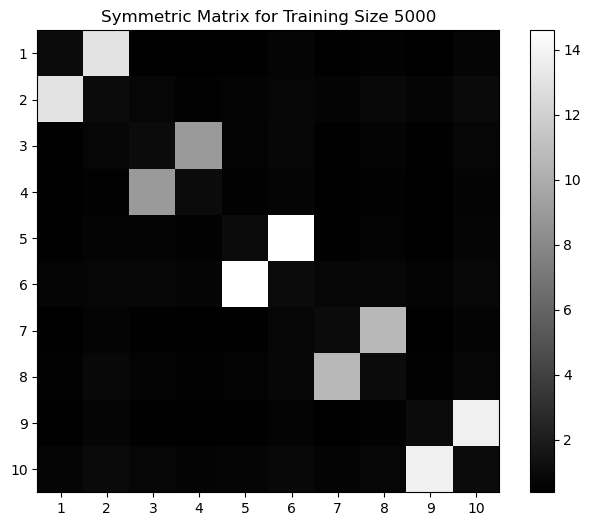

In [34]:

matrices = []
for training_size in [5000]:
    # Load the models for the current training size
    print(training_size)
    loaded_models = torch.load(f'{save_directory}/tr{training_size}.pth')
    
    model_state_dicts = [loaded_models[f'model{i}_state_dict'] for i in range(1, num_features + 1)]

    models = []
    for i in range(num_features):
        model = MonotonicNN(num_features, hidden_layers, nb_steps, 'cpu')
        model.load_state_dict(model_state_dicts[i])
        models.append(model)

    precision_matrix = []

    for j in range(num_features):
        Sj = models[j]
        row = []
        Sj.eval()
        kth = j
        non_kth = [idx for idx in range(test_samples.shape[1]) if idx != kth]

        zk = test_samples.detach().requires_grad_(True)
        h = zk[:, non_kth]
        x = zk[:, [kth]]

        sk_zi = Sj(x, h)  
        for i in range(num_features):
            print(i, j)
            if i != j:
                first_derivative = torch.autograd.grad(sk_zi, zk, torch.ones_like(sk_zi), create_graph=True)[0]
                first_derivative = torch.log(torch.abs(first_derivative))
                second_derivative = torch.autograd.grad(first_derivative[:, [j]], zk, torch.ones_like(first_derivative[:, [j]]), create_graph=True)[0]
                third_derivative = torch.autograd.grad(second_derivative[:, [j]], zk, torch.ones_like(second_derivative[:, [j]]), create_graph=True)[0]

                second = torch.abs(third_derivative[:, [i]]).mean().item()
                first_half = -1 / 2 * (sk_zi ** 2)
                first_half_derivative = torch.autograd.grad(first_half, zk, torch.ones_like(first_half), create_graph=True)[0]
                second_half_deriative = torch.autograd.grad(first_half_derivative[:, [j]], zk, torch.ones_like(first_half_derivative[:, [j]]), create_graph=True)[0]

                first = torch.abs(second_half_deriative[:, [i]]).mean().item()
                row.append(first + second)
            else:
                row.append(1)
        precision_matrix.append(row)
        print(precision_matrix[-1])

    matrix = np.array(precision_matrix)
    transpose_matrix = matrix.T 
    symmetric_matrix = (transpose_matrix + matrix) / 2

    print(f"Symmetric matrix for training size {training_size}:")
    print(symmetric_matrix)
    matrices.append(symmetric_matrix)
    
    # Save the symmetric matrix
    np.save(f'{save_directory}/symmetric_matrix_{training_size}.npy', symmetric_matrix)
    
    # Plot the symmetric matrix
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.yticks(np.arange(0, len(symmetric_matrix), 1), np.arange(1, len(symmetric_matrix) + 1))
    plt.imshow(symmetric_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Symmetric Matrix for Training Size {training_size}')
    plt.savefig(f'{save_directory}/symmetric_matrix_{training_size}.png')
    plt.show()


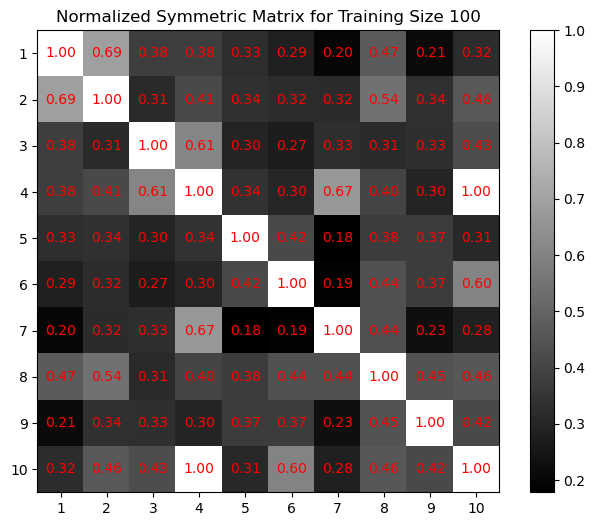

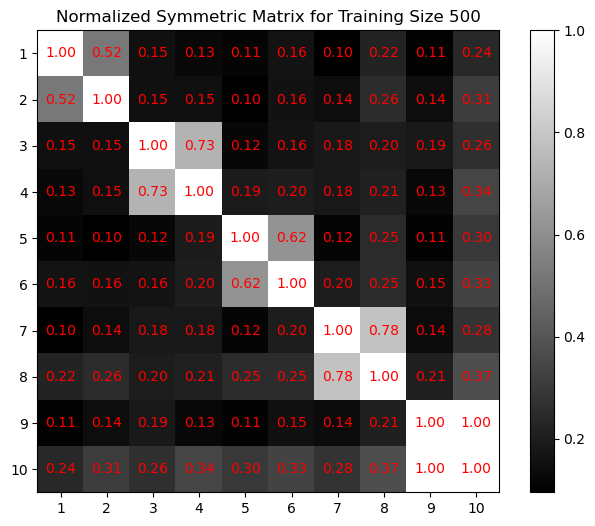

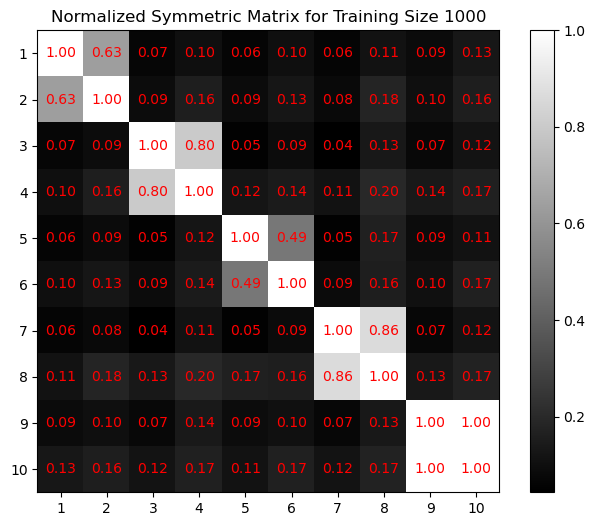

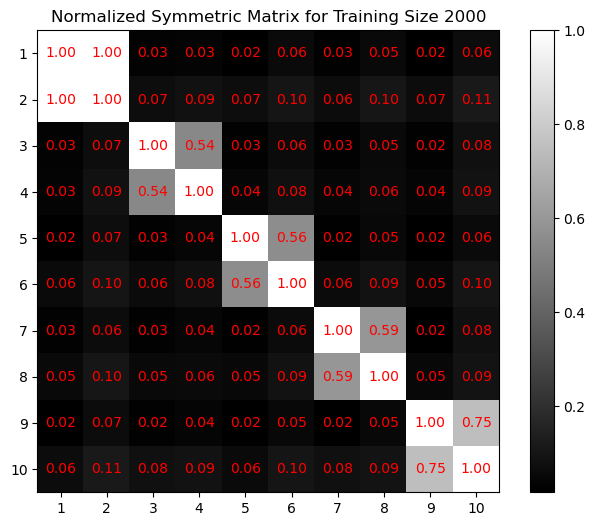

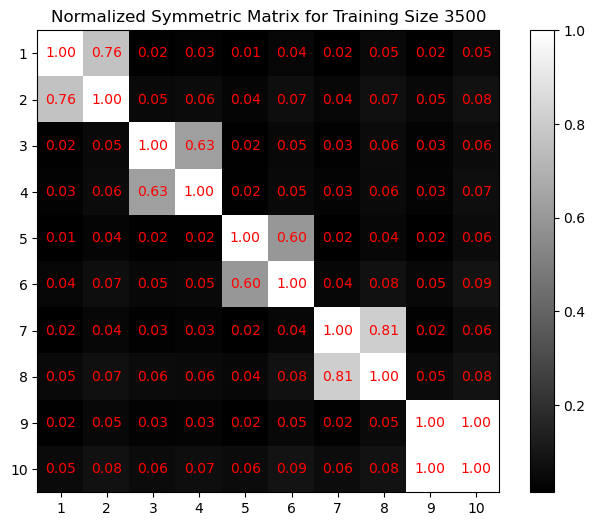

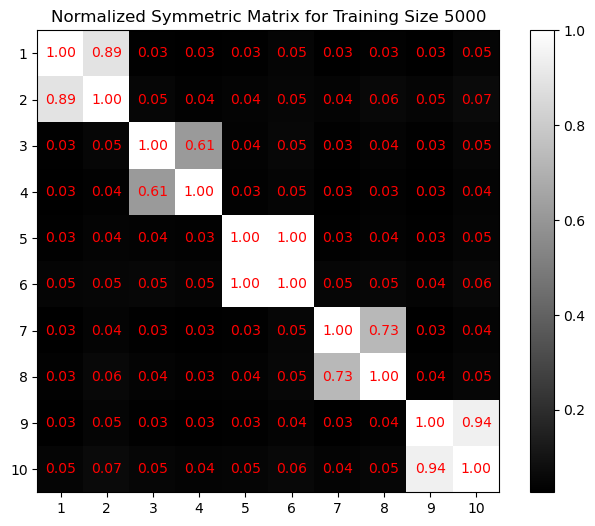

In [39]:

normalized_matrices = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)
    normalized_matrices.append((training_size, normalized_matrix))

for training_size, normalized_matrix in normalized_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.yticks(np.arange(0, len(normalized_matrix), 1), np.arange(1, len(normalized_matrix) + 1))
    plt.imshow(normalized_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Normalized Symmetric Matrix for Training Size {training_size}')
    
    for i in range(len(normalized_matrix)):
        for j in range(len(normalized_matrix[i])):
            plt.text(j, i, f'{normalized_matrix[i, j]:.2f}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/normalized_symmetric_matrix_{training_size}.png')
    plt.show()


# Thresholding the precision matrix

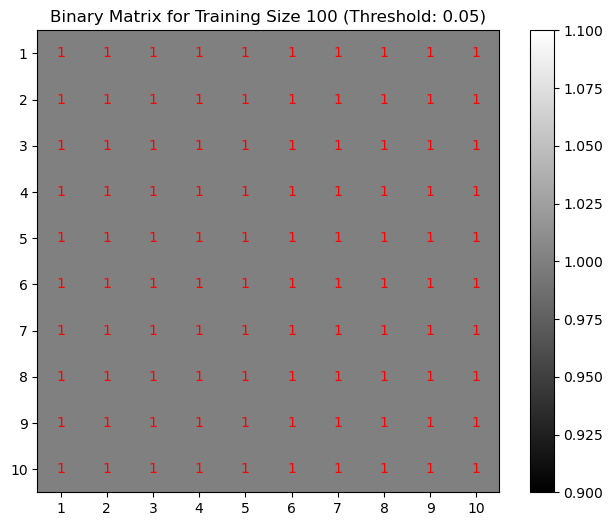

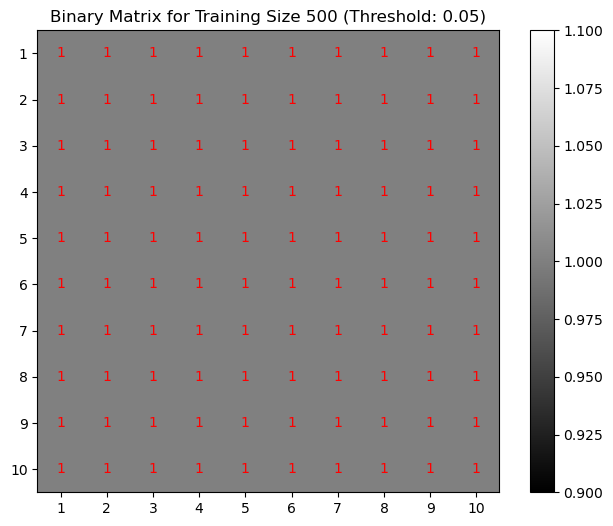

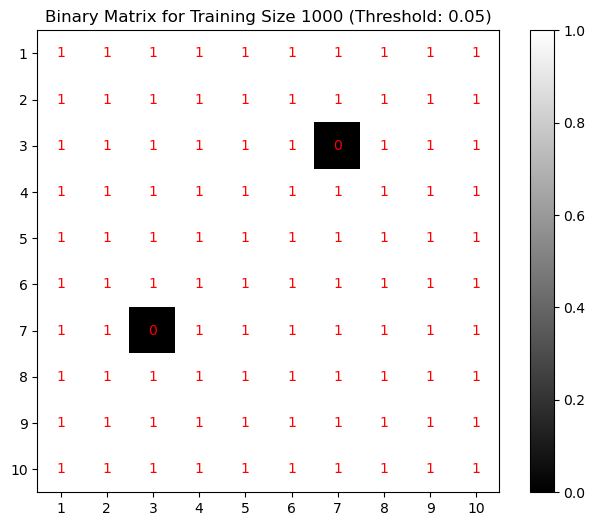

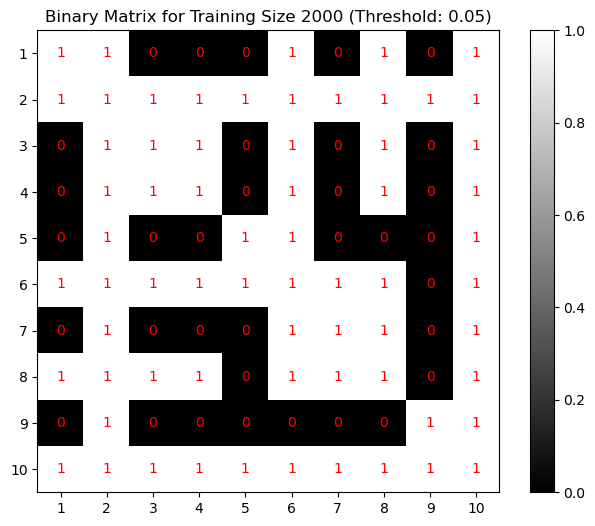

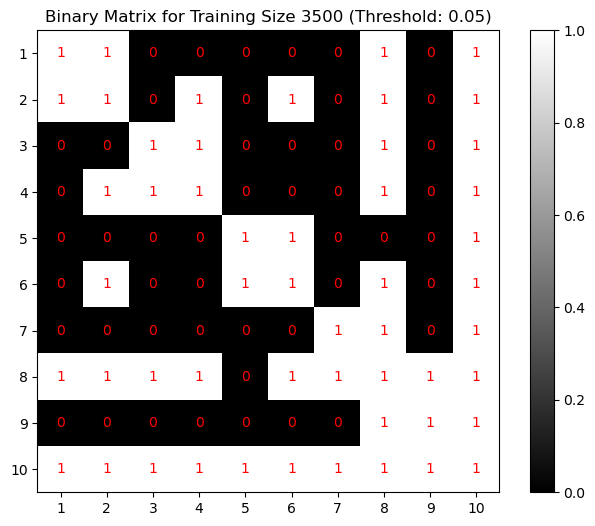

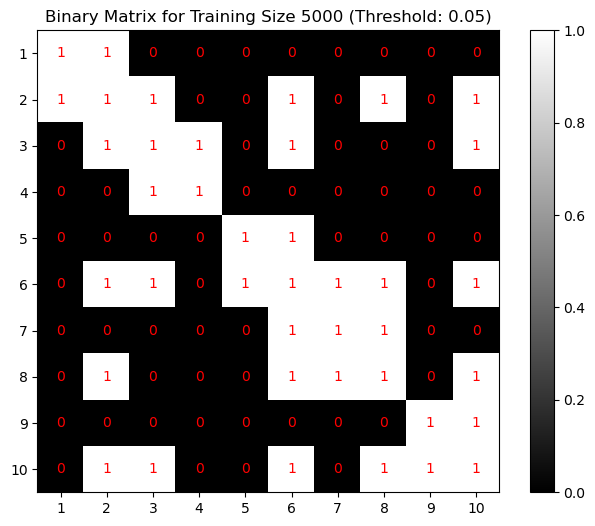

In [41]:
threshold = 0.05  

binary_matrices = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    np.fill_diagonal(normalized_matrix, 1)
    # Apply the threshold to create a binary matrix
    binary_matrix = np.where(normalized_matrix < threshold, 0, 1)
    
    # Store the binary matrix
    binary_matrices.append((training_size, binary_matrix))

# After the loop, plot all binary matrices
for training_size, binary_matrix in binary_matrices:
    plt.figure(figsize=(8, 6))
    plt.xticks(np.arange(0, len(binary_matrix), 1), np.arange(1, len(binary_matrix) + 1))
    plt.yticks(np.arange(0, len(binary_matrix), 1), np.arange(1, len(binary_matrix) + 1))
    plt.imshow(binary_matrix, cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Binary Matrix for Training Size {training_size} (Threshold: {threshold})')
    
    # Overlay the binary matrix values on the heatmap
    for i in range(len(binary_matrix)):
        for j in range(len(binary_matrix[i])):
            plt.text(j, i, f'{binary_matrix[i, j]}', ha='center', va='center', color='red')

    plt.savefig(f'{save_directory}/binary_matrix_{training_size}.png')
    plt.show()

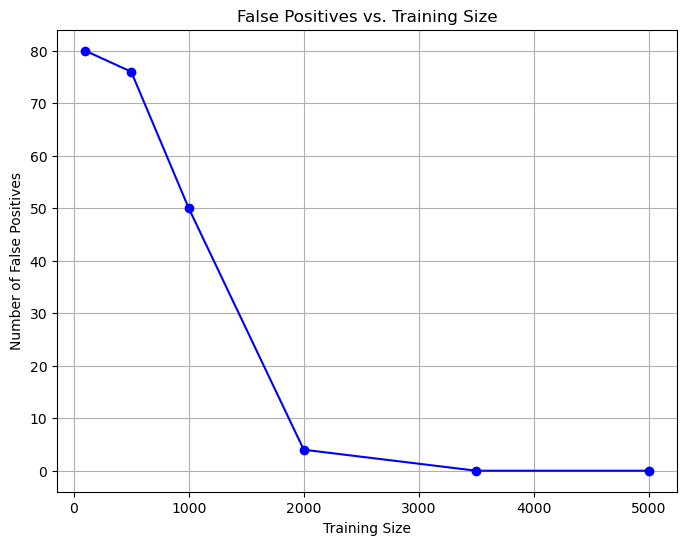

In [43]:
threshold = 0.1  
matrix_size = 10

ground_truth = np.eye(matrix_size) 

for i in range(0, matrix_size, 2):
    ground_truth[i, i+1] = 1
    ground_truth[i+1, i] = 1  
false_positives_list = []

for training_size in training_sizes:
    matrix = np.load(f'{save_directory}/symmetric_matrix_{training_size}.npy')

    max_value = np.max(matrix)
    normalized_matrix = matrix / max_value
    binary_matrix = np.where(normalized_matrix < threshold, 0, 1)
    
    # Compute the false positives
    false_positives = np.sum((ground_truth == 0) & (binary_matrix == 1))
    
    # Store the false positive count
    false_positives_list.append(false_positives)

plt.figure(figsize=(8, 6))
plt.plot(training_sizes, false_positives_list, marker='o', linestyle='-', color='blue')
plt.xlabel('Training Size')
plt.ylabel('Number of False Positives')
plt.title('False Positives vs. Training Size')
plt.grid(True)
plt.savefig(f'{save_directory}/false_positives_vs_training_size.png')
plt.show()

In [44]:
print(false_positives_list)

[80, 76, 50, 4, 0, 0]
